# DataScience Spring 2019 Now You "C" Me Group Combined Notebooks
link to video: https://youtu.be/lhodcPtmywc 

# ARPE-19 Dataset RNA and hMeDIP Normalization

## Introduction to what I am doing here

To start with, I have my raw count files. I have combined them already (using bash scripting), so it is in table format where it is tab delimited like this:

    Gene_ID | Sample 1 | Sample 2 | Sample 3 | Sample 4
    ENSRN0001 | 6 | 8 | 24| 29
    ENSRN0002 | 12 | 13 | 14 | 13
    ENSRN0003 | 18 | 17 | 1 | 0

For the RNA I also have results from edgeR and DESeq2. I have the transcript info from the GTF file in a csv file that I will use to determine transcript length.

For the hMeDIP samples I also have the edgeR statistical analysis, the bed file stating the location of the each peak (chromosome, start, stop, name of peak), the count data for genomic input (which was used for the peak calling and will be used for determining the cutoff of expression) and the region_analysis output which tells which gene the peak is close to. 

RNA-seq samples were aligned using STAR and then quantified using htseq-count. Both edgeR and DESeq2 are used for differential analysis and genes below a false discovery rate (FDR, also called adjusted P-value) of 0.05 by both DESeq2 and edgeR will be called differential. A limit of detection will be calculated using the genomic input from the hMeDIP-seq portion of the experiment. 

hMeDIP-seq peaks were called using the irreproducible discovery rate pipeline designed for the ChIP-seq portion of the ENCODE consortium. Counts were generated using htseq-count. Differential analysis was calculated using edgeR. To account for not having a second statistical program (DESeq2 can't normalize to all data), a cutoff of 1.5-fold change will be used in conjunction with an FDR of 0.05 by edgeR to determine differential peaks.

Genes that have more count data after treatment (increase in expression) or peaks that have higher count data (increase in enrichment from the antibody) are considered "Upregulated". Genes that have fewer counts or lower coverage (decreae in expression) or peaks that have lower coverage (decreased enrichment from the antibody) are considered "Downregulated". Genes that have relatively similar count data or that do not achieve statistical significant are considered "Nondifferential".




### hMeDIP-seq normalization 

In this particular jupyter notebook, I am going to be cleaning up the data. This has many steps, and I am going to save many intermediate files. Most of those files will not be used in the correlation or classification parts of this project, but the files are still useful for this project and may be used in future directions from this sampleset.

The first step to cleaning up the hMeDIP-seq data is to normalize the counts to the total number of reads. This is a Read Count Per Million (RCPM), but this first one does not exclude outliers. 

The next step is to determine which peaks are outliers. The reason for this is that outliers can bias your normalization. As an example, if you have two samples that are identical, and then you spike in DNA that will be in one region for 50% of one of the samples, your normalization will all be wrong. Instead of saying that your spiked-sample has one peak that is significantly different than what is found in the other sample, all of your peaks look like they have half as much coverage as the non-spiked sample and all regions appear differential. If you remove the one spiked region from the normalization, now the unchanged regions all appear the same between the samples (as they should), but the spiked in reads still appear only in the one sample. For this reason, this step includes a linear regression between the two sample types (in this case control and vitamin C), and then a Cook's value of 1 (can be changed), is used to determine the outliers. 

Once you have identified outliers, you can go back to the raw count data and normalize to total read counts excluding the outliers. This gives you the RCPM. This file is saved as the RCPM table.

The next step is to normalize to the RCPM by the width of each peak. This allows you to compare one peak to another. If you don't do this and you compare one peak that covers 100 base pairs (bp) to another peak that covers 100,000 bp, you would just by chance expect that the secon peak has 1,000 times as many reads. To normalize this, we take the RCPM and multiply by 1,000 and divide by the length of the peak. This is referred to as "Fragments Per Kilobase per Million mapped reads" (FPKM, see Trapnell et al. 2012, Nature Protocols). To do this, I use the peaks bed file, which contains information about the start and stop positions of each peak that can be used to calculate the length of each peak. This file is saved as the FPKM table. 

Once reads are normalized correctly, I incorporate the statistical data. For hMeDIP-seq, I use edgeR and a fold change. Peaks that receive a false-discovery rate (FDR, benjamini-hocherberg correction) below 0.05 and a fold change of 1.5x or greater are considered differential.

The next step is to determine which genes are most likely affected by each peak. To do this I used region_analysis, which is a program developed for the ENCODE project. This tells you which gene is closest to the center of the peak and how far the peak is from the transcription start site (TSS) of the gene. Using this data, I can assign each peak to a gene (or classify it as intergenic), and classify each to a region of the gene (upstream promoter, TSS, downstream promoter or gene body). 

There are a lot more peaks than genes, and most genes contain many peaks. As such, the next step is to determine the counts of peaks in each region per gene. Additionally, these peaks are divided by how they respond to vitamin C (upregulated, downregulated or nondifferential). This file is saved as a counts per gene region file. 


### Normalizing RNA-seq data

Like the hMeDIP-seq data, the RNA-seq data needs to be normalized. The first step is to normalize to the total reads within annotated features, and then to find outliers, just like is done for the hMeDIP-seq. You next go back to the raw count data and normalize to the total read counts within annotated features that are not outliers to get the RCPM table. Next, you use the genomic info file to get the lengths of each transcript and calculate the FPKM. This is essentially identical to the first few steps of hMeDIP-seq, except that we don't include reads that don't lie within annotated features for RNA. 

Next, we need to determine differential genes. For RNA-seq data, we use both edgeR and DESeq2. Genes that receive an FDR value below 0.05 by both edgeR and DESeq2 are considered differential. No fold change limit is taken into account and using two algorithms for differential analysis is thought to limit false positives. 

Again, the fold change is used to split differential genes into upregulated and downregulated genes.

Now, the counts of peaks per gene region are integrated with the RNA-seq data to generate a table that contains information that will be used for our classification analysis. Other information that is kept in the file includes gene biotype (e.g. protein coding, long noncoding RNA, antisense RNA, etc.) and the length of the gene. 

The next step is different than was used for hMeDIP-seq. For the hMeDIP-seq, I used the IDR pipeline (from ENCODE) to determine which regions were highly enriched. However, for RNA we look at all annotated regions. Most of these regions, however, are not going to have any reads. This step is determining which genes are above our limit of detection. To do this, I perform the normalization of the genomic input data. The genomic input data was generated for hMeDIP-seq, but has no enrichment. It is meant to represent what we would get if we sequenced just noise. For the RNA, I draw out density plots of the RNA-seq samples and the genomic input. If we use a limit of detection (LOD) below the highest expressed genomic input, then those are essentially false positives for the LOD. If we use a LOD above the bottom of the true genes, then those true genes below that point ar false negatives for our LOD. For this, I look at the density plot and take the point where the RNA-seq data overlaps the genomic input to find the minimum number of false positives and false negatives. Only the transcripts above the determined LOD are used for the rest of this project. 

#### Reading in the count files and normalizing them
The first step is going to be reading in the count files and normalizing them to total read counts. There will be multiple steps of normalization, but this is the first one.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.listdir("Input_Data/ARPE-19_Dataset")

['ARPE19.hMeDIP.counts.txt',
 'ARPE19_RNA.counts.txt',
 'ARPE19_Region.Analysis.txt',
 'ARPE19.hMeDIP.Control.vs.VitC.edgeR.csv',
 'ARPE19.Genomic.Input.counts.txt',
 'ARPE19_RNA.edgeR.csv',
 'ARPE19_RNA.DESeq2.csv',
 'ARPE19.hMeDIP.final_peaks.bed.txt']

In [3]:
os.listdir("Input_Data/")

['MM10.Consensus.Transcript.Info.csv',
 '.DS_Store',
 'SC-cAMP_Dataset',
 'HG38.90.Consensus.transcript.info.csv',
 'RN6.91.Consensus.transcript.info.csv',
 'ARPE-19_Dataset',
 'SC-VitC_Dataset']

In [4]:
os.getcwd()

'/Users/david/Documents/David_Sant/Classes/Data_Science_COMP_5360/2019-datascience-homeworks/Final Project/now-u-c-me-datascience-final-project'

In [5]:
Input_path = r"Input_Data/ARPE-19_Dataset/"
Output_Path = r"Output_Tables_and_Results/ARPE_Intermediate_Files/"

Input_hMeDIP_Counts_File = Input_path+"ARPE19.hMeDIP.counts.txt"
Input_hMeDIP_edgeR = Input_path+"ARPE19.hMeDIP.Control.vs.VitC.edgeR.csv"
Input_region_analysis = Input_path+"ARPE19_Region.Analysis.txt"
Input_Genomic_Input_Counts_File = Input_path+"ARPE19.Genomic.Input.counts.txt"
Input_bed_file = Input_path+"ARPE19.hMeDIP.final_peaks.bed.txt"

Input_RNA_Counts_File = Input_path+"ARPE19_RNA.counts.txt"
Input_RNA_edgeR = Input_path+"ARPE19_RNA.edgeR.csv"
Input_RNA_DESeq2 = Input_path+"ARPE19_RNA.DESeq2.csv"

Input_genomic_info_file = "Input_Data/HG38.90.Consensus.transcript.info.csv"

In [6]:
ARPE_hMeDIP_raw = pd.read_csv(Input_hMeDIP_Counts_File, sep = "\t", index_col = 0)

In [7]:
print(len(ARPE_hMeDIP_raw))
ARPE_hMeDIP_raw.head()

150904


ARPE19_Control_1_IP  ARPE19_Control_2_IP  \
Peak_Name                                                              
ARPE19.Control.peak_10                      164                  164   
ARPE19.Control.peak_100033                   76                   93   
ARPE19.Control.peak_10005                   179                  167   
ARPE19.Control.peak_100056                   80                  105   
ARPE19.Control.peak_10006                   108                  112   

                            ARPE19_LAA_1_IP  ARPE19_LAA_2_IP  
Peak_Name                                                     
ARPE19.Control.peak_10                  105               69  
ARPE19.Control.peak_100033               55               38  
ARPE19.Control.peak_10005                99               31  
ARPE19.Control.peak_100056               66               57  
ARPE19.Control.peak_10006                68               31

In [8]:
# Dave notes, axis = 0 means column wise; axis = 1 means row wise
# so a sum of axis=0 means the counts for the entire column
total_counts_ARPE_hMeDIP_Raw = ARPE_hMeDIP_raw.sum(axis=0)

In [9]:
total_counts_ARPE_hMeDIP_Raw[0]

72273855

In [10]:
ARPE_hMeDIP_raw["ARPE19_Control_1_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_Control_1_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[0]
ARPE_hMeDIP_raw["ARPE19_Control_2_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_Control_2_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[1]
ARPE_hMeDIP_raw["ARPE19_LAA_1_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_LAA_1_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[2]
ARPE_hMeDIP_raw["ARPE19_LAA_2_IP_First_RCPM"] = ARPE_hMeDIP_raw["ARPE19_LAA_2_IP"]*1000000/total_counts_ARPE_hMeDIP_Raw[3]


In [11]:
ARPE_hMeDIP_raw["Control_Average"] = ARPE_hMeDIP_raw[["ARPE19_Control_1_IP_First_RCPM","ARPE19_Control_2_IP_First_RCPM" ]].mean(axis=1)
ARPE_hMeDIP_raw["VitC_Average"] = ARPE_hMeDIP_raw[["ARPE19_LAA_1_IP_First_RCPM","ARPE19_LAA_2_IP_First_RCPM" ]].mean(axis=1)


In [12]:
ARPE_hMeDIP_raw.head()


ARPE19_Control_1_IP  ARPE19_Control_2_IP  \
Peak_Name                                                              
ARPE19.Control.peak_10                      164                  164   
ARPE19.Control.peak_100033                   76                   93   
ARPE19.Control.peak_10005                   179                  167   
ARPE19.Control.peak_100056                   80                  105   
ARPE19.Control.peak_10006                   108                  112   

                            ARPE19_LAA_1_IP  ARPE19_LAA_2_IP  \
Peak_Name                                                      
ARPE19.Control.peak_10                  105               69   
ARPE19.Control.peak_100033               55               38   
ARPE19.Control.peak_10005                99               31   
ARPE19.Control.peak_100056               66               57   
ARPE19.Control.peak_10006                68               31   

                            ARPE19_Control_1_IP_First_RCPM  \
Peak_Name                                                    
ARPE19.Control.peak_10                            2.269147   
ARPE19.Control.peak_100033                        1.051556   
ARPE19.Control.peak_10005                         2.476691   
ARPE19.Control.peak_100056                        1.106901   
ARPE19.Control.peak_10006                         1.494316   

                            ARPE19_Control_2_IP_First_RCPM  \
Peak_Name                                                    
ARPE19.Control.peak_10                            2.095616   
ARPE19.Control.peak_100033                        1.188368   
ARPE19.Control.peak_10005                         2.133951   
ARPE19.Control.peak_100056                        1.341706   
ARPE19.Control.peak_10006                         1.431153   

                            ARPE19_LAA_1_IP_First_RCPM  \
Peak_Name                                                
ARPE19.Control.peak_10                        1.790940   
ARPE19.Control.peak_100033                    0.938111   
ARPE19.Control.peak_10005                     1.688600   
ARPE19.Control.peak_100056                    1.125734   
ARPE19.Control.peak_10006                     1.159847   

                            ARPE19_LAA_2_IP_First_RCPM  Control_Average  \
Peak_Name                                                                 
ARPE19.Control.peak_10                        1.023705         2.182382   
ARPE19.Control.peak_100033                    0.563780         1.119962   
ARPE19.Control.peak_10005                     0.459926         2.305321   
ARPE19.Control.peak_100056                    0.845670         1.224303   
ARPE19.Control.peak_10006                     0.459926         1.462734   

                            VitC_Average  
Peak_Name                                 
ARPE19.Control.peak_10          1.407323  
ARPE19.Control.peak_100033      0.750946  
ARPE19.Control.peak_10005       1.074263  
ARPE19.Control.peak_100056      0.985702  
ARPE19.Control.peak_10006       0.809886

In [13]:
# Dave Notes
# The sum of the FPKM columns is always going to be 1,000,000 (when I include all rows) because that is how I normalized it
# 1M/150904 gives the 6.626730 average

ARPE_hMeDIP_raw[["Control_Average","VitC_Average" ]].describe()

Control_Average   VitC_Average
count    150904.000000  150904.000000
mean          6.626730       6.626730
std        1986.740240    1693.762110
min           0.000000       0.000000
25%           0.773445       0.758364
50%           1.154023       1.517941
75%           1.777305       2.722061
max      771777.470025  657966.234928

In [14]:
ARPE_hMeDIP_raw.sum(axis=0)

ARPE19_Control_1_IP               72273855.0
ARPE19_Control_2_IP               78258599.0
ARPE19_LAA_1_IP                   58628438.0
ARPE19_LAA_2_IP                   67402206.0
ARPE19_Control_1_IP_First_RCPM     1000000.0
ARPE19_Control_2_IP_First_RCPM     1000000.0
ARPE19_LAA_1_IP_First_RCPM         1000000.0
ARPE19_LAA_2_IP_First_RCPM         1000000.0
Control_Average                    1000000.0
VitC_Average                       1000000.0
dtype: float64

Now I have read in the hMeDIP count files and done the first normalization, a read count per million (RCPM). This does not take out any outliers, nor does it take out any of the columns that are added by htseq-count that are reads not within annotated features. Notice that the RCPM files all add up to 1,000,000 which is why this is read counts per million. 

The next step will be to determine if there are any outliers that should be taken out of the normalization. I will determine outliers without the htseq columns, but they will be added back in for the final RCPM normalization. For this step, I run a linear regression of the averages per treatment type (vitamin C and control). I look for a cook's cutoff value (usually a value of 1 is used), and then I remove those points that have a high cooks value for the normalization. 

In [15]:
columns_added_by_htseq = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__not_aligned", "__alignment_not_unique"]

In [16]:
ARPE_hMeDIP_first_RCPM_averages = ARPE_hMeDIP_raw[["Control_Average","VitC_Average" ]].drop(columns_added_by_htseq, axis = 0)

In [17]:
len(ARPE_hMeDIP_first_RCPM_averages)

150899

In [18]:
ARPE_hMeDIP_first_RCPM_averages.head()

Control_Average  VitC_Average
Peak_Name                                                
ARPE19.Control.peak_10             2.182382      1.407323
ARPE19.Control.peak_100033         1.119962      0.750946
ARPE19.Control.peak_10005          2.305321      1.074263
ARPE19.Control.peak_100056         1.224303      0.985702
ARPE19.Control.peak_10006          1.462734      0.809886

In [19]:
ARPE_hMeDIP_first_RCPM_averages.describe()

Control_Average   VitC_Average
count    150899.000000  150899.000000
mean          1.512372       2.266604
std           1.994155       2.992948
min           0.072925       0.015946
25%           0.773445       0.758364
50%           1.154023       1.517941
75%           1.777305       2.721923
max         359.854007     261.200986

It looks like the mean for vitamin C is slightly higher, but that is not too surprising because vitamin C leads to a global increase in 5hmC. However, the minimum and 25% peaks are both lower in the vitamin C treated. I have seen this in all the other datasets too.

Now I have to make a linear regression using the averages and figure out which ones are outliers.
<br>I will not graph it using the ones that start with "_" because they need to be included in normalization because it is immunoprecipitation and this makes it include reads not within peaks.
<br>I am choosing to use cook's cutoff to determine outliers because it takes both X and Y axes into consideration, and it is used by DESeq2 for their normalization. Additionally, it calculates a P-value giving an easier time to determining a cutoff and it runs quickly. I am going to exclude points where Cook's distance > 1 because this looks correct in the graph and this is the default for DESeq2.   


In [20]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
import statsmodels as stats

import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [21]:
from statsmodels.stats import outliers_influence
import statsmodels.stats

In [22]:

linear_model = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_hMeDIP_first_RCPM_averages).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 8.900e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:50:54   Log-Likelihood:            -3.4456e+05
No. Observations:              150899   AIC:                         6.891e+05
Df Residuals:                  150897   BIC:                         6.891e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8841      0.008    115.274      0.000       0.869       0.899
Control_Average     0.9142      0.003    298.326      0.000       0.908       0.920
==============================================================================
Omnibus:                   210572.888   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        385455293.542
Skew:                           7.477   Prob(JB):                         0.00
Kurtosis:                     250.147   Cond. No.                         3.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
influence = linear_model.get_influence()
(cook,p_cook) = influence.cooks_distance
ARPE_hMeDIP_first_RCPM_averages["Cook_Value"] = cook
ARPE_hMeDIP_first_RCPM_averages["Cook_P_Value"] = p_cook

In [24]:
ARPE_hMeDIP_first_RCPM_averages.tail()

Control_Average  \
Peak_Name                                                            
ARPE19.VitC.peak_99985                                    0.622264   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631         1.360509   
ARPE19.VitC.peak_99988                                    1.370642   
ARPE19.VitC.peak_99990                                    0.542381   
ARPE19.VitC.peak_99994                                    0.757982   

                                                   VitC_Average    Cook_Value  \
Peak_Name                                                                       
ARPE19.VitC.peak_99985                                 1.423020  6.299306e-10   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631      3.739445  1.536356e-06   
ARPE19.VitC.peak_99988                                 5.174677  5.453673e-06   
ARPE19.VitC.peak_99990                                 2.310522  6.298332e-07   
ARPE19.VitC.peak_99994                                 2.710293  8.634233e-07   

                                                   Cook_P_Value  
Peak_Name                                                        
ARPE19.VitC.peak_99985                                 1.000000  
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631      0.999998  
ARPE19.VitC.peak_99988                                 0.999995  
ARPE19.VitC.peak_99990                                 0.999999  
ARPE19.VitC.peak_99994                                 0.999999

In [25]:
ARPE_hMeDIP_removing_outliers = ARPE_hMeDIP_first_RCPM_averages[ARPE_hMeDIP_first_RCPM_averages.Cook_Value <= 1]
ARPE_hMeDIP_outliers = ARPE_hMeDIP_first_RCPM_averages[ARPE_hMeDIP_first_RCPM_averages.Cook_Value > 1]

In [26]:
ARPE_hMeDIP_outliers

Control_Average  \
Peak_Name                                                             
ARPE19.Control.peak_270708                               239.895165   
ARPE19.Control.peak_270862                               100.637830   
ARPE19.Control.peak_270867,ARPE19.VitC.peak_240...       359.854007   
ARPE19.Control.peak_474371                               146.176601   
ARPE19.Control.peak_474377,ARPE19.VitC.peak_418...       138.925434   
ARPE19.Control.peak_51009                                104.848888   
ARPE19.VitC.peak_113252,ARPE19.Control.peak_128...        39.970491   
ARPE19.VitC.peak_249944,ARPE19.Control.peak_280...        38.139755   
ARPE19.VitC.peak_249949,ARPE19.Control.peak_280...        46.788909   

                                                    VitC_Average  Cook_Value  \
Peak_Name                                                                      
ARPE19.Control.peak_270708                            173.595211   22.258741   
ARPE19.Control.peak_270862                             56.921163    1.943017   
ARPE19.Control.peak_270867,ARPE19.VitC.peak_240...    261.200986  144.841177   
ARPE19.Control.peak_474371                            100.049963    3.946745   
ARPE19.Control.peak_474377,ARPE19.VitC.peak_418...     98.594811    2.554068   
ARPE19.Control.peak_51009                              56.516194    2.648367   
ARPE19.VitC.peak_113252,ARPE19.Control.peak_128...    172.713601    4.033975   
ARPE19.VitC.peak_249944,ARPE19.Control.peak_280...    168.780620    3.537207   
ARPE19.VitC.peak_249949,ARPE19.Control.peak_280...    144.135963    3.087665   

                                                    Cook_P_Value  
Peak_Name                                                         
ARPE19.Control.peak_270708                          2.160615e-10  
ARPE19.Control.peak_270862                          1.432746e-01  
ARPE19.Control.peak_270867,ARPE19.VitC.peak_240...  1.434095e-63  
ARPE19.Control.peak_474371                          1.931947e-02  
ARPE19.Control.peak_474377,ARPE19.VitC.peak_418...  7.776801e-02  
ARPE19.Control.peak_51009                           7.076996e-02  
ARPE19.VitC.peak_113252,ARPE19.Control.peak_128...  1.770573e-02  
ARPE19.VitC.peak_249944,ARPE19.Control.peak_280...  2.909689e-02  
ARPE19.VitC.peak_249949,ARPE19.Control.peak_280...  4.561123e-02

In [27]:
outliers_removed_model = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()
# This has a lower R-squared value, but I am only concerned that I am removing things that will throw off the normalization


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                 6.995e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:50:54   Log-Likelihood:            -3.3883e+05
No. Observations:              150890   AIC:                         6.777e+05
Df Residuals:                  150888   BIC:                         6.777e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7206      0.008     87.110      0.000       0.704       0.737
Control_Average     1.0223      0.004    264.479      0.000       1.015       1.030
==============================================================================
Omnibus:                   159086.525   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         48853941.374
Skew:                           4.771   Prob(JB):                         0.00
Kurtosis:                      90.633   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statsmodels website: http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html
<br>cooks_d : Cook’s Distance defined in Influence.cooks_distance
<br>standard_resid : Standardized residuals defined in Influence.resid_studentized_internal
<br>hat_diag : The diagonal of the projection, or hat, matrix defined in Influence.hat_matrix_diag
<br>dffits_internal : DFFITS statistics using internally Studentized residuals defined in Influence.dffits_internal
<br>dffits : DFFITS statistics using externally Studentized residuals defined in Influence.dffits
<br>student_resid : Externally Studentized residuals defined in Influence.resid_studentized_external

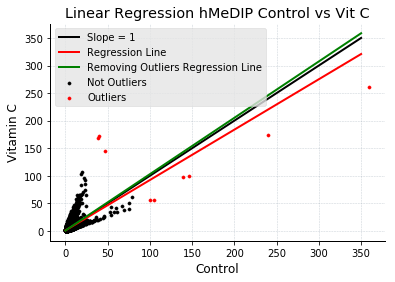

In [28]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = ARPE_hMeDIP_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = ARPE_hMeDIP_outliers["VitC_Average"], x = ARPE_hMeDIP_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 350, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 350, 10)
y = parameters[0] + parameters[1]*x

outliers_removed_model
outlier_parameters = outliers_removed_model.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()
#plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png")

In [29]:
ARPE_hMeDIP_outliers

Control_Average  \
Peak_Name                                                             
ARPE19.Control.peak_270708                               239.895165   
ARPE19.Control.peak_270862                               100.637830   
ARPE19.Control.peak_270867,ARPE19.VitC.peak_240...       359.854007   
ARPE19.Control.peak_474371                               146.176601   
ARPE19.Control.peak_474377,ARPE19.VitC.peak_418...       138.925434   
ARPE19.Control.peak_51009                                104.848888   
ARPE19.VitC.peak_113252,ARPE19.Control.peak_128...        39.970491   
ARPE19.VitC.peak_249944,ARPE19.Control.peak_280...        38.139755   
ARPE19.VitC.peak_249949,ARPE19.Control.peak_280...        46.788909   

                                                    VitC_Average  Cook_Value  \
Peak_Name                                                                      
ARPE19.Control.peak_270708                            173.595211   22.258741   
ARPE19.Control.peak_270862                             56.921163    1.943017   
ARPE19.Control.peak_270867,ARPE19.VitC.peak_240...    261.200986  144.841177   
ARPE19.Control.peak_474371                            100.049963    3.946745   
ARPE19.Control.peak_474377,ARPE19.VitC.peak_418...     98.594811    2.554068   
ARPE19.Control.peak_51009                              56.516194    2.648367   
ARPE19.VitC.peak_113252,ARPE19.Control.peak_128...    172.713601    4.033975   
ARPE19.VitC.peak_249944,ARPE19.Control.peak_280...    168.780620    3.537207   
ARPE19.VitC.peak_249949,ARPE19.Control.peak_280...    144.135963    3.087665   

                                                    Cook_P_Value  
Peak_Name                                                         
ARPE19.Control.peak_270708                          2.160615e-10  
ARPE19.Control.peak_270862                          1.432746e-01  
ARPE19.Control.peak_270867,ARPE19.VitC.peak_240...  1.434095e-63  
ARPE19.Control.peak_474371                          1.931947e-02  
ARPE19.Control.peak_474377,ARPE19.VitC.peak_418...  7.776801e-02  
ARPE19.Control.peak_51009                           7.076996e-02  
ARPE19.VitC.peak_113252,ARPE19.Control.peak_128...  1.770573e-02  
ARPE19.VitC.peak_249944,ARPE19.Control.peak_280...  2.909689e-02  
ARPE19.VitC.peak_249949,ARPE19.Control.peak_280...  4.561123e-02

In [30]:
remove_outliers = ARPE_hMeDIP_raw.drop(ARPE_hMeDIP_outliers.index, axis = 0)
total_counts_removing_outliers = remove_outliers.sum(axis=0)

In [31]:
total_counts_removing_outliers

ARPE19_Control_1_IP               7.218338e+07
ARPE19_Control_2_IP               7.816636e+07
ARPE19_LAA_1_IP                   5.855818e+07
ARPE19_LAA_2_IP                   6.731683e+07
ARPE19_Control_1_IP_First_RCPM    9.987482e+05
ARPE19_Control_2_IP_First_RCPM    9.988213e+05
ARPE19_LAA_1_IP_First_RCPM        9.988016e+05
ARPE19_LAA_2_IP_First_RCPM        9.987334e+05
Control_Average                   9.987848e+05
VitC_Average                      9.987675e+05
dtype: float64

In [32]:
# LAA means Vitamin C. I am changing the name out for VitC because more people will recognize it
ARPE_hMeDIP_raw["Control_1_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_Control_1_IP"]*1000000/total_counts_removing_outliers[0]
ARPE_hMeDIP_raw["Control_2_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_Control_2_IP"]*1000000/total_counts_removing_outliers[1]
ARPE_hMeDIP_raw["VitC_1_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_LAA_1_IP"]*1000000/total_counts_removing_outliers[2]
ARPE_hMeDIP_raw["VitC_2_Corrected_RCPM"]= ARPE_hMeDIP_raw["ARPE19_LAA_2_IP"]*1000000/total_counts_removing_outliers[3]


In [33]:
ARPE_hMeDIP_Corrected_RCPM = ARPE_hMeDIP_raw[["Control_1_Corrected_RCPM", "Control_2_Corrected_RCPM", "VitC_1_Corrected_RCPM", "VitC_2_Corrected_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [34]:
len(ARPE_hMeDIP_Corrected_RCPM)

150899

In [35]:
ARPE_hMeDIP_Corrected_RCPM.head()

Control_1_Corrected_RCPM  \
Peak_Name                                              
ARPE19.Control.peak_10                      2.271991   
ARPE19.Control.peak_100033                  1.052874   
ARPE19.Control.peak_10005                   2.479795   
ARPE19.Control.peak_100056                  1.108288   
ARPE19.Control.peak_10006                   1.496189   

                            Control_2_Corrected_RCPM  VitC_1_Corrected_RCPM  \
Peak_Name                                                                     
ARPE19.Control.peak_10                      2.098089               1.793089   
ARPE19.Control.peak_100033                  1.189770               0.939237   
ARPE19.Control.peak_10005                   2.136469               1.690626   
ARPE19.Control.peak_100056                  1.343289               1.127084   
ARPE19.Control.peak_10006                   1.432842               1.161238   

                            VitC_2_Corrected_RCPM  
Peak_Name                                          
ARPE19.Control.peak_10                   1.025004  
ARPE19.Control.peak_100033               0.564495  
ARPE19.Control.peak_10005                0.460509  
ARPE19.Control.peak_100056               0.846742  
ARPE19.Control.peak_10006                0.460509

In [36]:
ARPE_hMeDIP_Corrected_RCPM.to_csv(Output_Path+"ARPE_hMeDIP_RCPM_table.csv")

Now I officially have excluded outliers from the normalization and made the read counts per million. The next step is to divide by length and multiply by 1000 to get "Fragments per Kilobase per Million", also known as FPKM. 
I have the bed file that has the info about peak length for this.

In [37]:
ARPE_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, names=["Chromosome", "Start", "Stop", "Peak_Name"], dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})

In [38]:
len(ARPE_hMeDIP_bed)

150899

In [39]:
ARPE_hMeDIP_bed["Width"] = (ARPE_hMeDIP_bed["Stop"] - ARPE_hMeDIP_bed["Start"] + 1)

In [40]:
ARPE_hMeDIP_bed.dtypes

Chromosome    object
Start          int64
Stop           int64
Width          int64
dtype: object

In [41]:
ARPE_hMeDIP_bed.head()

Chromosome   Start    Stop  Width
Peak_Name                                               
ARPE19.Control.peak_6           1  629048  629473    426
ARPE19.Control.peak_7           1  630028  630831    804
ARPE19.Control.peak_8           1  631355  631872    518
ARPE19.Control.peak_10          1  633524  633939    416
ARPE19.VitC.peak_14             1  790268  791584   1317

In [42]:
ARPE_hMeDIP_Corrected_RCPM.head()

Control_1_Corrected_RCPM  \
Peak_Name                                              
ARPE19.Control.peak_10                      2.271991   
ARPE19.Control.peak_100033                  1.052874   
ARPE19.Control.peak_10005                   2.479795   
ARPE19.Control.peak_100056                  1.108288   
ARPE19.Control.peak_10006                   1.496189   

                            Control_2_Corrected_RCPM  VitC_1_Corrected_RCPM  \
Peak_Name                                                                     
ARPE19.Control.peak_10                      2.098089               1.793089   
ARPE19.Control.peak_100033                  1.189770               0.939237   
ARPE19.Control.peak_10005                   2.136469               1.690626   
ARPE19.Control.peak_100056                  1.343289               1.127084   
ARPE19.Control.peak_10006                   1.432842               1.161238   

                            VitC_2_Corrected_RCPM  
Peak_Name                                          
ARPE19.Control.peak_10                   1.025004  
ARPE19.Control.peak_100033               0.564495  
ARPE19.Control.peak_10005                0.460509  
ARPE19.Control.peak_100056               0.846742  
ARPE19.Control.peak_10006                0.460509

In [43]:
ARPE_hMeDIP_Corrected_RCPM = ARPE_hMeDIP_Corrected_RCPM.join(ARPE_hMeDIP_bed)

In [44]:
ARPE_hMeDIP_Corrected_RCPM.head()

Control_1_Corrected_RCPM  \
Peak_Name                                              
ARPE19.Control.peak_10                      2.271991   
ARPE19.Control.peak_100033                  1.052874   
ARPE19.Control.peak_10005                   2.479795   
ARPE19.Control.peak_100056                  1.108288   
ARPE19.Control.peak_10006                   1.496189   

                            Control_2_Corrected_RCPM  VitC_1_Corrected_RCPM  \
Peak_Name                                                                     
ARPE19.Control.peak_10                      2.098089               1.793089   
ARPE19.Control.peak_100033                  1.189770               0.939237   
ARPE19.Control.peak_10005                   2.136469               1.690626   
ARPE19.Control.peak_100056                  1.343289               1.127084   
ARPE19.Control.peak_10006                   1.432842               1.161238   

                            VitC_2_Corrected_RCPM Chromosome     Start  \
Peak_Name                                                                
ARPE19.Control.peak_10                   1.025004          1    633524   
ARPE19.Control.peak_100033               0.564495         12  53077462   
ARPE19.Control.peak_10005                0.460509          1  37724034   
ARPE19.Control.peak_100056               0.846742         12  53128998   
ARPE19.Control.peak_10006                0.460509          1  37725328   

                                Stop  Width  
Peak_Name                                    
ARPE19.Control.peak_10        633939    416  
ARPE19.Control.peak_100033  53078125    664  
ARPE19.Control.peak_10005   37725151   1118  
ARPE19.Control.peak_100056  53129677    680  
ARPE19.Control.peak_10006   37725950    623

In [45]:
ARPE_hMeDIP_Corrected_RCPM["Control_1_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["Control_1_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]
ARPE_hMeDIP_Corrected_RCPM["Control_2_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["Control_2_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]
ARPE_hMeDIP_Corrected_RCPM["VitC_1_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["VitC_1_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]
ARPE_hMeDIP_Corrected_RCPM["VitC_2_FPKM"]= ARPE_hMeDIP_Corrected_RCPM["VitC_2_Corrected_RCPM"]*1000/ARPE_hMeDIP_Corrected_RCPM["Width"]


In [46]:
ARPE_hMeDIP_Corrected_RCPM.head()

Control_1_Corrected_RCPM  \
Peak_Name                                              
ARPE19.Control.peak_10                      2.271991   
ARPE19.Control.peak_100033                  1.052874   
ARPE19.Control.peak_10005                   2.479795   
ARPE19.Control.peak_100056                  1.108288   
ARPE19.Control.peak_10006                   1.496189   

                            Control_2_Corrected_RCPM  VitC_1_Corrected_RCPM  \
Peak_Name                                                                     
ARPE19.Control.peak_10                      2.098089               1.793089   
ARPE19.Control.peak_100033                  1.189770               0.939237   
ARPE19.Control.peak_10005                   2.136469               1.690626   
ARPE19.Control.peak_100056                  1.343289               1.127084   
ARPE19.Control.peak_10006                   1.432842               1.161238   

                            VitC_2_Corrected_RCPM Chromosome     Start  \
Peak_Name                                                                
ARPE19.Control.peak_10                   1.025004          1    633524   
ARPE19.Control.peak_100033               0.564495         12  53077462   
ARPE19.Control.peak_10005                0.460509          1  37724034   
ARPE19.Control.peak_100056               0.846742         12  53128998   
ARPE19.Control.peak_10006                0.460509          1  37725328   

                                Stop  Width  Control_1_FPKM  Control_2_FPKM  \
Peak_Name                                                                     
ARPE19.Control.peak_10        633939    416        5.461517        5.043484   
ARPE19.Control.peak_100033  53078125    664        1.585653        1.791823   
ARPE19.Control.peak_10005   37725151   1118        2.218064        1.910974   
ARPE19.Control.peak_100056  53129677    680        1.629836        1.975425   
ARPE19.Control.peak_10006   37725950    623        2.401588        2.299906   

                            VitC_1_FPKM  VitC_2_FPKM  
Peak_Name                                             
ARPE19.Control.peak_10         4.310309     2.463951  
ARPE19.Control.peak_100033     1.414513     0.850143  
ARPE19.Control.peak_10005      1.512188     0.411904  
ARPE19.Control.peak_100056     1.657477     1.245209  
ARPE19.Control.peak_10006      1.863946     0.739180

In [47]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_Corrected_RCPM[["Control_1_FPKM", "Control_2_FPKM", "VitC_1_FPKM", "VitC_2_FPKM"]]

In [48]:
ARPE_hMeDIP_FPKM_table.to_csv(Output_Path+"ARPE_hMeDIP_FPKM_table.csv")
ARPE_hMeDIP_FPKM_table.to_pickle(Output_Path+"ARPE_hMeDIP_FPKM_table.pkl")

Now I have the FPKM values calculated correctly. Next I need to figure out which ones go up, which ones go down, and which ones don't change. I am going to use a fold change cutoff of 1.5X and a corrected P-value from edgeR cutoff of 0.05. 

In [49]:
ARPE_hMeDIP_FPKM_table = pd.read_pickle(Output_Path+"ARPE_hMeDIP_FPKM_table.pkl")

In [50]:
ARPE_hMeDIP_FPKM_table["Control_Average_FPKM"] = ARPE_hMeDIP_FPKM_table[["Control_1_FPKM", "Control_2_FPKM"]].mean(axis=1)
ARPE_hMeDIP_FPKM_table["VitC_Average_FPKM"] = ARPE_hMeDIP_FPKM_table[["VitC_1_FPKM", "VitC_2_FPKM"]].mean(axis=1)
ARPE_hMeDIP_FPKM_table["Fold_Change"] =  (ARPE_hMeDIP_FPKM_table["VitC_Average_FPKM"])/(ARPE_hMeDIP_FPKM_table["Control_Average_FPKM"])
ARPE_hMeDIP_FPKM_table["Log2FC"] = np.log2(ARPE_hMeDIP_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [51]:
ARPE_hMeDIP_FPKM_table.tail()

Control_1_FPKM  \
Peak_Name                                                           
ARPE19.VitC.peak_99985                                   0.898731   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631        1.976472   
ARPE19.VitC.peak_99988                                   0.992986   
ARPE19.VitC.peak_99990                                   1.041791   
ARPE19.VitC.peak_99994                                   0.851594   

                                                   Control_2_FPKM  \
Peak_Name                                                           
ARPE19.VitC.peak_99985                                   1.072850   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631        1.622391   
ARPE19.VitC.peak_99988                                   0.916982   
ARPE19.VitC.peak_99990                                   0.695952   
ARPE19.VitC.peak_99994                                   0.814498   

                                                   VitC_1_FPKM  VitC_2_FPKM  \
Peak_Name                                                                     
ARPE19.VitC.peak_99985                                1.594217     2.914613   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631     3.631972     6.259954   
ARPE19.VitC.peak_99988                                2.745160     4.465841   
ARPE19.VitC.peak_99990                                2.459093     4.943786   
ARPE19.VitC.peak_99994                                2.174463     3.783083   

                                                   Control_Average_FPKM  \
Peak_Name                                                                 
ARPE19.VitC.peak_99985                                         0.985790   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631              1.799431   
ARPE19.VitC.peak_99988                                         0.954984   
ARPE19.VitC.peak_99990                                         0.868871   
ARPE19.VitC.peak_99994                                         0.833046   

                                                   VitC_Average_FPKM  \
Peak_Name                                                              
ARPE19.VitC.peak_99985                                      2.254415   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631           4.945963   
ARPE19.VitC.peak_99988                                      3.605501   
ARPE19.VitC.peak_99990                                      3.701439   
ARPE19.VitC.peak_99994                                      2.978773   

                                                   Fold_Change    Log2FC  
Peak_Name                                                                 
ARPE19.VitC.peak_99985                                2.286912  1.193401  
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631     2.748625  1.458710  
ARPE19.VitC.peak_99988                                3.775457  1.916651  
ARPE19.VitC.peak_99990                                4.260055  2.090872  
ARPE19.VitC.peak_99994                                3.575763  1.838251

In [52]:
ARPE_hMeDIP_edgeR = pd.read_csv(Input_hMeDIP_edgeR, sep = ",", index_col=0)


In [53]:
ARPE_hMeDIP_edgeR.head()

logFC    logCPM         LR        PValue       FDR
Feature                                                                       
ARPE19.VitC.peak_246232 -3.161988  2.436264  44.839863  2.140000e-11  0.000003
ARPE19.VitC.peak_286485 -3.945334  0.419847  42.618735  6.650000e-11  0.000003
ARPE19.VitC.peak_401356 -3.194091  1.826464  42.398974  7.440000e-11  0.000003
ARPE19.VitC.peak_113284 -3.169597  2.589791  42.041794  8.930000e-11  0.000003
ARPE19.VitC.peak_106755 -3.269852  1.515476  41.837537  9.920000e-11  0.000003

In [54]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_FPKM_table.join(ARPE_hMeDIP_edgeR)

In [55]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_FPKM_table.drop(["logFC", "logCPM", "LR", "PValue"], axis = 1)

In [56]:
# There has to be a faster way to do this than looping through the whole thing manually, 
# but this is the only way I know how to do it.
list_of_conditions = []
i = 0
while i < len(ARPE_hMeDIP_FPKM_table):
    if ARPE_hMeDIP_FPKM_table["FDR"][i] < 0.05:
        if ARPE_hMeDIP_FPKM_table["Log2FC"][i] >= 0.584962500721156:
            list_of_conditions.append("Upregulated")
            i += 1
        elif ARPE_hMeDIP_FPKM_table["Log2FC"][i] <= -0.584962500721156:
            list_of_conditions.append("Downregulated")
            i += 1
        else:
            list_of_conditions.append("Nondifferential")
            i += 1
    else:
        list_of_conditions.append("Nondifferential")
        i += 1
    
        

In [57]:
ARPE_hMeDIP_FPKM_table["Change"] = list_of_conditions

In [58]:
ARPE_hMeDIP_FPKM_table.head(12)

Control_1_FPKM  \
Peak_Name                                                            
ARPE19.Control.peak_10                                    5.461517   
ARPE19.Control.peak_100033                                1.585653   
ARPE19.Control.peak_10005                                 2.218064   
ARPE19.Control.peak_100056                                1.629836   
ARPE19.Control.peak_10006                                 2.401588   
ARPE19.Control.peak_10007                                 3.353452   
ARPE19.Control.peak_100074,ARPE19.VitC.peak_88733         1.474651   
ARPE19.Control.peak_100079                                3.955726   
ARPE19.Control.peak_100081                                2.483955   
ARPE19.Control.peak_100084                                2.022204   
ARPE19.Control.peak_100086,ARPE19.VitC.peak_887...        1.684090   
ARPE19.Control.peak_100091                                2.776628   

                                                    Control_2_FPKM  \
Peak_Name                                                            
ARPE19.Control.peak_10                                    5.043484   
ARPE19.Control.peak_100033                                1.791823   
ARPE19.Control.peak_10005                                 1.910974   
ARPE19.Control.peak_100056                                1.975425   
ARPE19.Control.peak_10006                                 2.299906   
ARPE19.Control.peak_10007                                 3.046007   
ARPE19.Control.peak_100074,ARPE19.VitC.peak_88733         1.465891   
ARPE19.Control.peak_100079                                3.811085   
ARPE19.Control.peak_100081                                2.517618   
ARPE19.Control.peak_100084                                2.452732   
ARPE19.Control.peak_100086,ARPE19.VitC.peak_887...        1.524153   
ARPE19.Control.peak_100091                                2.373157   

                                                    VitC_1_FPKM  VitC_2_FPKM  \
Peak_Name                                                                      
ARPE19.Control.peak_10                                 4.310309     2.463951   
ARPE19.Control.peak_100033                             1.414513     0.850143   
ARPE19.Control.peak_10005                              1.512188     0.411904   
ARPE19.Control.peak_100056                             1.657477     1.245209   
ARPE19.Control.peak_10006                              1.863946     0.739180   
ARPE19.Control.peak_10007                              2.078158     0.668088   
ARPE19.Control.peak_100074,ARPE19.VitC.peak_88733      1.984538     3.060968   
ARPE19.Control.peak_100079                             1.857576     1.120102   
ARPE19.Control.peak_100081                             2.265321     1.602448   
ARPE19.Control.peak_100084                             1.823039     2.006575   
ARPE19.Control.peak_100086,ARPE19.VitC.peak_887...     2.457988     3.992065   
ARPE19.Control.peak_100091                             1.711345     1.045243   

                                                    Control_Average_FPKM  \
Peak_Name                                                                  
ARPE19.Control.peak_10                                          5.252500   
ARPE19.Control.peak_100033                                      1.688738   
ARPE19.Control.peak_10005                                       2.064519   
ARPE19.Control.peak_100056                                      1.802630   
ARPE19.Control.peak_10006                                       2.350747   
ARPE19.Control.peak_10007                                       3.199729   
ARPE19.Control.peak_100074,ARPE19.VitC.peak_88733               1.470271   
ARPE19.Control.peak_100079                                      3.883406   
ARPE19.Control.peak_100081                                      2.500786   
ARPE19.Control.peak_100084                                      2.237468   
ARPE19.Control.peak_100086,ARPE19.VitC.peak_887...       

Now I need to read in the region_analysis to put each peak with a gene or region of a gene

In [59]:
ARPE_region_analysis = pd.read_csv(Input_region_analysis, sep = "\t", index_col=3)

In [60]:
dave_region = []
i = 0
while i < len(ARPE_region_analysis):
    if ARPE_region_analysis["Distance from TSS"][i] >= -3000 and ARPE_region_analysis["Distance from TSS"][i] < -250:
        dave_region.append("Upstream_Promoter")
        i += 1
    elif ARPE_region_analysis["Distance from TSS"][i] >= -250 and ARPE_region_analysis["Distance from TSS"][i] <= 250:
        dave_region.append("TSS")
        i += 1
    elif ARPE_region_analysis["Distance from TSS"][i] > 250 and ARPE_region_analysis["Distance from TSS"][i] <= 3000:
        dave_region.append("Downstream_Promoter")
        i += 1
    elif ARPE_region_analysis["Distance from TSS"][i] > 3000:
        dave_region.append("Gene_Body")
        i += 1
    else:
        dave_region.append("Intergenic")
        i += 1

In [61]:
ARPE_region_analysis["Gene_Region"] = dave_region

In [62]:
ARPE_region_analysis_cleaned = ARPE_region_analysis[["Gene ID", "Gene_Region", "Distance from TSS"]]

In [63]:
ARPE_region_analysis_cleaned.head()

Gene ID        Gene_Region  \
Name                                                             
ARPE19.Control.peak_100056  ENSG00000258074  Upstream_Promoter   
ARPE19.Control.peak_100107  ENSG00000283536  Upstream_Promoter   
ARPE19.Control.peak_100232              NaN         Intergenic   
ARPE19.Control.peak_100239              NaN         Intergenic   
ARPE19.Control.peak_100241              NaN         Intergenic   

                            Distance from TSS  
Name                                           
ARPE19.Control.peak_100056            -2013.0  
ARPE19.Control.peak_100107             -394.0  
ARPE19.Control.peak_100232                NaN  
ARPE19.Control.peak_100239                NaN  
ARPE19.Control.peak_100241                NaN

In [64]:
ARPE_hMeDIP_FPKM_table = ARPE_hMeDIP_FPKM_table.join(ARPE_region_analysis_cleaned)

In [65]:
ARPE_hMeDIP_FPKM_table.head()

Control_1_FPKM  Control_2_FPKM  VitC_1_FPKM  \
Peak_Name                                                                 
ARPE19.Control.peak_10            5.461517        5.043484     4.310309   
ARPE19.Control.peak_100033        1.585653        1.791823     1.414513   
ARPE19.Control.peak_10005         2.218064        1.910974     1.512188   
ARPE19.Control.peak_100056        1.629836        1.975425     1.657477   
ARPE19.Control.peak_10006         2.401588        2.299906     1.863946   

                            VitC_2_FPKM  Control_Average_FPKM  \
Peak_Name                                                       
ARPE19.Control.peak_10         2.463951              5.252500   
ARPE19.Control.peak_100033     0.850143              1.688738   
ARPE19.Control.peak_10005      0.411904              2.064519   
ARPE19.Control.peak_100056     1.245209              1.802630   
ARPE19.Control.peak_10006      0.739180              2.350747   

                            VitC_Average_FPKM  Fold_Change    Log2FC  \
Peak_Name                                                              
ARPE19.Control.peak_10               3.387130     0.644861 -0.632941   
ARPE19.Control.peak_100033           1.132328     0.670517 -0.576654   
ARPE19.Control.peak_10005            0.962046     0.465991 -1.101628   
ARPE19.Control.peak_100056           1.451343     0.805125 -0.312715   
ARPE19.Control.peak_10006            1.301563     0.553681 -0.852874   

                                 FDR           Change          Gene ID  \
Peak_Name                                                                
ARPE19.Control.peak_10      0.206001  Nondifferential  ENSG00000278791   
ARPE19.Control.peak_100033  0.309121  Nondifferential  ENSG00000167778   
ARPE19.Control.peak_10005   0.086925  Nondifferential  ENSG00000183317   
ARPE19.Control.peak_100056  0.555010  Nondifferential  ENSG00000258074   
ARPE19.Control.peak_10006   0.155778  Nondifferential  ENSG00000183317   

                                    Gene_Region  Distance from TSS  
Peak_Name                                                           
ARPE19.Control.peak_10        Upstream_Promoter            -1318.0  
ARPE19.Control.peak_100033  Downstream_Promoter             1584.0  
ARPE19.Control.peak_10005     Upstream_Promoter            -2735.0  
ARPE19.Control.peak_100056    Upstream_Promoter            -2013.0  
ARPE19.Control.peak_10006             Gene_Body             5855.0

Now I have to figure out how to sum the counts per gene for both location and change

In [66]:
cleanup = ARPE_hMeDIP_FPKM_table[["Change", "Gene ID", "Gene_Region"]]

In [67]:
summed_counts = pd.DataFrame(cleanup.groupby(["Gene ID", "Gene_Region", "Change"], as_index = False).size().unstack().unstack())

In [68]:
summed_counts.tail()

Change          Downregulated                                                  \
Gene_Region               TSS Downstream_Promoter Gene_Body Upstream_Promoter   
Gene ID                                                                         
ENSG00000284513           NaN                 NaN       NaN               NaN   
ENSG00000284516           NaN                 NaN       NaN               NaN   
ENSG00000284523           NaN                 NaN       NaN               NaN   
ENSG00000284543           NaN                 NaN       NaN               NaN   
ENSG00000284572           NaN                 1.0       NaN               1.0   

Change          Nondifferential                                \
Gene_Region                 TSS Downstream_Promoter Gene_Body   
Gene ID                                                         
ENSG00000284513             NaN                 NaN       NaN   
ENSG00000284516             NaN                 NaN       2.0   
ENSG00000284523             NaN                 NaN       2.0   
ENSG00000284543             1.0                 NaN       1.0   
ENSG00000284572             NaN                 NaN       NaN   

Change                            Upregulated                                \
Gene_Region     Upstream_Promoter         TSS Downstream_Promoter Gene_Body   
Gene ID                                                                       
ENSG00000284513               1.0         NaN                 NaN       NaN   
ENSG00000284516               1.0         NaN                 NaN       NaN   
ENSG00000284523               NaN         NaN                 NaN       NaN   
ENSG00000284543               2.0         NaN                 NaN       2.0   
ENSG00000284572               NaN         NaN                 NaN       NaN   

Change                             
Gene_Region     Upstream_Promoter  
Gene ID                            
ENSG00000284513               NaN  
ENSG00000284516               NaN  
ENSG00000284523               NaN  
ENSG00000284543               NaN  
ENSG00000284572               NaN

In [69]:
summed_counts.columns = [ "TSS_Downregulated", "Downstream_Promoter_Downregulated", 
               "Gene_Body_Downregulated", "Upstream_Promoter_Downregulated",
              "TSS_Nondifferential", "Downstream_Promoter_Nondifferential", "Gene_Body_Nondifferential",
              "Upstream_Promoter_Nondifferential", "TSS_Upregulated", "Downstream_Promoter_Upregulated",
              "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated"]

In [70]:
summed_counts = summed_counts.fillna(0)

In [71]:
summed_counts.head()

TSS_Downregulated  Downstream_Promoter_Downregulated  \
Gene ID                                                                 
ENSG00000000003                0.0                                0.0   
ENSG00000000005                0.0                                0.0   
ENSG00000000419                0.0                                0.0   
ENSG00000000457                0.0                                0.0   
ENSG00000000460                0.0                                0.0   

                 Gene_Body_Downregulated  Upstream_Promoter_Downregulated  \
Gene ID                                                                     
ENSG00000000003                      0.0                              0.0   
ENSG00000000005                      0.0                              0.0   
ENSG00000000419                      0.0                              0.0   
ENSG00000000457                      0.0                              0.0   
ENSG00000000460                      0.0                              0.0   

                 TSS_Nondifferential  Downstream_Promoter_Nondifferential  \
Gene ID                                                                     
ENSG00000000003                  1.0                                  0.0   
ENSG00000000005                  0.0                                  1.0   
ENSG00000000419                  0.0                                  0.0   
ENSG00000000457                  0.0                                  0.0   
ENSG00000000460                  0.0                                  0.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Gene ID                                                                         
ENSG00000000003                        0.0                                0.0   
ENSG00000000005                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Gene ID                                                             
ENSG00000000003              0.0                              0.0   
ENSG00000000005              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  
Gene ID                                                                
ENSG00000000003                    0.0                            0.0  
ENSG00000000005                    0.0                            0.0  
ENSG00000000419                    1.0                            0.0  
ENSG00000000457                    1.0                            0.0  
ENSG00000000460                    2.0                            0.0

In [72]:
summed_counts.to_csv(Output_Path+"ARPE_Counts_of_peaks_per_region.csv")
summed_counts.to_pickle(Output_Path+"ARPE_Counts_of_peaks_per_region.pkl")

### Moving on to the RNA-seq data
Now I have officially gotten the hMeDIP-seq info cleaned up (removed outliers) and normalized correctly, then converted it to FPKM using the width of the peaks (from the bed file). Next I was able to get the counts of peaks within each gene region for each annotated gene. 

The next step is to normalize the RNA-seq data similar to the way we did for the hMeDIP-seq, except removing the htseq-count lines before the first RCPM. This again requires finding outliers for correct normalization and using the length of each gene (exonic length, not total genomic length) to calculate the FPKM values. 

In [73]:
ARPE_Raw_RNA_data = pd.read_csv(Input_RNA_Counts_File, sep = "\t", index_col=0)

In [74]:
ARPE_Raw_RNA_data.head()

Control_01  Control_02  Control_03  VitC_01  VitC_02  VitC_03
Ensembl_ID                                                                    
ENSG00000000003        2341        2174        1862     2113     2658     2188
ENSG00000000005           0           0           3        1        0        0
ENSG00000000419        2161        1846        1407     2644     2607     2714
ENSG00000000457         779         666         517     1090     1218     1101
ENSG00000000460         302         294         200      462      569      487

In [75]:
# For this one I need to remove the HTSeq columns before I normalize because unmapped reads will interefere with RNA counts
ARPE_Raw_RNA_data = ARPE_Raw_RNA_data.drop(columns_added_by_htseq, axis = 0)

In [76]:
total_counts_ARPE_RNA_Raw = ARPE_Raw_RNA_data.sum(axis=0)

In [77]:
ARPE_Raw_RNA_data["Control_1_first_RCPM"] = ARPE_Raw_RNA_data["Control_01"]*1000000/total_counts_ARPE_RNA_Raw[0]
ARPE_Raw_RNA_data["Control_2_first_RCPM"] = ARPE_Raw_RNA_data["Control_02"]*1000000/total_counts_ARPE_RNA_Raw[1]
ARPE_Raw_RNA_data["Control_3_first_RCPM"] = ARPE_Raw_RNA_data["Control_03"]*1000000/total_counts_ARPE_RNA_Raw[2]
ARPE_Raw_RNA_data["VitC_1_first_RCPM"] = ARPE_Raw_RNA_data["VitC_01"]*1000000/total_counts_ARPE_RNA_Raw[3]
ARPE_Raw_RNA_data["VitC_2_first_RCPM"] = ARPE_Raw_RNA_data["VitC_02"]*1000000/total_counts_ARPE_RNA_Raw[4]
ARPE_Raw_RNA_data["VitC_3_first_RCPM"] = ARPE_Raw_RNA_data["VitC_03"]*1000000/total_counts_ARPE_RNA_Raw[5]
ARPE_Raw_RNA_data["Control_Average"] = ARPE_Raw_RNA_data[["Control_1_first_RCPM", "Control_2_first_RCPM", "Control_3_first_RCPM"]].mean(axis=1)
ARPE_Raw_RNA_data["VitC_Average"] = ARPE_Raw_RNA_data[["VitC_1_first_RCPM", "VitC_2_first_RCPM", "VitC_3_first_RCPM"]].mean(axis=1)


In [78]:
ARPE_Raw_RNA_data.head()

Control_01  Control_02  Control_03  VitC_01  VitC_02  \
Ensembl_ID                                                              
ENSG00000000003        2341        2174        1862     2113     2658   
ENSG00000000005           0           0           3        1        0   
ENSG00000000419        2161        1846        1407     2644     2607   
ENSG00000000457         779         666         517     1090     1218   
ENSG00000000460         302         294         200      462      569   

                 VitC_03  Control_1_first_RCPM  Control_2_first_RCPM  \
Ensembl_ID                                                             
ENSG00000000003     2188             73.451970             81.428143   
ENSG00000000005        0              0.000000              0.000000   
ENSG00000000419     2714             67.804232             69.142756   
ENSG00000000457     1101             24.442155             24.945328   
ENSG00000000460      487              9.475649             11.011902   

                 Control_3_first_RCPM  VitC_1_first_RCPM  VitC_2_first_RCPM  \
Ensembl_ID                                                                    
ENSG00000000003             82.692360          48.785919          57.393791   
ENSG00000000005              0.133232           0.023088           0.000000   
ENSG00000000419             62.485580          61.045892          56.292555   
ENSG00000000457             22.960231          25.166423          26.300089   
ENSG00000000460              8.882101          10.666869          12.286331   

                 VitC_3_first_RCPM  Control_Average  VitC_Average  
Ensembl_ID                                                         
ENSG00000000003          46.314531        79.190824     50.831413  
ENSG00000000005           0.000000         0.044411      0.007696  
ENSG00000000419          57.448646        66.477523     58.262364  
ENSG00000000457          23.305438        24.115905     24.923983  
ENSG00000000460          10.308582         9.789884     11.087260

In [79]:
ARPE_RNA_first_RCPM_averages = ARPE_Raw_RNA_data[["Control_Average","VitC_Average" ]]

In [80]:
ARPE_RNA_first_RCPM_averages.head()

Control_Average  VitC_Average
Ensembl_ID                                    
ENSG00000000003        79.190824     50.831413
ENSG00000000005         0.044411      0.007696
ENSG00000000419        66.477523     58.262364
ENSG00000000457        24.115905     24.923983
ENSG00000000460         9.789884     11.087260

In [81]:
ARPE_RNA_first_RCPM_averages.describe()

Control_Average  VitC_Average
count     58302.000000  58302.000000
mean         17.152070     17.152070
std         174.253684    159.487316
min           0.000000      0.000000
25%           0.000000      0.000000
50%           0.014804      0.007696
75%           0.754794      0.720653
max       24771.026905  19213.144253

In [82]:
ARPE_RNA_first_RCPM_averages.quantile([0.7, 0.75, 0.8, 0.9, 0.95])

Control_Average  VitC_Average
0.70         0.280497      0.224778
0.75         0.754794      0.720653
0.80         2.669311      3.092747
0.90        26.750672     30.463031
0.95        73.355588     77.819200

Well, this describe function wasn't as useful as I had hoped it would be. I forgot that the human genome has many annotated transcripts that are only coding in one or two cell types and only during some points of development, so almost half of these have an average value of 0 for both control and vitamin C. 
<br>When I look at quantiles closer to 1 I get something useful. The 70% and 75%look quite close, which is a good sign that they aren't completely different like cells from another tissue or a different animal type. The lower percentiles have lower values in Vitamin C and the higher percentiles have lower values in Control, but the standard deviation is larger for control than Vit C. I am not quite sure what to think of that.

Anyways, the next step is to identify outliers and re-normalize without those ones.

In [83]:
linear_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_RNA_first_RCPM_averages).fit()
linear_model_RNA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 3.196e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:51:12   Log-Likelihood:            -3.2395e+05
No. Observations:               58302   AIC:                         6.479e+05
Df Residuals:                   58300   BIC:                         6.479e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7151      0.261     10.415      0.000       2.204       3.226
Control_Average     0.8417      0.001    565.339      0.000       0.839       0.845
==============================================================================
Omnibus:                   159355.920   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     146749020512.351
Skew:                          32.758   Prob(JB):                         0.00
Kurtosis:                    7775.059   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
influence_RNA = linear_model_RNA.get_influence()
(cook,p_cook) = influence_RNA.cooks_distance
ARPE_RNA_first_RCPM_averages["Cook_Value"] = cook
ARPE_RNA_first_RCPM_averages["Cook_P_Value"] = p_cook

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [85]:
ARPE_RNA_first_RCPM_averages.head()

Control_Average  VitC_Average    Cook_Value  Cook_P_Value
Ensembl_ID                                                                
ENSG00000000003        79.190824     50.831413  8.463777e-07      0.999999
ENSG00000000005         0.044411      0.007696  1.662407e-08      1.000000
ENSG00000000419        66.477523     58.262364  3.914203e-10      1.000000
ENSG00000000457        24.115905     24.923983  7.989313e-09      1.000000
ENSG00000000460         9.789884     11.087260  3.813775e-11      1.000000

In [86]:
ARPE_RNA_removing_outliers = ARPE_RNA_first_RCPM_averages[ARPE_RNA_first_RCPM_averages.Cook_Value <= 1]
ARPE_RNA_outliers = ARPE_RNA_first_RCPM_averages[ARPE_RNA_first_RCPM_averages.Cook_Value > 1]

In [87]:
ARPE_RNA_outliers

Control_Average  VitC_Average   Cook_Value   Cook_P_Value
Ensembl_ID                                                                
ENSG00000060718      5793.725818   2790.084590    10.900452   1.848752e-05
ENSG00000100345      2084.471641   4652.005763     2.608698   7.363895e-02
ENSG00000115414     12873.497403  19213.144253  1015.312136   0.000000e+00
ENSG00000120708     10618.959970   6162.278986    71.231158   1.266008e-31
ENSG00000137801     24771.026905  18824.616019   424.307089  1.132519e-183
ENSG00000140416      4057.067566   4637.622411     1.784667   1.678621e-01
ENSG00000146674     10234.537861   2562.511654   311.160730  3.808633e-135
ENSG00000150093      7085.456519   4614.072724     6.970176   9.402703e-04
ENSG00000163453      7582.533524   7094.135984     2.213780   1.092960e-01
ENSG00000166147      3552.985386   4298.601089     1.558943   2.103671e-01
ENSG00000166598      5355.160768   2335.041136    10.034457   4.393804e-05
ENSG00000251562      6144.073461   9773.349201    59.704708   1.250526e-26

In [88]:
outliers_removed_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=ARPE_RNA_removing_outliers).fit()
outliers_removed_model_RNA.summary()
# This one has a slightly higher R-squared value. 
# Now I want to see what it looks like in the graph. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 3.658e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:51:12   Log-Likelihood:            -2.8739e+05
No. Observations:               58290   AIC:                         5.748e+05
Df Residuals:                   58288   BIC:                         5.748e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1508      0.141     15.306      0.000       1.875       2.426
Control_Average     0.8753      0.001    604.815      0.000       0.873       0.878
==============================================================================
Omnibus:                    98184.168   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2216520040.581
Skew:                          10.273   Prob(JB):                         0.00
Kurtosis:                     958.089   Cond. No.                         98.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

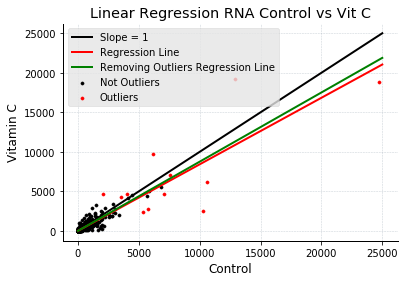

In [89]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = ARPE_RNA_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = ARPE_RNA_outliers["VitC_Average"], x = ARPE_RNA_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 25000, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression RNA Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model_RNA.params
x = sc.linspace(0, 25000, 10)
y = parameters[0] + parameters[1]*x


outlier_parameters = outliers_removed_model_RNA.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"ARPE_RNA_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


I was surprised to find that removing the outliers didn't shift it that much closer to a slope of 1. 

In [90]:
print(len(ARPE_RNA_removing_outliers))
print(len(ARPE_Raw_RNA_data))
# Difference of 12, which is the number of outliers

58290
58302


In [91]:
remove_outliers_RNA = ARPE_Raw_RNA_data.drop(ARPE_RNA_outliers.index, axis = 0)


In [92]:
total_counts_removing_outliers_RNA = remove_outliers_RNA.sum(axis=0)

In [93]:
total_counts_removing_outliers_RNA

Control_01              2.862680e+07
Control_02              2.412137e+07
Control_03              2.021727e+07
VitC_01                 3.962444e+07
VitC_02                 4.227887e+07
VitC_03                 4.305366e+07
Control_1_first_RCPM    8.982035e+05
Control_2_first_RCPM    9.034767e+05
Control_3_first_RCPM    8.978593e+05
VitC_1_first_RCPM       9.148672e+05
VitC_2_first_RCPM       9.129213e+05
VitC_3_first_RCPM       9.113391e+05
Control_Average         8.998465e+05
VitC_Average            9.130425e+05
dtype: float64

In [94]:
ARPE_Raw_RNA_data.head()

Control_01  Control_02  Control_03  VitC_01  VitC_02  \
Ensembl_ID                                                              
ENSG00000000003        2341        2174        1862     2113     2658   
ENSG00000000005           0           0           3        1        0   
ENSG00000000419        2161        1846        1407     2644     2607   
ENSG00000000457         779         666         517     1090     1218   
ENSG00000000460         302         294         200      462      569   

                 VitC_03  Control_1_first_RCPM  Control_2_first_RCPM  \
Ensembl_ID                                                             
ENSG00000000003     2188             73.451970             81.428143   
ENSG00000000005        0              0.000000              0.000000   
ENSG00000000419     2714             67.804232             69.142756   
ENSG00000000457     1101             24.442155             24.945328   
ENSG00000000460      487              9.475649             11.011902   

                 Control_3_first_RCPM  VitC_1_first_RCPM  VitC_2_first_RCPM  \
Ensembl_ID                                                                    
ENSG00000000003             82.692360          48.785919          57.393791   
ENSG00000000005              0.133232           0.023088           0.000000   
ENSG00000000419             62.485580          61.045892          56.292555   
ENSG00000000457             22.960231          25.166423          26.300089   
ENSG00000000460              8.882101          10.666869          12.286331   

                 VitC_3_first_RCPM  Control_Average  VitC_Average  
Ensembl_ID                                                         
ENSG00000000003          46.314531        79.190824     50.831413  
ENSG00000000005           0.000000         0.044411      0.007696  
ENSG00000000419          57.448646        66.477523     58.262364  
ENSG00000000457          23.305438        24.115905     24.923983  
ENSG00000000460          10.308582         9.789884     11.087260

In [95]:
ARPE_Raw_RNA_data["Control_1_RCPM"] = ARPE_Raw_RNA_data["Control_01"]*1000000/total_counts_removing_outliers_RNA[0]
ARPE_Raw_RNA_data["Control_2_RCPM"] = ARPE_Raw_RNA_data["Control_02"]*1000000/total_counts_removing_outliers_RNA[1]
ARPE_Raw_RNA_data["Control_3_RCPM"] = ARPE_Raw_RNA_data["Control_03"]*1000000/total_counts_removing_outliers_RNA[2]
ARPE_Raw_RNA_data["VitC_1_RCPM"] = ARPE_Raw_RNA_data["VitC_01"]*1000000/total_counts_removing_outliers_RNA[3]
ARPE_Raw_RNA_data["VitC_2_RCPM"] = ARPE_Raw_RNA_data["VitC_02"]*1000000/total_counts_removing_outliers_RNA[4]
ARPE_Raw_RNA_data["VitC_3_RCPM"] = ARPE_Raw_RNA_data["VitC_03"]*1000000/total_counts_removing_outliers_RNA[5]
ARPE_RNA_Corrected_RCPM = ARPE_Raw_RNA_data[["Control_1_RCPM", "Control_2_RCPM", "Control_3_RCPM", "VitC_1_RCPM", "VitC_2_RCPM", "VitC_3_RCPM"]]

In [96]:
ARPE_RNA_Corrected_RCPM.head()

Control_1_RCPM  Control_2_RCPM  Control_3_RCPM  VitC_1_RCPM  \
Ensembl_ID                                                                     
ENSG00000000003       81.776531       90.127551       92.099468    53.325681   
ENSG00000000005        0.000000        0.000000        0.148388     0.025237   
ENSG00000000419       75.488716       76.529650       69.593959    66.726503   
ENSG00000000457       27.212267       27.610372       25.572194    27.508279   
ENSG00000000460       10.549557       12.188362        9.892531    11.659472   

                 VitC_2_RCPM  VitC_3_RCPM  
Ensembl_ID                                 
ENSG00000000003    62.868281    50.820304  
ENSG00000000005     0.000000     0.000000  
ENSG00000000419    61.662005    63.037617  
ENSG00000000457    28.808716    25.572740  
ENSG00000000460    13.458259    11.311466

In [97]:
ARPE_RNA_Corrected_RCPM.to_csv(Output_Path+"ARPE_RNA_RCPM_table.csv")

In [98]:
Human_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )


In [99]:
Human_Genomic_Info_File.dtypes # It looks like I don't need to specify the types because the lengths and positions went in as float

Name                   object
Location               object
Sense                  object
Biotype                object
transcript_id          object
Chr                    object
Start                 float64
Stop                  float64
Length                float64
Exonic Length         float64
Intronic Length       float64
gene_id                object
gene_version          float64
transcript_version    float64
gene_name              object
gene_source            object
gene_biotype           object
transcript_name        object
transcript_source      object
transcript_biotype     object
dtype: object

In [100]:
Human_Genomic_Info_File.head()

Name                  Location Sense         Biotype  \
Gene_ID                                                                     
ENSG00000000003    TSPAN6  chrX:100627109-100639991     -  protein_coding   
ENSG00000000005      TNMD  chrX:100584802-100599885     +  protein_coding   
ENSG00000000419      DPM1   chr20:50934867-50958555     -  protein_coding   
ENSG00000000457     SCYL3  chr1:169849631-169894267     -  protein_coding   
ENSG00000000460  C1orf112  chr1:169662007-169854080     +  protein_coding   

                   transcript_id Chr        Start         Stop   Length  \
Gene_ID                                                                   
ENSG00000000003  ENST00000612152   X  100627109.0  100637104.0   9996.0   
ENSG00000000005  ENST00000373031   X  100584802.0  100599885.0  15084.0   
ENSG00000000419  ENST00000371582  20   50934867.0   50958555.0  23689.0   
ENSG00000000457  ENST00000367771   1  169849631.0  169893952.0  44322.0   
ENSG00000000460  ENST00000286031   1  169795409.0  169854080.0  58672.0   

                 Exonic Length  Intronic Length          gene_id  \
Gene_ID                                                            
ENSG00000000003         3796.0           6200.0  ENSG00000000003   
ENSG00000000005         1339.0          13745.0  ENSG00000000005   
ENSG00000000419         1161.0          22528.0  ENSG00000000419   
ENSG00000000457         6364.0          37958.0  ENSG00000000457   
ENSG00000000460         4355.0          54317.0  ENSG00000000460   

                 gene_version  transcript_version gene_name     gene_source  \
Gene_ID                                                                       
ENSG00000000003          14.0                 4.0    TSPAN6  ensembl_havana   
ENSG00000000005           5.0                 4.0      TNMD  ensembl_havana   
ENSG00000000419          12.0                 8.0      DPM1  ensembl_havana   
ENSG00000000457          13.0                10.0     SCYL3  ensembl_havana   
ENSG00000000460          16.0                10.0  C1orf112  ensembl_havana   

                   gene_biotype transcript_name transcript_source  \
Gene_ID                                                             
ENSG00000000003  protein_coding      TSPAN6-204           ensembl   
ENSG00000000005  protein_coding        TNMD-201    ensembl_havana   
ENSG00000000419  protein_coding        DPM1-201            havana   
ENSG00000000457  protein_coding       SCYL3-202    ensembl_havana   
ENSG00000000460  protein_coding    C1orf112-201    ensembl_havana   

                transcript_biotype  
Gene_ID                             
ENSG00000000003     protein_coding  
ENSG00000000005     protein_coding  
ENSG00000000419     protein_coding  
ENSG00000000457     protein_coding  
ENSG00000000460     protein_coding

In [101]:
ARPE_RNA_Corrected_RCPM = ARPE_RNA_Corrected_RCPM.join(Human_Genomic_Info_File)

In [102]:
ARPE_RNA_Corrected_RCPM.head()

Control_1_RCPM  Control_2_RCPM  Control_3_RCPM  VitC_1_RCPM  \
Ensembl_ID                                                                     
ENSG00000000003       81.776531       90.127551       92.099468    53.325681   
ENSG00000000005        0.000000        0.000000        0.148388     0.025237   
ENSG00000000419       75.488716       76.529650       69.593959    66.726503   
ENSG00000000457       27.212267       27.610372       25.572194    27.508279   
ENSG00000000460       10.549557       12.188362        9.892531    11.659472   

                 VitC_2_RCPM  VitC_3_RCPM      Name                  Location  \
Ensembl_ID                                                                      
ENSG00000000003    62.868281    50.820304    TSPAN6  chrX:100627109-100639991   
ENSG00000000005     0.000000     0.000000      TNMD  chrX:100584802-100599885   
ENSG00000000419    61.662005    63.037617      DPM1   chr20:50934867-50958555   
ENSG00000000457    28.808716    25.572740     SCYL3  chr1:169849631-169894267   
ENSG00000000460    13.458259    11.311466  C1orf112  chr1:169662007-169854080   

                Sense         Biotype         ...         Intronic Length  \
Ensembl_ID                                    ...                           
ENSG00000000003     -  protein_coding         ...                  6200.0   
ENSG00000000005     +  protein_coding         ...                 13745.0   
ENSG00000000419     -  protein_coding         ...                 22528.0   
ENSG00000000457     -  protein_coding         ...                 37958.0   
ENSG00000000460     +  protein_coding         ...                 54317.0   

                         gene_id  gene_version  transcript_version  gene_name  \
Ensembl_ID                                                                      
ENSG00000000003  ENSG00000000003          14.0                 4.0     TSPAN6   
ENSG00000000005  ENSG00000000005           5.0                 4.0       TNMD   
ENSG00000000419  ENSG00000000419          12.0                 8.0       DPM1   
ENSG00000000457  ENSG00000000457          13.0                10.0      SCYL3   
ENSG00000000460  ENSG00000000460          16.0                10.0   C1orf112   

                    gene_source    gene_biotype transcript_name  \
Ensembl_ID                                                        
ENSG00000000003  ensembl_havana  protein_coding      TSPAN6-204   
ENSG00000000005  ensembl_havana  protein_coding        TNMD-201   
ENSG00000000419  ensembl_havana  protein_coding        DPM1-201   
ENSG00000000457  ensembl_havana  protein_coding       SCYL3-202   
ENSG00000000460  ensembl_havana  protein_coding    C1orf112-201   

                 transcript_source  transcript_biotype  
Ensembl_ID                                              
ENSG00000000003            ensembl      protein_coding  
ENSG00000000005     ensembl_havana      protein_coding  
ENSG00000000419             havana      protein_coding  
ENSG00000000457     ensembl_havana      protein_coding  
ENSG00000000460     ensembl_havana      protein_coding  

[5 rows x 26 columns]

In [103]:
ARPE_RNA_Corrected_RCPM["Control_1_FPKM"]= ARPE_RNA_Corrected_RCPM["Control_1_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["Control_2_FPKM"]= ARPE_RNA_Corrected_RCPM["Control_2_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["Control_3_FPKM"]= ARPE_RNA_Corrected_RCPM["Control_3_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]

ARPE_RNA_Corrected_RCPM["VitC_1_FPKM"]= ARPE_RNA_Corrected_RCPM["VitC_1_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["VitC_2_FPKM"]= ARPE_RNA_Corrected_RCPM["VitC_2_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]
ARPE_RNA_Corrected_RCPM["VitC_3_FPKM"]= ARPE_RNA_Corrected_RCPM["VitC_3_RCPM"]*1000/ARPE_RNA_Corrected_RCPM["Exonic Length"]


In [104]:
#ARPE_RNA_Corrected_RCPM.head()
ARPE_RNA_FPKM_table = ARPE_RNA_Corrected_RCPM[["Control_1_FPKM", "Control_2_FPKM", "Control_3_FPKM", "VitC_1_FPKM", "VitC_2_FPKM", "VitC_3_FPKM"]]

In [105]:
ARPE_RNA_FPKM_table.head()

Control_1_FPKM  Control_2_FPKM  Control_3_FPKM  VitC_1_FPKM  \
Ensembl_ID                                                                     
ENSG00000000003       21.542816       23.742769       24.262241    14.047861   
ENSG00000000005        0.000000        0.000000        0.110820     0.018848   
ENSG00000000419       65.020427       65.917011       59.943117    57.473302   
ENSG00000000457        4.275969        4.338525        4.018258     4.322483   
ENSG00000000460        2.422401        2.798705        2.271534     2.677261   

                 VitC_2_FPKM  VitC_3_FPKM  
Ensembl_ID                                 
ENSG00000000003    16.561718    13.387857  
ENSG00000000005     0.000000     0.000000  
ENSG00000000419    53.111115    54.295966  
ENSG00000000457     4.526825     4.018344  
ENSG00000000460     3.090301     2.597352

Now I have the FPKM table for the RNA. Next I need to read in the statistical files (edgeR and DESeq2) and calculate fold changes to determine which direction each gene goes. When I did this for the hMeDIP, none of them had values of 0 so I didn't need to worry about dividing by infinity. For this one, I needed to make up a lambda function for an if statement if the values were below 0.1 for both VitC and Control.

In [106]:
ARPE_RNA_FPKM_table["Control_Average_FPKM"] = ARPE_RNA_FPKM_table[["Control_1_FPKM", "Control_2_FPKM", "Control_3_FPKM"]].mean(axis=1)
ARPE_RNA_FPKM_table["VitC_Average_FPKM"] = ARPE_RNA_FPKM_table[["VitC_1_FPKM", "VitC_2_FPKM", "VitC_3_FPKM"]].mean(axis=1)
#ARPE_RNA_FPKM_table["Fold_Change"] =  ARPE_RNA_FPKM_table.apply(lambda x: (x["VitC_Average_FPKM"]/x["Control_Average_FPKM"]) if min(x["VitC_Average_FPKM"],x["Control_Average_FPKM"]) > 0.1 else 1, axis = 1)
ARPE_RNA_FPKM_table["Fold_Change"] =  ARPE_RNA_FPKM_table.apply(lambda x: 1 if max(x["VitC_Average_FPKM"],x["Control_Average_FPKM"]) < 0.1 else (x["VitC_Average_FPKM"]/x["Control_Average_FPKM"]), axis = 1)


ARPE_RNA_FPKM_table["Log2FC"] = np.log2(ARPE_RNA_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: 

In [107]:
ARPE_RNA_FPKM_table.head()

Control_1_FPKM  Control_2_FPKM  Control_3_FPKM  VitC_1_FPKM  \
Ensembl_ID                                                                     
ENSG00000000003       21.542816       23.742769       24.262241    14.047861   
ENSG00000000005        0.000000        0.000000        0.110820     0.018848   
ENSG00000000419       65.020427       65.917011       59.943117    57.473302   
ENSG00000000457        4.275969        4.338525        4.018258     4.322483   
ENSG00000000460        2.422401        2.798705        2.271534     2.677261   

                 VitC_2_FPKM  VitC_3_FPKM  Control_Average_FPKM  \
Ensembl_ID                                                        
ENSG00000000003    16.561718    13.387857             23.182609   
ENSG00000000005     0.000000     0.000000              0.036940   
ENSG00000000419    53.111115    54.295966             63.626852   
ENSG00000000457     4.526825     4.018344              4.210917   
ENSG00000000460     3.090301     2.597352              2.497547   

                 VitC_Average_FPKM  Fold_Change    Log2FC  
Ensembl_ID                                                 
ENSG00000000003          14.665812     0.632621 -0.660586  
ENSG00000000005           0.006283     1.000000  0.000000  
ENSG00000000419          54.960128     0.863788 -0.211250  
ENSG00000000457           4.289217     1.018594  0.026580  
ENSG00000000460           2.788304     1.116417  0.158876

In [108]:
ARPE_RNA_edgeR = pd.read_csv(Input_RNA_edgeR, sep = ",", index_col=0) 
ARPE_RNA_edgeR = ARPE_RNA_edgeR.drop(['logFC', 'logCPM', 'LR', 'PValue'], axis = 1)
ARPE_RNA_edgeR.columns=["edgeR"]

ARPE_RNA_DESeq2 = pd.read_csv(Input_RNA_DESeq2, sep = ",", index_col=0)
ARPE_RNA_DESeq2 = ARPE_RNA_DESeq2.drop(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue'], axis = 1)
ARPE_RNA_DESeq2.columns = ["DESeq2"]
ARPE_RNA_DESeq2 = ARPE_RNA_DESeq2.fillna(1)

In [109]:
ARPE_RNA_edgeR.head()

edgeR
Feature                       
ENSG00000107159  2.590000e-234
ENSG00000162849  2.580000e-230
ENSG00000106772  9.010000e-226
ENSG00000176171  2.890000e-198
ENSG00000139329  1.530000e-177

In [110]:
ARPE_RNA_DESeq2.head()

DESeq2
ENSG00000106772  1.200000e-289
ENSG00000176171  2.570000e-250
ENSG00000148926  3.720000e-222
ENSG00000162849  3.140000e-215
ENSG00000122884  1.360000e-210

In [111]:
ARPE_RNA_FPKM_table = ARPE_RNA_FPKM_table.join([ARPE_RNA_edgeR, ARPE_RNA_DESeq2])

In [112]:
ARPE_RNA_FPKM_table.head(15)

Control_1_FPKM  Control_2_FPKM  Control_3_FPKM  VitC_1_FPKM  \
Ensembl_ID                                                                     
ENSG00000000003       21.542816       23.742769       24.262241    14.047861   
ENSG00000000005        0.000000        0.000000        0.110820     0.018848   
ENSG00000000419       65.020427       65.917011       59.943117    57.473302   
ENSG00000000457        4.275969        4.338525        4.018258     4.322483   
ENSG00000000460        2.422401        2.798705        2.271534     2.677261   
ENSG00000000938        0.000000        0.000000        0.036250     0.027743   
ENSG00000000971        9.310768       10.778623       11.685508    27.768598   
ENSG00000001036       25.354094       27.168774       21.330246    31.481920   
ENSG00000001084       14.108511       12.873094       13.996907    14.276451   
ENSG00000001167        9.844476       11.378651       11.213785    10.840433   
ENSG00000001460        5.219913        4.849465        4.974490     5.859221   
ENSG00000001461       27.692187       25.512591       25.719499    27.184632   
ENSG00000001497       15.382246       16.657595       18.698061    15.717479   
ENSG00000001561       11.521428       13.316874       13.080858     7.802782   
ENSG00000001617        0.395079        0.545200        0.260193     0.371717   

                 VitC_2_FPKM  VitC_3_FPKM  Control_Average_FPKM  \
Ensembl_ID                                                        
ENSG00000000003    16.561718    13.387857             23.182609   
ENSG00000000005     0.000000     0.000000              0.036940   
ENSG00000000419    53.111115    54.295966             63.626852   
ENSG00000000457     4.526825     4.018344              4.210917   
ENSG00000000460     3.090301     2.597352              2.497547   
ENSG00000000938     0.000000     0.000000              0.012083   
ENSG00000000971    33.028645    27.909341             10.591633   
ENSG00000001036    31.673838    29.891235             24.617705   
ENSG00000001084    13.187822    15.155613             13.659504   
ENSG00000001167    10.935624    12.609895             10.812304   
ENSG00000001460     5.356392     6.030361              5.014623   
ENSG00000001461    22.953388    29.070618             26.308092   
ENSG00000001497    13.673633    16.989203             16.912634   
ENSG00000001561     9.072461     7.151327             12.639720   
ENSG00000001617     0.242621     0.354328              0.400157   

                 VitC_Average_FPKM  Fold_Change    Log2FC         edgeR  \
Ensembl_ID                                                                
ENSG00000000003          14.665812     0.632621 -0.660586  3.050000e-05   
ENSG00000000005           0.006283     1.000000  0.000000  5.940283e-01   
ENSG00000000419          54.960128     0.863788 -0.211250  5.821489e-01   
ENSG00000000457           4.289217     1.018594  0.026580  1.000000e+00   
ENSG00000000460           2.788304     1.116417  0.158876  8.057836e-01   
ENSG00000000938           0.009248     1.000000  0.000000  1.000000e+00   
ENSG00000000971          29.568861     2.791719  1.481154  6.650000e-30   
ENSG00000001036          31.015664     1.259893  0.333301  5.317805e-02   
ENSG00000001084          14.206629     1.040054  0.056659  1.000000e+00   
ENSG00000001167          11.461984     1.060087  0.084183  8.659458e-01   
ENSG00000001460           5.748658     1.146379  0.197084  5.940283e-01   
ENSG00000001461          26.402879     1.003603  0.005189  1.000000e+00   
ENSG00000001497          15.460105     0.914116 -0.129551  1.000000e+00   
ENSG00000001561           8.008857     0.633626 -0.658296  1.719710e-04   
ENSG00000001617           0.322889     0.806905 -0.309529  9.661002e-01   

                       DESeq2  
Ensembl_ID                     
ENSG00000000003  2.790000e-07  
ENSG00000000005  1.000000e+00  
ENSG00000000419  3.656105e-02  
ENSG00000000457  9.196025e-01  
ENSG00000000460  6.447663e-01  
ENSG00000000938 

In [113]:
ARPE_RNA_FPKM_table.loc["ENSG00000106772"] # This went in correctly

Control_1_FPKM           9.910071e-01
Control_2_FPKM           8.763164e-01
Control_3_FPKM           1.033748e+00
VitC_1_FPKM              1.860884e+01
VitC_2_FPKM              1.933135e+01
VitC_3_FPKM              1.865123e+01
Control_Average_FPKM     9.670237e-01
VitC_Average_FPKM        1.886381e+01
Fold_Change              1.950708e+01
Log2FC                   4.285926e+00
edgeR                   9.010000e-226
DESeq2                  1.200000e-289
Name: ENSG00000106772, dtype: float64

In [114]:
# This definition will mistakenly put "downregulated" for ones with good P-values by both but a fold change of 1
# These ones will be filtered out in the next step, finding limit of detection
def direction(row):
    if row["edgeR"] < 0.05 and row["DESeq2"] < 0.05:
        if row["Log2FC"] > 0:
            return "Upregulated"
        else:
            return "Downregulated"
    else:
        return "Nondifferential"

ARPE_RNA_FPKM_table["Change"] =  ARPE_RNA_FPKM_table.apply(direction, axis = 1)
# I figured out how to make it faster :)

In [115]:
ARPE_RNA_FPKM_table.head()

Control_1_FPKM  Control_2_FPKM  Control_3_FPKM  VitC_1_FPKM  \
Ensembl_ID                                                                     
ENSG00000000003       21.542816       23.742769       24.262241    14.047861   
ENSG00000000005        0.000000        0.000000        0.110820     0.018848   
ENSG00000000419       65.020427       65.917011       59.943117    57.473302   
ENSG00000000457        4.275969        4.338525        4.018258     4.322483   
ENSG00000000460        2.422401        2.798705        2.271534     2.677261   

                 VitC_2_FPKM  VitC_3_FPKM  Control_Average_FPKM  \
Ensembl_ID                                                        
ENSG00000000003    16.561718    13.387857             23.182609   
ENSG00000000005     0.000000     0.000000              0.036940   
ENSG00000000419    53.111115    54.295966             63.626852   
ENSG00000000457     4.526825     4.018344              4.210917   
ENSG00000000460     3.090301     2.597352              2.497547   

                 VitC_Average_FPKM  Fold_Change    Log2FC     edgeR  \
Ensembl_ID                                                            
ENSG00000000003          14.665812     0.632621 -0.660586  0.000030   
ENSG00000000005           0.006283     1.000000  0.000000  0.594028   
ENSG00000000419          54.960128     0.863788 -0.211250  0.582149   
ENSG00000000457           4.289217     1.018594  0.026580  1.000000   
ENSG00000000460           2.788304     1.116417  0.158876  0.805784   

                       DESeq2           Change  
Ensembl_ID                                      
ENSG00000000003  2.790000e-07    Downregulated  
ENSG00000000005  1.000000e+00  Nondifferential  
ENSG00000000419  3.656105e-02  Nondifferential  
ENSG00000000457  9.196025e-01  Nondifferential  
ENSG00000000460  6.447663e-01  Nondifferential

In [116]:
ARPE_RNA_FPKM_table.to_csv(Output_Path+"ARPE_RNA_FPKM_table.csv")
ARPE_RNA_FPKM_table.to_pickle(Output_Path+"ARPE_RNA_FPKM_table.pkl")

Now I have the FPKM table calculated out and I have determined which ones go up and down, but I have not filtered out genes that are really lowly expressed. The next step is to take those out because they will not add information to our analysis, but just add noise.

Now I am going to calculate the FPKM values for the genomic input samples. I am going to see if I can use these to determine a cutoff LOD for the RNA. Luckily, I don't need to worry about outliers for this one because it is genomic input and I want to include those ones if there is something funky because it might transfer across the other sequencing files too.

In [117]:
ARPE_genomic_input_raw = pd.read_csv(Input_Genomic_Input_Counts_File, sep = "\t", index_col = 0)

In [118]:
ARPE_genomic_input_raw.head()

ARPE19_Control_1_IN  ARPE19_Control_2_IN  \
Peak_Name                                                              
ARPE19.Control.peak_10                       17                   18   
ARPE19.Control.peak_100033                   12                   14   
ARPE19.Control.peak_10005                    40                   34   
ARPE19.Control.peak_100056                   13                   19   
ARPE19.Control.peak_10006                    23                   16   

                            ARPE19_LAA_1_IN  ARPE19_LAA_2_IN  
Peak_Name                                                     
ARPE19.Control.peak_10                   24               23  
ARPE19.Control.peak_100033               25               20  
ARPE19.Control.peak_10005                45               39  
ARPE19.Control.peak_100056               22               17  
ARPE19.Control.peak_10006                17               22

In [119]:
total_counts_ARPE_genomic_input = ARPE_genomic_input_raw.sum(axis=0)

In [120]:
ARPE_genomic_input_raw["ARPE19_Control_1_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_Control_1_IN"]*1000000/total_counts_ARPE_genomic_input[0]
ARPE_genomic_input_raw["ARPE19_Control_2_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_Control_2_IN"]*1000000/total_counts_ARPE_genomic_input[1]
ARPE_genomic_input_raw["ARPE19_LAA_1_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_LAA_1_IN"]*1000000/total_counts_ARPE_genomic_input[2]
ARPE_genomic_input_raw["ARPE19_LAA_2_IN_RCPM"] = ARPE_genomic_input_raw["ARPE19_LAA_2_IN"]*1000000/total_counts_ARPE_genomic_input[3]


In [121]:
ARPE_genomic_input_rcpm = ARPE_genomic_input_raw[["ARPE19_Control_1_IN_RCPM", "ARPE19_Control_2_IN_RCPM", "ARPE19_LAA_1_IN_RCPM", "ARPE19_LAA_2_IN_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [122]:
ARPE_genomic_input_rcpm.tail()


ARPE19_Control_1_IN_RCPM  \
Peak_Name                                                                     
ARPE19.VitC.peak_99985                                             0.162640   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631                  0.289137   
ARPE19.VitC.peak_99988                                             0.505990   
ARPE19.VitC.peak_99990                                             0.252995   
ARPE19.VitC.peak_99994                                             0.325279   

                                                   ARPE19_Control_2_IN_RCPM  \
Peak_Name                                                                     
ARPE19.VitC.peak_99985                                             0.097941   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631                  0.277500   
ARPE19.VitC.peak_99988                                             0.473383   
ARPE19.VitC.peak_99990                                             0.163235   
ARPE19.VitC.peak_99994                                             0.375441   

                                                   ARPE19_LAA_1_IN_RCPM  \
Peak_Name                                                                 
ARPE19.VitC.peak_99985                                         0.168638   
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631              0.210798   
ARPE19.VitC.peak_99988                                         0.505915   
ARPE19.VitC.peak_99990                                         0.210798   
ARPE19.VitC.peak_99994                                         0.421596   

                                                   ARPE19_LAA_2_IN_RCPM  
Peak_Name                                                                
ARPE19.VitC.peak_99985                                         0.177970  
ARPE19.VitC.peak_99987,ARPE19.Control.peak_112631              0.237294  
ARPE19.VitC.peak_99988                                         0.489418  
ARPE19.VitC.peak_99990                                         0.163139  
ARPE19.VitC.peak_99994                                         0.296617

In [123]:
ARPE_genomic_input_rcpm.to_csv(Output_Path+"ARPE_Genomic_Input_RCPM_table.csv")

In [124]:
ARPE_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, 
                              names=["Chromosome", "Start", "Stop", "Peak_Name"], 
                              dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})
ARPE_hMeDIP_bed["Width"] = (ARPE_hMeDIP_bed["Stop"] - ARPE_hMeDIP_bed["Start"] + 1)

In [125]:
ARPE_genomic_input_rcpm = ARPE_genomic_input_rcpm.join(ARPE_hMeDIP_bed)

In [126]:
ARPE_genomic_input_rcpm["Control_1_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_Control_1_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]
ARPE_genomic_input_rcpm["Control_2_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_Control_2_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]
ARPE_genomic_input_rcpm["VitC_1_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_LAA_1_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]
ARPE_genomic_input_rcpm["VitC_2_FPKM"]= ARPE_genomic_input_rcpm["ARPE19_LAA_2_IN_RCPM"]*1000/ARPE_genomic_input_rcpm["Width"]


In [127]:
ARPE_genomic_input_rcpm.head()

ARPE19_Control_1_IN_RCPM  \
Peak_Name                                              
ARPE19.Control.peak_10                      0.307208   
ARPE19.Control.peak_100033                  0.216853   
ARPE19.Control.peak_10005                   0.722843   
ARPE19.Control.peak_100056                  0.234924   
ARPE19.Control.peak_10006                   0.415635   

                            ARPE19_Control_2_IN_RCPM  ARPE19_LAA_1_IN_RCPM  \
Peak_Name                                                                    
ARPE19.Control.peak_10                      0.293824              0.337277   
ARPE19.Control.peak_100033                  0.228530              0.351330   
ARPE19.Control.peak_10005                   0.555000              0.632394   
ARPE19.Control.peak_100056                  0.310147              0.309170   
ARPE19.Control.peak_10006                   0.261177              0.238904   

                            ARPE19_LAA_2_IN_RCPM Chromosome     Start  \
Peak_Name                                                               
ARPE19.Control.peak_10                  0.341110          1    633524   
ARPE19.Control.peak_100033              0.296617         12  53077462   
ARPE19.Control.peak_10005               0.578403          1  37724034   
ARPE19.Control.peak_100056              0.252125         12  53128998   
ARPE19.Control.peak_10006               0.326279          1  37725328   

                                Stop  Width  Control_1_FPKM  Control_2_FPKM  \
Peak_Name                                                                     
ARPE19.Control.peak_10        633939    416        0.738482        0.706307   
ARPE19.Control.peak_100033  53078125    664        0.326586        0.344171   
ARPE19.Control.peak_10005   37725151   1118        0.646550        0.496423   
ARPE19.Control.peak_100056  53129677    680        0.345477        0.456099   
ARPE19.Control.peak_10006   37725950    623        0.667151        0.419224   

                            VitC_1_FPKM  VitC_2_FPKM  
Peak_Name                                             
ARPE19.Control.peak_10         0.810761     0.819975  
ARPE19.Control.peak_100033     0.529111     0.446712  
ARPE19.Control.peak_10005      0.565647     0.517355  
ARPE19.Control.peak_100056     0.454662     0.370771  
ARPE19.Control.peak_10006      0.383474     0.523722

In [128]:
ARPE_Genomic_Input_FPKM_table = ARPE_genomic_input_rcpm[["Control_1_FPKM", "Control_2_FPKM", "VitC_1_FPKM", "VitC_2_FPKM"]]
ARPE_Genomic_Input_FPKM_table.to_csv(Output_Path+"ARPE_Genomic_Input_FPKM_table.csv")
#I am not going to make a pickle file for this one because I don't think we are likely to use it in future analysis

Well, calculating the FPKM for the genomic input without removing outliers was much less painful. Now I can move on to a density plot with genomic input (should have no bias to any region) and RNA. 

The genomic input is just sheared DNA with no form of pull-down. This is meant to show us what kind of coverage you get in each genomic region just by chance of the DNA-sequence. These were generated for calling peaks in the hMeDIP, but can be used her to show what we get if we are just sequencing noise. 

I am going to look at a density plot of the genomic input samples. These are just noise, so if we use a cutoff for limit of detection below the top expressed of these, those ones would essentially be "false positives" as to limit of detection.

When I look at the denisty plot for the RNA, those are annotated genes. In other words, those should be annotated as "above limit of detection", so if I use a cutoff above the most lowly expressed gene, this gives "false negatives" as to the limit of detection. 

I am going to chart both the genomic input samples and the RNA samples on the same graph. Where the two overlap, there will be a minimum between the "false positives" and the "false negatives". This value gives us our limit of detection. (See Trapnell et al. 2012 Nature Protocols)



First I need to take the log10 of each value. It makes it easier to visualize. 

In [129]:

ARPE_Genomic_Input_FPKM_table = pd.read_csv(Output_Path+"ARPE_Genomic_Input_FPKM_table.csv", sep = ",", index_col = 0)
ARPE_RNA_FPKM_table = pd.read_pickle(Output_Path+"ARPE_RNA_FPKM_table.pkl")


In [130]:
control_1_RNA = []
for i in ARPE_RNA_FPKM_table["Control_1_FPKM"].values:
    if i > 0.001:
        control_1_RNA.append(np.log10(i))

control_2_RNA = []
for i in ARPE_RNA_FPKM_table["Control_2_FPKM"].values:
    if i > 0.001:
        control_2_RNA.append(np.log10(i))

control_3_RNA = []
for i in ARPE_RNA_FPKM_table["Control_3_FPKM"].values:
    if i > 0.001:
        control_3_RNA.append(np.log10(i))

vitc_1_RNA = []
for i in ARPE_RNA_FPKM_table["VitC_1_FPKM"].values:
    if i > 0.001:
        vitc_1_RNA.append(np.log10(i))

vitc_2_RNA = []
for i in ARPE_RNA_FPKM_table["VitC_2_FPKM"].values:
    if i > 0.001:
        vitc_2_RNA.append(np.log10(i))

vitc_3_RNA = []
for i in ARPE_RNA_FPKM_table["VitC_3_FPKM"].values:
    if i > 0.001:
        vitc_3_RNA.append(np.log10(i))
        


control_1_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["Control_1_FPKM"].values:
    if i > 0.001:
        control_1_INPUT.append(np.log10(i))
        
control_2_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["Control_2_FPKM"].values:
    if i > 0.001:
        control_2_INPUT.append(np.log10(i))
        
vitc_1_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["VitC_1_FPKM"].values:
    if i > 0.001:
        vitc_1_INPUT.append(np.log10(i))
        
vitc_2_INPUT = []
for i in ARPE_Genomic_Input_FPKM_table["VitC_2_FPKM"].values:
    if i > 0.001:
        vitc_2_INPUT.append(np.log10(i))
        
        

In [131]:
print(len(control_1_RNA))
print(len(control_2_RNA))
print(len(control_3_RNA))
print(len(vitc_1_RNA))
print(len(vitc_2_RNA))
print(len(vitc_3_RNA))
print(len(control_1_INPUT))
print(len(control_2_INPUT))
print(len(vitc_1_INPUT))
print(len(vitc_2_INPUT))
# The lengths are not identical for any of them indicating I didn't accidentally copy over any of them

26755
26030
27813
27735
27403
26602
150891
150892
150896
150897


In [132]:
import itertools

In [133]:
log_tables_list = [control_1_RNA, control_2_RNA, control_3_RNA, vitc_1_RNA, vitc_2_RNA, vitc_3_RNA,
                   control_1_INPUT, control_2_INPUT, vitc_1_INPUT, vitc_2_INPUT]
table_of_logs = pd.DataFrame((_ for _ in itertools.zip_longest(*log_tables_list)), columns=["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                                                                                                "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", 
                                                                                                "control_1_INPUT", "control_2_INPUT", "vitc_1_INPUT", "vitc_2_INPUT"])

In [134]:
table_of_logs.head()

control_1_RNA  control_2_RNA  control_3_RNA  vitc_1_RNA  vitc_2_RNA  \
0       1.333302       1.375531       1.384931    1.147610    1.219105   
1       1.813050       1.818998      -0.955382   -1.724744    1.725185   
2       0.631035       0.637342       1.777739    1.759466    0.655794   
3       0.384246       0.446957       0.604038    0.635733    0.490001   
4       0.968985       1.032563       0.356319    0.427691    1.518891   

   vitc_3_RNA  control_1_INPUT  control_2_INPUT  vitc_1_INPUT  vitc_2_INPUT  
0    1.126711        -0.131660        -0.151006     -0.091107     -0.086199  
1    1.734768        -0.486003        -0.463226     -0.276453     -0.349972  
2    0.604047        -0.189398        -0.304149     -0.247454     -0.286211  
3    0.414531        -0.461581        -0.340941     -0.342311     -0.430894  
4    1.445750        -0.175776        -0.377554     -0.416264     -0.280899

In [135]:
import seaborn as sns

/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


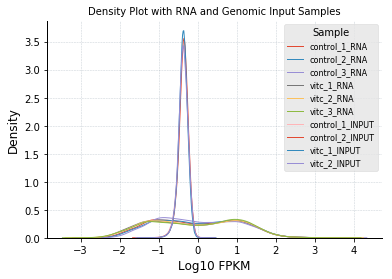

In [136]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "vitc_1_INPUT", "vitc_2_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"ARPE_RNA_LOD_Chart.png", dpi=300) # size above specified at 10x6


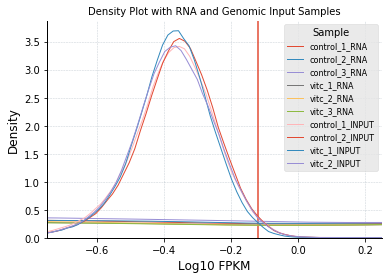

In [137]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "vitc_1_INPUT", "vitc_2_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=-0.12)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"ARPE_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

From the graphs above, we can see that they cross at -0.12. This is log base 10, so this converts to 0.75857758 FPKM. I am going to use 0.76 as my limit of detection for simplicity. Moving forward, I am going to keep genes that have one or both sample types averages above 0.76 FPKM. These are the ones that will be used for further analysis.

In [138]:
ARPE_RNA_FPKM_table.head()

Control_1_FPKM  Control_2_FPKM  Control_3_FPKM  VitC_1_FPKM  \
Ensembl_ID                                                                     
ENSG00000000003       21.542816       23.742769       24.262241    14.047861   
ENSG00000000005        0.000000        0.000000        0.110820     0.018848   
ENSG00000000419       65.020427       65.917011       59.943117    57.473302   
ENSG00000000457        4.275969        4.338525        4.018258     4.322483   
ENSG00000000460        2.422401        2.798705        2.271534     2.677261   

                 VitC_2_FPKM  VitC_3_FPKM  Control_Average_FPKM  \
Ensembl_ID                                                        
ENSG00000000003    16.561718    13.387857             23.182609   
ENSG00000000005     0.000000     0.000000              0.036940   
ENSG00000000419    53.111115    54.295966             63.626852   
ENSG00000000457     4.526825     4.018344              4.210917   
ENSG00000000460     3.090301     2.597352              2.497547   

                 VitC_Average_FPKM  Fold_Change    Log2FC     edgeR  \
Ensembl_ID                                                            
ENSG00000000003          14.665812     0.632621 -0.660586  0.000030   
ENSG00000000005           0.006283     1.000000  0.000000  0.594028   
ENSG00000000419          54.960128     0.863788 -0.211250  0.582149   
ENSG00000000457           4.289217     1.018594  0.026580  1.000000   
ENSG00000000460           2.788304     1.116417  0.158876  0.805784   

                       DESeq2           Change  
Ensembl_ID                                      
ENSG00000000003  2.790000e-07    Downregulated  
ENSG00000000005  1.000000e+00  Nondifferential  
ENSG00000000419  3.656105e-02  Nondifferential  
ENSG00000000457  9.196025e-01  Nondifferential  
ENSG00000000460  6.447663e-01  Nondifferential

In [139]:
ARPE_RNA_FPKM_table["Expressed"] = ARPE_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["VitC_Average_FPKM"] > 0.76 or x["Control_Average_FPKM"] > 0.76) else "Below_LOD", axis = 1)

In [140]:
ARPE_RNA_FPKM_table.head()

Control_1_FPKM  Control_2_FPKM  Control_3_FPKM  VitC_1_FPKM  \
Ensembl_ID                                                                     
ENSG00000000003       21.542816       23.742769       24.262241    14.047861   
ENSG00000000005        0.000000        0.000000        0.110820     0.018848   
ENSG00000000419       65.020427       65.917011       59.943117    57.473302   
ENSG00000000457        4.275969        4.338525        4.018258     4.322483   
ENSG00000000460        2.422401        2.798705        2.271534     2.677261   

                 VitC_2_FPKM  VitC_3_FPKM  Control_Average_FPKM  \
Ensembl_ID                                                        
ENSG00000000003    16.561718    13.387857             23.182609   
ENSG00000000005     0.000000     0.000000              0.036940   
ENSG00000000419    53.111115    54.295966             63.626852   
ENSG00000000457     4.526825     4.018344              4.210917   
ENSG00000000460     3.090301     2.597352              2.497547   

                 VitC_Average_FPKM  Fold_Change    Log2FC     edgeR  \
Ensembl_ID                                                            
ENSG00000000003          14.665812     0.632621 -0.660586  0.000030   
ENSG00000000005           0.006283     1.000000  0.000000  0.594028   
ENSG00000000419          54.960128     0.863788 -0.211250  0.582149   
ENSG00000000457           4.289217     1.018594  0.026580  1.000000   
ENSG00000000460           2.788304     1.116417  0.158876  0.805784   

                       DESeq2           Change  Expressed  
Ensembl_ID                                                 
ENSG00000000003  2.790000e-07    Downregulated  Expressed  
ENSG00000000005  1.000000e+00  Nondifferential  Below_LOD  
ENSG00000000419  3.656105e-02  Nondifferential  Expressed  
ENSG00000000457  9.196025e-01  Nondifferential  Expressed  
ENSG00000000460  6.447663e-01  Nondifferential  Expressed

In [141]:
ARPE_Expressed_Genes = ARPE_RNA_FPKM_table[ARPE_RNA_FPKM_table["Expressed"] == "Expressed"]

In [142]:
len(ARPE_Expressed_Genes)
# We have 14,599 genes left that are expressed

14599

In [143]:
print("Downregulated Genes:", len(ARPE_Expressed_Genes[ARPE_Expressed_Genes["Change"] == "Downregulated"]))
print("Upregulated Genes:",len(ARPE_Expressed_Genes[ARPE_Expressed_Genes["Change"] == "Upregulated"]))
print("Nondifferential Genes:",len(ARPE_Expressed_Genes[ARPE_Expressed_Genes["Change"] == "Nondifferential"]))

Downregulated Genes: 1417
Upregulated Genes: 3262
Nondifferential Genes: 9920


In [144]:
ARPE_Expressed_Genes.to_csv(Output_Path+"ARPE_Expressed_RNA.csv")
ARPE_Expressed_Genes.to_pickle(Output_Path+"ARPE_Expressed_RNA.pkl")

We can see that we have 3,245 genes that go up and 1,424 genes that go down after treatement with vitamin C. This is much lower than the 9,920 genes that do not change after treatment. This matches the assumption that most genes will not change, and indicates that our treatment was not too extreme.

Now I have a table of the expressed genes, as well as the information about how they react to vitamin C treatment.
The next step is going to be to integrate this with the information that we have generated about the hMeDIP peaks.

In [145]:
ARPE_Expressed_Genes = pd.read_pickle(Output_Path+"ARPE_Expressed_RNA.pkl")
Human_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )
summed_counts = pd.read_pickle(Output_Path+"ARPE_Counts_of_peaks_per_region.pkl")

In [146]:
Human_Genomic_Info_File.head()

Name                  Location Sense         Biotype  \
Gene_ID                                                                     
ENSG00000000003    TSPAN6  chrX:100627109-100639991     -  protein_coding   
ENSG00000000005      TNMD  chrX:100584802-100599885     +  protein_coding   
ENSG00000000419      DPM1   chr20:50934867-50958555     -  protein_coding   
ENSG00000000457     SCYL3  chr1:169849631-169894267     -  protein_coding   
ENSG00000000460  C1orf112  chr1:169662007-169854080     +  protein_coding   

                   transcript_id Chr        Start         Stop   Length  \
Gene_ID                                                                   
ENSG00000000003  ENST00000612152   X  100627109.0  100637104.0   9996.0   
ENSG00000000005  ENST00000373031   X  100584802.0  100599885.0  15084.0   
ENSG00000000419  ENST00000371582  20   50934867.0   50958555.0  23689.0   
ENSG00000000457  ENST00000367771   1  169849631.0  169893952.0  44322.0   
ENSG00000000460  ENST00000286031   1  169795409.0  169854080.0  58672.0   

                 Exonic Length  Intronic Length          gene_id  \
Gene_ID                                                            
ENSG00000000003         3796.0           6200.0  ENSG00000000003   
ENSG00000000005         1339.0          13745.0  ENSG00000000005   
ENSG00000000419         1161.0          22528.0  ENSG00000000419   
ENSG00000000457         6364.0          37958.0  ENSG00000000457   
ENSG00000000460         4355.0          54317.0  ENSG00000000460   

                 gene_version  transcript_version gene_name     gene_source  \
Gene_ID                                                                       
ENSG00000000003          14.0                 4.0    TSPAN6  ensembl_havana   
ENSG00000000005           5.0                 4.0      TNMD  ensembl_havana   
ENSG00000000419          12.0                 8.0      DPM1  ensembl_havana   
ENSG00000000457          13.0                10.0     SCYL3  ensembl_havana   
ENSG00000000460          16.0                10.0  C1orf112  ensembl_havana   

                   gene_biotype transcript_name transcript_source  \
Gene_ID                                                             
ENSG00000000003  protein_coding      TSPAN6-204           ensembl   
ENSG00000000005  protein_coding        TNMD-201    ensembl_havana   
ENSG00000000419  protein_coding        DPM1-201            havana   
ENSG00000000457  protein_coding       SCYL3-202    ensembl_havana   
ENSG00000000460  protein_coding    C1orf112-201    ensembl_havana   

                transcript_biotype  
Gene_ID                             
ENSG00000000003     protein_coding  
ENSG00000000005     protein_coding  
ENSG00000000419     protein_coding  
ENSG00000000457     protein_coding  
ENSG00000000460     protein_coding

In [147]:
labels = ARPE_Expressed_Genes[["Change"]]
relevant_genomic_info = Human_Genomic_Info_File[["Name", "Biotype", "Chr", "Length", "Exonic Length"]]

In [148]:
labels.head()

Change
Ensembl_ID                      
ENSG00000000003    Downregulated
ENSG00000000419  Nondifferential
ENSG00000000457  Nondifferential
ENSG00000000460  Nondifferential
ENSG00000000971      Upregulated

In [149]:
relevant_genomic_info.head()

Name         Biotype Chr   Length  Exonic Length
Gene_ID                                                              
ENSG00000000003    TSPAN6  protein_coding   X   9996.0         3796.0
ENSG00000000005      TNMD  protein_coding   X  15084.0         1339.0
ENSG00000000419      DPM1  protein_coding  20  23689.0         1161.0
ENSG00000000457     SCYL3  protein_coding   1  44322.0         6364.0
ENSG00000000460  C1orf112  protein_coding   1  58672.0         4355.0

In [150]:
expressed_genes_info = labels.join(relevant_genomic_info)

In [151]:
expressed_genes_info.groupby(["Biotype"], as_index = False).size()

Biotype
3prime_overlapping_ncRNA                  5
IG_V_gene                                 2
Mt_rRNA                                   2
Mt_tRNA                                  11
TEC                                      28
TR_C_gene                                 1
TR_J_gene                                15
TR_J_pseudogene                           1
antisense_RNA                          1189
bidirectional_promoter_lncRNA             5
lincRNA                                 916
miRNA                                    22
misc_RNA                                 34
processed_pseudogene                    542
processed_transcript                    169
protein_coding                        11228
scRNA                                     1
sense_intronic                            2
sense_overlapping                        49
snRNA                                    48
snoRNA                                    9
transcribed_processed_pseudogene         51
transcribed_unitary_pseu

It is not surprising that the majority of the expressed genes (11,228 of the 14,599) are protein coding genes. It looks like the next most common is antisense (1,189) and lincRNA (916). I may join all of the noncoding types together for further anaylsis.

In [152]:
expressed_genes_info = expressed_genes_info.join(summed_counts)
expressed_genes_info = expressed_genes_info.fillna(0)

In [153]:
expressed_genes_info.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated  TSS_Nondifferential  \
Ensembl_ID                                                              
ENSG00000000003                              0.0                  1.0   
ENSG00000000419                              0.0                  0.0   
ENSG00000000457                              0.0                  0.0   
ENSG00000000460                              0.0                  0.0   
ENSG00000000971                              0.0                  0.0   

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  
Ensembl_ID                                                             
ENSG00000000003                    0.0                            0.0  
ENSG00000000419                    1.0                            0.0  
ENSG00000000457                    1.0                            0.0  
ENSG00000000460                    2.0                            0.0  
ENSG00000000971                    0.0                            0.0

In [154]:
expressed_genes_info.describe()

Length  Exonic Length  TSS_Downregulated  \
count  1.459900e+04   14599.000000       14599.000000   
mean   6.280085e+04    3476.985684           0.002671   
std    1.150453e+05    2869.609131           0.051618   
min    4.800000e+01      48.000000           0.000000   
25%    9.014000e+03    1460.000000           0.000000   
50%    2.629700e+04    2794.000000           0.000000   
75%    6.702300e+04    4676.000000           0.000000   
max    2.092292e+06   34526.000000           1.000000   

       Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
count                       14599.000000             14599.000000   
mean                            0.010823                 0.136105   
std                             0.104787                 0.558936   
min                             0.000000                 0.000000   
25%                             0.000000                 0.000000   
50%                             0.000000                 0.000000   
75%                             0.000000                 0.000000   
max                             2.000000                15.000000   

       Upstream_Promoter_Downregulated  TSS_Nondifferential  \
count                     14599.000000         14599.000000   
mean                          0.012604             0.049387   
std                           0.111560             0.234009   
min                           0.000000             0.000000   
25%                           0.000000             0.000000   
50%                           0.000000             0.000000   
75%                           0.000000             0.000000   
max                           1.000000             4.000000   

       Downstream_Promoter_Nondifferential  Gene_Body_Nondifferential  \
count                         14599.000000               14599.000000   
mean                              0.205425                   1.644702   
std                               0.495142                   3.781105   
min                               0.000000                   0.000000   
25%                               0.000000                   0.000000   
50%                               0.000000                   0.000000   
75%                               0.000000                   2.000000   
max                               7.000000                  66.000000   

       Upstream_Promoter_Nondifferential  TSS_Upregulated  \
count                       14599.000000     14599.000000   
mean                            0.224741         0.110419   
std                             0.530842         0.371804   
min                             0.000000         0.000000   
25%                             0.000000         0.000000   
50%                             0.000000         0.000000   
75%                             0.000000         0.000000   
max                             8.000000         6.000000   

       Downstream_Promoter_Upregulated  Gene_Body_Upregulated  \
count                     14599.000000           14599.000000   
mean                          0.342147               1.900267   
std                           0.728718               4.845714   
min                           0.000000               0.000000   
25%                           0.000000               0.000000   
50%                           0.000000               0.000000   
75%                           0.000000               2.000000   
max                          11.000000             106.000000   

       Upstream_Promoter_Upregulated  
count                   14599.000000  
mean                        0.330708  
std                         0.730941  
min                         0.000000  
25%                         0.000000  
50%                         0.000000  
75%                         0.000000  
max                        11.000000

In [155]:
expressed_genes_info.to_csv("Output_Tables_and_Results/ARPE_Combined_Cleaned_Data.csv")
expressed_genes_info.to_pickle("Output_Tables_and_Results/ARPE_Combined_Cleaned_Data.pkl")


This is the finally cleaned data. I realize that I did not need to have all of the steps for finding outliers to get the table this way, but it was needed to accurately determine the fold change, which might end up being used in this project and will very likely be used in other projects. Additionally, the corrected FPKM values are needed for heatmaps and were needed to determine the expression threshold. 

Exploration of the data has shown that there are about twice as many upregulated genes as there are downregulated genes in the ARPE dataset, but this is still only about 1/3 of the expressed genes (14,599). Over 2/3 of the expressed genes are protein coding genes (11,228), even though they make up a relatively small portion of the annotated genome. This is consistent with other RNA-seq studies. It looks like the highest average peak counts are genebody upregulated (1.9) followed by genebody nondifferential (1.6). We now have many dimensions and this should be helpful for determining if we can classify genes based on the genomic info and hMeDIP peak information (data about DNA methylation). 

# Schwann Cell Cyclic AMP Data Normalization

## Introduction to what I am doing here

This is going to be a copy of the ARPE-19 Data Normalization. I am going to keep all of the information about how I normalize the data and simply update the actual code for changes in file names, sample numbers, cutoff points, etc. This should mirror the ARPE_normalizing.RNA.and.hMeDIP.ipynb notebook very closely.

To start with, I have my raw count files. I have combined them already (using bash scripting), so it is in table format where it is tab delimited like this:

    Gene_ID | Sample 1 | Sample 2 | Sample 3 | Sample 4
    ENSRN0001 | 6 | 8 | 24| 29
    ENSRN0002 | 12 | 13 | 14 | 13
    ENSRN0003 | 18 | 17 | 1 | 0

For the RNA I also have results from edgeR and DESeq2. I have the transcript info from the GTF file in a csv file that I will use to determine transcript length.

For the hMeDIP samples I also have the edgeR statistical analysis, the bed file stating the location of the each peak (chromosome, start, stop, name of peak), the count data for genomic input (which was used for the peak calling and will be used for determining the cutoff of expression) and the region_analysis output which tells which gene the peak is close to. 

RNA-seq samples were aligned using STAR and then quantified using htseq-count. Both edgeR and DESeq2 are used for differential analysis and genes below a false discovery rate (FDR, also called adjusted P-value) of 0.05 by both DESeq2 and edgeR will be called differential. A limit of detection will be calculated using the genomic input from the hMeDIP-seq portion of the experiment. 

hMeDIP-seq peaks were called using the irreproducible discovery rate pipeline designed for the ChIP-seq portion of the ENCODE consortium. Counts were generated using htseq-count. Differential analysis was calculated using edgeR. To account for not having a second statistical program (DESeq2 can't normalize to all data), a cutoff of 1.5-fold change will be used in conjunction with an FDR of 0.05 by edgeR to determine differential peaks.

Genes that have more count data after treatment (increase in expression) or peaks that have higher count data (increase in enrichment from the antibody) are considered "Upregulated". Genes that have fewer counts or lower coverage (decreae in expression) or peaks that have lower coverage (decreased enrichment from the antibody) are considered "Downregulated". Genes that have relatively similar count data or that do not achieve statistical significant are considered "Nondifferential".




### hMeDIP-seq normalization 

In this particular jupyter notebook, I am going to be cleaning up the data. This has many steps, and I am going to save many intermediate files. Most of those files will not be used in the correlation or classification parts of this project, but the files are still useful for this project and may be used in future directions from this sampleset.

The first step to cleaning up the hMeDIP-seq data is to normalize the counts to the total number of reads. This is a Read Count Per Million (RCPM), but this first one does not exclude outliers. 

The next step is to determine which peaks are outliers. The reason for this is that outliers can bias your normalization. As an example, if you have two samples that are identical, and then you spike in DNA that will be in one region for 50% of one of the samples, your normalization will all be wrong. Instead of saying that your spiked-sample has one peak that is significantly different than what is found in the other sample, all of your peaks look like they have half as much coverage as the non-spiked sample and all regions appear differential. If you remove the one spiked region from the normalization, now the unchanged regions all appear the same between the samples (as they should), but the spiked in reads still appear only in the one sample. For this reason, this step includes a linear regression between the two sample types (in this case control and vitamin C), and then a Cook's value of 1 (can be changed), is used to determine the outliers. 

Once you have identified outliers, you can go back to the raw count data and normalize to total read counts excluding the outliers. This gives you the RCPM. This file is saved as the RCPM table.

The next step is to normalize to the RCPM by the width of each peak. This allows you to compare one peak to another. If you don't do this and you compare one peak that covers 100 base pairs (bp) to another peak that covers 100,000 bp, you would just by chance expect that the secon peak has 1,000 times as many reads. To normalize this, we take the RCPM and multiply by 1,000 and divide by the length of the peak. This is referred to as "Fragments Per Kilobase per Million mapped reads" (FPKM, see Trapnell et al. 2012, Nature Protocols). To do this, I use the peaks bed file, which contains information about the start and stop positions of each peak that can be used to calculate the length of each peak. This file is saved as the FPKM table. 

Once reads are normalized correctly, I incorporate the statistical data. For hMeDIP-seq, I use edgeR and a fold change. Peaks that receive a false-discovery rate (FDR, benjamini-hocherberg correction) below 0.05 and a fold change of 1.5x or greater are considered differential.

The next step is to determine which genes are most likely affected by each peak. To do this I used region_analysis, which is a program developed for the ENCODE project. This tells you which gene is closest to the center of the peak and how far the peak is from the transcription start site (TSS) of the gene. Using this data, I can assign each peak to a gene (or classify it as intergenic), and classify each to a region of the gene (upstream promoter, TSS, downstream promoter or gene body). 

There are a lot more peaks than genes, and most genes contain many peaks. As such, the next step is to determine the counts of peaks in each region per gene. Additionally, these peaks are divided by how they respond to vitamin C (upregulated, downregulated or nondifferential). This file is saved as a counts per gene region file. 


### Normalizing RNA-seq data

Like the hMeDIP-seq data, the RNA-seq data needs to be normalized. The first step is to normalize to the total reads within annotated features, and then to find outliers, just like is done for the hMeDIP-seq. You next go back to the raw count data and normalize to the total read counts within annotated features that are not outliers to get the RCPM table. Next, you use the genomic info file to get the lengths of each transcript and calculate the FPKM. This is essentially identical to the first few steps of hMeDIP-seq, except that we don't include reads that don't lie within annotated features for RNA. 

Next, we need to determine differential genes. For RNA-seq data, we use both edgeR and DESeq2. Genes that receive an FDR value below 0.05 by both edgeR and DESeq2 are considered differential. No fold change limit is taken into account and using two algorithms for differential analysis is thought to limit false positives. 

Again, the fold change is used to split differential genes into upregulated and downregulated genes.

Now, the counts of peaks per gene region are integrated with the RNA-seq data to generate a table that contains information that will be used for our classification analysis. Other information that is kept in the file includes gene biotype (e.g. protein coding, long noncoding RNA, antisense RNA, etc.) and the length of the gene. 

The next step is different than was used for hMeDIP-seq. For the hMeDIP-seq, I used the IDR pipeline (from ENCODE) to determine which regions were highly enriched. However, for RNA we look at all annotated regions. Most of these regions, however, are not going to have any reads. This step is determining which genes are above our limit of detection. To do this, I perform the normalization of the genomic input data. The genomic input data was generated for hMeDIP-seq, but has no enrichment. It is meant to represent what we would get if we sequenced just noise. For the RNA, I draw out density plots of the RNA-seq samples and the genomic input. If we use a limit of detection (LOD) below the highest expressed genomic input, then those are essentially false positives for the LOD. If we use a LOD above the bottom of the true genes, then those true genes below that point ar false negatives for our LOD. For this, I look at the density plot and take the point where the RNA-seq data overlaps the genomic input to find the minimum number of false positives and false negatives. Only the transcripts above the determined LOD are used for the rest of this project. 

#### Reading in the count files and normalizing them
The first step is going to be reading in the count files and normalizing them to total read counts. There will be multiple steps of normalization, but this is the first one.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.listdir("Input_Data/SC-cAMP_Dataset")


['SC_cAMP.hMeDIP.IP.samples.counts.txt',
 '.DS_Store',
 'SC.cAMP_RNA.counts.txt',
 'SC.cAMP_RNA.edgeR.csv',
 'SC.cAMP.hMeDIP.Region.analysis.bed.txt',
 'SC.cAMP.hMeDIP.edgeR.csv',
 'SC_cAMP.hMeDIP.Input.samples.counts.txt',
 'SC.cAMP.Merged.Final.Peaks.bed',
 'SC.cAMP_RNA.DESeq2.csv']

In [3]:
os.listdir("Input_Data/")

['MM10.Consensus.Transcript.Info.csv',
 '.DS_Store',
 'SC-cAMP_Dataset',
 'HG38.90.Consensus.transcript.info.csv',
 'RN6.91.Consensus.transcript.info.csv',
 'ARPE-19_Dataset',
 'SC-VitC_Dataset']

In [4]:
os.getcwd()

'/Users/david/Documents/David_Sant/Classes/Data_Science_COMP_5360/2019-datascience-homeworks/Final Project/now-u-c-me-datascience-final-project'

In [5]:
Input_path = r"Input_Data/SC-cAMP_Dataset/"
Output_Path = r"Output_Tables_and_Results/SC-cAMP_Intermediate_Files/"

Input_hMeDIP_Counts_File = Input_path+"SC_cAMP.hMeDIP.IP.samples.counts.txt"
Input_hMeDIP_edgeR = Input_path+"SC.cAMP.hMeDIP.edgeR.csv"
Input_region_analysis = Input_path+"SC.cAMP.hMeDIP.Region.analysis.bed.txt"
Input_Genomic_Input_Counts_File = Input_path+"SC_cAMP.hMeDIP.Input.samples.counts.txt"
Input_bed_file = Input_path+"SC.cAMP.Merged.Final.Peaks.bed"

Input_RNA_Counts_File = Input_path+"SC.cAMP_RNA.counts.txt"
Input_RNA_edgeR = Input_path+"SC.cAMP_RNA.edgeR.csv"
Input_RNA_DESeq2 = Input_path+"SC.cAMP_RNA.DESeq2.csv"

Input_genomic_info_file = "Input_Data/RN6.91.Consensus.transcript.info.csv"

In [6]:
SC_cAMP_hMeDIP_raw = pd.read_csv(Input_hMeDIP_Counts_File, sep = "\t", index_col = 0)

In [7]:
print(len(SC_cAMP_hMeDIP_raw))
SC_cAMP_hMeDIP_raw.head()

192148


SC_Control_1_IP  SC_Control_2_IP  SC_Control_3_IP  \
Peak_Name                                                                    
Merged.cAMP_peak_100                  79              100               61   
Merged.cAMP_peak_10000                56               73               50   
Merged.cAMP_peak_100003               60               75               60   
Merged.cAMP_peak_100004               27               37               24   
Merged.cAMP_peak_100007               43               34               29   

                         SC_cAMP_1_IP  SC_cAMP_2_IP  SC_cAMP_3_IP  
Peak_Name                                                          
Merged.cAMP_peak_100              113           192           202  
Merged.cAMP_peak_10000            188           212           299  
Merged.cAMP_peak_100003           178           255           278  
Merged.cAMP_peak_100004            52            77            91  
Merged.cAMP_peak_100007            69           112           125

In [8]:
# Dave notes, axis = 0 means column wise; axis = 1 means row wise
# so a sum of axis=0 means the counts for the entire column
total_counts_SC_cAMP_hMeDIP_Raw = SC_cAMP_hMeDIP_raw.sum(axis=0)

In [9]:
total_counts_SC_cAMP_hMeDIP_Raw

SC_Control_1_IP    64089453
SC_Control_2_IP    68587373
SC_Control_3_IP    63471316
SC_cAMP_1_IP       70960680
SC_cAMP_2_IP       64751750
SC_cAMP_3_IP       78618595
dtype: int64

In [10]:
total_counts_SC_cAMP_hMeDIP_Raw[0]

64089453

In [11]:
SC_cAMP_hMeDIP_raw["SC_cAMP_Control_1_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[0]
SC_cAMP_hMeDIP_raw["SC_cAMP_Control_2_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[1]
SC_cAMP_hMeDIP_raw["SC_cAMP_Control_3_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[2]

SC_cAMP_hMeDIP_raw["SC_cAMP_cAMP_1_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_cAMP_1_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[3]
SC_cAMP_hMeDIP_raw["SC_cAMP_cAMP_2_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_cAMP_2_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[4]
SC_cAMP_hMeDIP_raw["SC_cAMP_cAMP_3_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_cAMP_3_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[5]


In [12]:
SC_cAMP_hMeDIP_raw["Control_Average"] = SC_cAMP_hMeDIP_raw[["SC_cAMP_Control_1_IP_First_RCPM","SC_cAMP_Control_2_IP_First_RCPM", "SC_cAMP_Control_3_IP_First_RCPM"]].mean(axis=1)
SC_cAMP_hMeDIP_raw["cAMP_Average"] = SC_cAMP_hMeDIP_raw[["SC_cAMP_cAMP_1_IP_First_RCPM","SC_cAMP_cAMP_2_IP_First_RCPM", "SC_cAMP_cAMP_3_IP_First_RCPM"]].mean(axis=1)


In [13]:
SC_cAMP_hMeDIP_raw.head()


SC_Control_1_IP  SC_Control_2_IP  SC_Control_3_IP  \
Peak_Name                                                                    
Merged.cAMP_peak_100                  79              100               61   
Merged.cAMP_peak_10000                56               73               50   
Merged.cAMP_peak_100003               60               75               60   
Merged.cAMP_peak_100004               27               37               24   
Merged.cAMP_peak_100007               43               34               29   

                         SC_cAMP_1_IP  SC_cAMP_2_IP  SC_cAMP_3_IP  \
Peak_Name                                                           
Merged.cAMP_peak_100              113           192           202   
Merged.cAMP_peak_10000            188           212           299   
Merged.cAMP_peak_100003           178           255           278   
Merged.cAMP_peak_100004            52            77            91   
Merged.cAMP_peak_100007            69           112           125   

                         SC_cAMP_Control_1_IP_First_RCPM  \
Peak_Name                                                  
Merged.cAMP_peak_100                            1.232652   
Merged.cAMP_peak_10000                          0.873779   
Merged.cAMP_peak_100003                         0.936191   
Merged.cAMP_peak_100004                         0.421286   
Merged.cAMP_peak_100007                         0.670937   

                         SC_cAMP_Control_2_IP_First_RCPM  \
Peak_Name                                                  
Merged.cAMP_peak_100                            1.457994   
Merged.cAMP_peak_10000                          1.064336   
Merged.cAMP_peak_100003                         1.093496   
Merged.cAMP_peak_100004                         0.539458   
Merged.cAMP_peak_100007                         0.495718   

                         SC_cAMP_Control_3_IP_First_RCPM  \
Peak_Name                                                  
Merged.cAMP_peak_100                            0.961064   
Merged.cAMP_peak_10000                          0.787757   
Merged.cAMP_peak_100003                         0.945309   
Merged.cAMP_peak_100004                         0.378124   
Merged.cAMP_peak_100007                         0.456899   

                         SC_cAMP_cAMP_1_IP_First_RCPM  \
Peak_Name                                               
Merged.cAMP_peak_100                         1.592431   
Merged.cAMP_peak_10000                       2.649355   
Merged.cAMP_peak_100003                      2.508431   
Merged.cAMP_peak_100004                      0.732800   
Merged.cAMP_peak_100007                      0.972369   

                         SC_cAMP_cAMP_2_IP_First_RCPM  \
Peak_Name                                               
Merged.cAMP_peak_100                         2.965171   
Merged.cAMP_peak_10000                       3.274043   
Merged.cAMP_peak_100003                      3.938118   
Merged.cAMP_peak_100004                      1.189157   
Merged.cAMP_peak_100007                      1.729683   

                         SC_cAMP_cAMP_3_IP_First_RCPM  Control_Average  \
Peak_Name                                                                
Merged.cAMP_peak_100                         2.569367         1.217237   
Merged.cAMP_peak_10000                       3.803172         0.908624   
Merged.cAMP_peak_100003                      3.536059         0.991665   
Merged.cAMP_peak_100004                      1.157487         0.446289   
Merged.cAMP_peak_100007                      1.589955         0.541185   

                         cAMP_Average  
Peak_Name                              
Merged.cAMP_peak_100         2.375656  
Merged.cAMP_peak_10000       3.242190  
Merged.cAMP_peak_100003      3.327536  
Merged.cAMP_peak_100004      1.026481  
Merged.cAMP_peak_100007      1.430669

In [14]:
# Dave Notes
# The sum of the FPKM columns is always going to be 1,000,000 (when I include all rows) because that is how I normalized it
# 1M/215956 gives the 4.630573 average

SC_cAMP_hMeDIP_raw[["Control_Average","cAMP_Average" ]].describe()

Control_Average   cAMP_Average
count    192148.000000  192148.000000
mean          5.204322       5.204322
std        1711.170964    1510.651646
min           0.000000       0.000000
25%           0.689618       0.818987
50%           1.085995       1.313062
75%           1.642825       2.183447
max      750087.644574  662190.896958

In [15]:
SC_cAMP_hMeDIP_raw.sum(axis=0) # should be 1M for all normalized columns

SC_Control_1_IP                    64089453.0
SC_Control_2_IP                    68587373.0
SC_Control_3_IP                    63471316.0
SC_cAMP_1_IP                       70960680.0
SC_cAMP_2_IP                       64751750.0
SC_cAMP_3_IP                       78618595.0
SC_cAMP_Control_1_IP_First_RCPM     1000000.0
SC_cAMP_Control_2_IP_First_RCPM     1000000.0
SC_cAMP_Control_3_IP_First_RCPM     1000000.0
SC_cAMP_cAMP_1_IP_First_RCPM        1000000.0
SC_cAMP_cAMP_2_IP_First_RCPM        1000000.0
SC_cAMP_cAMP_3_IP_First_RCPM        1000000.0
Control_Average                     1000000.0
cAMP_Average                        1000000.0
dtype: float64

Now I have read in the hMeDIP count files and done the first normalization, a read count per million (RCPM). This does not take out any outliers, nor does it take out any of the columns that are added by htseq-count that are reads not within annotated features. Notice that the RCPM files all add up to 1,000,000 which is why this is read counts per million. 

The next step will be to determine if there are any outliers that should be taken out of the normalization. I will determine outliers without the htseq columns, but they will be added back in for the final RCPM normalization. For this step, I run a linear regression of the averages per treatment type (vitamin C and control). I look for a cook's cutoff value (usually a value of 1 is used), and then I remove those points that have a high cooks value for the normalization. 

In [16]:
columns_added_by_htseq = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__not_aligned", "__alignment_not_unique"]

In [17]:
SC_cAMP_hMeDIP_first_RCPM_averages = SC_cAMP_hMeDIP_raw[["Control_Average","cAMP_Average" ]].drop(columns_added_by_htseq, axis = 0)

In [18]:
len(SC_cAMP_hMeDIP_first_RCPM_averages)

192143

In [19]:
SC_cAMP_hMeDIP_first_RCPM_averages.tail()

Control_Average  \
Peak_Name                                                           
Merged.control_peak_99972                                1.447705   
Merged.control_peak_99982                                1.202852   
Merged.control_peak_99992,Merged.cAMP_peak_89678         3.019866   
Merged.control_peak_99996                                0.980222   
Merged.control_peak_99997                                1.631965   

                                                  cAMP_Average  
Peak_Name                                                       
Merged.control_peak_99972                             1.067706  
Merged.control_peak_99982                             0.772719  
Merged.control_peak_99992,Merged.cAMP_peak_89678      1.849421  
Merged.control_peak_99996                             0.541028  
Merged.control_peak_99997                             0.729319

In [20]:
SC_cAMP_hMeDIP_first_RCPM_averages.describe()

Control_Average   cAMP_Average
count    192143.000000  192143.000000
mean          1.300629       1.758084
std           1.023074       1.482280
min           0.004860       0.111344
25%           0.689622       0.819021
50%           1.085997       1.313069
75%           1.642792       2.183432
max          51.202739      75.666215

It looks like the mean for vitamin C is slightly higher, but that is not too surprising because vitamin C leads to a global increase in 5hmC. However, the minimum is lower in the vitamin C treated. I have seen this in all the other datasets too.

Now I have to make a linear regression using the averages and figure out which ones are outliers.
<br>I will not graph it using the ones that start with "_" because they need to be included in normalization because it is immunoprecipitation and this makes it include reads not within peaks.
<br>I am choosing to use cook's cutoff to determine outliers because it takes both X and Y axes into consideration, and it is used by DESeq2 for their normalization. Additionally, it calculates a P-value giving an easier time to determining a cutoff and it runs quickly. I am going to exclude points where Cook's distance > 1 because this looks correct in the graph and this is the default for DESeq2.   


In [21]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
import statsmodels as stats

import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [22]:
from statsmodels.stats import outliers_influence
import statsmodels.stats

In [23]:
SC_cAMP_hMeDIP_first_RCPM_averages.to_csv("camp.first.linear.csv")

In [24]:

linear_model = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_hMeDIP_first_RCPM_averages).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 4.293e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:18:51   Log-Likelihood:            -3.2889e+05
No. Observations:              192143   AIC:                         6.578e+05
Df Residuals:                  192141   BIC:                         6.578e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9528      0.005    192.673      0.000       0.943       0.962
Control_Average     0.6192      0.003    207.203      0.000       0.613       0.625
==============================================================================
Omnibus:                   158820.484   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20692293.145
Skew:                           3.323   Prob(JB):                         0.00
Kurtosis:                      53.403   Cond. No.                         3.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
influence = linear_model.get_influence()
(cook,p_cook) = influence.cooks_distance
SC_cAMP_hMeDIP_first_RCPM_averages["Cook_Value"] = cook
SC_cAMP_hMeDIP_first_RCPM_averages["Cook_P_Value"] = p_cook

In [26]:
SC_cAMP_hMeDIP_first_RCPM_averages.tail()

Control_Average  \
Peak_Name                                                           
Merged.control_peak_99972                                1.447705   
Merged.control_peak_99982                                1.202852   
Merged.control_peak_99992,Merged.cAMP_peak_89678         3.019866   
Merged.control_peak_99996                                0.980222   
Merged.control_peak_99997                                1.631965   

                                                  cAMP_Average    Cook_Value  \
Peak_Name                                                                      
Merged.control_peak_99972                             1.067706  9.031298e-07   
Merged.control_peak_99982                             0.772719  1.250655e-06   
Merged.control_peak_99992,Merged.cAMP_peak_89678      1.849421  5.247871e-06   
Merged.control_peak_99996                             0.541028  1.651089e-06   
Merged.control_peak_99997                             0.729319  2.437612e-06   

                                                  Cook_P_Value  
Peak_Name                                                       
Merged.control_peak_99972                             0.999999  
Merged.control_peak_99982                             0.999999  
Merged.control_peak_99992,Merged.cAMP_peak_89678      0.999995  
Merged.control_peak_99996                             0.999998  
Merged.control_peak_99997                             0.999998

In [27]:
SC_cAMP_hMeDIP_removing_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value <= 1]
SC_cAMP_hMeDIP_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value > 1]

In [28]:
print(len(SC_cAMP_hMeDIP_first_RCPM_averages))
print(len(SC_cAMP_hMeDIP_removing_outliers))
print(len(SC_cAMP_hMeDIP_outliers))

192143
192143
0


In [29]:
SC_cAMP_hMeDIP_outliers

Empty DataFrame
Columns: [Control_Average, cAMP_Average, Cook_Value, Cook_P_Value]
Index: []

Wow. There wasn't a single outlier in this one. I will still have to see what it graphs like. 

In [30]:
outliers_removed_model = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()
# Same R-2 value, but there was only one outlier

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 4.293e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:18:52   Log-Likelihood:            -3.2889e+05
No. Observations:              192143   AIC:                         6.578e+05
Df Residuals:                  192141   BIC:                         6.578e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9528      0.005    192.673      0.000       0.943       0.962
Control_Average     0.6192      0.003    207.203      0.000       0.613       0.625
==============================================================================
Omnibus:                   158820.484   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20692293.145
Skew:                           3.323   Prob(JB):                         0.00
Kurtosis:                      53.403   Cond. No.                         3.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statsmodels website: http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html
<br>cooks_d : Cook’s Distance defined in Influence.cooks_distance
<br>standard_resid : Standardized residuals defined in Influence.resid_studentized_internal
<br>hat_diag : The diagonal of the projection, or hat, matrix defined in Influence.hat_matrix_diag
<br>dffits_internal : DFFITS statistics using internally Studentized residuals defined in Influence.dffits_internal
<br>dffits : DFFITS statistics using externally Studentized residuals defined in Influence.dffits
<br>student_resid : Externally Studentized residuals defined in Influence.resid_studentized_external

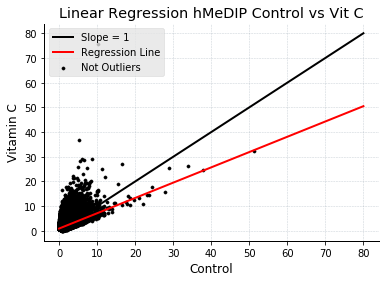

In [31]:
#outliers = ARPE_hMeDIP_outliers["cAMP_Average"].values
fig, tmp = plt.subplots()
ax = SC_cAMP_hMeDIP_first_RCPM_averages.plot.scatter(y = "cAMP_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
#ax.scatter(y = SC_cAMP_hMeDIP_outliers["cAMP_Average"], x = SC_cAMP_hMeDIP_outliers["Control_Average"], 
           #color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 80, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 80, 10)
y = parameters[0] + parameters[1]*x

#outliers_removed_model
#outlier_parameters = outliers_removed_model.params
#x = sc.linspace(0, 350, 10)
#outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
#plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_cAMP_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()
#plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png")

Wow! This looks awful. I am going to try to change the cutoff and see if I can make it make more sense. 

In [32]:
SC_cAMP_hMeDIP_removing_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value <= 0.001]
SC_cAMP_hMeDIP_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value > 0.001]
print(len(SC_cAMP_hMeDIP_first_RCPM_averages))
print(len(SC_cAMP_hMeDIP_removing_outliers))
print(len(SC_cAMP_hMeDIP_outliers))

192143
191922
221


In [33]:
outliers_removed_model = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                 3.677e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:18:54   Log-Likelihood:            -3.2013e+05
No. Observations:              191922   AIC:                         6.403e+05
Df Residuals:                  191920   BIC:                         6.403e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0133      0.005    211.046      0.000       1.004       1.023
Control_Average     0.5638      0.003    191.744      0.000       0.558       0.570
==============================================================================
Omnibus:                    93631.617   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           683173.793
Skew:                           2.246   Prob(JB):                         0.00
Kurtosis:                      11.078   Cond. No.                         3.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

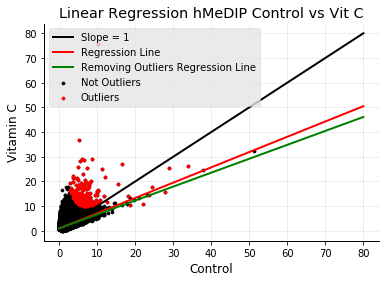

In [34]:
#outliers = ARPE_hMeDIP_outliers["cAMP_Average"].values
fig, tmp = plt.subplots()
ax = SC_cAMP_hMeDIP_first_RCPM_averages.plot.scatter(y = "cAMP_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_cAMP_hMeDIP_outliers["cAMP_Average"], x = SC_cAMP_hMeDIP_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 80, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 80, 10)
y = parameters[0] + parameters[1]*x

#outliers_removed_model
outlier_parameters = outliers_removed_model.params
x = sc.linspace(0, 80, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_cAMP_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


Wow. This changes almost nothing. I am just going to include everything for the normalization and run it as though there are no outliers. 

In [35]:
# remove_outliers = SC_cAMP_hMeDIP_raw.drop(SC_cAMP_hMeDIP_outliers.index, axis = 0)
# total_counts_removing_outliers = remove_outliers.sum(axis=0)

In [36]:
# total_counts_removing_outliers

In [37]:
# LAA means Vitamin C. I am changing the name out for cAMP because more people will recognize it
# SC_cAMP_hMeDIP_raw["Control_1_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_removing_outliers[0]
# SC_cAMP_hMeDIP_raw["Control_2_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_removing_outliers[1]
# SC_cAMP_hMeDIP_raw["Control_3_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_removing_outliers[2]

# SC_cAMP_hMeDIP_raw["cAMP_1_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_cAMP_1_IP"]*1000000/total_counts_removing_outliers[3]
# SC_cAMP_hMeDIP_raw["cAMP_2_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_cAMP_2_IP"]*1000000/total_counts_removing_outliers[4]
# SC_cAMP_hMeDIP_raw["cAMP_3_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_cAMP_3_IP"]*1000000/total_counts_removing_outliers[5]


In [38]:
#SC_cAMP_hMeDIP_Corrected_RCPM = SC_cAMP_hMeDIP_raw[["Control_1_Corrected_RCPM", "Control_2_Corrected_RCPM", "Control_3_Corrected_RCPM", "cAMP_1_Corrected_RCPM", "cAMP_2_Corrected_RCPM", "cAMP_3_Corrected_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [39]:
#len(SC_cAMP_hMeDIP_Corrected_RCPM)

In [40]:
#SC_cAMP_hMeDIP_Corrected_RCPM.head()

In [41]:
# samples = ["SC_Control_1_hMeDIP_RCPM", "SC_Control_2_hMeDIP_RCPM", "SC_Control_3_hMeDIP_RCPM",
#            "SC_cAMP_1_hMeDIP_RCPM", "SC_cAMP_2_hMeDIP_RCPM", "SC_cAMP_3_hMeDIP_RCPM"]

# SC_cAMP_hMeDIP_Corrected_RCPM.columns= samples


In [42]:
#SC_cAMP_hMeDIP_Corrected_RCPM.head()

In [43]:
SC_cAMP_hMeDIP_raw.head()

SC_Control_1_IP  SC_Control_2_IP  SC_Control_3_IP  \
Peak_Name                                                                    
Merged.cAMP_peak_100                  79              100               61   
Merged.cAMP_peak_10000                56               73               50   
Merged.cAMP_peak_100003               60               75               60   
Merged.cAMP_peak_100004               27               37               24   
Merged.cAMP_peak_100007               43               34               29   

                         SC_cAMP_1_IP  SC_cAMP_2_IP  SC_cAMP_3_IP  \
Peak_Name                                                           
Merged.cAMP_peak_100              113           192           202   
Merged.cAMP_peak_10000            188           212           299   
Merged.cAMP_peak_100003           178           255           278   
Merged.cAMP_peak_100004            52            77            91   
Merged.cAMP_peak_100007            69           112           125   

                         SC_cAMP_Control_1_IP_First_RCPM  \
Peak_Name                                                  
Merged.cAMP_peak_100                            1.232652   
Merged.cAMP_peak_10000                          0.873779   
Merged.cAMP_peak_100003                         0.936191   
Merged.cAMP_peak_100004                         0.421286   
Merged.cAMP_peak_100007                         0.670937   

                         SC_cAMP_Control_2_IP_First_RCPM  \
Peak_Name                                                  
Merged.cAMP_peak_100                            1.457994   
Merged.cAMP_peak_10000                          1.064336   
Merged.cAMP_peak_100003                         1.093496   
Merged.cAMP_peak_100004                         0.539458   
Merged.cAMP_peak_100007                         0.495718   

                         SC_cAMP_Control_3_IP_First_RCPM  \
Peak_Name                                                  
Merged.cAMP_peak_100                            0.961064   
Merged.cAMP_peak_10000                          0.787757   
Merged.cAMP_peak_100003                         0.945309   
Merged.cAMP_peak_100004                         0.378124   
Merged.cAMP_peak_100007                         0.456899   

                         SC_cAMP_cAMP_1_IP_First_RCPM  \
Peak_Name                                               
Merged.cAMP_peak_100                         1.592431   
Merged.cAMP_peak_10000                       2.649355   
Merged.cAMP_peak_100003                      2.508431   
Merged.cAMP_peak_100004                      0.732800   
Merged.cAMP_peak_100007                      0.972369   

                         SC_cAMP_cAMP_2_IP_First_RCPM  \
Peak_Name                                               
Merged.cAMP_peak_100                         2.965171   
Merged.cAMP_peak_10000                       3.274043   
Merged.cAMP_peak_100003                      3.938118   
Merged.cAMP_peak_100004                      1.189157   
Merged.cAMP_peak_100007                      1.729683   

                         SC_cAMP_cAMP_3_IP_First_RCPM  Control_Average  \
Peak_Name                                                                
Merged.cAMP_peak_100                         2.569367         1.217237   
Merged.cAMP_peak_10000                       3.803172         0.908624   
Merged.cAMP_peak_100003                      3.536059         0.991665   
Merged.cAMP_peak_100004                      1.157487         0.446289   
Merged.cAMP_peak_100007                      1.589955         0.541185   

                         cAMP_Average  
Peak_Name                              
Merged.cAMP_peak_100         2.375656  
Merged.cAMP_peak_10000       3.242190  
Merged.cAMP_peak_100003      3.327536  
Merged.cAMP_peak_100004      1.026481  
Merged.cAMP_peak_100007      1.430669

In [44]:
SC_cAMP_hMeDIP_RCPM_Table = SC_cAMP_hMeDIP_raw[["SC_cAMP_Control_1_IP_First_RCPM", "SC_cAMP_Control_2_IP_First_RCPM", "SC_cAMP_Control_3_IP_First_RCPM",
                  "SC_cAMP_cAMP_1_IP_First_RCPM", "SC_cAMP_cAMP_2_IP_First_RCPM", "SC_cAMP_cAMP_3_IP_First_RCPM"]]
SC_cAMP_hMeDIP_RCPM_Table.columns = ("SC_Control_1_IP_RCPM", "SC_Control_2_IP_RCPM", "SC_Control_3_IP_RCPM",
                                    "SC_cAMP_1_IP_RCPM", "SC_cAMP_2_IP_RCPM", "SC_cAMP_3_IP_RCPM")
SC_cAMP_hMeDIP_RCPM_Table = SC_cAMP_hMeDIP_RCPM_Table.drop(columns_added_by_htseq, axis = 0)

In [45]:
SC_cAMP_hMeDIP_RCPM_Table.head()

SC_Control_1_IP_RCPM  SC_Control_2_IP_RCPM  \
Peak_Name                                                             
Merged.cAMP_peak_100                 1.232652              1.457994   
Merged.cAMP_peak_10000               0.873779              1.064336   
Merged.cAMP_peak_100003              0.936191              1.093496   
Merged.cAMP_peak_100004              0.421286              0.539458   
Merged.cAMP_peak_100007              0.670937              0.495718   

                         SC_Control_3_IP_RCPM  SC_cAMP_1_IP_RCPM  \
Peak_Name                                                          
Merged.cAMP_peak_100                 0.961064           1.592431   
Merged.cAMP_peak_10000               0.787757           2.649355   
Merged.cAMP_peak_100003              0.945309           2.508431   
Merged.cAMP_peak_100004              0.378124           0.732800   
Merged.cAMP_peak_100007              0.456899           0.972369   

                         SC_cAMP_2_IP_RCPM  SC_cAMP_3_IP_RCPM  
Peak_Name                                                      
Merged.cAMP_peak_100              2.965171           2.569367  
Merged.cAMP_peak_10000            3.274043           3.803172  
Merged.cAMP_peak_100003           3.938118           3.536059  
Merged.cAMP_peak_100004           1.189157           1.157487  
Merged.cAMP_peak_100007           1.729683           1.589955

In [46]:
SC_cAMP_hMeDIP_RCPM_Table.to_csv(Output_Path+"SC_cAMP_hMeDIP_RCPM_table.csv")

Now I officially have excluded outliers from the normalization and made the read counts per million. The next step is to divide by length and multiply by 1000 to get "Fragments per Kilobase per Million", also known as FPKM. 
I have the bed file that has the info about peak length for this.

In [47]:
#SC_cAMP_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, names=["Chromosome", "Start", "Stop", "Peak_Name"], dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})
SC_cAMP_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3)



In [48]:
SC_cAMP_hMeDIP_bed.head()

Chr     Start      Stop
Peak_Name                                      
Merged.cAMP_peak_100      1   1967917   1968676
Merged.cAMP_peak_10000    1  56166555  56167312
Merged.cAMP_peak_100003  13  50411889  50412871
Merged.cAMP_peak_100004  13  50421254  50421647
Merged.cAMP_peak_100007  13  50424220  50424677

In [49]:
print(len(SC_cAMP_hMeDIP_bed))
len(SC_cAMP_hMeDIP_RCPM_Table)

192143


192143

In [50]:
SC_cAMP_hMeDIP_bed.dtypes

Chr      object
Start     int64
Stop      int64
dtype: object

In [51]:
SC_cAMP_hMeDIP_bed["Width"] = (SC_cAMP_hMeDIP_bed["Stop"] - SC_cAMP_hMeDIP_bed["Start"] + 1)

In [52]:
SC_cAMP_hMeDIP_bed.head()

Chr     Start      Stop  Width
Peak_Name                                             
Merged.cAMP_peak_100      1   1967917   1968676    760
Merged.cAMP_peak_10000    1  56166555  56167312    758
Merged.cAMP_peak_100003  13  50411889  50412871    983
Merged.cAMP_peak_100004  13  50421254  50421647    394
Merged.cAMP_peak_100007  13  50424220  50424677    458

In [53]:
SC_cAMP_hMeDIP_RCPM_Table = SC_cAMP_hMeDIP_RCPM_Table.join(SC_cAMP_hMeDIP_bed)

In [54]:
SC_cAMP_hMeDIP_RCPM_Table.head()

SC_Control_1_IP_RCPM  SC_Control_2_IP_RCPM  \
Peak_Name                                                             
Merged.cAMP_peak_100                 1.232652              1.457994   
Merged.cAMP_peak_10000               0.873779              1.064336   
Merged.cAMP_peak_100003              0.936191              1.093496   
Merged.cAMP_peak_100004              0.421286              0.539458   
Merged.cAMP_peak_100007              0.670937              0.495718   

                         SC_Control_3_IP_RCPM  SC_cAMP_1_IP_RCPM  \
Peak_Name                                                          
Merged.cAMP_peak_100                 0.961064           1.592431   
Merged.cAMP_peak_10000               0.787757           2.649355   
Merged.cAMP_peak_100003              0.945309           2.508431   
Merged.cAMP_peak_100004              0.378124           0.732800   
Merged.cAMP_peak_100007              0.456899           0.972369   

                         SC_cAMP_2_IP_RCPM  SC_cAMP_3_IP_RCPM Chr     Start  \
Peak_Name                                                                     
Merged.cAMP_peak_100              2.965171           2.569367   1   1967917   
Merged.cAMP_peak_10000            3.274043           3.803172   1  56166555   
Merged.cAMP_peak_100003           3.938118           3.536059  13  50411889   
Merged.cAMP_peak_100004           1.189157           1.157487  13  50421254   
Merged.cAMP_peak_100007           1.729683           1.589955  13  50424220   

                             Stop  Width  
Peak_Name                                 
Merged.cAMP_peak_100      1968676    760  
Merged.cAMP_peak_10000   56167312    758  
Merged.cAMP_peak_100003  50412871    983  
Merged.cAMP_peak_100004  50421647    394  
Merged.cAMP_peak_100007  50424677    458

In [55]:
SC_cAMP_hMeDIP_RCPM_Table["SC_Control_1_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_Control_1_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_Control_2_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_Control_2_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_Control_3_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_Control_3_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]

SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_1_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_1_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_2_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_2_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_3_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_3_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]


In [56]:
SC_cAMP_hMeDIP_RCPM_Table.head()

SC_Control_1_IP_RCPM  SC_Control_2_IP_RCPM  \
Peak_Name                                                             
Merged.cAMP_peak_100                 1.232652              1.457994   
Merged.cAMP_peak_10000               0.873779              1.064336   
Merged.cAMP_peak_100003              0.936191              1.093496   
Merged.cAMP_peak_100004              0.421286              0.539458   
Merged.cAMP_peak_100007              0.670937              0.495718   

                         SC_Control_3_IP_RCPM  SC_cAMP_1_IP_RCPM  \
Peak_Name                                                          
Merged.cAMP_peak_100                 0.961064           1.592431   
Merged.cAMP_peak_10000               0.787757           2.649355   
Merged.cAMP_peak_100003              0.945309           2.508431   
Merged.cAMP_peak_100004              0.378124           0.732800   
Merged.cAMP_peak_100007              0.456899           0.972369   

                         SC_cAMP_2_IP_RCPM  SC_cAMP_3_IP_RCPM Chr     Start  \
Peak_Name                                                                     
Merged.cAMP_peak_100              2.965171           2.569367   1   1967917   
Merged.cAMP_peak_10000            3.274043           3.803172   1  56166555   
Merged.cAMP_peak_100003           3.938118           3.536059  13  50411889   
Merged.cAMP_peak_100004           1.189157           1.157487  13  50421254   
Merged.cAMP_peak_100007           1.729683           1.589955  13  50424220   

                             Stop  Width  SC_Control_1_FPKM  \
Peak_Name                                                     
Merged.cAMP_peak_100      1968676    760           1.621911   
Merged.cAMP_peak_10000   56167312    758           1.152742   
Merged.cAMP_peak_100003  50412871    983           0.952382   
Merged.cAMP_peak_100004  50421647    394           1.069254   
Merged.cAMP_peak_100007  50424677    458           1.464928   

                         SC_Control_2_FPKM  SC_Control_3_FPKM  SC_cAMP_1_FPKM  \
Peak_Name                                                                       
Merged.cAMP_peak_100              1.918414           1.264558        2.095304   
Merged.cAMP_peak_10000            1.404137           1.039258        3.495191   
Merged.cAMP_peak_100003           1.112407           0.961657        2.551812   
Merged.cAMP_peak_100004           1.369182           0.959704        1.859899   
Merged.cAMP_peak_100007           1.082354           0.997597        2.123077   

                         SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  
Peak_Name                                                
Merged.cAMP_peak_100           3.901541        3.380746  
Merged.cAMP_peak_10000         4.319318        5.017377  
Merged.cAMP_peak_100003        4.006223        3.597212  
Merged.cAMP_peak_100004        3.018165        2.937784  
Merged.cAMP_peak_100007        3.776600        3.471517

In [57]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_RCPM_Table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", 
                                                        "SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]]

In [58]:
SC_cAMP_hMeDIP_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  \
Peak_Name                                                       
Merged.cAMP_peak_100              1.621911           1.918414   
Merged.cAMP_peak_10000            1.152742           1.404137   
Merged.cAMP_peak_100003           0.952382           1.112407   
Merged.cAMP_peak_100004           1.069254           1.369182   
Merged.cAMP_peak_100007           1.464928           1.082354   

                         SC_Control_3_FPKM  SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  \
Peak_Name                                                                    
Merged.cAMP_peak_100              1.264558        2.095304        3.901541   
Merged.cAMP_peak_10000            1.039258        3.495191        4.319318   
Merged.cAMP_peak_100003           0.961657        2.551812        4.006223   
Merged.cAMP_peak_100004           0.959704        1.859899        3.018165   
Merged.cAMP_peak_100007           0.997597        2.123077        3.776600   

                         SC_cAMP_3_FPKM  
Peak_Name                                
Merged.cAMP_peak_100           3.380746  
Merged.cAMP_peak_10000         5.017377  
Merged.cAMP_peak_100003        3.597212  
Merged.cAMP_peak_100004        2.937784  
Merged.cAMP_peak_100007        3.471517

In [59]:
SC_cAMP_hMeDIP_FPKM_table.to_csv(Output_Path+"SC_cAMP_hMeDIP_FPKM_table.csv")
SC_cAMP_hMeDIP_FPKM_table.to_pickle(Output_Path+"SC_cAMP_hMeDIP_FPKM_table.pkl")

Now I have the FPKM values calculated correctly. Next I need to figure out which ones go up, which ones go down, and which ones don't change. I am going to use a fold change cutoff of 1.5X and a corrected P-value from edgeR cutoff of 0.05. 

In [60]:
SC_cAMP_hMeDIP_FPKM_table = pd.read_pickle(Output_Path+"SC_cAMP_hMeDIP_FPKM_table.pkl")

In [61]:
SC_cAMP_hMeDIP_FPKM_table["Control_Average_FPKM"] = SC_cAMP_hMeDIP_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM"]].mean(axis=1)
SC_cAMP_hMeDIP_FPKM_table["cAMP_Average_FPKM"] = SC_cAMP_hMeDIP_FPKM_table[["SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]].mean(axis=1)
SC_cAMP_hMeDIP_FPKM_table["Fold_Change"] =  (SC_cAMP_hMeDIP_FPKM_table["cAMP_Average_FPKM"])/(SC_cAMP_hMeDIP_FPKM_table["Control_Average_FPKM"])
SC_cAMP_hMeDIP_FPKM_table["Log2FC"] = np.log2(SC_cAMP_hMeDIP_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [62]:
SC_cAMP_hMeDIP_FPKM_table.tail()

SC_Control_1_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.856922   
Merged.control_peak_99982                                  2.668479   
Merged.control_peak_99992,Merged.cAMP_peak_89678           4.573349   
Merged.control_peak_99996                                  3.457771   
Merged.control_peak_99997                                  3.091743   

                                                  SC_Control_2_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.933590   
Merged.control_peak_99982                                  2.909062   
Merged.control_peak_99992,Merged.cAMP_peak_89678           3.848022   
Merged.control_peak_99996                                  1.938607   
Merged.control_peak_99997                                  3.698986   

                                                  SC_Control_3_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.948146   
Merged.control_peak_99982                                  2.993852   
Merged.control_peak_99992,Merged.cAMP_peak_89678           3.594013   
Merged.control_peak_99996                                  2.749513   
Merged.control_peak_99997                                  2.275744   

                                                  SC_cAMP_1_FPKM  \
Peak_Name                                                          
Merged.control_peak_99972                               1.871414   
Merged.control_peak_99982                               1.807565   
Merged.control_peak_99992,Merged.cAMP_peak_89678        2.523159   
Merged.control_peak_99996                               1.873770   
Merged.control_peak_99997                               1.852878   

                                                  SC_cAMP_2_FPKM  \
Peak_Name                                                          
Merged.control_peak_99972                               2.858775   
Merged.control_peak_99982                               1.614058   
Merged.control_peak_99992,Merged.cAMP_peak_89678        2.355456   
Merged.control_peak_99996                               1.283401   
Merged.control_peak_99997                               1.115371   

                                                  SC_cAMP_3_FPKM  \
Peak_Name                                                          
Merged.control_peak_99972                               1.714720   
Merged.control_peak_99982                               2.084691   
Merged.control_peak_99992,Merged.cAMP_peak_89678        2.479823   
Merged.control_peak_99996                               1.338909   
Merged.control_peak_99997                               1.083525   

                                                  Control_Average_FPKM  \
Peak_Name                                                                
Merged.control_peak_99972                                     2.912886   
Merged.control_peak_99982                                     2.857131   
Merged.control_peak_99992,Merged.cAMP_peak_89678              4.005128   
Merged.control_peak_99996                                     2.715297   
Merged.control_peak_99997                                     3.022158   

                                                  cAMP_Average_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.148303   
Merged.control_peak_99982                                  1.835438   
Merged.control_peak_99992,Merged.cAMP_peak_89678           2.452813   
Merged.control_peak_99996                                  1.498694   
Merged.control_peak_99997                                  1.350591   

                                                  Fold_Change    Log2FC  
Peak_Name                         

In [63]:
SC_cAMP_hMeDIP_edgeR = pd.read_csv(Input_hMeDIP_edgeR, sep = ",", index_col=0)


In [64]:
SC_cAMP_hMeDIP_edgeR.head()

logFC    logCPM          LR        PValue  \
Peak_Name                                                               
Merged.cAMP_peak_182075 -4.623746  3.129310  408.342747  8.410000e-91   
Merged.cAMP_peak_82618  -4.470933  2.108313  360.272041  2.460000e-80   
Merged.cAMP_peak_336317 -4.045135  2.217228  332.046820  3.440000e-74   
Merged.cAMP_peak_12210  -4.775163  1.878797  314.271840  2.560000e-70   
Merged.cAMP_peak_101018 -4.450692  2.092771  311.023947  1.310000e-69   

                                  FDR  
Peak_Name                              
Merged.cAMP_peak_182075  1.620000e-85  
Merged.cAMP_peak_82618   2.360000e-75  
Merged.cAMP_peak_336317  2.210000e-69  
Merged.cAMP_peak_12210   1.230000e-65  
Merged.cAMP_peak_101018  5.020000e-65

In [65]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_FPKM_table.join(SC_cAMP_hMeDIP_edgeR)

In [66]:
SC_cAMP_hMeDIP_FPKM_table.tail()

SC_Control_1_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.856922   
Merged.control_peak_99982                                  2.668479   
Merged.control_peak_99992,Merged.cAMP_peak_89678           4.573349   
Merged.control_peak_99996                                  3.457771   
Merged.control_peak_99997                                  3.091743   

                                                  SC_Control_2_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.933590   
Merged.control_peak_99982                                  2.909062   
Merged.control_peak_99992,Merged.cAMP_peak_89678           3.848022   
Merged.control_peak_99996                                  1.938607   
Merged.control_peak_99997                                  3.698986   

                                                  SC_Control_3_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.948146   
Merged.control_peak_99982                                  2.993852   
Merged.control_peak_99992,Merged.cAMP_peak_89678           3.594013   
Merged.control_peak_99996                                  2.749513   
Merged.control_peak_99997                                  2.275744   

                                                  SC_cAMP_1_FPKM  \
Peak_Name                                                          
Merged.control_peak_99972                               1.871414   
Merged.control_peak_99982                               1.807565   
Merged.control_peak_99992,Merged.cAMP_peak_89678        2.523159   
Merged.control_peak_99996                               1.873770   
Merged.control_peak_99997                               1.852878   

                                                  SC_cAMP_2_FPKM  \
Peak_Name                                                          
Merged.control_peak_99972                               2.858775   
Merged.control_peak_99982                               1.614058   
Merged.control_peak_99992,Merged.cAMP_peak_89678        2.355456   
Merged.control_peak_99996                               1.283401   
Merged.control_peak_99997                               1.115371   

                                                  SC_cAMP_3_FPKM  \
Peak_Name                                                          
Merged.control_peak_99972                               1.714720   
Merged.control_peak_99982                               2.084691   
Merged.control_peak_99992,Merged.cAMP_peak_89678        2.479823   
Merged.control_peak_99996                               1.338909   
Merged.control_peak_99997                               1.083525   

                                                  Control_Average_FPKM  \
Peak_Name                                                                
Merged.control_peak_99972                                     2.912886   
Merged.control_peak_99982                                     2.857131   
Merged.control_peak_99992,Merged.cAMP_peak_89678              4.005128   
Merged.control_peak_99996                                     2.715297   
Merged.control_peak_99997                                     3.022158   

                                                  cAMP_Average_FPKM  \
Peak_Name                                                             
Merged.control_peak_99972                                  2.148303   
Merged.control_peak_99982                                  1.835438   
Merged.control_peak_99992,Merged.cAMP_peak_89678           2.452813   
Merged.control_peak_99996                                  1.498694   
Merged.control_peak_99997                                  1.350591   

                                                  Fold_Change    Log2FC  \
Peak_Name                        

In [67]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_FPKM_table.drop(["logFC", "logCPM", "LR", "PValue"], axis = 1)

In [68]:
def direction(row):
    if row["FDR"] < 0.05 :
        if row["Log2FC"] >= 0.584962500721156:
            return "Upregulated"
        elif row["Log2FC"] <= -0.584962500721156:
            return "Downregulated"
        else:
            return "Nondifferential"
    else:
        return "Nondifferential"

SC_cAMP_hMeDIP_FPKM_table["Change"] =  SC_cAMP_hMeDIP_FPKM_table.apply(direction, axis = 1)

In [69]:
SC_cAMP_hMeDIP_FPKM_table.tail(20)

SC_Control_1_FPKM  \
Peak_Name                                                             
Merged.control_peak_99946                                  2.979504   
Merged.control_peak_99947                                  1.997760   
Merged.control_peak_9995                                   2.560276   
Merged.control_peak_99950                                  2.040744   
Merged.control_peak_99954,Merged.cAMP_peak_89616           2.309748   
Merged.control_peak_99955,Merged.cAMP_peak_89617           4.885250   
Merged.control_peak_99956                                  3.044525   
Merged.control_peak_99957,Merged.cAMP_peak_89621           4.048929   
Merged.control_peak_99958                                  3.234040   
Merged.control_peak_99959                                  3.033954   
Merged.control_peak_99960,Merged.cAMP_peak_89628           2.308450   
Merged.control_peak_99963,Merged.cAMP_peak_89632           2.663127   
Merged.control_peak_99964                                  2.671779   
Merged.control_peak_99967,Merged.cAMP_peak_89637           2.666727   
Merged.control_peak_99969                                  2.885262   
Merged.control_peak_99972                                  2.856922   
Merged.control_peak_99982                                  2.668479   
Merged.control_peak_99992,Merged.cAMP_peak_89678           4.573349   
Merged.control_peak_99996                                  3.457771   
Merged.control_peak_99997                                  3.091743   

                                                  SC_Control_2_FPKM  \
Peak_Name                                                             
Merged.control_peak_99946                                  3.260339   
Merged.control_peak_99947                                  2.317342   
Merged.control_peak_9995                                   2.482653   
Merged.control_peak_99950                                  2.463097   
Merged.control_peak_99954,Merged.cAMP_peak_89616           1.926702   
Merged.control_peak_99955,Merged.cAMP_peak_89617           4.149889   
Merged.control_peak_99956                                  2.844867   
Merged.control_peak_99957,Merged.cAMP_peak_89621           3.844922   
Merged.control_peak_99958                                  3.178938   
Merged.control_peak_99959                                  2.294991   
Merged.control_peak_99960,Merged.cAMP_peak_89628           2.710446   
Merged.control_peak_99963,Merged.cAMP_peak_89632           2.328962   
Merged.control_peak_99964                                  2.130403   
Merged.control_peak_99967,Merged.cAMP_peak_89637           2.279773   
Merged.control_peak_99969                                  2.802471   
Merged.control_peak_99972                                  2.933590   
Merged.control_peak_99982                                  2.909062   
Merged.control_peak_99992,Merged.cAMP_peak_89678           3.848022   
Merged.control_peak_99996                                  1.938607   
Merged.control_peak_99997                                  3.698986   

                                                  SC_Control_3_FPKM  \
Peak_Name                                                             
Merged.control_peak_99946                                  2.731420   
Merged.control_peak_99947                                  1.982436   
Merged.control_peak_9995                                   2.438877   
Merged.control_peak_99950                                  2.060619   
Merged.control_peak_99954,Merged.cAMP_peak_89616           2.132050   
Merged.control_peak_99955,Merged.cAMP_peak_89617           5.201890   
Merged.control_peak_99956                                  3.026141   
Merged.control_peak_99957,Merged.cAMP_peak_89621           3.656258   
Merged.control_peak_99958                                  3.350355   
Merged.control_peak_99959                                  2.771739   
Merged.control_peak_99960,Merged.cAMP_peak_89628           1.989225   
M

Now I need to read in the region_analysis to put each peak with a gene or region of a gene

In [70]:
SC_cAMP_region_analysis = pd.read_csv(Input_region_analysis, sep = "\t", index_col=3)
SC_cAMP_region_analysis.rename(columns={'Gene_Region':'Genomic_Region'}, inplace = True)

/Users/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
SC_cAMP_region_analysis.head()

Chr     Start      Stop                Gene  \
Name                                                                  
Merged.cAMP_peak_100      1   1967917   1968676  ENSRNOG00000016041   
Merged.cAMP_peak_10000    1  56166555  56167312  ENSRNOG00000022921   
Merged.cAMP_peak_100003  13  50411889  50412871                 NaN   
Merged.cAMP_peak_100004  13  50421254  50421647                 NaN   
Merged.cAMP_peak_100007  13  50424220  50424677                 NaN   

                                 Transcript Sense  Feature_Start  \
Name                                                               
Merged.cAMP_peak_100     ENSRNOT00000065646     +      1938419.0   
Merged.cAMP_peak_10000   ENSRNOT00000080065     -     56159426.0   
Merged.cAMP_peak_100003                 NaN     .            NaN   
Merged.cAMP_peak_100004                 NaN     .            NaN   
Merged.cAMP_peak_100007                 NaN     .            NaN   

                         Feature_Stop   Genomic_Region  Distance_From_TSS  \
Name                                                                        
Merged.cAMP_peak_100        1972918.0         Genebody            29877.0   
Merged.cAMP_peak_10000     56168021.0       Promoter3k             1088.0   
Merged.cAMP_peak_100003           NaN  OtherIntergenic                NaN   
Merged.cAMP_peak_100004           NaN  OtherIntergenic                NaN   
Merged.cAMP_peak_100007           NaN  OtherIntergenic                NaN   

                           Gene_Biotype Gene_Name  
Name                                               
Merged.cAMP_peak_100     protein_coding   Zc3h12d  
Merged.cAMP_peak_10000   protein_coding     Dact2  
Merged.cAMP_peak_100003         No_anno       NaN  
Merged.cAMP_peak_100004         No_anno       NaN  
Merged.cAMP_peak_100007         No_anno       NaN

In [72]:
def dave_region(row):
    if row["Distance_From_TSS"] >= -3000 and row["Distance_From_TSS"] < -250:
        return "Upstream_Promoter"
    elif row["Distance_From_TSS"] >= -250 and row["Distance_From_TSS"] <= 250:
        return "TSS"
    elif row["Distance_From_TSS"] > 250 and row["Distance_From_TSS"] <= 3000:
        return "Downstream_Promoter"
    elif row["Distance_From_TSS"] > 3000:
        return "Gene_Body"
    else:
        return "Intergenic"
    

SC_cAMP_region_analysis["Gene_Region"] =  SC_cAMP_region_analysis.apply(dave_region, axis = 1)

In [73]:
SC_cAMP_region_analysis.head()

Chr     Start      Stop                Gene  \
Name                                                                  
Merged.cAMP_peak_100      1   1967917   1968676  ENSRNOG00000016041   
Merged.cAMP_peak_10000    1  56166555  56167312  ENSRNOG00000022921   
Merged.cAMP_peak_100003  13  50411889  50412871                 NaN   
Merged.cAMP_peak_100004  13  50421254  50421647                 NaN   
Merged.cAMP_peak_100007  13  50424220  50424677                 NaN   

                                 Transcript Sense  Feature_Start  \
Name                                                               
Merged.cAMP_peak_100     ENSRNOT00000065646     +      1938419.0   
Merged.cAMP_peak_10000   ENSRNOT00000080065     -     56159426.0   
Merged.cAMP_peak_100003                 NaN     .            NaN   
Merged.cAMP_peak_100004                 NaN     .            NaN   
Merged.cAMP_peak_100007                 NaN     .            NaN   

                         Feature_Stop   Genomic_Region  Distance_From_TSS  \
Name                                                                        
Merged.cAMP_peak_100        1972918.0         Genebody            29877.0   
Merged.cAMP_peak_10000     56168021.0       Promoter3k             1088.0   
Merged.cAMP_peak_100003           NaN  OtherIntergenic                NaN   
Merged.cAMP_peak_100004           NaN  OtherIntergenic                NaN   
Merged.cAMP_peak_100007           NaN  OtherIntergenic                NaN   

                           Gene_Biotype Gene_Name          Gene_Region  
Name                                                                    
Merged.cAMP_peak_100     protein_coding   Zc3h12d            Gene_Body  
Merged.cAMP_peak_10000   protein_coding     Dact2  Downstream_Promoter  
Merged.cAMP_peak_100003         No_anno       NaN           Intergenic  
Merged.cAMP_peak_100004         No_anno       NaN           Intergenic  
Merged.cAMP_peak_100007         No_anno       NaN           Intergenic

In [74]:
SC_cAMP_region_analysis_cleaned = SC_cAMP_region_analysis[["Gene", "Gene_Region", "Distance_From_TSS"]]

In [75]:
SC_cAMP_region_analysis_cleaned.head()

Gene          Gene_Region  \
Name                                                               
Merged.cAMP_peak_100     ENSRNOG00000016041            Gene_Body   
Merged.cAMP_peak_10000   ENSRNOG00000022921  Downstream_Promoter   
Merged.cAMP_peak_100003                 NaN           Intergenic   
Merged.cAMP_peak_100004                 NaN           Intergenic   
Merged.cAMP_peak_100007                 NaN           Intergenic   

                         Distance_From_TSS  
Name                                        
Merged.cAMP_peak_100               29877.0  
Merged.cAMP_peak_10000              1088.0  
Merged.cAMP_peak_100003                NaN  
Merged.cAMP_peak_100004                NaN  
Merged.cAMP_peak_100007                NaN

In [76]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_FPKM_table.join(SC_cAMP_region_analysis_cleaned)

In [77]:
SC_cAMP_hMeDIP_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  \
Peak_Name                                                       
Merged.cAMP_peak_100              1.621911           1.918414   
Merged.cAMP_peak_10000            1.152742           1.404137   
Merged.cAMP_peak_100003           0.952382           1.112407   
Merged.cAMP_peak_100004           1.069254           1.369182   
Merged.cAMP_peak_100007           1.464928           1.082354   

                         SC_Control_3_FPKM  SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  \
Peak_Name                                                                    
Merged.cAMP_peak_100              1.264558        2.095304        3.901541   
Merged.cAMP_peak_10000            1.039258        3.495191        4.319318   
Merged.cAMP_peak_100003           0.961657        2.551812        4.006223   
Merged.cAMP_peak_100004           0.959704        1.859899        3.018165   
Merged.cAMP_peak_100007           0.997597        2.123077        3.776600   

                         SC_cAMP_3_FPKM  Control_Average_FPKM  \
Peak_Name                                                       
Merged.cAMP_peak_100           3.380746              1.601627   
Merged.cAMP_peak_10000         5.017377              1.198712   
Merged.cAMP_peak_100003        3.597212              1.008815   
Merged.cAMP_peak_100004        2.937784              1.132714   
Merged.cAMP_peak_100007        3.471517              1.181626   

                         cAMP_Average_FPKM  Fold_Change    Log2FC  \
Peak_Name                                                           
Merged.cAMP_peak_100              3.125863     1.951680  0.964716   
Merged.cAMP_peak_10000            4.277295     3.568241  1.835213   
Merged.cAMP_peak_100003           3.385082     3.355503  1.746529   
Merged.cAMP_peak_100004           2.605283     2.300036  1.201657   
Merged.cAMP_peak_100007           3.123732     2.643587  1.402497   

                                  FDR       Change                Gene  \
Peak_Name                                                                
Merged.cAMP_peak_100     5.872490e-04  Upregulated  ENSRNOG00000016041   
Merged.cAMP_peak_10000   1.210000e-14  Upregulated  ENSRNOG00000022921   
Merged.cAMP_peak_100003  4.800000e-13  Upregulated                 NaN   
Merged.cAMP_peak_100004  2.115230e-04  Upregulated                 NaN   
Merged.cAMP_peak_100007  4.690000e-06  Upregulated                 NaN   

                                 Gene_Region  Distance_From_TSS  
Peak_Name                                                        
Merged.cAMP_peak_100               Gene_Body            29877.0  
Merged.cAMP_peak_10000   Downstream_Promoter             1088.0  
Merged.cAMP_peak_100003           Intergenic                NaN  
Merged.cAMP_peak_100004           Intergenic                NaN  
Merged.cAMP_peak_100007           Intergenic                NaN

Now I have to figure out how to sum the counts per gene for both location and change

In [78]:
cleanup = SC_cAMP_hMeDIP_FPKM_table[["Change", "Gene", "Gene_Region"]]

In [79]:
cleanup.head()

Change                Gene          Gene_Region
Peak_Name                                                                    
Merged.cAMP_peak_100     Upregulated  ENSRNOG00000016041            Gene_Body
Merged.cAMP_peak_10000   Upregulated  ENSRNOG00000022921  Downstream_Promoter
Merged.cAMP_peak_100003  Upregulated                 NaN           Intergenic
Merged.cAMP_peak_100004  Upregulated                 NaN           Intergenic
Merged.cAMP_peak_100007  Upregulated                 NaN           Intergenic

In [80]:
summed_counts = pd.DataFrame(cleanup.groupby(["Gene", "Gene_Region", "Change"], as_index = False).size().unstack().unstack())

In [81]:
summed_counts.head(30)

Change             Downregulated                                            \
Gene_Region            Gene_Body Upstream_Promoter Downstream_Promoter TSS   
Gene                                                                         
ENSRNOG00000000007           3.0               NaN                 NaN NaN   
ENSRNOG00000000008           NaN               NaN                 NaN NaN   
ENSRNOG00000000017           NaN               1.0                 NaN NaN   
ENSRNOG00000000024           2.0               NaN                 NaN NaN   
ENSRNOG00000000033           NaN               NaN                 NaN NaN   
ENSRNOG00000000034           NaN               NaN                 NaN NaN   
ENSRNOG00000000035           1.0               NaN                 NaN NaN   
ENSRNOG00000000036           NaN               NaN                 NaN NaN   
ENSRNOG00000000040           NaN               NaN                 NaN NaN   
ENSRNOG00000000042           3.0               NaN                 NaN NaN   
ENSRNOG00000000043           NaN               1.0                 NaN NaN   
ENSRNOG00000000044           NaN               NaN                 NaN NaN   
ENSRNOG00000000047           NaN               NaN                 NaN NaN   
ENSRNOG00000000048           NaN               NaN                 NaN NaN   
ENSRNOG00000000053           1.0               NaN                 1.0 NaN   
ENSRNOG00000000054           NaN               NaN                 NaN NaN   
ENSRNOG00000000055           NaN               NaN                 1.0 NaN   
ENSRNOG00000000060           NaN               NaN                 NaN NaN   
ENSRNOG00000000062           NaN               NaN                 NaN NaN   
ENSRNOG00000000065           3.0               NaN                 NaN NaN   
ENSRNOG00000000066           NaN               NaN                 NaN NaN   
ENSRNOG00000000068           NaN               NaN                 NaN NaN   
ENSRNOG00000000073           NaN               NaN                 NaN NaN   
ENSRNOG00000000075           2.0               NaN                 NaN NaN   
ENSRNOG00000000081           1.0               1.0                 NaN NaN   
ENSRNOG00000000082           1.0               NaN                 NaN NaN   
ENSRNOG00000000095           NaN               NaN                 NaN NaN   
ENSRNOG00000000096           NaN               NaN                 NaN NaN   
ENSRNOG00000000097           1.0               NaN                 NaN NaN   
ENSRNOG00000000098           2.0               NaN                 NaN NaN   

Change             Nondifferential                                            \
Gene_Region              Gene_Body Upstream_Promoter Downstream_Promoter TSS   
Gene                                                                           
ENSRNOG00000000007             1.0               NaN                 NaN NaN   
ENSRNOG00000000008             1.0               NaN                 NaN NaN   
ENSRNOG00000000017             NaN               NaN                 NaN NaN   
ENSRNOG00000000024             4.0               NaN                 NaN NaN   
ENSRNOG00000000033             2.0               NaN                 NaN NaN   
ENSRNOG00000000034             NaN               NaN                 NaN NaN   
ENSRNOG00000000035             NaN               NaN                 NaN NaN   
ENSRNOG00000000036             1.0               1.0                 NaN NaN   
ENSRNOG00000000040             1.0               NaN                 2.0 NaN   
ENSRNOG00000000042             3.0               NaN                 1.0 NaN   
ENSRNOG00000000043             NaN               NaN                 NaN NaN   
ENSRNOG00000000044             NaN               NaN                 NaN NaN   
ENSRNOG00000000047             1.0               1.0                 NaN NaN   
ENSRNOG00000000048             1.0               NaN                 NaN NaN   
ENSRNOG00000000053             1.0               NaN             

In [82]:
summed_counts.columns = ["Gene_Body_Downregulated", "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated",
                        "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                        "Downstream_Promoter_Nondifferential", "TSS_Nondifferential","Gene_Body_Upregulated",
                        "Upstream_Promoter_Upregulated","Downstream_Promoter_Upregulated", "TSS_Upregulated"]                         
                        
                          

In [83]:
summed_counts = summed_counts.fillna(0)

In [84]:
summed_counts.head()

Gene_Body_Downregulated  Upstream_Promoter_Downregulated  \
Gene                                                                           
ENSRNOG00000000007                      3.0                              0.0   
ENSRNOG00000000008                      0.0                              0.0   
ENSRNOG00000000017                      0.0                              1.0   
ENSRNOG00000000024                      2.0                              0.0   
ENSRNOG00000000033                      0.0                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene                                                                       
ENSRNOG00000000007                                0.0                0.0   
ENSRNOG00000000008                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   
ENSRNOG00000000033                                0.0                0.0   

                    Gene_Body_Nondifferential  \
Gene                                            
ENSRNOG00000000007                        1.0   
ENSRNOG00000000008                        1.0   
ENSRNOG00000000017                        0.0   
ENSRNOG00000000024                        4.0   
ENSRNOG00000000033                        2.0   

                    Upstream_Promoter_Nondifferential  \
Gene                                                    
ENSRNOG00000000007                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000024                                0.0   
ENSRNOG00000000033                                0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene                                                                           
ENSRNOG00000000007                                  0.0                  0.0   
ENSRNOG00000000008                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   
ENSRNOG00000000033                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene                                                                       
ENSRNOG00000000007                    1.0                            0.0   
ENSRNOG00000000008                    1.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   
ENSRNOG00000000033                    7.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  
Gene                                                                  
ENSRNOG00000000007                              0.0              0.0  
ENSRNOG00000000008                              0.0              0.0  
ENSRNOG00000000017                              0.0              0.0  
ENSRNOG00000000024                              0.0              0.0  
ENSRNOG00000000033                              0.0              0.0

In [85]:
summed_counts.to_csv(Output_Path+"SC_cAMP_Counts_of_peaks_per_region.csv")
summed_counts.to_pickle(Output_Path+"SC_cAMP_Counts_of_peaks_per_region.pkl")

In [86]:
len(summed_counts)

16150

### Moving on to the RNA-seq data
Now I have officially gotten the hMeDIP-seq info cleaned up (removed outliers) and normalized correctly, then converted it to FPKM using the width of the peaks (from the bed file). Next I was able to get the counts of peaks within each gene region for each annotated gene. 

The next step is to normalize the RNA-seq data similar to the way we did for the hMeDIP-seq, except removing the htseq-count lines before the first RCPM. This again requires finding outliers for correct normalization and using the length of each gene (exonic length, not total genomic length) to calculate the FPKM values. 

In [87]:
SC_cAMP_Raw_RNA_data = pd.read_csv(Input_RNA_Counts_File, sep = "\t", index_col=0)

In [88]:
SC_cAMP_Raw_RNA_data.head()

SC_Control_01  SC_Control_02  SC_Control_03  SC_cAMP_01  \
Gene_ID                                                                       
ENSRNOG00000000001             70             91             93          91   
ENSRNOG00000000007              2              2              2           1   
ENSRNOG00000000008             16             20             18           5   
ENSRNOG00000000009              2              4              2           4   
ENSRNOG00000000010             76             90             79           0   

                    SC_cAMP_02  SC_cAMP_03  
Gene_ID                                     
ENSRNOG00000000001          60          79  
ENSRNOG00000000007           0           0  
ENSRNOG00000000008           3           4  
ENSRNOG00000000009           2           6  
ENSRNOG00000000010           1           0

In [89]:
# For this one I need to remove the HTSeq columns before I normalize because unmapped reads will interefere with RNA counts
SC_cAMP_Raw_RNA_data = SC_cAMP_Raw_RNA_data.drop(columns_added_by_htseq, axis = 0)

In [90]:
total_counts_SC_cAMP_RNA_Raw = SC_cAMP_Raw_RNA_data.sum(axis=0)

In [91]:
total_counts_SC_cAMP_RNA_Raw

SC_Control_01    27246457
SC_Control_02    36256231
SC_Control_03    34694020
SC_cAMP_01       36359226
SC_cAMP_02       35846228
SC_cAMP_03       35349686
dtype: int64

In [92]:
SC_cAMP_Raw_RNA_data["Control_1_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_SC_cAMP_RNA_Raw[0]
SC_cAMP_Raw_RNA_data["Control_2_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_SC_cAMP_RNA_Raw[1]
SC_cAMP_Raw_RNA_data["Control_3_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_SC_cAMP_RNA_Raw[2]
SC_cAMP_Raw_RNA_data["cAMP_1_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_01"]*1000000/total_counts_SC_cAMP_RNA_Raw[3]
SC_cAMP_Raw_RNA_data["cAMP_2_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_02"]*1000000/total_counts_SC_cAMP_RNA_Raw[4]
SC_cAMP_Raw_RNA_data["cAMP_3_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_03"]*1000000/total_counts_SC_cAMP_RNA_Raw[5]
SC_cAMP_Raw_RNA_data["Control_Average"] = SC_cAMP_Raw_RNA_data[["Control_1_first_RCPM", "Control_2_first_RCPM", "Control_3_first_RCPM"]].mean(axis=1)
SC_cAMP_Raw_RNA_data["cAMP_Average"] = SC_cAMP_Raw_RNA_data[["cAMP_1_first_RCPM", "cAMP_2_first_RCPM", "cAMP_3_first_RCPM"]].mean(axis=1)


In [93]:
SC_cAMP_Raw_RNA_data.head()

SC_Control_01  SC_Control_02  SC_Control_03  SC_cAMP_01  \
Gene_ID                                                                       
ENSRNOG00000000001             70             91             93          91   
ENSRNOG00000000007              2              2              2           1   
ENSRNOG00000000008             16             20             18           5   
ENSRNOG00000000009              2              4              2           4   
ENSRNOG00000000010             76             90             79           0   

                    SC_cAMP_02  SC_cAMP_03  Control_1_first_RCPM  \
Gene_ID                                                            
ENSRNOG00000000001          60          79              2.569141   
ENSRNOG00000000007           0           0              0.073404   
ENSRNOG00000000008           3           4              0.587232   
ENSRNOG00000000009           2           6              0.073404   
ENSRNOG00000000010           1           0              2.789353   

                    Control_2_first_RCPM  Control_3_first_RCPM  \
Gene_ID                                                          
ENSRNOG00000000001              2.509913              2.680577   
ENSRNOG00000000007              0.055163              0.057647   
ENSRNOG00000000008              0.551629              0.518821   
ENSRNOG00000000009              0.110326              0.057647   
ENSRNOG00000000010              2.482332              2.277049   

                    cAMP_1_first_RCPM  cAMP_2_first_RCPM  cAMP_3_first_RCPM  \
Gene_ID                                                                       
ENSRNOG00000000001           2.502804           1.673816           2.234815   
ENSRNOG00000000007           0.027503           0.000000           0.000000   
ENSRNOG00000000008           0.137517           0.083691           0.113155   
ENSRNOG00000000009           0.110013           0.055794           0.169733   
ENSRNOG00000000010           0.000000           0.027897           0.000000   

                    Control_Average  cAMP_Average  
Gene_ID                                            
ENSRNOG00000000001         2.586544      2.137145  
ENSRNOG00000000007         0.062071      0.009168  
ENSRNOG00000000008         0.552561      0.111454  
ENSRNOG00000000009         0.080459      0.111847  
ENSRNOG00000000010         2.516245      0.009299

In [94]:
SC_cAMP_RNA_first_RCPM_averages = SC_cAMP_Raw_RNA_data[["Control_Average","cAMP_Average" ]]

In [95]:
SC_cAMP_RNA_first_RCPM_averages.head()

Control_Average  cAMP_Average
Gene_ID                                          
ENSRNOG00000000001         2.586544      2.137145
ENSRNOG00000000007         0.062071      0.009168
ENSRNOG00000000008         0.552561      0.111454
ENSRNOG00000000009         0.080459      0.111847
ENSRNOG00000000010         2.516245      0.009299

In [96]:
SC_cAMP_RNA_first_RCPM_averages.describe()

Control_Average  cAMP_Average
count     32883.000000  32883.000000
mean         30.410851     30.410851
std         169.917069    167.782810
min           0.000000      0.000000
25%           0.000000      0.000000
50%           0.058203      0.046232
75%          10.572365     10.611298
max       13211.467387  12254.342889

In [97]:
SC_cAMP_RNA_first_RCPM_averages.quantile([0.7, 0.75, 0.8, 0.9, 0.95])

Control_Average  cAMP_Average
0.70         4.235952      4.213058
0.75        10.572365     10.611298
0.80        20.481100     21.196762
0.90        68.297560     66.786638
0.95       139.768558    142.288839

Well, this describe function wasn't as useful as I had hoped it would be. I forgot that the human genome (and apparently the rate genome) has many annotated transcripts that are only coding in one or two cell types and only during some points of development, so almost half of these have an average value of 0 for both control and vitamin C. 
<br>When I look at quantiles closer to 1 I get something useful. The high percentiles all look quite close, which is a good sign that they aren't completely different like cells from another tissue or a different animal type. The standard deviations are quite close for both too. This looks good, like they aren't too different from eachother.

Anyways, the next step is to identify outliers and re-normalize without those ones.

In [98]:
linear_model_RNA = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_RNA_first_RCPM_averages).fit()
linear_model_RNA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                 3.703e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:19:12   Log-Likelihood:            -2.0271e+05
No. Observations:               32883   AIC:                         4.054e+05
Df Residuals:                   32881   BIC:                         4.054e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5564      0.645     13.273      0.000       7.293       9.820
Control_Average     0.7186      0.004    192.428      0.000       0.711       0.726
==============================================================================
Omnibus:                    65380.374   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1036154497.907
Skew:                          15.380   Prob(JB):                         0.00
Kurtosis:                     872.081   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
influence_RNA = linear_model_RNA.get_influence()
(cook,p_cook) = influence_RNA.cooks_distance
SC_cAMP_RNA_first_RCPM_averages["Cook_Value"] = cook
SC_cAMP_RNA_first_RCPM_averages["Cook_P_Value"] = p_cook

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [100]:
SC_cAMP_RNA_first_RCPM_averages.head()

Control_Average  cAMP_Average    Cook_Value  Cook_P_Value
Gene_ID                                                                      
ENSRNOG00000000001         2.586544      2.137145  8.080920e-08           1.0
ENSRNOG00000000007         0.062071      0.009168  8.748297e-08           1.0
ENSRNOG00000000008         0.552561      0.111454  9.256038e-08           1.0
ENSRNOG00000000009         0.080459      0.111847  8.566737e-08           1.0
ENSRNOG00000000010         2.516245      0.009299  1.264717e-07           1.0

In [101]:
SC_cAMP_RNA_removing_outliers = SC_cAMP_RNA_first_RCPM_averages[SC_cAMP_RNA_first_RCPM_averages.Cook_Value <= 1]
SC_cAMP_RNA_outliers = SC_cAMP_RNA_first_RCPM_averages[SC_cAMP_RNA_first_RCPM_averages.Cook_Value > 1]

In [102]:
print(len(SC_cAMP_RNA_first_RCPM_averages))
print(len(SC_cAMP_RNA_removing_outliers))
print(len(SC_cAMP_RNA_outliers))

32883
32869
14


In [103]:
SC_cAMP_RNA_outliers

Control_Average  cAMP_Average  Cook_Value  Cook_P_Value
Gene_ID                                                                    
ENSRNOG00000003171      2439.717128   8187.659476    9.700007  6.145862e-05
ENSRNOG00000003897      3194.839638     84.327489    2.011268  1.338354e-01
ENSRNOG00000005434      6525.481943   1755.323911   15.925232  1.222101e-07
ENSRNOG00000006569      4277.806513   1404.171482    2.104448  1.219294e-01
ENSRNOG00000009439      3281.687136   4037.576834    1.203507  3.001529e-01
ENSRNOG00000012207      5461.100677   1990.709410    4.719271  8.927724e-03
ENSRNOG00000012840      5943.074917   5142.837435    1.118260  3.268604e-01
ENSRNOG00000018087     13211.467387  12254.342889   78.403039  1.073807e-34
ENSRNOG00000034234      3204.035369   4834.480722    2.613556  7.328873e-02
ENSRNOG00000046005      6036.827355   8964.015483   33.084772  4.424908e-15
ENSRNOG00000054493      3792.543091   5372.938287    4.048540  1.745653e-02
ENSRNOG00000057569      9551.326507   3267.880675   57.284114  1.462402e-25
ENSRNOG00000058470      5978.730692    561.958868   21.293939  5.729856e-10
ENSRNOG00000058645      4513.762496     44.572381    8.599356  1.846390e-04

In [104]:
outliers_removed_model_RNA = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_RNA_removing_outliers).fit()
outliers_removed_model_RNA.summary()
# This one has a slightly higher R-squared value. 
# Now I want to see what it looks like in the graph. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 2.552e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:19:12   Log-Likelihood:            -1.9599e+05
No. Observations:               32869   AIC:                         3.920e+05
Df Residuals:                   32867   BIC:                         3.920e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.0327      0.535     15.026      0.000       6.985       9.081
Control_Average     0.7350      0.005    159.754      0.000       0.726       0.744
==============================================================================
Omnibus:                    70935.481   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        914383102.323
Skew:                          18.939   Prob(JB):                         0.00
Kurtosis:                     819.224   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

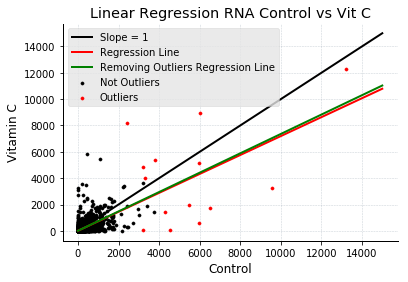

In [105]:
#outliers = ARPE_hMeDIP_outliers["cAMP_Average"].values
fig, tmp = plt.subplots()
ax = SC_cAMP_RNA_removing_outliers.plot.scatter(y = "cAMP_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_cAMP_RNA_outliers["cAMP_Average"], x = SC_cAMP_RNA_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 15000, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression RNA Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model_RNA.params
x = sc.linspace(0, 15000, 10)
y = parameters[0] + parameters[1]*x


outlier_parameters = outliers_removed_model_RNA.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_cAMP_RNA_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


I was surprised to find that removing the outliers Did almost nothing but a slight shift toward a slope of 1. The R2 values were low (~43% in the outliers removed model). I am not sure what to think, but I will remove the outliers.

In [106]:
print(len(SC_cAMP_RNA_removing_outliers))
print(len(SC_cAMP_RNA_first_RCPM_averages))
print(len(SC_cAMP_RNA_outliers))

# Difference of 14, which is the number of outliers

32869
32883
14


In [107]:
remove_outliers_RNA = SC_cAMP_Raw_RNA_data.drop(SC_cAMP_RNA_outliers.index, axis = 0)


In [108]:
total_counts_removing_outliers_RNA = remove_outliers_RNA.sum(axis=0)

In [109]:
total_counts_removing_outliers_RNA

SC_Control_01           2.507623e+07
SC_Control_02           3.351316e+07
SC_Control_03           3.202509e+07
SC_cAMP_01              3.427727e+07
SC_cAMP_02              3.376630e+07
SC_cAMP_03              3.328441e+07
Control_1_first_RCPM    9.203484e+05
Control_2_first_RCPM    9.243422e+05
Control_3_first_RCPM    9.230722e+05
cAMP_1_first_RCPM       9.427393e+05
cAMP_2_first_RCPM       9.419763e+05
cAMP_3_first_RCPM       9.415759e+05
Control_Average         9.225876e+05
cAMP_Average            9.420972e+05
dtype: float64

In [110]:
SC_cAMP_Raw_RNA_data.head()

SC_Control_01  SC_Control_02  SC_Control_03  SC_cAMP_01  \
Gene_ID                                                                       
ENSRNOG00000000001             70             91             93          91   
ENSRNOG00000000007              2              2              2           1   
ENSRNOG00000000008             16             20             18           5   
ENSRNOG00000000009              2              4              2           4   
ENSRNOG00000000010             76             90             79           0   

                    SC_cAMP_02  SC_cAMP_03  Control_1_first_RCPM  \
Gene_ID                                                            
ENSRNOG00000000001          60          79              2.569141   
ENSRNOG00000000007           0           0              0.073404   
ENSRNOG00000000008           3           4              0.587232   
ENSRNOG00000000009           2           6              0.073404   
ENSRNOG00000000010           1           0              2.789353   

                    Control_2_first_RCPM  Control_3_first_RCPM  \
Gene_ID                                                          
ENSRNOG00000000001              2.509913              2.680577   
ENSRNOG00000000007              0.055163              0.057647   
ENSRNOG00000000008              0.551629              0.518821   
ENSRNOG00000000009              0.110326              0.057647   
ENSRNOG00000000010              2.482332              2.277049   

                    cAMP_1_first_RCPM  cAMP_2_first_RCPM  cAMP_3_first_RCPM  \
Gene_ID                                                                       
ENSRNOG00000000001           2.502804           1.673816           2.234815   
ENSRNOG00000000007           0.027503           0.000000           0.000000   
ENSRNOG00000000008           0.137517           0.083691           0.113155   
ENSRNOG00000000009           0.110013           0.055794           0.169733   
ENSRNOG00000000010           0.000000           0.027897           0.000000   

                    Control_Average  cAMP_Average  
Gene_ID                                            
ENSRNOG00000000001         2.586544      2.137145  
ENSRNOG00000000007         0.062071      0.009168  
ENSRNOG00000000008         0.552561      0.111454  
ENSRNOG00000000009         0.080459      0.111847  
ENSRNOG00000000010         2.516245      0.009299

In [111]:
SC_cAMP_Raw_RNA_data["SC_Control_1_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_removing_outliers_RNA[0]
SC_cAMP_Raw_RNA_data["SC_Control_2_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_removing_outliers_RNA[1]
SC_cAMP_Raw_RNA_data["SC_Control_3_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_removing_outliers_RNA[2]
SC_cAMP_Raw_RNA_data["SC_cAMP_1_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_01"]*1000000/total_counts_removing_outliers_RNA[3]
SC_cAMP_Raw_RNA_data["SC_cAMP_2_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_02"]*1000000/total_counts_removing_outliers_RNA[4]
SC_cAMP_Raw_RNA_data["SC_cAMP_3_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_03"]*1000000/total_counts_removing_outliers_RNA[5]
SC_cAMP_RNA_Corrected_RCPM = SC_cAMP_Raw_RNA_data[["SC_Control_1_RCPM", "SC_Control_2_RCPM", "SC_Control_3_RCPM", "SC_cAMP_1_RCPM", "SC_cAMP_2_RCPM", "SC_cAMP_3_RCPM"]]

In [112]:
SC_cAMP_RNA_Corrected_RCPM.head()

SC_Control_1_RCPM  SC_Control_2_RCPM  SC_Control_3_RCPM  \
Gene_ID                                                                       
ENSRNOG00000000001           2.791488           2.715351           2.903973   
ENSRNOG00000000007           0.079757           0.059678           0.062451   
ENSRNOG00000000008           0.638054           0.596780           0.562059   
ENSRNOG00000000009           0.079757           0.119356           0.062451   
ENSRNOG00000000010           3.030758           2.685512           2.466816   

                    SC_cAMP_1_RCPM  SC_cAMP_2_RCPM  SC_cAMP_3_RCPM  
Gene_ID                                                             
ENSRNOG00000000001        2.654820        1.776920        2.373483  
ENSRNOG00000000007        0.029174        0.000000        0.000000  
ENSRNOG00000000008        0.145869        0.088846        0.120176  
ENSRNOG00000000009        0.116695        0.059231        0.180265  
ENSRNOG00000000010        0.000000        0.029615        0.000000

In [113]:
SC_cAMP_RNA_Corrected_RCPM.to_csv(Output_Path+"SC_cAMP_RNA_RCPM_table.csv")

In [114]:
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )


In [115]:
Rat_Genomic_Info_File.dtypes # It looks like I don't need to specify the types because the lengths and positions went in as int

Gene_Name             object
Location              object
Sense                 object
Gene_Biotype          object
transcript_id         object
Chr                   object
Start                  int64
Stop                   int64
Length                 int64
Exon Length            int64
Intron Length          int64
Gene_ID               object
gene_version           int64
transcript_version     int64
gene_name             object
gene_source           object
gene_biotype          object
transcript_name       object
transcript_source     object
transcript_biotype    object
dtype: object

In [116]:
Rat_Genomic_Info_File.head()

Gene_Name                  Location Sense  \
Ensembl_ID                                                           
ENSRNOG00000000001  AABR07013255.1  chr2:230660664-230662084     +   
ENSRNOG00000000007            Gad1    chr3:56861396-56902157     +   
ENSRNOG00000000008            Alx4    chr3:82548959-82585531     +   
ENSRNOG00000000009          Tmco5b  chr3:104749051-104765436     +   
ENSRNOG00000000010           Cbln1   chr19:20607507-20611316     +   

                      Gene_Biotype       transcript_id Chr      Start  \
Ensembl_ID                                                              
ENSRNOG00000000001      pseudogene  ENSRNOT00000055633   2  230660664   
ENSRNOG00000000007  protein_coding  ENSRNOT00000087712   3   56862691   
ENSRNOG00000000008  protein_coding  ENSRNOT00000000009   3   82548959   
ENSRNOG00000000009  protein_coding  ENSRNOT00000000010   3  104749051   
ENSRNOG00000000010  protein_coding  ENSRNOT00000000011  19   20607507   

                         Stop  Length  Exon Length  Intron Length  \
Ensembl_ID                                                          
ENSRNOG00000000001  230662084    1421         1416              5   
ENSRNOG00000000007   56902137   39447         3381          36066   
ENSRNOG00000000008   82585531   36573         1747          34826   
ENSRNOG00000000009  104765436   16386         1361          15025   
ENSRNOG00000000010   20611316    3810         2444           1366   

                               Gene_ID  gene_version  transcript_version  \
Ensembl_ID                                                                 
ENSRNOG00000000001  ENSRNOG00000000001             5                   2   
ENSRNOG00000000007  ENSRNOG00000000007             7                   1   
ENSRNOG00000000008  ENSRNOG00000000008             7                   5   
ENSRNOG00000000009  ENSRNOG00000000009             5                   5   
ENSRNOG00000000010  ENSRNOG00000000010             5                   5   

                         gene_name gene_source    gene_biotype  \
Ensembl_ID                                                       
ENSRNOG00000000001  AABR07013255.1     ensembl      pseudogene   
ENSRNOG00000000007            Gad1     ensembl  protein_coding   
ENSRNOG00000000008            Alx4     ensembl  protein_coding   
ENSRNOG00000000009          Tmco5b     ensembl  protein_coding   
ENSRNOG00000000010           Cbln1     ensembl  protein_coding   

                       transcript_name transcript_source transcript_biotype  
Ensembl_ID                                                                   
ENSRNOG00000000001  AABR07013255.1-201           ensembl         pseudogene  
ENSRNOG00000000007            Gad1-204           ensembl     protein_coding  
ENSRNOG00000000008            Alx4-201           ensembl     protein_coding  
ENSRNOG00000000009          Tmco5b-201           ensembl     protein_coding  
ENSRNOG00000000010           Cbln1-201           ensembl     protein_coding

In [117]:
SC_cAMP_RNA_Corrected_RCPM = SC_cAMP_RNA_Corrected_RCPM.join(Rat_Genomic_Info_File)

In [118]:
SC_cAMP_RNA_Corrected_RCPM.head()

SC_Control_1_RCPM  SC_Control_2_RCPM  SC_Control_3_RCPM  \
Gene_ID                                                                       
ENSRNOG00000000001           2.791488           2.715351           2.903973   
ENSRNOG00000000007           0.079757           0.059678           0.062451   
ENSRNOG00000000008           0.638054           0.596780           0.562059   
ENSRNOG00000000009           0.079757           0.119356           0.062451   
ENSRNOG00000000010           3.030758           2.685512           2.466816   

                    SC_cAMP_1_RCPM  SC_cAMP_2_RCPM  SC_cAMP_3_RCPM  \
Gene_ID                                                              
ENSRNOG00000000001        2.654820        1.776920        2.373483   
ENSRNOG00000000007        0.029174        0.000000        0.000000   
ENSRNOG00000000008        0.145869        0.088846        0.120176   
ENSRNOG00000000009        0.116695        0.059231        0.180265   
ENSRNOG00000000010        0.000000        0.029615        0.000000   

                         Gene_Name                  Location Sense  \
Gene_ID                                                              
ENSRNOG00000000001  AABR07013255.1  chr2:230660664-230662084     +   
ENSRNOG00000000007            Gad1    chr3:56861396-56902157     +   
ENSRNOG00000000008            Alx4    chr3:82548959-82585531     +   
ENSRNOG00000000009          Tmco5b  chr3:104749051-104765436     +   
ENSRNOG00000000010           Cbln1   chr19:20607507-20611316     +   

                      Gene_Biotype         ...         Intron Length  \
Gene_ID                                    ...                         
ENSRNOG00000000001      pseudogene         ...                     5   
ENSRNOG00000000007  protein_coding         ...                 36066   
ENSRNOG00000000008  protein_coding         ...                 34826   
ENSRNOG00000000009  protein_coding         ...                 15025   
ENSRNOG00000000010  protein_coding         ...                  1366   

                               Gene_ID  gene_version  transcript_version  \
Gene_ID                                                                    
ENSRNOG00000000001  ENSRNOG00000000001             5                   2   
ENSRNOG00000000007  ENSRNOG00000000007             7                   1   
ENSRNOG00000000008  ENSRNOG00000000008             7                   5   
ENSRNOG00000000009  ENSRNOG00000000009             5                   5   
ENSRNOG00000000010  ENSRNOG00000000010             5                   5   

                         gene_name  gene_source    gene_biotype  \
Gene_ID                                                           
ENSRNOG00000000001  AABR07013255.1      ensembl      pseudogene   
ENSRNOG00000000007            Gad1      ensembl  protein_coding   
ENSRNOG00000000008            Alx4      ensembl  protein_coding   
ENSRNOG00000000009          Tmco5b      ensembl  protein_coding   
ENSRNOG00000000010           Cbln1      ensembl  protein_coding   

                       transcript_name  transcript_source  transcript_biotype  
Gene_ID                                                                        
ENSRNOG00000000001  AABR07013255.1-201            ensembl          pseudogene  
ENSRNOG00000000007            Gad1-204            ensembl      protein_coding  
ENSRNOG00000000008            Alx4-201            ensembl      protein_coding  
ENSRNOG00000000009          Tmco5b-201            ensembl      protein_coding  
ENSRNOG00000000010           Cbln1-201            ensembl      protein_coding  

[5 rows x 26 columns]

In [119]:
SC_cAMP_RNA_Corrected_RCPM["SC_Control_1_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_Control_1_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_Control_2_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_Control_2_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_Control_3_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_Control_3_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]

SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_1_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_1_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_2_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_2_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_3_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_3_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]


In [120]:
SC_cAMP_RNA_FPKM_table = SC_cAMP_RNA_Corrected_RCPM[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", "SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]]


In [121]:
SC_cAMP_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  
Gene_ID                                                             
ENSRNOG00000000001        1.874873        1.254887        1.676189  
ENSRNOG00000000007        0.008629        0.000000        0.000000  
ENSRNOG00000000008        0.083497        0.050856        0.068790  
ENSRNOG00000000009        0.085742        0.043520        0.132450  
ENSRNOG00000000010        0.000000        0.012118        0.000000

In [122]:
#SC_cAMP_RNA_FPKM_table.to_csv(Output_Path+"SC_cAMP_RNA_FPKM_table.csv")
#SC_cAMP_RNA_FPKM_table.to_pickle(Output_Path+"SC_cAMP_RNA_FPKM_table.pkl")


Now I have the FPKM table for the RNA. Next I need to read in the statistical files (edgeR and DESeq2) and calculate fold changes to determine which direction each gene goes. When I did this for the hMeDIP, none of them had values of 0 so I didn't need to worry about dividing by infinity. For this one, I needed to make up a lambda function for an if statement if the values were below 0.1 for both cAMP and Control.

In [123]:
SC_cAMP_RNA_FPKM_table["Control_Average_FPKM"] = SC_cAMP_RNA_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_2_FPKM"]].mean(axis=1)
SC_cAMP_RNA_FPKM_table["cAMP_Average_FPKM"] = SC_cAMP_RNA_FPKM_table[["SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]].mean(axis=1)
SC_cAMP_RNA_FPKM_table["Fold_Change"] =  SC_cAMP_RNA_FPKM_table.apply(lambda x: 1 if max(x["cAMP_Average_FPKM"],x["Control_Average_FPKM"]) < 0.1 else (x["cAMP_Average_FPKM"]/x["Control_Average_FPKM"]), axis = 1)


SC_cAMP_RNA_FPKM_table["Log2FC"] = np.log2(SC_cAMP_RNA_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3

In [124]:
SC_cAMP_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  \
Gene_ID                                                              
ENSRNOG00000000001        1.874873        1.254887        1.676189   
ENSRNOG00000000007        0.008629        0.000000        0.000000   
ENSRNOG00000000008        0.083497        0.050856        0.068790   
ENSRNOG00000000009        0.085742        0.043520        0.132450   
ENSRNOG00000000010        0.000000        0.012118        0.000000   

                    Control_Average_FPKM  cAMP_Average_FPKM  Fold_Change  \
Gene_ID                                                                    
ENSRNOG00000000001              1.935544           1.601983     0.827666   
ENSRNOG00000000007              0.019631           0.002876     1.000000   
ENSRNOG00000000008              0.349478           0.067714     0.193759   
ENSRNOG00000000009              0.077999           0.087237     1.000000   
ENSRNOG00000000010              1.145906           0.004039     0.003525   

                      Log2FC  
Gene_ID                       
ENSRNOG00000000001 -0.272880  
ENSRNOG00000000007  0.000000  
ENSRNOG00000000008 -2.367666  
ENSRNOG00000000009  0.000000  
ENSRNOG00000000010 -8.148208

In [125]:
SC_cAMP_RNA_edgeR = pd.read_csv(Input_RNA_edgeR, sep = ",", index_col=0) 
SC_cAMP_RNA_edgeR = SC_cAMP_RNA_edgeR.drop(['logFC', 'logCPM', 'LR', 'PValue'], axis = 1)
SC_cAMP_RNA_edgeR.columns=["edgeR"]

SC_cAMP_RNA_DESeq2 = pd.read_csv(Input_RNA_DESeq2, sep = ",", index_col=0)
SC_cAMP_RNA_DESeq2 = SC_cAMP_RNA_DESeq2.drop(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue'], axis = 1)
SC_cAMP_RNA_DESeq2.columns = ["DESeq2"]
SC_cAMP_RNA_DESeq2 = SC_cAMP_RNA_DESeq2.fillna(1)

In [126]:
SC_cAMP_RNA_edgeR.head()

edgeR
Gene_ID                  
ENSRNOG00000015159    0.0
ENSRNOG00000001528    0.0
ENSRNOG00000029318    0.0
ENSRNOG00000013306    0.0
ENSRNOG00000015093    0.0

In [127]:
SC_cAMP_RNA_DESeq2.head()

DESeq2
Gene_ID                   
ENSRNOG00000001607     0.0
ENSRNOG00000001807     0.0
ENSRNOG00000002050     0.0
ENSRNOG00000002171     0.0
ENSRNOG00000002403     0.0

In [128]:
SC_cAMP_RNA_FPKM_table = SC_cAMP_RNA_FPKM_table.join([SC_cAMP_RNA_edgeR, SC_cAMP_RNA_DESeq2])

In [129]:
SC_cAMP_RNA_FPKM_table.head(15)

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   
ENSRNOG00000000012           0.000000           0.000000           0.000000   
ENSRNOG00000000017           2.492400           2.354485           2.439494   
ENSRNOG00000000021           7.510432           5.942938           8.196699   
ENSRNOG00000000024          10.213677           9.552982           8.703158   
ENSRNOG00000000033           6.261808           6.590362           6.743898   
ENSRNOG00000000034           1.234497           1.318106           1.759490   
ENSRNOG00000000035           0.061827           0.000000           0.048412   
ENSRNOG00000000036           0.000000           0.000000           0.000000   
ENSRNOG00000000040           4.064102           4.500051           3.900355   
ENSRNOG00000000041           0.075222           0.056285           0.008414   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  \
Gene_ID                                                              
ENSRNOG00000000001        1.874873        1.254887        1.676189   
ENSRNOG00000000007        0.008629        0.000000        0.000000   
ENSRNOG00000000008        0.083497        0.050856        0.068790   
ENSRNOG00000000009        0.085742        0.043520        0.132450   
ENSRNOG00000000010        0.000000        0.012118        0.000000   
ENSRNOG00000000012        0.117518        0.149120        0.090768   
ENSRNOG00000000017        0.341881        0.439603        0.305135   
ENSRNOG00000000021        5.470097        5.849027        5.332827   
ENSRNOG00000000024        3.571187        4.378160        2.659270   
ENSRNOG00000000033        6.316642        5.865138        6.219397   
ENSRNOG00000000034        0.060885        0.072107        0.062701   
ENSRNOG00000000035        0.000000        0.045915        0.000000   
ENSRNOG00000000036        0.018239        0.037031        0.009392   
ENSRNOG00000000040        0.282487        0.258086        0.327278   
ENSRNOG00000000041        0.455964        0.311236        0.250975   

                    Control_Average_FPKM  cAMP_Average_FPKM  Fold_Change  \
Gene_ID                                                                    
ENSRNOG00000000001              1.935544           1.601983     0.827666   
ENSRNOG00000000007              0.019631           0.002876     1.000000   
ENSRNOG00000000008              0.349478           0.067714     0.193759   
ENSRNOG00000000009              0.077999           0.087237     1.000000   
ENSRNOG00000000010              1.145906           0.004039     0.003525   
ENSRNOG00000000012              0.000000           0.119135          inf   
ENSRNOG00000000017              2.400457           0.362206     0.150891   
ENSRNOG00000000021              6.465436           5.550650     0.858511   
ENSRNOG00000000024              9.773214           3.536206     0.361826   
ENSRNOG00000000033              6.480844           6.133725     0.946439   
ENSRNOG00000000034              1.290236           0.065231     0.050557   
ENSRNOG00000000035              0.020609           0.015305     1.000000   
ENSRNOG00000000036              0.000000           0.021554     1.000000   
ENSRNOG00000000040              4.354735           0.289283     0.066430   
ENSRNOG00000000041              0.062597           0.339392     5.421832   

                      Log2FC         edgeR        DESeq2  
Gene_ID                                                   
ENSRNOG00000000001 -0.272880  3.624964e-01  2.684509e-01  
ENSRNOG00000000

In [130]:
#SC_cAMP_RNA_FPKM_table.loc["ENSRNOG00000008000"] # This went in correctly

In [131]:
# This definition will mistakenly put "downregulated" for ones with good P-values by both but a fold change of 1
# These ones will be filtered out in the next step, finding limit of detection
def direction(row):
    if row["edgeR"] < 0.05 and row["DESeq2"] < 0.05:
        if row["Log2FC"] > 0:
            return "Upregulated"
        else:
            return "Downregulated"
    else:
        return "Nondifferential"

SC_cAMP_RNA_FPKM_table["Change"] =  SC_cAMP_RNA_FPKM_table.apply(direction, axis = 1)
# I figured out how to make it faster :)

In [132]:
SC_cAMP_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  \
Gene_ID                                                              
ENSRNOG00000000001        1.874873        1.254887        1.676189   
ENSRNOG00000000007        0.008629        0.000000        0.000000   
ENSRNOG00000000008        0.083497        0.050856        0.068790   
ENSRNOG00000000009        0.085742        0.043520        0.132450   
ENSRNOG00000000010        0.000000        0.012118        0.000000   

                    Control_Average_FPKM  cAMP_Average_FPKM  Fold_Change  \
Gene_ID                                                                    
ENSRNOG00000000001              1.935544           1.601983     0.827666   
ENSRNOG00000000007              0.019631           0.002876     1.000000   
ENSRNOG00000000008              0.349478           0.067714     0.193759   
ENSRNOG00000000009              0.077999           0.087237     1.000000   
ENSRNOG00000000010              1.145906           0.004039     0.003525   

                      Log2FC         edgeR        DESeq2           Change  
Gene_ID                                                                    
ENSRNOG00000000001 -0.272880  3.624964e-01  2.684509e-01  Nondifferential  
ENSRNOG00000000007  0.000000  9.810661e-02  2.310657e-01  Nondifferential  
ENSRNOG00000000008 -2.367666  9.720000e-07  4.287680e-04    Downregulated  
ENSRNOG00000000009  0.000000  9.094232e-01  7.663421e-01  Nondifferential  
ENSRNOG00000000010 -8.148208  2.150000e-47  3.630000e-15    Downregulated

In [133]:
SC_cAMP_RNA_FPKM_table.to_csv(Output_Path+"SC_cAMP_RNA_FPKM_table.csv")
SC_cAMP_RNA_FPKM_table.to_pickle(Output_Path+"SC_cAMP_RNA_FPKM_table.pkl")

Now I have the FPKM table calculated out and I have determined which ones go up and down, but I have not filtered out genes that are really lowly expressed. The next step is to take those out because they will not add information to our analysis, but just add noise.

Now I am going to calculate the FPKM values for the genomic input samples. I am going to see if I can use these to determine a cutoff LOD for the RNA. Luckily, I don't need to worry about outliers for this one because it is genomic input and I want to include those ones if there is something funky because it might transfer across the other sequencing files too.

In [134]:
SC_cAMP_genomic_input_raw = pd.read_csv(Input_Genomic_Input_Counts_File, sep = "\t", index_col = 0)

In [135]:
SC_cAMP_genomic_input_raw.head()

SC_Control_1_IN  SC_Control_2_IN  SC_Control_3_IN  \
Peak_Name                                                                    
Merged.cAMP_peak_100                  27               39               26   
Merged.cAMP_peak_10000                30               26               26   
Merged.cAMP_peak_100003               34               39               43   
Merged.cAMP_peak_100004               22               13               15   
Merged.cAMP_peak_100007               17               23               25   

                         SC_cAMP_1_IN  SC_cAMP_2_IN  SC_cAMP_3_IN  
Peak_Name                                                          
Merged.cAMP_peak_100               13            26            27  
Merged.cAMP_peak_10000             19            33            30  
Merged.cAMP_peak_100003            19            28            38  
Merged.cAMP_peak_100004            10            15            18  
Merged.cAMP_peak_100007            12            17            16

In [136]:
total_counts_SC_cAMP_genomic_input = SC_cAMP_genomic_input_raw.sum(axis=0)

In [137]:
total_counts_SC_cAMP_genomic_input

SC_Control_1_IN    58705176
SC_Control_2_IN    80394782
SC_Control_3_IN    53895360
SC_cAMP_1_IN       56923555
SC_cAMP_2_IN       44195649
SC_cAMP_3_IN       60174118
dtype: int64

In [138]:
SC_cAMP_genomic_input_raw["SC_Control_1_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_Control_1_IN"]*1000000/total_counts_SC_cAMP_genomic_input[0]
SC_cAMP_genomic_input_raw["SC_Control_2_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_Control_2_IN"]*1000000/total_counts_SC_cAMP_genomic_input[1]
SC_cAMP_genomic_input_raw["SC_Control_3_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_Control_3_IN"]*1000000/total_counts_SC_cAMP_genomic_input[2]


SC_cAMP_genomic_input_raw["SC_cAMP_1_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_cAMP_1_IN"]*1000000/total_counts_SC_cAMP_genomic_input[3]
SC_cAMP_genomic_input_raw["SC_cAMP_2_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_cAMP_2_IN"]*1000000/total_counts_SC_cAMP_genomic_input[4]
SC_cAMP_genomic_input_raw["SC_cAMP_3_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_cAMP_3_IN"]*1000000/total_counts_SC_cAMP_genomic_input[5]


In [139]:
SC_cAMP_genomic_input_rcpm = SC_cAMP_genomic_input_raw[["SC_Control_1_IN_RCPM", "SC_Control_2_IN_RCPM", "SC_Control_3_IN_RCPM", "SC_cAMP_1_IN_RCPM", "SC_cAMP_2_IN_RCPM", "SC_cAMP_3_IN_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [140]:
SC_cAMP_genomic_input_rcpm.tail()


SC_Control_1_IN_RCPM  \
Peak_Name                                                                
Merged.control_peak_99972                                     0.357720   
Merged.control_peak_99982                                     0.391788   
Merged.control_peak_99992,Merged.cAMP_peak_89678              0.715439   
Merged.control_peak_99996                                     0.221446   
Merged.control_peak_99997                                     0.425857   

                                                  SC_Control_2_IN_RCPM  \
Peak_Name                                                                
Merged.control_peak_99972                                     0.199018   
Merged.control_peak_99982                                     0.335843   
Merged.control_peak_99992,Merged.cAMP_peak_89678              0.385597   
Merged.control_peak_99996                                     0.223895   
Merged.control_peak_99997                                     0.348281   

                                                  SC_Control_3_IN_RCPM  \
Peak_Name                                                                
Merged.control_peak_99972                                     0.371089   
Merged.control_peak_99982                                     0.278317   
Merged.control_peak_99992,Merged.cAMP_peak_89678              0.575189   
Merged.control_peak_99996                                     0.185545   
Merged.control_peak_99997                                     0.371089   

                                                  SC_cAMP_1_IN_RCPM  \
Peak_Name                                                             
Merged.control_peak_99972                                  0.281079   
Merged.control_peak_99982                                  0.281079   
Merged.control_peak_99992,Merged.cAMP_peak_89678           0.527023   
Merged.control_peak_99996                                  0.281079   
Merged.control_peak_99997                                  0.368916   

                                                  SC_cAMP_2_IN_RCPM  \
Peak_Name                                                             
Merged.control_peak_99972                                  0.294147   
Merged.control_peak_99982                                  0.271520   
Merged.control_peak_99992,Merged.cAMP_peak_89678           0.339400   
Merged.control_peak_99996                                  0.271520   
Merged.control_peak_99997                                  0.203640   

                                                  SC_cAMP_3_IN_RCPM  
Peak_Name                                                            
Merged.control_peak_99972                                  0.232658  
Merged.control_peak_99982                                  0.432079  
Merged.control_peak_99992,Merged.cAMP_peak_89678           0.498553  
Merged.control_peak_99996                                  0.265895  
Merged.control_peak_99997                                  0.282513

In [141]:
SC_cAMP_genomic_input_rcpm.to_csv(Output_Path+"SC_cAMP_Genomic_Input_RCPM_table.csv")

In [142]:
SC_cAMP_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3) 
SC_cAMP_hMeDIP_bed["Width"] = (SC_cAMP_hMeDIP_bed["Stop"] - SC_cAMP_hMeDIP_bed["Start"] + 1)

In [143]:
SC_cAMP_hMeDIP_bed.head()

Chr     Start      Stop  Width
Peak_Name                                             
Merged.cAMP_peak_100      1   1967917   1968676    760
Merged.cAMP_peak_10000    1  56166555  56167312    758
Merged.cAMP_peak_100003  13  50411889  50412871    983
Merged.cAMP_peak_100004  13  50421254  50421647    394
Merged.cAMP_peak_100007  13  50424220  50424677    458

In [144]:
SC_cAMP_genomic_input_rcpm = SC_cAMP_genomic_input_rcpm.join(SC_cAMP_hMeDIP_bed)

In [145]:
SC_cAMP_genomic_input_rcpm["SC_Control_1_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_Control_1_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_Control_2_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_Control_2_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_Control_3_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_Control_3_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]

SC_cAMP_genomic_input_rcpm["SC_cAMP_1_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_cAMP_1_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_cAMP_2_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_cAMP_2_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_cAMP_3_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_cAMP_3_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]


In [146]:
SC_cAMP_genomic_input_rcpm.head()

SC_Control_1_IN_RCPM  SC_Control_2_IN_RCPM  \
Peak_Name                                                             
Merged.cAMP_peak_100                 0.459925              0.485106   
Merged.cAMP_peak_10000               0.511028              0.323404   
Merged.cAMP_peak_100003              0.579165              0.485106   
Merged.cAMP_peak_100004              0.374754              0.161702   
Merged.cAMP_peak_100007              0.289583              0.286088   

                         SC_Control_3_IN_RCPM  SC_cAMP_1_IN_RCPM  \
Peak_Name                                                          
Merged.cAMP_peak_100                 0.482416           0.228376   
Merged.cAMP_peak_10000               0.482416           0.333781   
Merged.cAMP_peak_100003              0.797842           0.333781   
Merged.cAMP_peak_100004              0.278317           0.175674   
Merged.cAMP_peak_100007              0.463862           0.210809   

                         SC_cAMP_2_IN_RCPM  SC_cAMP_3_IN_RCPM Chr     Start  \
Peak_Name                                                                     
Merged.cAMP_peak_100              0.588293           0.448698   1   1967917   
Merged.cAMP_peak_10000            0.746680           0.498553   1  56166555   
Merged.cAMP_peak_100003           0.633547           0.631501  13  50411889   
Merged.cAMP_peak_100004           0.339400           0.299132  13  50421254   
Merged.cAMP_peak_100007           0.384653           0.265895  13  50424220   

                             Stop  Width  SC_Control_1_IN_FPKM  \
Peak_Name                                                        
Merged.cAMP_peak_100      1968676    760              0.605165   
Merged.cAMP_peak_10000   56167312    758              0.674180   
Merged.cAMP_peak_100003  50412871    983              0.589181   
Merged.cAMP_peak_100004  50421647    394              0.951152   
Merged.cAMP_peak_100007  50424677    458              0.632277   

                         SC_Control_2_IN_FPKM  SC_Control_3_IN_FPKM  \
Peak_Name                                                             
Merged.cAMP_peak_100                 0.638298              0.634758   
Merged.cAMP_peak_10000               0.426654              0.636433   
Merged.cAMP_peak_100003              0.493496              0.811640   
Merged.cAMP_peak_100004              0.410411              0.706389   
Merged.cAMP_peak_100007              0.624647              1.012799   

                         SC_cAMP_1_IN_FPKM  SC_cAMP_2_IN_FPKM  \
Peak_Name                                                       
Merged.cAMP_peak_100              0.300495           0.774070   
Merged.cAMP_peak_10000            0.440344           0.985066   
Merged.cAMP_peak_100003           0.339553           0.644503   
Merged.cAMP_peak_100004           0.445874           0.861421   
Merged.cAMP_peak_100007           0.460282           0.839854   

                         SC_cAMP_3_IN_FPKM  
Peak_Name                                   
Merged.cAMP_peak_100              0.590392  
Merged.cAMP_peak_10000            0.657722  
Merged.cAMP_peak_100003           0.642422  
Merged.cAMP_peak_100004           0.759218  
Merged.cAMP_peak_100007           0.580557

In [147]:
SC_cAMP_genomic_input_rcpm.describe()

SC_Control_1_IN_RCPM  SC_Control_2_IN_RCPM  SC_Control_3_IN_RCPM  \
count         192143.000000         192143.000000         192143.000000   
mean               0.391461              0.351875              0.446925   
std                0.234153              0.200337              0.291197   
min                0.000000              0.012439              0.000000   
25%                0.238480              0.223895              0.259763   
50%                0.340685              0.298527              0.371089   
75%                0.476960              0.422913              0.556634   
max                7.648389              7.848768              9.908089   

       SC_cAMP_1_IN_RCPM  SC_cAMP_2_IN_RCPM  SC_cAMP_3_IN_RCPM         Start  \
count      192143.000000      192143.000000      192143.000000  1.921430e+05   
mean            0.365266           0.447664           0.419764  8.154366e+07   
std             0.204772           0.325828           0.260089  6.153130e+07   
min             0.000000           0.000000           0.000000  1.800000e+01   
25%             0.228376           0.226267           0.249277  3.381977e+07   
50%             0.316214           0.362027           0.365606  6.849322e+07   
75%             0.439186           0.565667           0.515172  1.149180e+08   
max             7.553991           8.847025           8.857629  2.825998e+08   

               Stop          Width  SC_Control_1_IN_FPKM  \
count  1.921430e+05  192143.000000         192143.000000   
mean   8.154434e+07     678.019090              0.582181   
std    6.153131e+07     382.118276              0.168268   
min    4.820000e+02     265.000000              0.000000   
25%    3.382040e+07     434.000000              0.474115   
50%    6.849430e+07     555.000000              0.570867   
75%    1.149185e+08     790.000000              0.677095   
max    2.826003e+08   16749.000000              6.962237   

       SC_Control_2_IN_FPKM  SC_Control_3_IN_FPKM  SC_cAMP_1_IN_FPKM  \
count         192143.000000         192143.000000      192143.000000   
mean               0.526776              0.654762           0.554516   
std                0.135139              0.213077           0.174750   
min                0.035539              0.000000           0.000000   
25%                0.441022              0.516838           0.437969   
50%                0.517198              0.646671           0.533501   
75%                0.602598              0.779115           0.651334   
max                5.083904              9.706972           6.701468   

       SC_cAMP_2_IN_FPKM  SC_cAMP_3_IN_FPKM  
count      192143.000000      192143.000000  
mean            0.649120           0.619863  
std             0.265976           0.188589  
min             0.000000           0.000000  
25%             0.460850           0.500555  
50%             0.625360           0.611381  
75%             0.809541           0.728879  
max             8.939689           8.377143

In [148]:
SC_cAMP_Genomic_Input_FPKM_table = SC_cAMP_genomic_input_rcpm[["SC_Control_1_IN_FPKM", "SC_Control_2_IN_FPKM", "SC_Control_3_IN_FPKM", 
                                                               "SC_cAMP_1_IN_FPKM", "SC_cAMP_2_IN_FPKM", "SC_cAMP_3_IN_FPKM"]]
SC_cAMP_Genomic_Input_FPKM_table.to_csv(Output_Path+"SC_cAMP_Genomic_Input_FPKM_table.csv")
#I am not going to make a pickle file for this one because I don't think we are likely to use it in future analysis

Well, calculating the FPKM for the genomic input without removing outliers was much less painful. Now I can move on to a density plot with genomic input (should have no bias to any region) and RNA. 

The genomic input is just sheared DNA with no form of pull-down. This is meant to show us what kind of coverage you get in each genomic region just by chance of the DNA-sequence. These were generated for calling peaks in the hMeDIP, but can be used her to show what we get if we are just sequencing noise. 

I am going to look at a density plot of the genomic input samples. These are just noise, so if we use a cutoff for limit of detection below the top expressed of these, those ones would essentially be "false positives" as to limit of detection.

When I look at the denisty plot for the RNA, those are annotated genes. In other words, those should be annotated as "above limit of detection", so if I use a cutoff above the most lowly expressed gene, this gives "false negatives" as to the limit of detection. 

I am going to chart both the genomic input samples and the RNA samples on the same graph. Where the two overlap, there will be a minimum between the "false positives" and the "false negatives". This value gives us our limit of detection. (See Trapnell et al. 2012 Nature Protocols)



First I need to take the log10 of each value. It makes it easier to visualize. 

In [149]:

SC_cAMP_Genomic_Input_FPKM_table = pd.read_csv(Output_Path+"SC_cAMP_Genomic_Input_FPKM_table.csv", sep = ",", index_col = 0)
SC_cAMP_RNA_FPKM_table = pd.read_pickle(Output_Path+"SC_cAMP_RNA_FPKM_table.pkl")


In [150]:
SC_cAMP_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  \
Gene_ID                                                              
ENSRNOG00000000001        1.874873        1.254887        1.676189   
ENSRNOG00000000007        0.008629        0.000000        0.000000   
ENSRNOG00000000008        0.083497        0.050856        0.068790   
ENSRNOG00000000009        0.085742        0.043520        0.132450   
ENSRNOG00000000010        0.000000        0.012118        0.000000   

                    Control_Average_FPKM  cAMP_Average_FPKM  Fold_Change  \
Gene_ID                                                                    
ENSRNOG00000000001              1.935544           1.601983     0.827666   
ENSRNOG00000000007              0.019631           0.002876     1.000000   
ENSRNOG00000000008              0.349478           0.067714     0.193759   
ENSRNOG00000000009              0.077999           0.087237     1.000000   
ENSRNOG00000000010              1.145906           0.004039     0.003525   

                      Log2FC         edgeR        DESeq2           Change  
Gene_ID                                                                    
ENSRNOG00000000001 -0.272880  3.624964e-01  2.684509e-01  Nondifferential  
ENSRNOG00000000007  0.000000  9.810661e-02  2.310657e-01  Nondifferential  
ENSRNOG00000000008 -2.367666  9.720000e-07  4.287680e-04    Downregulated  
ENSRNOG00000000009  0.000000  9.094232e-01  7.663421e-01  Nondifferential  
ENSRNOG00000000010 -8.148208  2.150000e-47  3.630000e-15    Downregulated

In [151]:
control_1_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_Control_1_FPKM"].values:
    if i > 0.001:
        control_1_RNA.append(np.log10(i))

control_2_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_Control_2_FPKM"].values:
    if i > 0.001:
        control_2_RNA.append(np.log10(i))

control_3_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_Control_3_FPKM"].values:
    if i > 0.001:
        control_3_RNA.append(np.log10(i))

cAMP_1_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_cAMP_1_FPKM"].values:
    if i > 0.001:
        cAMP_1_RNA.append(np.log10(i))

cAMP_2_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_cAMP_2_FPKM"].values:
    if i > 0.001:
        cAMP_2_RNA.append(np.log10(i))

cAMP_3_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_cAMP_3_FPKM"].values:
    if i > 0.001:
        cAMP_3_RNA.append(np.log10(i))
        


control_1_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_Control_1_IN_FPKM"].values:
    if i > 0.001:
        control_1_INPUT.append(np.log10(i))
        
control_2_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_Control_2_IN_FPKM"].values:
    if i > 0.001:
        control_2_INPUT.append(np.log10(i))
        
control_3_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_Control_3_IN_FPKM"].values:
    if i > 0.001:
        control_3_INPUT.append(np.log10(i))
        
        
cAMP_1_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_cAMP_1_IN_FPKM"].values:
    if i > 0.001:
        cAMP_1_INPUT.append(np.log10(i))
        
cAMP_2_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_cAMP_2_IN_FPKM"].values:
    if i > 0.001:
        cAMP_2_INPUT.append(np.log10(i))

cAMP_3_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_cAMP_3_IN_FPKM"].values:
    if i > 0.001:
        cAMP_3_INPUT.append(np.log10(i))
        

In [152]:
print(len(control_1_RNA))
print(len(control_2_RNA))
print(len(control_3_RNA))
print(len(cAMP_1_RNA))
print(len(cAMP_2_RNA))
print(len(cAMP_3_RNA))
print(len(control_1_INPUT))
print(len(control_2_INPUT))
print(len(control_3_INPUT))
print(len(cAMP_1_INPUT))
print(len(cAMP_2_INPUT))
print(len(cAMP_3_INPUT))
# The lengths are not identical for any of them indicating I didn't accidentally copy over any of them

18326
18864
19348
18189
18333
18247
192136
192143
192129
192137
192071
192131


In [153]:
import itertools

In [154]:
log_tables_list = [control_1_RNA, control_2_RNA, control_3_RNA, cAMP_1_RNA, cAMP_2_RNA, cAMP_3_RNA,
                   control_1_INPUT, control_2_INPUT, control_3_INPUT, cAMP_1_INPUT, cAMP_2_INPUT, cAMP_3_INPUT]
table_of_logs = pd.DataFrame((_ for _ in itertools.zip_longest(*log_tables_list)), columns=["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                                                                                                "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA", 
                                                                                                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT",
                                                                                            "cAMP_1_INPUT", "cAMP_2_INPUT", "cAMP_3_INPUT"])

In [155]:
table_of_logs.head()

control_1_RNA  control_2_RNA  control_3_RNA  cAMP_1_RNA  cAMP_2_RNA  \
0       0.294773       0.282763       0.311929    0.272972    0.098605   
1      -1.627277      -1.753231      -1.733505   -2.064051   -1.293655   
2      -0.437435      -0.466478      -0.492511   -1.078329   -1.361312   
3      -1.232090      -1.057014      -1.338318   -1.066804   -1.916585   
4       0.093450       0.040926       0.004036   -0.929896   -0.826463   

   cAMP_3_RNA  control_1_INPUT  control_2_INPUT  control_3_INPUT  \
0    0.224323        -0.218126        -0.194977        -0.197392   
1   -1.162474        -0.171224        -0.369924        -0.196247   
2   -0.877948        -0.229751        -0.306717        -0.090636   
3   -1.042069        -0.021750        -0.386781        -0.150956   
4   -0.515508        -0.199093        -0.204366         0.005523   

   cAMP_1_INPUT  cAMP_2_INPUT  cAMP_3_INPUT  
0     -0.522162     -0.111220     -0.228860  
1     -0.356208     -0.006535     -0.181958  
2     -0.469092     -0.190775     -0.192180  
3     -0.350788     -0.064784     -0.119633  
4     -0.336976     -0.075796     -0.236155

In [156]:
import seaborn as sns

/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


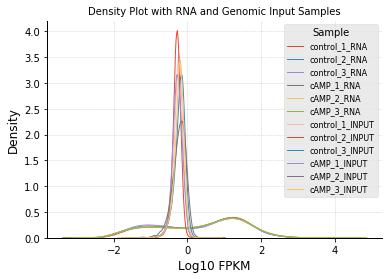

In [157]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA", 
                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", 
                "cAMP_1_INPUT", "cAMP_2_INPUT", "cAMP_3_INPUT"]

fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_cAMP_RNA_LOD_Chart.png", dpi=300) # size above specified at 10x6


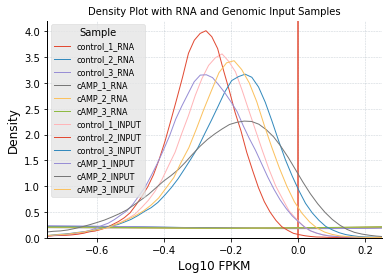

In [158]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA", 
                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", 
                "cAMP_1_INPUT", "cAMP_2_INPUT", "cAMP_3_INPUT"]


fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=0)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_cAMP_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

From the graphs above, we can see that they cross at about 0. This is log base 10, so this converts to 1 FPKM. I am going to use 1 as my limit of detection for simplicity. Moving forward, I am going to keep genes that have one or both sample types averages above 1 FPKM. These are the ones that will be used for further analysis.

In [159]:
SC_cAMP_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  \
Gene_ID                                                              
ENSRNOG00000000001        1.874873        1.254887        1.676189   
ENSRNOG00000000007        0.008629        0.000000        0.000000   
ENSRNOG00000000008        0.083497        0.050856        0.068790   
ENSRNOG00000000009        0.085742        0.043520        0.132450   
ENSRNOG00000000010        0.000000        0.012118        0.000000   

                    Control_Average_FPKM  cAMP_Average_FPKM  Fold_Change  \
Gene_ID                                                                    
ENSRNOG00000000001              1.935544           1.601983     0.827666   
ENSRNOG00000000007              0.019631           0.002876     1.000000   
ENSRNOG00000000008              0.349478           0.067714     0.193759   
ENSRNOG00000000009              0.077999           0.087237     1.000000   
ENSRNOG00000000010              1.145906           0.004039     0.003525   

                      Log2FC         edgeR        DESeq2           Change  
Gene_ID                                                                    
ENSRNOG00000000001 -0.272880  3.624964e-01  2.684509e-01  Nondifferential  
ENSRNOG00000000007  0.000000  9.810661e-02  2.310657e-01  Nondifferential  
ENSRNOG00000000008 -2.367666  9.720000e-07  4.287680e-04    Downregulated  
ENSRNOG00000000009  0.000000  9.094232e-01  7.663421e-01  Nondifferential  
ENSRNOG00000000010 -8.148208  2.150000e-47  3.630000e-15    Downregulated

In [160]:
SC_cAMP_RNA_FPKM_table["Expressed"] = SC_cAMP_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["cAMP_Average_FPKM"] > 1 or x["Control_Average_FPKM"] > 1) else "Below_LOD", axis = 1)

In [161]:
SC_cAMP_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Gene_ID                                                                       
ENSRNOG00000000001           1.971390           1.917621           2.050829   
ENSRNOG00000000007           0.023590           0.017651           0.018471   
ENSRNOG00000000008           0.365229           0.341603           0.321728   
ENSRNOG00000000009           0.058602           0.087697           0.045886   
ENSRNOG00000000010           1.240081           1.098818           1.009336   

                    SC_cAMP_1_FPKM  SC_cAMP_2_FPKM  SC_cAMP_3_FPKM  \
Gene_ID                                                              
ENSRNOG00000000001        1.874873        1.254887        1.676189   
ENSRNOG00000000007        0.008629        0.000000        0.000000   
ENSRNOG00000000008        0.083497        0.050856        0.068790   
ENSRNOG00000000009        0.085742        0.043520        0.132450   
ENSRNOG00000000010        0.000000        0.012118        0.000000   

                    Control_Average_FPKM  cAMP_Average_FPKM  Fold_Change  \
Gene_ID                                                                    
ENSRNOG00000000001              1.935544           1.601983     0.827666   
ENSRNOG00000000007              0.019631           0.002876     1.000000   
ENSRNOG00000000008              0.349478           0.067714     0.193759   
ENSRNOG00000000009              0.077999           0.087237     1.000000   
ENSRNOG00000000010              1.145906           0.004039     0.003525   

                      Log2FC         edgeR        DESeq2           Change  \
Gene_ID                                                                     
ENSRNOG00000000001 -0.272880  3.624964e-01  2.684509e-01  Nondifferential   
ENSRNOG00000000007  0.000000  9.810661e-02  2.310657e-01  Nondifferential   
ENSRNOG00000000008 -2.367666  9.720000e-07  4.287680e-04    Downregulated   
ENSRNOG00000000009  0.000000  9.094232e-01  7.663421e-01  Nondifferential   
ENSRNOG00000000010 -8.148208  2.150000e-47  3.630000e-15    Downregulated   

                    Expressed  
Gene_ID                        
ENSRNOG00000000001  Expressed  
ENSRNOG00000000007  Below_LOD  
ENSRNOG00000000008  Below_LOD  
ENSRNOG00000000009  Below_LOD  
ENSRNOG00000000010  Expressed

In [162]:
SC_cAMP_Expressed_Genes = SC_cAMP_RNA_FPKM_table[SC_cAMP_RNA_FPKM_table["Expressed"] == "Expressed"]

In [163]:
len(SC_cAMP_Expressed_Genes)
# We have 12,165 genes left that are expressed

12165

I am a little bummed to see that we only have 12,165 genes left, but this matches what I got with the other Rat cell dataset. I think we have more that are really detectable, but this matches the other one. Additionally, the two hump minimum method (below) matches around 0. I think it is fine. 


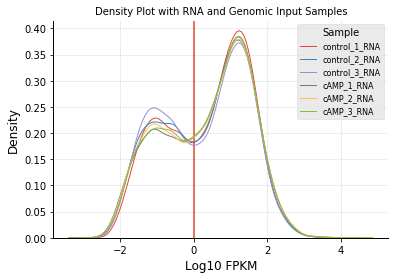

In [164]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
#ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=0)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_cAMP_RNA_LOD_using_RNA_only.png", dpi=300) # size above specified at 10x6

If I change the line to -0.15, it changes the LOD to only 0.71, which I think is more reasonable. I am going to try that. 

In [165]:
print("Downregulated Genes:", len(SC_cAMP_Expressed_Genes[SC_cAMP_Expressed_Genes["Change"] == "Downregulated"]))
print("Upregulated Genes:",len(SC_cAMP_Expressed_Genes[SC_cAMP_Expressed_Genes["Change"] == "Upregulated"]))
print("Nondifferential Genes:",len(SC_cAMP_Expressed_Genes[SC_cAMP_Expressed_Genes["Change"] == "Nondifferential"]))

Downregulated Genes: 3867
Upregulated Genes: 4345
Nondifferential Genes: 3953


In [166]:
SC_cAMP_Expressed_Genes.to_csv(Output_Path+"SC_cAMP_Expressed_RNA.csv")
SC_cAMP_Expressed_Genes.to_pickle(Output_Path+"SC_cAMP_Expressed_RNA.pkl")

We can see that we have 1,984 genes that go up and 1,798 genes that go down after treatement with vitamin C. This is much lower than the 8,370 genes that do not change after treatment. This matches the assumption that most genes will not change, and indicates that our treatment was not too extreme.

Now I have a table of the expressed genes, as well as the information about how they react to vitamin C treatment.
The next step is going to be to integrate this with the information that we have generated about the hMeDIP peaks.

In [167]:
SC_cAMP_Expressed_Genes = pd.read_pickle(Output_Path+"SC_cAMP_Expressed_RNA.pkl")
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )
summed_counts = pd.read_pickle(Output_Path+"SC_cAMP_Counts_of_peaks_per_region.pkl")

In [168]:
Rat_Genomic_Info_File.head()

Gene_Name                  Location Sense  \
Ensembl_ID                                                           
ENSRNOG00000000001  AABR07013255.1  chr2:230660664-230662084     +   
ENSRNOG00000000007            Gad1    chr3:56861396-56902157     +   
ENSRNOG00000000008            Alx4    chr3:82548959-82585531     +   
ENSRNOG00000000009          Tmco5b  chr3:104749051-104765436     +   
ENSRNOG00000000010           Cbln1   chr19:20607507-20611316     +   

                      Gene_Biotype       transcript_id Chr      Start  \
Ensembl_ID                                                              
ENSRNOG00000000001      pseudogene  ENSRNOT00000055633   2  230660664   
ENSRNOG00000000007  protein_coding  ENSRNOT00000087712   3   56862691   
ENSRNOG00000000008  protein_coding  ENSRNOT00000000009   3   82548959   
ENSRNOG00000000009  protein_coding  ENSRNOT00000000010   3  104749051   
ENSRNOG00000000010  protein_coding  ENSRNOT00000000011  19   20607507   

                         Stop  Length  Exon Length  Intron Length  \
Ensembl_ID                                                          
ENSRNOG00000000001  230662084    1421         1416              5   
ENSRNOG00000000007   56902137   39447         3381          36066   
ENSRNOG00000000008   82585531   36573         1747          34826   
ENSRNOG00000000009  104765436   16386         1361          15025   
ENSRNOG00000000010   20611316    3810         2444           1366   

                               Gene_ID  gene_version  transcript_version  \
Ensembl_ID                                                                 
ENSRNOG00000000001  ENSRNOG00000000001             5                   2   
ENSRNOG00000000007  ENSRNOG00000000007             7                   1   
ENSRNOG00000000008  ENSRNOG00000000008             7                   5   
ENSRNOG00000000009  ENSRNOG00000000009             5                   5   
ENSRNOG00000000010  ENSRNOG00000000010             5                   5   

                         gene_name gene_source    gene_biotype  \
Ensembl_ID                                                       
ENSRNOG00000000001  AABR07013255.1     ensembl      pseudogene   
ENSRNOG00000000007            Gad1     ensembl  protein_coding   
ENSRNOG00000000008            Alx4     ensembl  protein_coding   
ENSRNOG00000000009          Tmco5b     ensembl  protein_coding   
ENSRNOG00000000010           Cbln1     ensembl  protein_coding   

                       transcript_name transcript_source transcript_biotype  
Ensembl_ID                                                                   
ENSRNOG00000000001  AABR07013255.1-201           ensembl         pseudogene  
ENSRNOG00000000007            Gad1-204           ensembl     protein_coding  
ENSRNOG00000000008            Alx4-201           ensembl     protein_coding  
ENSRNOG00000000009          Tmco5b-201           ensembl     protein_coding  
ENSRNOG00000000010           Cbln1-201           ensembl     protein_coding

In [169]:
labels = SC_cAMP_Expressed_Genes[["Change"]]
relevant_genomic_info = Rat_Genomic_Info_File[["Gene_Name", "Gene_Biotype", "Chr", "Length", "Exon Length"]]

In [170]:
labels.head()

Change
Gene_ID                            
ENSRNOG00000000001  Nondifferential
ENSRNOG00000000010    Downregulated
ENSRNOG00000000017    Downregulated
ENSRNOG00000000021  Nondifferential
ENSRNOG00000000024    Downregulated

In [171]:
relevant_genomic_info.head()

Gene_Name    Gene_Biotype Chr  Length  Exon Length
Ensembl_ID                                                                 
ENSRNOG00000000001  AABR07013255.1      pseudogene   2    1421         1416
ENSRNOG00000000007            Gad1  protein_coding   3   39447         3381
ENSRNOG00000000008            Alx4  protein_coding   3   36573         1747
ENSRNOG00000000009          Tmco5b  protein_coding   3   16386         1361
ENSRNOG00000000010           Cbln1  protein_coding  19    3810         2444

In [172]:
expressed_genes_info = labels.join(relevant_genomic_info)

In [173]:
expressed_genes_info.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon Length  
Gene_ID                                  
ENSRNOG00000000001    1421         1416  
ENSRNOG00000000010    3810         2444  
ENSRNOG00000000017   10589         1280  
ENSRNOG00000000021    1202         1200  
ENSRNOG00000000024   29515         1062

In [174]:
expressed_genes_info.groupby(["Gene_Biotype"], as_index = False).size()

Gene_Biotype
0                                      45
Mt_rRNA                                 2
Mt_tRNA                                 7
TEC                                     3
antisense_RNA                          20
lincRNA                               232
miRNA                                  84
misc_RNA                               36
processed_pseudogene                  116
processed_transcript                   38
protein_coding                      11197
pseudogene                            153
rRNA                                    3
ribozyme                                2
scaRNA                                  4
snRNA                                 116
snoRNA                                 96
transcribed_processed_pseudogene        4
unprocessed_pseudogene                  7
dtype: int64

It is not surprising that the majority of the expressed genes (11,197 of the 12,165) are protein coding genes. It looks like the next most common is lincRNA (232) and processed_pseudogenes (116) and snRNA (116). I may join all of the noncoding types together for further anaylsis.

In [175]:
expressed_genes_info.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon Length  
Gene_ID                                  
ENSRNOG00000000001    1421         1416  
ENSRNOG00000000010    3810         2444  
ENSRNOG00000000017   10589         1280  
ENSRNOG00000000021    1202         1200  
ENSRNOG00000000024   29515         1062

In [176]:
summed_counts.index.names = ["Gene_ID"]
summed_counts.head()

Gene_Body_Downregulated  Upstream_Promoter_Downregulated  \
Gene_ID                                                                        
ENSRNOG00000000007                      3.0                              0.0   
ENSRNOG00000000008                      0.0                              0.0   
ENSRNOG00000000017                      0.0                              1.0   
ENSRNOG00000000024                      2.0                              0.0   
ENSRNOG00000000033                      0.0                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000000007                                0.0                0.0   
ENSRNOG00000000008                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   
ENSRNOG00000000033                                0.0                0.0   

                    Gene_Body_Nondifferential  \
Gene_ID                                         
ENSRNOG00000000007                        1.0   
ENSRNOG00000000008                        1.0   
ENSRNOG00000000017                        0.0   
ENSRNOG00000000024                        4.0   
ENSRNOG00000000033                        2.0   

                    Upstream_Promoter_Nondifferential  \
Gene_ID                                                 
ENSRNOG00000000007                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000024                                0.0   
ENSRNOG00000000033                                0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                                        
ENSRNOG00000000007                                  0.0                  0.0   
ENSRNOG00000000008                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   
ENSRNOG00000000033                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000007                    1.0                            0.0   
ENSRNOG00000000008                    1.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   
ENSRNOG00000000033                    7.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  
Gene_ID                                                               
ENSRNOG00000000007                              0.0              0.0  
ENSRNOG00000000008                              0.0              0.0  
ENSRNOG00000000017                              0.0              0.0  
ENSRNOG00000000024                              0.0              0.0  
ENSRNOG00000000033                              0.0              0.0

In [177]:
expressed_genes_info = expressed_genes_info.join(summed_counts) #, left_index=True, right_index=True
expressed_genes_info = expressed_genes_info.fillna(0)

In [178]:
expressed_genes_info.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon Length  Gene_Body_Downregulated  \
Gene_ID                                                            
ENSRNOG00000000001    1421         1416                      0.0   
ENSRNOG00000000010    3810         2444                      0.0   
ENSRNOG00000000017   10589         1280                      0.0   
ENSRNOG00000000021    1202         1200                      0.0   
ENSRNOG00000000024   29515         1062                      2.0   

                    Upstream_Promoter_Downregulated  \
Gene_ID                                               
ENSRNOG00000000001                              0.0   
ENSRNOG00000000010                              0.0   
ENSRNOG00000000017                              1.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                                0.0                0.0   
ENSRNOG00000000010                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000021                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   

                    Gene_Body_Nondifferential  \
Gene_ID                                         
ENSRNOG00000000001                        0.0   
ENSRNOG00000000010                        0.0   
ENSRNOG00000000017                        0.0   
ENSRNOG00000000021                        0.0   
ENSRNOG00000000024                        4.0   

                    Upstream_Promoter_Nondifferential  \
Gene_ID                                                 
ENSRNOG00000000001                                0.0   
ENSRNOG00000000010                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000021                                0.0   
ENSRNOG00000000024                                0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                                        
ENSRNOG00000000001                                  0.0                  0.0   
ENSRNOG00000000010                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000021                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                    0.0                            0.0   
ENSRNOG00000000010                    0.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000021                    0.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  
Gene_ID                                                               
ENSRNOG00000000001                              0.0              0.0  
ENSRNOG00000000010                              0.0     

In [179]:
expressed_genes_info.describe()

Length   Exon Length  Gene_Body_Downregulated  \
count  1.216500e+04  12165.000000             12165.000000   
mean   4.467486e+04   2601.714838                 0.667078   
std    8.133324e+04   1942.513951                 1.905177   
min    4.900000e+01     49.000000                 0.000000   
25%    6.639000e+03   1338.000000                 0.000000   
50%    1.947800e+04   2160.000000                 0.000000   
75%    4.897200e+04   3406.000000                 1.000000   
max    2.232523e+06  23724.000000                43.000000   

       Upstream_Promoter_Downregulated  Downstream_Promoter_Downregulated  \
count                     12165.000000                       12165.000000   
mean                          0.057460                           0.038224   
std                           0.238658                           0.197240   
min                           0.000000                           0.000000   
25%                           0.000000                           0.000000   
50%                           0.000000                           0.000000   
75%                           0.000000                           0.000000   
max                           2.000000                           2.000000   

       TSS_Downregulated  Gene_Body_Nondifferential  \
count       12165.000000               12165.000000   
mean            0.002877                   1.263872   
std             0.053564                   2.915743   
min             0.000000                   0.000000   
25%             0.000000                   0.000000   
50%             0.000000                   0.000000   
75%             0.000000                   1.000000   
max             1.000000                  69.000000   

       Upstream_Promoter_Nondifferential  Downstream_Promoter_Nondifferential  \
count                       12165.000000                         12165.000000   
mean                            0.086478                             0.067900   
std                             0.298112                             0.263085   
min                             0.000000                             0.000000   
25%                             0.000000                             0.000000   
50%                             0.000000                             0.000000   
75%                             0.000000                             0.000000   
max                             4.000000                             2.000000   

       TSS_Nondifferential  Gene_Body_Upregulated  \
count         12165.000000           12165.000000   
mean              0.006905               2.662145   
std               0.082813               5.709072   
min               0.000000               0.000000   
25%               0.000000               0.000000   
50%               0.000000               1.000000   
75%               0.000000               3.000000   
max               1.000000              74.000000   

       Upstream_Promoter_Upregulated  Downstream_Promoter_Upregulated  \
count                   12165.000000                     12165.000000   
mean                        0.119605                         0.129634   
std                         0.365723                         0.375439   
min                         0.000000                         0.000000   
25%                         0.000000                         0.000000   
50%                         0.000000                         0.000000   
75%                         0.000000                         0.000000   
max                         6.000000                         5.000000   

       TSS_Upregulated  
count     12165.000000  
mean          0.016194  
std           0.126876  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           2.000000

In [180]:
expressed_genes_info.to_csv("Output_Tables_and_Results/SC_cAMP_Combined_Cleaned_Data.csv")
expressed_genes_info.to_pickle("Output_Tables_and_Results/SC_cAMP_Combined_Cleaned_Data.pkl")


In [181]:
expressed_genes_info[["Change"]].describe()
expressed_genes_info.groupby("Change").count()

Gene_Name  Gene_Biotype   Chr  Length  Exon Length  \
Change                                                                
Downregulated         3867          3867  3867    3867         3867   
Nondifferential       3953          3953  3953    3953         3953   
Upregulated           4345          4345  4345    4345         4345   

                 Gene_Body_Downregulated  Upstream_Promoter_Downregulated  \
Change                                                                      
Downregulated                       3867                             3867   
Nondifferential                     3953                             3953   
Upregulated                         4345                             4345   

                 Downstream_Promoter_Downregulated  TSS_Downregulated  \
Change                                                                  
Downregulated                                 3867               3867   
Nondifferential                               3953               3953   
Upregulated                                   4345               4345   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Change                                                                          
Downregulated                         3867                               3867   
Nondifferential                       3953                               3953   
Upregulated                           4345                               4345   

                 Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Change                                                                      
Downregulated                                   3867                 3867   
Nondifferential                                 3953                 3953   
Upregulated                                     4345                 4345   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Change                                                                  
Downregulated                     3867                           3867   
Nondifferential                   3953                           3953   
Upregulated                       4345                           4345   

                 Downstream_Promoter_Upregulated  TSS_Upregulated  
Change                                                             
Downregulated                               3867             3867  
Nondifferential                             3953             3953  
Upregulated                                 4345             4345

This is the finally cleaned data. I realize that I did not need to have all of the steps for finding outliers to get the table this way, but it was needed to accurately determine the fold change, which might end up being used in this project and will very likely be used in other projects. Additionally, the corrected FPKM values are needed for heatmaps and were needed to determine the expression threshold. 

Exploration of the data has shown that there are slightly more upregulated genes than downregulated genes in the SC cAMP dataset, and there are approximately equal number of nondifferential genes as downregulated. This is probably because cAMP changes not only DNA methylation, but changes the methylation of three different transcription factors and makes them become active. 
About 90% of the expressed genes are protein coding genes (11,197), even though they make up a relatively small portion of the annotated genome. This is consistent with other RNA-seq studies in Rat, and there are probably more noncoding genes, but they aren't as well annotated in rats. It looks like the highest average peak counts are genebody upregulated (2.66) followed by genebody nondifferential (1.26). We now have many dimensions and this should be helpful for determining if we can classify genes based on the genomic info and hMeDIP peak information (data about DNA methylation). 

# Schwann Cell Vitamin C Data Normalization

## Introduction to what I am doing here

This is going to be a copy of the ARPE-19 Data Normalization. I am going to keep all of the information about how I normalize the data and simply update the actual code for changes in file names, sample numbers, cutoff points, etc. This should mirror the ARPE_normalizing.RNA.and.hMeDIP.ipynb notebook very closely.

To start with, I have my raw count files. I have combined them already (using bash scripting), so it is in table format where it is tab delimited like this:

    Gene_ID | Sample 1 | Sample 2 | Sample 3 | Sample 4
    ENSRN0001 | 6 | 8 | 24| 29
    ENSRN0002 | 12 | 13 | 14 | 13
    ENSRN0003 | 18 | 17 | 1 | 0

For the RNA I also have results from edgeR and DESeq2. I have the transcript info from the GTF file in a csv file that I will use to determine transcript length.

For the hMeDIP samples I also have the edgeR statistical analysis, the bed file stating the location of the each peak (chromosome, start, stop, name of peak), the count data for genomic input (which was used for the peak calling and will be used for determining the cutoff of expression) and the region_analysis output which tells which gene the peak is close to. 

RNA-seq samples were aligned using STAR and then quantified using htseq-count. Both edgeR and DESeq2 are used for differential analysis and genes below a false discovery rate (FDR, also called adjusted P-value) of 0.05 by both DESeq2 and edgeR will be called differential. A limit of detection will be calculated using the genomic input from the hMeDIP-seq portion of the experiment. 

hMeDIP-seq peaks were called using the irreproducible discovery rate pipeline designed for the ChIP-seq portion of the ENCODE consortium. Counts were generated using htseq-count. Differential analysis was calculated using edgeR. To account for not having a second statistical program (DESeq2 can't normalize to all data), a cutoff of 1.5-fold change will be used in conjunction with an FDR of 0.05 by edgeR to determine differential peaks.

Genes that have more count data after treatment (increase in expression) or peaks that have higher count data (increase in enrichment from the antibody) are considered "Upregulated". Genes that have fewer counts or lower coverage (decreae in expression) or peaks that have lower coverage (decreased enrichment from the antibody) are considered "Downregulated". Genes that have relatively similar count data or that do not achieve statistical significant are considered "Nondifferential".




### hMeDIP-seq normalization 

In this particular jupyter notebook, I am going to be cleaning up the data. This has many steps, and I am going to save many intermediate files. Most of those files will not be used in the correlation or classification parts of this project, but the files are still useful for this project and may be used in future directions from this sampleset.

The first step to cleaning up the hMeDIP-seq data is to normalize the counts to the total number of reads. This is a Read Count Per Million (RCPM), but this first one does not exclude outliers. 

The next step is to determine which peaks are outliers. The reason for this is that outliers can bias your normalization. As an example, if you have two samples that are identical, and then you spike in DNA that will be in one region for 50% of one of the samples, your normalization will all be wrong. Instead of saying that your spiked-sample has one peak that is significantly different than what is found in the other sample, all of your peaks look like they have half as much coverage as the non-spiked sample and all regions appear differential. If you remove the one spiked region from the normalization, now the unchanged regions all appear the same between the samples (as they should), but the spiked in reads still appear only in the one sample. For this reason, this step includes a linear regression between the two sample types (in this case control and vitamin C), and then a Cook's value of 1 (can be changed), is used to determine the outliers. 

Once you have identified outliers, you can go back to the raw count data and normalize to total read counts excluding the outliers. This gives you the RCPM. This file is saved as the RCPM table.

The next step is to normalize to the RCPM by the width of each peak. This allows you to compare one peak to another. If you don't do this and you compare one peak that covers 100 base pairs (bp) to another peak that covers 100,000 bp, you would just by chance expect that the secon peak has 1,000 times as many reads. To normalize this, we take the RCPM and multiply by 1,000 and divide by the length of the peak. This is referred to as "Fragments Per Kilobase per Million mapped reads" (FPKM, see Trapnell et al. 2012, Nature Protocols). To do this, I use the peaks bed file, which contains information about the start and stop positions of each peak that can be used to calculate the length of each peak. This file is saved as the FPKM table. 

Once reads are normalized correctly, I incorporate the statistical data. For hMeDIP-seq, I use edgeR and a fold change. Peaks that receive a false-discovery rate (FDR, benjamini-hocherberg correction) below 0.05 and a fold change of 1.5x or greater are considered differential.

The next step is to determine which genes are most likely affected by each peak. To do this I used region_analysis, which is a program developed for the ENCODE project. This tells you which gene is closest to the center of the peak and how far the peak is from the transcription start site (TSS) of the gene. Using this data, I can assign each peak to a gene (or classify it as intergenic), and classify each to a region of the gene (upstream promoter, TSS, downstream promoter or gene body). 

There are a lot more peaks than genes, and most genes contain many peaks. As such, the next step is to determine the counts of peaks in each region per gene. Additionally, these peaks are divided by how they respond to vitamin C (upregulated, downregulated or nondifferential). This file is saved as a counts per gene region file. 


### Normalizing RNA-seq data

Like the hMeDIP-seq data, the RNA-seq data needs to be normalized. The first step is to normalize to the total reads within annotated features, and then to find outliers, just like is done for the hMeDIP-seq. You next go back to the raw count data and normalize to the total read counts within annotated features that are not outliers to get the RCPM table. Next, you use the genomic info file to get the lengths of each transcript and calculate the FPKM. This is essentially identical to the first few steps of hMeDIP-seq, except that we don't include reads that don't lie within annotated features for RNA. 

Next, we need to determine differential genes. For RNA-seq data, we use both edgeR and DESeq2. Genes that receive an FDR value below 0.05 by both edgeR and DESeq2 are considered differential. No fold change limit is taken into account and using two algorithms for differential analysis is thought to limit false positives. 

Again, the fold change is used to split differential genes into upregulated and downregulated genes.

Now, the counts of peaks per gene region are integrated with the RNA-seq data to generate a table that contains information that will be used for our classification analysis. Other information that is kept in the file includes gene biotype (e.g. protein coding, long noncoding RNA, antisense RNA, etc.) and the length of the gene. 

The next step is different than was used for hMeDIP-seq. For the hMeDIP-seq, I used the IDR pipeline (from ENCODE) to determine which regions were highly enriched. However, for RNA we look at all annotated regions. Most of these regions, however, are not going to have any reads. This step is determining which genes are above our limit of detection. To do this, I perform the normalization of the genomic input data. The genomic input data was generated for hMeDIP-seq, but has no enrichment. It is meant to represent what we would get if we sequenced just noise. For the RNA, I draw out density plots of the RNA-seq samples and the genomic input. If we use a limit of detection (LOD) below the highest expressed genomic input, then those are essentially false positives for the LOD. If we use a LOD above the bottom of the true genes, then those true genes below that point ar false negatives for our LOD. For this, I look at the density plot and take the point where the RNA-seq data overlaps the genomic input to find the minimum number of false positives and false negatives. Only the transcripts above the determined LOD are used for the rest of this project. 

#### Reading in the count files and normalizing them
The first step is going to be reading in the count files and normalizing them to total read counts. There will be multiple steps of normalization, but this is the first one.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.listdir("Input_Data/SC-VitC_Dataset")


['.DS_Store',
 'Merged.SC.LAA.Final.peaks.bed',
 'SC.VitC.hMeDIP.counts.txt',
 'SC.VitC.INPUT.Final.counts.txt',
 'SC.VitC.RNA.DESeq2.csv',
 'SC.VitC.RNA.edgeR.csv',
 'SC.VitC.RNA.counts.txt',
 'SC_VitC_Region_Analysis.bed.txt',
 'SC_VitC.hMeDIP.edgeR.csv']

In [3]:
os.listdir("Input_Data/")

['MM10.Consensus.Transcript.Info.csv',
 '.DS_Store',
 'SC-cAMP_Dataset',
 'HG38.90.Consensus.transcript.info.csv',
 'RN6.91.Consensus.transcript.info.csv',
 'ARPE-19_Dataset',
 'SC-VitC_Dataset']

In [4]:
os.getcwd()

'/Users/david/Documents/David_Sant/Classes/Data_Science_COMP_5360/2019-datascience-homeworks/Final Project/now-u-c-me-datascience-final-project'

In [5]:
Input_path = r"Input_Data/SC-VitC_Dataset/"
Output_Path = r"Output_Tables_and_Results/SC-VitC_Intermediate_Files/"

Input_hMeDIP_Counts_File = Input_path+"SC.VitC.hMeDIP.counts.txt"
Input_hMeDIP_edgeR = Input_path+"SC_VitC.hMeDIP.edgeR.csv"
Input_region_analysis = Input_path+"SC_VitC_Region_Analysis.bed.txt"
Input_Genomic_Input_Counts_File = Input_path+"SC.VitC.INPUT.Final.counts.txt"
Input_bed_file = Input_path+"Merged.SC.LAA.Final.peaks.bed"

Input_RNA_Counts_File = Input_path+"SC.VitC.RNA.counts.txt"
Input_RNA_edgeR = Input_path+"SC.VitC.RNA.edgeR.csv"
Input_RNA_DESeq2 = Input_path+"SC.VitC.RNA.DESeq2.csv"

Input_genomic_info_file = "Input_Data/RN6.91.Consensus.transcript.info.csv"

In [6]:
SC_VitC_hMeDIP_raw = pd.read_csv(Input_hMeDIP_Counts_File, sep = "\t", index_col = 0)

In [7]:
print(len(SC_VitC_hMeDIP_raw))
SC_VitC_hMeDIP_raw.head()

215956


SC_Control_1_IP  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              153   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              119   
SC_Control_IP_Merged_peak_100020                                 72   
SC_Control_IP_Merged_peak_100028                                 66   
SC_Control_IP_Merged_peak_10003                                  73   

                                                    SC_Control_2_IP  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              153   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              112   
SC_Control_IP_Merged_peak_100020                                 73   
SC_Control_IP_Merged_peak_100028                                 71   
SC_Control_IP_Merged_peak_10003                                  90   

                                                    SC_Control_3_IP  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              209   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              172   
SC_Control_IP_Merged_peak_100020                                 86   
SC_Control_IP_Merged_peak_100028                                 93   
SC_Control_IP_Merged_peak_10003                                  84   

                                                    SC_VitC_1_IP  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            96   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           116   
SC_Control_IP_Merged_peak_100020                              56   
SC_Control_IP_Merged_peak_100028                              50   
SC_Control_IP_Merged_peak_10003                               53   

                                                    SC_VitC_2_IP  SC_VitC_3_IP  
Peak_Name                                                                       
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            89            86  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           122           130  
SC_Control_IP_Merged_peak_100020                              50            67  
SC_Control_IP_Merged_peak_100028                              49            57  
SC_Control_IP_Merged_peak_10003                               76            69

In [8]:
# Dave notes, axis = 0 means column wise; axis = 1 means row wise
# so a sum of axis=0 means the counts for the entire column
total_counts_SC_VitC_hMeDIP_Raw = SC_VitC_hMeDIP_raw.sum(axis=0)

In [9]:
total_counts_SC_VitC_hMeDIP_Raw

SC_Control_1_IP    86086627
SC_Control_2_IP    77868883
SC_Control_3_IP    92722840
SC_VitC_1_IP       84388035
SC_VitC_2_IP       89722376
SC_VitC_3_IP       97792960
dtype: int64

In [10]:
total_counts_SC_VitC_hMeDIP_Raw[0]

86086627

In [11]:
SC_VitC_hMeDIP_raw["SC_VitC_Control_1_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[0]
SC_VitC_hMeDIP_raw["SC_VitC_Control_2_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[1]
SC_VitC_hMeDIP_raw["SC_VitC_Control_3_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[2]

SC_VitC_hMeDIP_raw["SC_VitC_VitC_1_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_VitC_1_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[3]
SC_VitC_hMeDIP_raw["SC_VitC_VitC_2_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_VitC_2_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[4]
SC_VitC_hMeDIP_raw["SC_VitC_VitC_3_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_VitC_3_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[5]


In [12]:
SC_VitC_hMeDIP_raw["Control_Average"] = SC_VitC_hMeDIP_raw[["SC_VitC_Control_1_IP_First_RCPM","SC_VitC_Control_2_IP_First_RCPM", "SC_VitC_Control_3_IP_First_RCPM"]].mean(axis=1)
SC_VitC_hMeDIP_raw["VitC_Average"] = SC_VitC_hMeDIP_raw[["SC_VitC_VitC_1_IP_First_RCPM","SC_VitC_VitC_2_IP_First_RCPM", "SC_VitC_VitC_3_IP_First_RCPM"]].mean(axis=1)


In [13]:
SC_VitC_hMeDIP_raw.head()


SC_Control_1_IP  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              153   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              119   
SC_Control_IP_Merged_peak_100020                                 72   
SC_Control_IP_Merged_peak_100028                                 66   
SC_Control_IP_Merged_peak_10003                                  73   

                                                    SC_Control_2_IP  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              153   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              112   
SC_Control_IP_Merged_peak_100020                                 73   
SC_Control_IP_Merged_peak_100028                                 71   
SC_Control_IP_Merged_peak_10003                                  90   

                                                    SC_Control_3_IP  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              209   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              172   
SC_Control_IP_Merged_peak_100020                                 86   
SC_Control_IP_Merged_peak_100028                                 93   
SC_Control_IP_Merged_peak_10003                                  84   

                                                    SC_VitC_1_IP  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            96   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           116   
SC_Control_IP_Merged_peak_100020                              56   
SC_Control_IP_Merged_peak_100028                              50   
SC_Control_IP_Merged_peak_10003                               53   

                                                    SC_VitC_2_IP  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            89   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           122   
SC_Control_IP_Merged_peak_100020                              50   
SC_Control_IP_Merged_peak_100028                              49   
SC_Control_IP_Merged_peak_10003                               76   

                                                    SC_VitC_3_IP  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            86   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           130   
SC_Control_IP_Merged_peak_100020                              67   
SC_Control_IP_Merged_peak_100028                              57   
SC_Control_IP_Merged_peak_10003                               69   

                                                    SC_VitC_Control_1_IP_First_RCPM  \
Peak_Name                                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                         1.777280   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                         1.382329   
SC_Control_IP_Merged_peak_100020                                           0.836367   
SC_Control_IP_Merged_peak_100028                                           0.766670   
SC_Control_IP_Merged_peak_10003                                            0.847983   

                                                    SC_VitC_Control_2_IP_First_RCPM  \
Peak_Name                                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                         1.964841   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                         1.438315   
SC_Control_IP_Merged_peak_100020                                           0.937473   
SC_Control_IP_Merged_peak_100028                                           0.91178

In [14]:
# Dave Notes
# The sum of the FPKM columns is always going to be 1,000,000 (when I include all rows) because that is how I normalized it
# 1M/215956 gives the 4.630573 average

SC_VitC_hMeDIP_raw[["Control_Average","VitC_Average" ]].describe()

Control_Average   VitC_Average
count    215956.000000  215956.000000
mean          4.630573       4.630573
std        1447.013116    1247.218434
min           0.000000       0.000000
25%           0.751918       0.903140
50%           1.128989       1.414585
75%           1.848437       2.354225
max      672443.674108  579597.048471

In [15]:
SC_VitC_hMeDIP_raw.sum(axis=0) # should be 1M for all normalized columns

SC_Control_1_IP                    86086627.0
SC_Control_2_IP                    77868883.0
SC_Control_3_IP                    92722840.0
SC_VitC_1_IP                       84388035.0
SC_VitC_2_IP                       89722376.0
SC_VitC_3_IP                       97792960.0
SC_VitC_Control_1_IP_First_RCPM     1000000.0
SC_VitC_Control_2_IP_First_RCPM     1000000.0
SC_VitC_Control_3_IP_First_RCPM     1000000.0
SC_VitC_VitC_1_IP_First_RCPM        1000000.0
SC_VitC_VitC_2_IP_First_RCPM        1000000.0
SC_VitC_VitC_3_IP_First_RCPM        1000000.0
Control_Average                     1000000.0
VitC_Average                        1000000.0
dtype: float64

Now I have read in the hMeDIP count files and done the first normalization, a read count per million (RCPM). This does not take out any outliers, nor does it take out any of the columns that are added by htseq-count that are reads not within annotated features. Notice that the RCPM files all add up to 1,000,000 which is why this is read counts per million. 

The next step will be to determine if there are any outliers that should be taken out of the normalization. I will determine outliers without the htseq columns, but they will be added back in for the final RCPM normalization. For this step, I run a linear regression of the averages per treatment type (vitamin C and control). I look for a cook's cutoff value (usually a value of 1 is used), and then I remove those points that have a high cooks value for the normalization. 

In [16]:
columns_added_by_htseq = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__not_aligned", "__alignment_not_unique"]

In [17]:
SC_VitC_hMeDIP_first_RCPM_averages = SC_VitC_hMeDIP_raw[["Control_Average","VitC_Average" ]].drop(columns_added_by_htseq, axis = 0)

In [18]:
len(SC_VitC_hMeDIP_first_RCPM_averages)

215951

In [19]:
SC_VitC_hMeDIP_first_RCPM_averages.tail()

Control_Average  \
Peak_Name                                                             
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...         3.928521   
SC_LAA_IP_Merged_peak_99990                                0.577147   
SC_LAA_IP_Merged_peak_99994                                0.704897   
SC_LAA_IP_Merged_peak_99995                                0.672715   
SC_LAA_IP_Merged_peak_99999                                0.676871   

                                                    VitC_Average  
Peak_Name                                                         
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...      5.171365  
SC_LAA_IP_Merged_peak_99990                             1.013082  
SC_LAA_IP_Merged_peak_99994                             1.050162  
SC_LAA_IP_Merged_peak_99995                             1.438460  
SC_LAA_IP_Merged_peak_99999                             1.259336

In [20]:
SC_VitC_hMeDIP_first_RCPM_averages.describe()

Control_Average   VitC_Average
count    215951.000000  215951.000000
mean          1.516772       1.946717
std           1.289185       1.799536
min           0.114734       0.033293
25%           0.751923       0.903152
50%           1.128992       1.414600
75%           1.848421       2.354188
max          38.952486      74.566169

It looks like the mean for vitamin C is slightly higher, but that is not too surprising because vitamin C leads to a global increase in 5hmC. However, the minimum is lower in the vitamin C treated. I have seen this in all the other datasets too.

Now I have to make a linear regression using the averages and figure out which ones are outliers.
<br>I will not graph it using the ones that start with "_" because they need to be included in normalization because it is immunoprecipitation and this makes it include reads not within peaks.
<br>I am choosing to use cook's cutoff to determine outliers because it takes both X and Y axes into consideration, and it is used by DESeq2 for their normalization. Additionally, it calculates a P-value giving an easier time to determining a cutoff and it runs quickly. I am going to exclude points where Cook's distance > 1 because this looks correct in the graph and this is the default for DESeq2.   


In [21]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
import statsmodels as stats

import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [22]:
from statsmodels.stats import outliers_influence
import statsmodels.stats

In [23]:

linear_model = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_hMeDIP_first_RCPM_averages).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 6.891e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:48:56   Log-Likelihood:            -2.7857e+05
No. Observations:              215951   AIC:                         5.571e+05
Df Residuals:                  215949   BIC:                         5.572e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0993      0.003     33.986      0.000       0.094       0.105
Control_Average     1.2180      0.001    830.145      0.000       1.215       1.221
==============================================================================
Omnibus:                    98885.946   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6466490.506
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                      29.665   Cond. No.                         3.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
influence = linear_model.get_influence()
(cook,p_cook) = influence.cooks_distance
SC_VitC_hMeDIP_first_RCPM_averages["Cook_Value"] = cook
SC_VitC_hMeDIP_first_RCPM_averages["Cook_P_Value"] = p_cook

In [25]:
SC_VitC_hMeDIP_first_RCPM_averages.tail()

Control_Average  \
Peak_Name                                                             
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...         3.928521   
SC_LAA_IP_Merged_peak_99990                                0.577147   
SC_LAA_IP_Merged_peak_99994                                0.704897   
SC_LAA_IP_Merged_peak_99995                                0.672715   
SC_LAA_IP_Merged_peak_99999                                0.676871   

                                                    VitC_Average  \
Peak_Name                                                          
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...      5.171365   
SC_LAA_IP_Merged_peak_99990                             1.013082   
SC_LAA_IP_Merged_peak_99994                             1.050162   
SC_LAA_IP_Merged_peak_99995                             1.438460   
SC_LAA_IP_Merged_peak_99999                             1.259336   

                                                      Cook_Value  Cook_P_Value  
Peak_Name                                                                       
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...  1.111452e-06      0.999999  
SC_LAA_IP_Merged_peak_99990                         2.039855e-07      1.000000  
SC_LAA_IP_Merged_peak_99994                         3.567120e-08      1.000000  
SC_LAA_IP_Merged_peak_99995                         1.156832e-06      0.999999  
SC_LAA_IP_Merged_peak_99999                         4.808550e-07      1.000000

In [26]:
SC_VitC_hMeDIP_removing_outliers = SC_VitC_hMeDIP_first_RCPM_averages[SC_VitC_hMeDIP_first_RCPM_averages.Cook_Value <= 1]
SC_VitC_hMeDIP_outliers = SC_VitC_hMeDIP_first_RCPM_averages[SC_VitC_hMeDIP_first_RCPM_averages.Cook_Value > 1]

In [27]:
SC_VitC_hMeDIP_outliers

Control_Average  \
Peak_Name                                                             
SC_LAA_IP_Merged_peak_398730,SC_Control_IP_Merg...        38.952486   

                                                    VitC_Average  Cook_Value  \
Peak_Name                                                                      
SC_LAA_IP_Merged_peak_398730,SC_Control_IP_Merg...     74.566169    1.861793   

                                                    Cook_P_Value  
Peak_Name                                                         
SC_LAA_IP_Merged_peak_398730,SC_Control_IP_Merg...      0.155396

In [28]:
outliers_removed_model = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()
# Same R-2 value, but there was only one outlier

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 6.863e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:48:56   Log-Likelihood:            -2.7809e+05
No. Observations:              215950   AIC:                         5.562e+05
Df Residuals:                  215948   BIC:                         5.562e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1034      0.003     35.452      0.000       0.098       0.109
Control_Average     1.2152      0.001    828.418      0.000       1.212       1.218
==============================================================================
Omnibus:                    91835.391   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4794693.889
Skew:                           1.282   Prob(JB):                         0.00
Kurtosis:                      25.941   Cond. No.                         3.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statsmodels website: http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html
<br>cooks_d : Cook’s Distance defined in Influence.cooks_distance
<br>standard_resid : Standardized residuals defined in Influence.resid_studentized_internal
<br>hat_diag : The diagonal of the projection, or hat, matrix defined in Influence.hat_matrix_diag
<br>dffits_internal : DFFITS statistics using internally Studentized residuals defined in Influence.dffits_internal
<br>dffits : DFFITS statistics using externally Studentized residuals defined in Influence.dffits
<br>student_resid : Externally Studentized residuals defined in Influence.resid_studentized_external

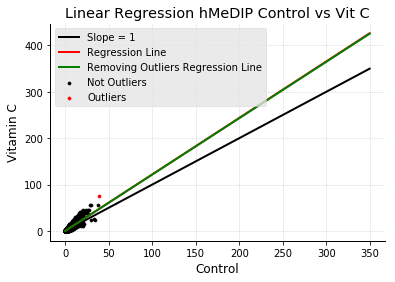

In [29]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = SC_VitC_hMeDIP_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_VitC_hMeDIP_outliers["VitC_Average"], x = SC_VitC_hMeDIP_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 350, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 350, 10)
y = parameters[0] + parameters[1]*x

outliers_removed_model
outlier_parameters = outliers_removed_model.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_VitC_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()
#plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png")

In [30]:
remove_outliers = SC_VitC_hMeDIP_raw.drop(SC_VitC_hMeDIP_outliers.index, axis = 0)
total_counts_removing_outliers = remove_outliers.sum(axis=0)

In [31]:
total_counts_removing_outliers

SC_Control_1_IP                    8.608344e+07
SC_Control_2_IP                    7.786615e+07
SC_Control_3_IP                    9.271869e+07
SC_VitC_1_IP                       8.438199e+07
SC_VitC_2_IP                       8.971516e+07
SC_VitC_3_IP                       9.778596e+07
SC_VitC_Control_1_IP_First_RCPM    9.999630e+05
SC_VitC_Control_2_IP_First_RCPM    9.999649e+05
SC_VitC_Control_3_IP_First_RCPM    9.999553e+05
SC_VitC_VitC_1_IP_First_RCPM       9.999283e+05
SC_VitC_VitC_2_IP_First_RCPM       9.999196e+05
SC_VitC_VitC_3_IP_First_RCPM       9.999284e+05
Control_Average                    9.999610e+05
VitC_Average                       9.999254e+05
dtype: float64

In [32]:
# LAA means Vitamin C. I am changing the name out for VitC because more people will recognize it
SC_VitC_hMeDIP_raw["Control_1_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_removing_outliers[0]
SC_VitC_hMeDIP_raw["Control_2_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_removing_outliers[1]
SC_VitC_hMeDIP_raw["Control_3_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_removing_outliers[2]

SC_VitC_hMeDIP_raw["VitC_1_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_VitC_1_IP"]*1000000/total_counts_removing_outliers[3]
SC_VitC_hMeDIP_raw["VitC_2_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_VitC_2_IP"]*1000000/total_counts_removing_outliers[4]
SC_VitC_hMeDIP_raw["VitC_3_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_VitC_3_IP"]*1000000/total_counts_removing_outliers[5]


In [33]:
SC_VitC_hMeDIP_Corrected_RCPM = SC_VitC_hMeDIP_raw[["Control_1_Corrected_RCPM", "Control_2_Corrected_RCPM", "Control_3_Corrected_RCPM", "VitC_1_Corrected_RCPM", "VitC_2_Corrected_RCPM", "VitC_3_Corrected_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [34]:
len(SC_VitC_hMeDIP_Corrected_RCPM)

215951

In [35]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

Control_1_Corrected_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.777345   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.382380   
SC_Control_IP_Merged_peak_100020                                    0.836398   
SC_Control_IP_Merged_peak_100028                                    0.766698   
SC_Control_IP_Merged_peak_10003                                     0.848014   

                                                    Control_2_Corrected_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.964910   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.438366   
SC_Control_IP_Merged_peak_100020                                    0.937506   
SC_Control_IP_Merged_peak_100028                                    0.911821   
SC_Control_IP_Merged_peak_10003                                     1.155830   

                                                    Control_3_Corrected_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  2.254130   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.855074   
SC_Control_IP_Merged_peak_100020                                    0.927537   
SC_Control_IP_Merged_peak_100028                                    1.003034   
SC_Control_IP_Merged_peak_10003                                     0.905966   

                                                    VitC_1_Corrected_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               1.137684   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.374701   
SC_Control_IP_Merged_peak_100020                                 0.663649   
SC_Control_IP_Merged_peak_100028                                 0.592544   
SC_Control_IP_Merged_peak_10003                                  0.628096   

                                                    VitC_2_Corrected_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.992029   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.359859   
SC_Control_IP_Merged_peak_100020                                 0.557319   
SC_Control_IP_Merged_peak_100028                                 0.546173   
SC_Control_IP_Merged_peak_10003                                  0.847126   

                                                    VitC_3_Corrected_RCPM  
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.879472  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.329434  
SC_Control_IP_Merged_peak_100020                                 0.685170  
SC_Control_IP_Merged_peak_100028                                 0.582906  
SC_Control_IP_Merged_peak_10003                                  0.705623

In [36]:
samples = ["SC_Control_1_hMeDIP_RCPM", "SC_Control_2_hMeDIP_RCPM", "SC_Control_3_hMeDIP_RCPM",
           "SC_VitC_1_hMeDIP_RCPM", "SC_VitC_2_hMeDIP_RCPM", "SC_VitC_3_hMeDIP_RCPM"]

SC_VitC_hMeDIP_Corrected_RCPM.columns= samples


In [37]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

SC_Control_1_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.777345   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.382380   
SC_Control_IP_Merged_peak_100020                                    0.836398   
SC_Control_IP_Merged_peak_100028                                    0.766698   
SC_Control_IP_Merged_peak_10003                                     0.848014   

                                                    SC_Control_2_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.964910   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.438366   
SC_Control_IP_Merged_peak_100020                                    0.937506   
SC_Control_IP_Merged_peak_100028                                    0.911821   
SC_Control_IP_Merged_peak_10003                                     1.155830   

                                                    SC_Control_3_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  2.254130   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.855074   
SC_Control_IP_Merged_peak_100020                                    0.927537   
SC_Control_IP_Merged_peak_100028                                    1.003034   
SC_Control_IP_Merged_peak_10003                                     0.905966   

                                                    SC_VitC_1_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               1.137684   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.374701   
SC_Control_IP_Merged_peak_100020                                 0.663649   
SC_Control_IP_Merged_peak_100028                                 0.592544   
SC_Control_IP_Merged_peak_10003                                  0.628096   

                                                    SC_VitC_2_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.992029   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.359859   
SC_Control_IP_Merged_peak_100020                                 0.557319   
SC_Control_IP_Merged_peak_100028                                 0.546173   
SC_Control_IP_Merged_peak_10003                                  0.847126   

                                                    SC_VitC_3_hMeDIP_RCPM  
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.879472  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.329434  
SC_Control_IP_Merged_peak_100020                                 0.685170  
SC_Control_IP_Merged_peak_100028                                 0.582906  
SC_Control_IP_Merged_peak_10003                                  0.705623

In [38]:
SC_VitC_hMeDIP_Corrected_RCPM.to_csv(Output_Path+"SC_VitC_hMeDIP_RCPM_table.csv")

Now I officially have excluded outliers from the normalization and made the read counts per million. The next step is to divide by length and multiply by 1000 to get "Fragments per Kilobase per Million", also known as FPKM. 
I have the bed file that has the info about peak length for this.

In [39]:
#SC_VitC_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, names=["Chromosome", "Start", "Stop", "Peak_Name"], dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})
SC_VitC_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3)



/Users/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
SC_VitC_hMeDIP_bed.head()

Chr    Start     Stop
Peak_Name                                         
SC_Control_IP_Merged_peak_3    1    50022    50495
SC_Control_IP_Merged_peak_4    1   110730   111377
SC_Control_IP_Merged_peak_17   1   562156   562456
SC_Control_IP_Merged_peak_23   1   759781   760211
SC_Control_IP_Merged_peak_33   1  1227704  1228255

In [41]:
print(len(SC_VitC_hMeDIP_bed))
len(SC_VitC_hMeDIP_Corrected_RCPM)

215951


215951

In [42]:
SC_VitC_hMeDIP_bed.dtypes

Chr      object
Start     int64
Stop      int64
dtype: object

In [43]:
SC_VitC_hMeDIP_bed["Width"] = (SC_VitC_hMeDIP_bed["Stop"] - SC_VitC_hMeDIP_bed["Start"] + 1)

In [44]:
SC_VitC_hMeDIP_bed.head()

Chr    Start     Stop  Width
Peak_Name                                                
SC_Control_IP_Merged_peak_3    1    50022    50495    474
SC_Control_IP_Merged_peak_4    1   110730   111377    648
SC_Control_IP_Merged_peak_17   1   562156   562456    301
SC_Control_IP_Merged_peak_23   1   759781   760211    431
SC_Control_IP_Merged_peak_33   1  1227704  1228255    552

In [45]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

SC_Control_1_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.777345   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.382380   
SC_Control_IP_Merged_peak_100020                                    0.836398   
SC_Control_IP_Merged_peak_100028                                    0.766698   
SC_Control_IP_Merged_peak_10003                                     0.848014   

                                                    SC_Control_2_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.964910   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.438366   
SC_Control_IP_Merged_peak_100020                                    0.937506   
SC_Control_IP_Merged_peak_100028                                    0.911821   
SC_Control_IP_Merged_peak_10003                                     1.155830   

                                                    SC_Control_3_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  2.254130   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.855074   
SC_Control_IP_Merged_peak_100020                                    0.927537   
SC_Control_IP_Merged_peak_100028                                    1.003034   
SC_Control_IP_Merged_peak_10003                                     0.905966   

                                                    SC_VitC_1_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               1.137684   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.374701   
SC_Control_IP_Merged_peak_100020                                 0.663649   
SC_Control_IP_Merged_peak_100028                                 0.592544   
SC_Control_IP_Merged_peak_10003                                  0.628096   

                                                    SC_VitC_2_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.992029   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.359859   
SC_Control_IP_Merged_peak_100020                                 0.557319   
SC_Control_IP_Merged_peak_100028                                 0.546173   
SC_Control_IP_Merged_peak_10003                                  0.847126   

                                                    SC_VitC_3_hMeDIP_RCPM  
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.879472  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.329434  
SC_Control_IP_Merged_peak_100020                                 0.685170  
SC_Control_IP_Merged_peak_100028                                 0.582906  
SC_Control_IP_Merged_peak_10003                                  0.705623

In [46]:
SC_VitC_hMeDIP_Corrected_RCPM = SC_VitC_hMeDIP_Corrected_RCPM.join(SC_VitC_hMeDIP_bed)

In [47]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

SC_Control_1_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.777345   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.382380   
SC_Control_IP_Merged_peak_100020                                    0.836398   
SC_Control_IP_Merged_peak_100028                                    0.766698   
SC_Control_IP_Merged_peak_10003                                     0.848014   

                                                    SC_Control_2_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.964910   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.438366   
SC_Control_IP_Merged_peak_100020                                    0.937506   
SC_Control_IP_Merged_peak_100028                                    0.911821   
SC_Control_IP_Merged_peak_10003                                     1.155830   

                                                    SC_Control_3_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  2.254130   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.855074   
SC_Control_IP_Merged_peak_100020                                    0.927537   
SC_Control_IP_Merged_peak_100028                                    1.003034   
SC_Control_IP_Merged_peak_10003                                     0.905966   

                                                    SC_VitC_1_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               1.137684   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.374701   
SC_Control_IP_Merged_peak_100020                                 0.663649   
SC_Control_IP_Merged_peak_100028                                 0.592544   
SC_Control_IP_Merged_peak_10003                                  0.628096   

                                                    SC_VitC_2_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.992029   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.359859   
SC_Control_IP_Merged_peak_100020                                 0.557319   
SC_Control_IP_Merged_peak_100028                                 0.546173   
SC_Control_IP_Merged_peak_10003                                  0.847126   

                                                    SC_VitC_3_hMeDIP_RCPM Chr  \
Peak_Name                                                                       
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.879472  11   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.329434  11   
SC_Control_IP_Merged_peak_100020                                 0.685170  11   
SC_Control_IP_Merged_peak_100028                                 0.582906  11   
SC_Control_IP_Merged_peak_10003                                  0.705623   1   

                                                       Start      Stop  Width  
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  58427350  58428140    791  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  58467708  58468197    490  
SC_Control_IP_Merged_peak_100020                    58509719  58510097    379  
SC_Control_IP_Merged_peak_100028                    58518547  58518878    332  
SC_Control_IP_Merged_peak_10003                     48456350  48456761    412

In [48]:
SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_1_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_1_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_2_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_2_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_3_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_3_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]

SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_1_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_1_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_2_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_2_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_3_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_3_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]


In [49]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

SC_Control_1_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.777345   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.382380   
SC_Control_IP_Merged_peak_100020                                    0.836398   
SC_Control_IP_Merged_peak_100028                                    0.766698   
SC_Control_IP_Merged_peak_10003                                     0.848014   

                                                    SC_Control_2_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  1.964910   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.438366   
SC_Control_IP_Merged_peak_100020                                    0.937506   
SC_Control_IP_Merged_peak_100028                                    0.911821   
SC_Control_IP_Merged_peak_10003                                     1.155830   

                                                    SC_Control_3_hMeDIP_RCPM  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                  2.254130   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                  1.855074   
SC_Control_IP_Merged_peak_100020                                    0.927537   
SC_Control_IP_Merged_peak_100028                                    1.003034   
SC_Control_IP_Merged_peak_10003                                     0.905966   

                                                    SC_VitC_1_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               1.137684   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.374701   
SC_Control_IP_Merged_peak_100020                                 0.663649   
SC_Control_IP_Merged_peak_100028                                 0.592544   
SC_Control_IP_Merged_peak_10003                                  0.628096   

                                                    SC_VitC_2_hMeDIP_RCPM  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.992029   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.359859   
SC_Control_IP_Merged_peak_100020                                 0.557319   
SC_Control_IP_Merged_peak_100028                                 0.546173   
SC_Control_IP_Merged_peak_10003                                  0.847126   

                                                    SC_VitC_3_hMeDIP_RCPM Chr  \
Peak_Name                                                                       
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               0.879472  11   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               1.329434  11   
SC_Control_IP_Merged_peak_100020                                 0.685170  11   
SC_Control_IP_Merged_peak_100028                                 0.582906  11   
SC_Control_IP_Merged_peak_10003                                  0.705623   1   

                                                       Start      Stop  Width  \
Peak_Name                                                                       
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  58427350  58428140    791   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  58467708  58468197    490   
SC_Control_IP_Merged_peak_100020                    58509719  58510097    379   
SC_Control_IP_Merged_peak_100028                    58518547  58518878    332   
SC_Control_IP_Merged_peak_10003                     48456350  48456761    412   

                                                    SC_Control_1_FPKM  \
Peak_Name                                                               
SC_Cont

In [50]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_Corrected_RCPM[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", 
                                                        "SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]]

In [51]:
SC_VitC_hMeDIP_FPKM_table.head()

SC_Control_1_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.246960   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.821183   
SC_Control_IP_Merged_peak_100020                             2.206854   
SC_Control_IP_Merged_peak_100028                             2.309331   
SC_Control_IP_Merged_peak_10003                              2.058287   

                                                    SC_Control_2_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.484084   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.935440   
SC_Control_IP_Merged_peak_100020                             2.473631   
SC_Control_IP_Merged_peak_100028                             2.746449   
SC_Control_IP_Merged_peak_10003                              2.805412   

                                                    SC_Control_3_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.849722   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           3.785865   
SC_Control_IP_Merged_peak_100020                             2.447327   
SC_Control_IP_Merged_peak_100028                             3.021187   
SC_Control_IP_Merged_peak_10003                              2.198947   

                                                    SC_VitC_1_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.438285   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.805512   
SC_Control_IP_Merged_peak_100020                          1.751052   
SC_Control_IP_Merged_peak_100028                          1.784770   
SC_Control_IP_Merged_peak_10003                           1.524505   

                                                    SC_VitC_2_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.254145   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.775223   
SC_Control_IP_Merged_peak_100020                          1.470500   
SC_Control_IP_Merged_peak_100028                          1.645099   
SC_Control_IP_Merged_peak_10003                           2.056130   

                                                    SC_VitC_3_FPKM  
Peak_Name                                                           
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.111848  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.713131  
SC_Control_IP_Merged_peak_100020                          1.807836  
SC_Control_IP_Merged_peak_100028                          1.755740  
SC_Control_IP_Merged_peak_10003                           1.712677

In [52]:
SC_VitC_hMeDIP_FPKM_table.to_csv(Output_Path+"SC_VitC_hMeDIP_FPKM_table.csv")
SC_VitC_hMeDIP_FPKM_table.to_pickle(Output_Path+"SC_VitC_hMeDIP_FPKM_table.pkl")

Now I have the FPKM values calculated correctly. Next I need to figure out which ones go up, which ones go down, and which ones don't change. I am going to use a fold change cutoff of 1.5X and a corrected P-value from edgeR cutoff of 0.05. 

In [53]:
SC_VitC_hMeDIP_FPKM_table = pd.read_pickle(Output_Path+"SC_VitC_hMeDIP_FPKM_table.pkl")

In [54]:
SC_VitC_hMeDIP_FPKM_table["Control_Average_FPKM"] = SC_VitC_hMeDIP_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM"]].mean(axis=1)
SC_VitC_hMeDIP_FPKM_table["VitC_Average_FPKM"] = SC_VitC_hMeDIP_FPKM_table[["SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]].mean(axis=1)
SC_VitC_hMeDIP_FPKM_table["Fold_Change"] =  (SC_VitC_hMeDIP_FPKM_table["VitC_Average_FPKM"])/(SC_VitC_hMeDIP_FPKM_table["Control_Average_FPKM"])
SC_VitC_hMeDIP_FPKM_table["Log2FC"] = np.log2(SC_VitC_hMeDIP_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [55]:
SC_VitC_hMeDIP_FPKM_table.tail()

SC_Control_1_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           1.914374   
SC_LAA_IP_Merged_peak_99990                                  0.982752   
SC_LAA_IP_Merged_peak_99994                                  1.089609   
SC_LAA_IP_Merged_peak_99995                                  0.807334   
SC_LAA_IP_Merged_peak_99999                                  1.013815   

                                                    SC_Control_2_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           1.919830   
SC_LAA_IP_Merged_peak_99990                                  1.392901   
SC_LAA_IP_Merged_peak_99994                                  1.049165   
SC_LAA_IP_Merged_peak_99995                                  0.776834   
SC_LAA_IP_Merged_peak_99999                                  1.050754   

                                                    SC_Control_3_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           2.179073   
SC_LAA_IP_Merged_peak_99990                                  1.380333   
SC_LAA_IP_Merged_peak_99994                                  1.060583   
SC_LAA_IP_Merged_peak_99995                                  1.013292   
SC_LAA_IP_Merged_peak_99999                                  1.627602   

                                                    SC_VitC_1_FPKM  \
Peak_Name                                                            
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...        2.605982   
SC_LAA_IP_Merged_peak_99990                               2.210791   
SC_LAA_IP_Merged_peak_99994                               1.559797   
SC_LAA_IP_Merged_peak_99995                               1.708234   
SC_LAA_IP_Merged_peak_99999                               2.262439   

                                                    SC_VitC_2_FPKM  \
Peak_Name                                                            
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...        2.826406   
SC_LAA_IP_Merged_peak_99990                               2.031012   
SC_LAA_IP_Merged_peak_99994                               1.551388   
SC_LAA_IP_Merged_peak_99995                               2.108776   
SC_LAA_IP_Merged_peak_99999                               2.654867   

                                                    SC_VitC_3_FPKM  \
Peak_Name                                                            
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...        2.483558   
SC_LAA_IP_Merged_peak_99990                               2.351410   
SC_LAA_IP_Merged_peak_99994                               1.655411   
SC_LAA_IP_Merged_peak_99995                               1.737306   
SC_LAA_IP_Merged_peak_99999                               1.952316   

                                                    Control_Average_FPKM  \
Peak_Name                                                                  
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...              2.004426   
SC_LAA_IP_Merged_peak_99990                                     1.251995   
SC_LAA_IP_Merged_peak_99994                                     1.066452   
SC_LAA_IP_Merged_peak_99995                                     0.865820   
SC_LAA_IP_Merged_peak_99999                                     1.230724   

                                                    VitC_Average_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           2.638649   
SC_LAA_IP_Merged_peak_99990                                  2.197738   
SC_LAA_IP_Merged_peak_99994                                  1.588865   
SC_LAA_IP_Merged_peak_99995                                  1.851439   
SC_LAA_IP_Merged_peak_99999                                  2.289874   

In [56]:
SC_VitC_hMeDIP_edgeR = pd.read_csv(Input_hMeDIP_edgeR, sep = ",", index_col=0)


In [57]:
SC_VitC_hMeDIP_edgeR.head()

logFC    logCPM         LR        PValue  \
Peak_Name                                                             
__alignment_not_unique  0.000000  -5.46102   0.000000  1.000000e+00   
__ambiguous             0.013459   2.86418   0.018216  8.926368e-01   
__no_feature            0.214363  19.25585   7.587856  5.876279e-03   
__not_aligned           1.443403  -1.00651  43.034528  5.380000e-11   
__too_low_aQual         0.000000  -5.46102   0.000000  1.000000e+00   

                                 FDR  
Peak_Name                             
__alignment_not_unique  1.000000e+00  
__ambiguous             9.003917e-01  
__no_feature            7.438775e-03  
__not_aligned           2.070000e-10  
__too_low_aQual         1.000000e+00

In [58]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_FPKM_table.join(SC_VitC_hMeDIP_edgeR)

In [59]:
SC_VitC_hMeDIP_FPKM_table.tail()

SC_Control_1_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           1.914374   
SC_LAA_IP_Merged_peak_99990                                  0.982752   
SC_LAA_IP_Merged_peak_99994                                  1.089609   
SC_LAA_IP_Merged_peak_99995                                  0.807334   
SC_LAA_IP_Merged_peak_99999                                  1.013815   

                                                    SC_Control_2_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           1.919830   
SC_LAA_IP_Merged_peak_99990                                  1.392901   
SC_LAA_IP_Merged_peak_99994                                  1.049165   
SC_LAA_IP_Merged_peak_99995                                  0.776834   
SC_LAA_IP_Merged_peak_99999                                  1.050754   

                                                    SC_Control_3_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           2.179073   
SC_LAA_IP_Merged_peak_99990                                  1.380333   
SC_LAA_IP_Merged_peak_99994                                  1.060583   
SC_LAA_IP_Merged_peak_99995                                  1.013292   
SC_LAA_IP_Merged_peak_99999                                  1.627602   

                                                    SC_VitC_1_FPKM  \
Peak_Name                                                            
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...        2.605982   
SC_LAA_IP_Merged_peak_99990                               2.210791   
SC_LAA_IP_Merged_peak_99994                               1.559797   
SC_LAA_IP_Merged_peak_99995                               1.708234   
SC_LAA_IP_Merged_peak_99999                               2.262439   

                                                    SC_VitC_2_FPKM  \
Peak_Name                                                            
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...        2.826406   
SC_LAA_IP_Merged_peak_99990                               2.031012   
SC_LAA_IP_Merged_peak_99994                               1.551388   
SC_LAA_IP_Merged_peak_99995                               2.108776   
SC_LAA_IP_Merged_peak_99999                               2.654867   

                                                    SC_VitC_3_FPKM  \
Peak_Name                                                            
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...        2.483558   
SC_LAA_IP_Merged_peak_99990                               2.351410   
SC_LAA_IP_Merged_peak_99994                               1.655411   
SC_LAA_IP_Merged_peak_99995                               1.737306   
SC_LAA_IP_Merged_peak_99999                               1.952316   

                                                    Control_Average_FPKM  \
Peak_Name                                                                  
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...              2.004426   
SC_LAA_IP_Merged_peak_99990                                     1.251995   
SC_LAA_IP_Merged_peak_99994                                     1.066452   
SC_LAA_IP_Merged_peak_99995                                     0.865820   
SC_LAA_IP_Merged_peak_99999                                     1.230724   

                                                    VitC_Average_FPKM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           2.638649   
SC_LAA_IP_Merged_peak_99990                                  2.197738   
SC_LAA_IP_Merged_peak_99994                                  1.588865   
SC_LAA_IP_Merged_peak_99995                                  1.851439   
SC_LAA_IP_Merged_peak_99999                                  2.289874   

In [60]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_FPKM_table.drop(["logFC", "logCPM", "LR", "PValue"], axis = 1)

In [61]:
def direction(row):
    if row["FDR"] < 0.05 :
        if row["Log2FC"] >= 0.584962500721156:
            return "Upregulated"
        elif row["Log2FC"] <= -0.584962500721156:
            return "Downregulated"
        else:
            return "Nondifferential"
    else:
        return "Nondifferential"

SC_VitC_hMeDIP_FPKM_table["Change"] =  SC_VitC_hMeDIP_FPKM_table.apply(direction, axis = 1)

In [62]:
SC_VitC_hMeDIP_FPKM_table.head()

SC_Control_1_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.246960   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.821183   
SC_Control_IP_Merged_peak_100020                             2.206854   
SC_Control_IP_Merged_peak_100028                             2.309331   
SC_Control_IP_Merged_peak_10003                              2.058287   

                                                    SC_Control_2_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.484084   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.935440   
SC_Control_IP_Merged_peak_100020                             2.473631   
SC_Control_IP_Merged_peak_100028                             2.746449   
SC_Control_IP_Merged_peak_10003                              2.805412   

                                                    SC_Control_3_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.849722   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           3.785865   
SC_Control_IP_Merged_peak_100020                             2.447327   
SC_Control_IP_Merged_peak_100028                             3.021187   
SC_Control_IP_Merged_peak_10003                              2.198947   

                                                    SC_VitC_1_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.438285   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.805512   
SC_Control_IP_Merged_peak_100020                          1.751052   
SC_Control_IP_Merged_peak_100028                          1.784770   
SC_Control_IP_Merged_peak_10003                           1.524505   

                                                    SC_VitC_2_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.254145   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.775223   
SC_Control_IP_Merged_peak_100020                          1.470500   
SC_Control_IP_Merged_peak_100028                          1.645099   
SC_Control_IP_Merged_peak_10003                           2.056130   

                                                    SC_VitC_3_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.111848   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.713131   
SC_Control_IP_Merged_peak_100020                          1.807836   
SC_Control_IP_Merged_peak_100028                          1.755740   
SC_Control_IP_Merged_peak_10003                           1.712677   

                                                    Control_Average_FPKM  \
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              2.526922   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              3.180829   
SC_Control_IP_Merged_peak_100020                                2.375937   
SC_Control_IP_Merged_peak_100028                                2.692322   
SC_Control_IP_Merged_peak_10003                                 2.354215   

                                                    VitC_Average_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           1.268093   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.764622   
SC_Control_IP_Merged_peak_100020                             1.676463   
SC_Control_IP_Merged_peak_100028                             1.728536   
SC_Control_IP_Merged_peak_10003                              1.764437   

Now I need to read in the region_analysis to put each peak with a gene or region of a gene

In [63]:
SC_VitC_region_analysis = pd.read_csv(Input_region_analysis, sep = "\t", index_col=3)
SC_VitC_region_analysis.rename(columns={'Gene_Region':'Genomic_Region'}, inplace = True)

/Users/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
SC_VitC_region_analysis.head()

Chr     Start      Stop  \
Peak_Name                                                                    
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  11  58427350  58428140   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  11  58467708  58468197   
SC_Control_IP_Merged_peak_100020                    11  58509719  58510097   
SC_Control_IP_Merged_peak_100028                    11  58518547  58518878   
SC_Control_IP_Merged_peak_10003                      1  48456350  48456761   

                                                               Gene_ID  \
Peak_Name                                                                
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                 NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                 NaN   
SC_Control_IP_Merged_peak_100020                                   NaN   
SC_Control_IP_Merged_peak_100028                                   NaN   
SC_Control_IP_Merged_peak_10003                     ENSRNOG00000022946   

                                                         Transcript_ID Sense  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                 NaN     .   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                 NaN     .   
SC_Control_IP_Merged_peak_100020                                   NaN     .   
SC_Control_IP_Merged_peak_100028                                   NaN     .   
SC_Control_IP_Merged_peak_10003                     ENSRNOT00000037369     +   

                                                    Feature_Start  \
Peak_Name                                                           
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...            NaN   
SC_Control_IP_Merged_peak_100020                              NaN   
SC_Control_IP_Merged_peak_100028                              NaN   
SC_Control_IP_Merged_peak_10003                        48433079.0   

                                                    Feature_Stop  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           NaN   
SC_Control_IP_Merged_peak_100020                             NaN   
SC_Control_IP_Merged_peak_100028                             NaN   
SC_Control_IP_Merged_peak_10003                       48521256.0   

                                                     Genomic_Region  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  OtherIntergenic   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  OtherIntergenic   
SC_Control_IP_Merged_peak_100020                    OtherIntergenic   
SC_Control_IP_Merged_peak_100028                    OtherIntergenic   
SC_Control_IP_Merged_peak_10003                            Genebody   

                                                    Distance_From_TSS  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                NaN   
SC_Control_IP_Merged_peak_100020                                  NaN   
SC_Control_IP_Merged_peak_100028                                  NaN   
SC_Control_IP_Merged_peak_10003                               23476.0   

                                                      Gene_Biotype Gene_Name  
Peak_Name                                                                     
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...         No_anno       NaN  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...         No_anno       NaN  
SC_Control_IP_Merged_peak_100020                           No_anno       NaN  
SC_Control_IP_Merged_peak_100028                          

In [65]:
def dave_region(row):
    if row["Distance_From_TSS"] >= -3000 and row["Distance_From_TSS"] < -250:
        return "Upstream_Promoter"
    elif row["Distance_From_TSS"] >= -250 and row["Distance_From_TSS"] <= 250:
        return "TSS"
    elif row["Distance_From_TSS"] > 250 and row["Distance_From_TSS"] <= 3000:
        return "Downstream_Promoter"
    elif row["Distance_From_TSS"] > 3000:
        return "Gene_Body"
    else:
        return "Intergenic"
    

SC_VitC_region_analysis["Gene_Region"] =  SC_VitC_region_analysis.apply(dave_region, axis = 1)

In [66]:
SC_VitC_region_analysis.head()

Chr     Start      Stop  \
Peak_Name                                                                    
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  11  58427350  58428140   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  11  58467708  58468197   
SC_Control_IP_Merged_peak_100020                    11  58509719  58510097   
SC_Control_IP_Merged_peak_100028                    11  58518547  58518878   
SC_Control_IP_Merged_peak_10003                      1  48456350  48456761   

                                                               Gene_ID  \
Peak_Name                                                                
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                 NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                 NaN   
SC_Control_IP_Merged_peak_100020                                   NaN   
SC_Control_IP_Merged_peak_100028                                   NaN   
SC_Control_IP_Merged_peak_10003                     ENSRNOG00000022946   

                                                         Transcript_ID Sense  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                 NaN     .   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                 NaN     .   
SC_Control_IP_Merged_peak_100020                                   NaN     .   
SC_Control_IP_Merged_peak_100028                                   NaN     .   
SC_Control_IP_Merged_peak_10003                     ENSRNOT00000037369     +   

                                                    Feature_Start  \
Peak_Name                                                           
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...            NaN   
SC_Control_IP_Merged_peak_100020                              NaN   
SC_Control_IP_Merged_peak_100028                              NaN   
SC_Control_IP_Merged_peak_10003                        48433079.0   

                                                    Feature_Stop  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           NaN   
SC_Control_IP_Merged_peak_100020                             NaN   
SC_Control_IP_Merged_peak_100028                             NaN   
SC_Control_IP_Merged_peak_10003                       48521256.0   

                                                     Genomic_Region  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  OtherIntergenic   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  OtherIntergenic   
SC_Control_IP_Merged_peak_100020                    OtherIntergenic   
SC_Control_IP_Merged_peak_100028                    OtherIntergenic   
SC_Control_IP_Merged_peak_10003                            Genebody   

                                                    Distance_From_TSS  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                NaN   
SC_Control_IP_Merged_peak_100020                                  NaN   
SC_Control_IP_Merged_peak_100028                                  NaN   
SC_Control_IP_Merged_peak_10003                               23476.0   

                                                      Gene_Biotype Gene_Name  \
Peak_Name                                                                      
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...         No_anno       NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...         No_anno       NaN   
SC_Control_IP_Merged_peak_100020                           No_anno       NaN   
SC_Control_IP_Merged_peak_100028                     

In [67]:
SC_VitC_region_analysis_cleaned = SC_VitC_region_analysis[["Gene_ID", "Gene_Region", "Distance_From_TSS"]]

In [68]:
SC_VitC_region_analysis_cleaned.head()

Gene_ID  \
Peak_Name                                                                
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                 NaN   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                 NaN   
SC_Control_IP_Merged_peak_100020                                   NaN   
SC_Control_IP_Merged_peak_100028                                   NaN   
SC_Control_IP_Merged_peak_10003                     ENSRNOG00000022946   

                                                   Gene_Region  \
Peak_Name                                                        
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  Intergenic   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  Intergenic   
SC_Control_IP_Merged_peak_100020                    Intergenic   
SC_Control_IP_Merged_peak_100028                    Intergenic   
SC_Control_IP_Merged_peak_10003                      Gene_Body   

                                                    Distance_From_TSS  
Peak_Name                                                              
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...                NaN  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...                NaN  
SC_Control_IP_Merged_peak_100020                                  NaN  
SC_Control_IP_Merged_peak_100028                                  NaN  
SC_Control_IP_Merged_peak_10003                               23476.0

In [69]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_FPKM_table.join(SC_VitC_region_analysis_cleaned)

In [70]:
SC_VitC_hMeDIP_FPKM_table.head()

SC_Control_1_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.246960   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.821183   
SC_Control_IP_Merged_peak_100020                             2.206854   
SC_Control_IP_Merged_peak_100028                             2.309331   
SC_Control_IP_Merged_peak_10003                              2.058287   

                                                    SC_Control_2_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.484084   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.935440   
SC_Control_IP_Merged_peak_100020                             2.473631   
SC_Control_IP_Merged_peak_100028                             2.746449   
SC_Control_IP_Merged_peak_10003                              2.805412   

                                                    SC_Control_3_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           2.849722   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           3.785865   
SC_Control_IP_Merged_peak_100020                             2.447327   
SC_Control_IP_Merged_peak_100028                             3.021187   
SC_Control_IP_Merged_peak_10003                              2.198947   

                                                    SC_VitC_1_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.438285   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.805512   
SC_Control_IP_Merged_peak_100020                          1.751052   
SC_Control_IP_Merged_peak_100028                          1.784770   
SC_Control_IP_Merged_peak_10003                           1.524505   

                                                    SC_VitC_2_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.254145   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.775223   
SC_Control_IP_Merged_peak_100020                          1.470500   
SC_Control_IP_Merged_peak_100028                          1.645099   
SC_Control_IP_Merged_peak_10003                           2.056130   

                                                    SC_VitC_3_FPKM  \
Peak_Name                                                            
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...        1.111848   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...        2.713131   
SC_Control_IP_Merged_peak_100020                          1.807836   
SC_Control_IP_Merged_peak_100028                          1.755740   
SC_Control_IP_Merged_peak_10003                           1.712677   

                                                    Control_Average_FPKM  \
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              2.526922   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              3.180829   
SC_Control_IP_Merged_peak_100020                                2.375937   
SC_Control_IP_Merged_peak_100028                                2.692322   
SC_Control_IP_Merged_peak_10003                                 2.354215   

                                                    VitC_Average_FPKM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           1.268093   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           2.764622   
SC_Control_IP_Merged_peak_100020                             1.676463   
SC_Control_IP_Merged_peak_100028                             1.728536   
SC_Control_IP_Merged_peak_10003                              1.764437   

Now I have to figure out how to sum the counts per gene for both location and change

In [71]:
cleanup = SC_VitC_hMeDIP_FPKM_table[["Change", "Gene_ID", "Gene_Region"]]

In [72]:
summed_counts = pd.DataFrame(cleanup.groupby(["Gene_ID", "Gene_Region", "Change"], as_index = False).size().unstack().unstack())

In [73]:
summed_counts.head(30)

Change                   Downregulated                                  \
Gene_Region        Downstream_Promoter Upstream_Promoter Gene_Body TSS   
Gene_ID                                                                  
ENSRNOG00000000001                 NaN               1.0       NaN NaN   
ENSRNOG00000000007                 NaN               NaN       2.0 NaN   
ENSRNOG00000000008                 NaN               NaN       NaN NaN   
ENSRNOG00000000009                 NaN               NaN       NaN NaN   
ENSRNOG00000000017                 NaN               1.0       NaN NaN   
ENSRNOG00000000024                 NaN               NaN       1.0 NaN   
ENSRNOG00000000033                 NaN               NaN       NaN NaN   
ENSRNOG00000000034                 NaN               NaN       NaN NaN   
ENSRNOG00000000036                 NaN               NaN       NaN NaN   
ENSRNOG00000000040                 NaN               NaN       2.0 NaN   
ENSRNOG00000000041                 NaN               NaN       NaN NaN   
ENSRNOG00000000042                 NaN               NaN       3.0 NaN   
ENSRNOG00000000044                 NaN               NaN       NaN NaN   
ENSRNOG00000000047                 NaN               NaN       NaN NaN   
ENSRNOG00000000048                 NaN               NaN       NaN NaN   
ENSRNOG00000000053                 1.0               NaN       NaN NaN   
ENSRNOG00000000054                 NaN               NaN       NaN NaN   
ENSRNOG00000000062                 NaN               NaN       NaN NaN   
ENSRNOG00000000065                 NaN               NaN       1.0 NaN   
ENSRNOG00000000066                 NaN               NaN       1.0 NaN   
ENSRNOG00000000068                 NaN               NaN       1.0 NaN   
ENSRNOG00000000075                 1.0               NaN       1.0 NaN   
ENSRNOG00000000081                 NaN               NaN       NaN NaN   
ENSRNOG00000000082                 NaN               NaN       1.0 NaN   
ENSRNOG00000000095                 NaN               NaN       NaN NaN   
ENSRNOG00000000096                 NaN               NaN       NaN NaN   
ENSRNOG00000000098                 NaN               NaN       1.0 NaN   
ENSRNOG00000000104                 1.0               1.0       NaN NaN   
ENSRNOG00000000105                 NaN               NaN       1.0 NaN   
ENSRNOG00000000111                 NaN               NaN       NaN NaN   

Change                 Nondifferential                                   \
Gene_Region        Downstream_Promoter Upstream_Promoter Gene_Body  TSS   
Gene_ID                                                                   
ENSRNOG00000000001                 1.0               NaN       NaN  NaN   
ENSRNOG00000000007                 NaN               NaN       NaN  NaN   
ENSRNOG00000000008                 NaN               NaN       4.0  NaN   
ENSRNOG00000000009                 NaN               NaN       NaN  NaN   
ENSRNOG00000000017                 NaN               NaN       NaN  NaN   
ENSRNOG00000000024                 NaN               NaN       5.0  NaN   
ENSRNOG00000000033                 1.0               1.0       4.0  NaN   
ENSRNOG00000000034                 NaN               NaN       NaN  NaN   
ENSRNOG00000000036                 NaN               1.0       NaN  NaN   
ENSRNOG00000000040                 1.0               NaN       1.0  1.0   
ENSRNOG00000000041                 NaN               NaN       NaN  NaN   
ENSRNOG00000000042                 1.0               NaN       6.0  NaN   
ENSRNOG00000000044                 1.0               NaN       NaN  NaN   
ENSRNOG00000000047                 2.0               1.0       3.0  NaN   
ENSRNOG00000000048                 NaN               NaN       2.0  NaN   
ENSRNOG00000000053                 NaN               NaN       NaN  NaN   
ENSRNOG00000000054                 NaN               NaN       1.0  NaN   
ENSRNOG00000000062                 NaN               NaN 

In [74]:
summed_counts.columns = ["Downstream_Promoter_Downregulated", "Upstream_Promoter_Downregulated", "Gene_Body_Downregulated",
                        "TSS_Downregulated", "Downstream_Promoter_Nondifferential","Upstream_Promoter_Nondifferential",
                        "Gene_Body_Nondifferential","TSS_Nondifferential","Downstream_Promoter_Upregulated",
                         "Upstream_Promoter_Upregulated","Gene_Body_Upregulated", "TSS_Upregulated"]

  


In [75]:
summed_counts = summed_counts.fillna(0)

In [76]:
summed_counts.head()

Downstream_Promoter_Downregulated  \
Gene_ID                                                 
ENSRNOG00000000001                                0.0   
ENSRNOG00000000007                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000009                                0.0   
ENSRNOG00000000017                                0.0   

                    Upstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Gene_ID                                                                        
ENSRNOG00000000001                              1.0                      0.0   
ENSRNOG00000000007                              0.0                      2.0   
ENSRNOG00000000008                              0.0                      0.0   
ENSRNOG00000000009                              0.0                      0.0   
ENSRNOG00000000017                              1.0                      0.0   

                    TSS_Downregulated  Downstream_Promoter_Nondifferential  \
Gene_ID                                                                      
ENSRNOG00000000001                0.0                                  1.0   
ENSRNOG00000000007                0.0                                  0.0   
ENSRNOG00000000008                0.0                                  0.0   
ENSRNOG00000000009                0.0                                  0.0   
ENSRNOG00000000017                0.0                                  0.0   

                    Upstream_Promoter_Nondifferential  \
Gene_ID                                                 
ENSRNOG00000000001                                0.0   
ENSRNOG00000000007                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000009                                0.0   
ENSRNOG00000000017                                0.0   

                    Gene_Body_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                              
ENSRNOG00000000001                        0.0                  0.0   
ENSRNOG00000000007                        0.0                  0.0   
ENSRNOG00000000008                        4.0                  0.0   
ENSRNOG00000000009                        0.0                  0.0   
ENSRNOG00000000017                        0.0                  0.0   

                    Downstream_Promoter_Upregulated  \
Gene_ID                                               
ENSRNOG00000000001                              0.0   
ENSRNOG00000000007                              0.0   
ENSRNOG00000000008                              1.0   
ENSRNOG00000000009                              0.0   
ENSRNOG00000000017                              0.0   

                    Upstream_Promoter_Upregulated  Gene_Body_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                            0.0                    0.0   
ENSRNOG00000000007                            0.0                    1.0   
ENSRNOG00000000008                            1.0                    4.0   
ENSRNOG00000000009                            0.0                    1.0   
ENSRNOG00000000017                            0.0                    0.0   

                    TSS_Upregulated  
Gene_ID                              
ENSRNOG00000000001              0.0  
ENSRNOG00000000007              0.0  
ENSRNOG00000000008              0.0  
ENSRNOG00000000009              0.0  
ENSRNOG00000000017              0.0

In [77]:
summed_counts.to_csv(Output_Path+"SC_VitC_Counts_of_peaks_per_region.csv")
summed_counts.to_pickle(Output_Path+"SC_VitC_Counts_of_peaks_per_region.pkl")

In [78]:
len(summed_counts)

16234

### Moving on to the RNA-seq data
Now I have officially gotten the hMeDIP-seq info cleaned up (removed outliers) and normalized correctly, then converted it to FPKM using the width of the peaks (from the bed file). Next I was able to get the counts of peaks within each gene region for each annotated gene. 

The next step is to normalize the RNA-seq data similar to the way we did for the hMeDIP-seq, except removing the htseq-count lines before the first RCPM. This again requires finding outliers for correct normalization and using the length of each gene (exonic length, not total genomic length) to calculate the FPKM values. 

In [79]:
SC_VitC_Raw_RNA_data = pd.read_csv(Input_RNA_Counts_File, sep = "\t", index_col=0)

In [80]:
SC_VitC_Raw_RNA_data.head()

SC_Control_01  SC_Control_02  SC_Control_03  SC_VitC_01  \
Ensembl_ID                                                                    
ENSRNOG00000000001             25             21             23          25   
ENSRNOG00000000007              0              0              0           1   
ENSRNOG00000000008            104            127             92         203   
ENSRNOG00000000009              0              0              0           0   
ENSRNOG00000000010              2              2              1           3   

                    SC_VitC_02  SC_VitC_03  
Ensembl_ID                                  
ENSRNOG00000000001          33          24  
ENSRNOG00000000007           0           1  
ENSRNOG00000000008         210         231  
ENSRNOG00000000009           0           1  
ENSRNOG00000000010           2           5

In [81]:
# For this one I need to remove the HTSeq columns before I normalize because unmapped reads will interefere with RNA counts
SC_VitC_Raw_RNA_data = SC_VitC_Raw_RNA_data.drop(columns_added_by_htseq, axis = 0)

In [82]:
total_counts_SC_VitC_RNA_Raw = SC_VitC_Raw_RNA_data.sum(axis=0)

In [83]:
total_counts_SC_VitC_RNA_Raw

SC_Control_01    26831716
SC_Control_02    33173282
SC_Control_03    23381814
SC_VitC_01       26556357
SC_VitC_02       28090349
SC_VitC_03       28564007
dtype: int64

In [84]:
SC_VitC_Raw_RNA_data["Control_1_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_SC_VitC_RNA_Raw[0]
SC_VitC_Raw_RNA_data["Control_2_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_SC_VitC_RNA_Raw[1]
SC_VitC_Raw_RNA_data["Control_3_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_SC_VitC_RNA_Raw[2]
SC_VitC_Raw_RNA_data["VitC_1_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_01"]*1000000/total_counts_SC_VitC_RNA_Raw[3]
SC_VitC_Raw_RNA_data["VitC_2_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_02"]*1000000/total_counts_SC_VitC_RNA_Raw[4]
SC_VitC_Raw_RNA_data["VitC_3_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_03"]*1000000/total_counts_SC_VitC_RNA_Raw[5]
SC_VitC_Raw_RNA_data["Control_Average"] = SC_VitC_Raw_RNA_data[["Control_1_first_RCPM", "Control_2_first_RCPM", "Control_3_first_RCPM"]].mean(axis=1)
SC_VitC_Raw_RNA_data["VitC_Average"] = SC_VitC_Raw_RNA_data[["VitC_1_first_RCPM", "VitC_2_first_RCPM", "VitC_3_first_RCPM"]].mean(axis=1)


In [85]:
SC_VitC_Raw_RNA_data.head()

SC_Control_01  SC_Control_02  SC_Control_03  SC_VitC_01  \
Ensembl_ID                                                                    
ENSRNOG00000000001             25             21             23          25   
ENSRNOG00000000007              0              0              0           1   
ENSRNOG00000000008            104            127             92         203   
ENSRNOG00000000009              0              0              0           0   
ENSRNOG00000000010              2              2              1           3   

                    SC_VitC_02  SC_VitC_03  Control_1_first_RCPM  \
Ensembl_ID                                                         
ENSRNOG00000000001          33          24              0.931733   
ENSRNOG00000000007           0           1              0.000000   
ENSRNOG00000000008         210         231              3.876010   
ENSRNOG00000000009           0           1              0.000000   
ENSRNOG00000000010           2           5              0.074539   

                    Control_2_first_RCPM  Control_3_first_RCPM  \
Ensembl_ID                                                       
ENSRNOG00000000001              0.633040              0.983670   
ENSRNOG00000000007              0.000000              0.000000   
ENSRNOG00000000008              3.828382              3.934682   
ENSRNOG00000000009              0.000000              0.000000   
ENSRNOG00000000010              0.060289              0.042768   

                    VitC_1_first_RCPM  VitC_2_first_RCPM  VitC_3_first_RCPM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.941394           1.174781           0.840218   
ENSRNOG00000000007           0.037656           0.000000           0.035009   
ENSRNOG00000000008           7.644121           7.475877           8.087101   
ENSRNOG00000000009           0.000000           0.000000           0.035009   
ENSRNOG00000000010           0.112967           0.071199           0.175045   

                    Control_Average  VitC_Average  
Ensembl_ID                                         
ENSRNOG00000000001         0.849481      0.985464  
ENSRNOG00000000007         0.000000      0.024222  
ENSRNOG00000000008         3.879691      7.735700  
ENSRNOG00000000009         0.000000      0.011670  
ENSRNOG00000000010         0.059199      0.119737

In [86]:
SC_VitC_RNA_first_RCPM_averages = SC_VitC_Raw_RNA_data[["Control_Average","VitC_Average" ]]

In [87]:
SC_VitC_RNA_first_RCPM_averages.head()

Control_Average  VitC_Average
Ensembl_ID                                       
ENSRNOG00000000001         0.849481      0.985464
ENSRNOG00000000007         0.000000      0.024222
ENSRNOG00000000008         3.879691      7.735700
ENSRNOG00000000009         0.000000      0.011670
ENSRNOG00000000010         0.059199      0.119737

In [88]:
SC_VitC_RNA_first_RCPM_averages.describe()

Control_Average  VitC_Average
count     32883.000000  32883.000000
mean         30.410851     30.410851
std         186.057067    184.819772
min           0.000000      0.000000
25%           0.000000      0.000000
50%           0.024846      0.035599
75%          13.284759     12.792898
max       14353.838049  12475.498538

In [89]:
SC_VitC_RNA_first_RCPM_averages.quantile([0.7, 0.75, 0.8, 0.9, 0.95])

Control_Average  VitC_Average
0.70         4.878563      5.076483
0.75        13.284759     12.792898
0.80        25.209702     24.301869
0.90        69.856685     68.021038
0.95       133.887396    130.155733

Well, this describe function wasn't as useful as I had hoped it would be. I forgot that the human genome (and apparently the rate genome) has many annotated transcripts that are only coding in one or two cell types and only during some points of development, so almost half of these have an average value of 0 for both control and vitamin C. 
<br>When I look at quantiles closer to 1 I get something useful. The high percentiles all look quite close, which is a good sign that they aren't completely different like cells from another tissue or a different animal type. The standard deviations are quite close for both too. This looks good, like they aren't too different from eachother.

Anyways, the next step is to identify outliers and re-normalize without those ones.

In [90]:
linear_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_RNA_first_RCPM_averages).fit()
linear_model_RNA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 2.537e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:49:18   Log-Likelihood:            -1.8269e+05
No. Observations:               32883   AIC:                         3.654e+05
Df Residuals:                   32881   BIC:                         3.654e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9878      0.350      5.683      0.000       1.302       2.673
Control_Average     0.9346      0.002    503.712      0.000       0.931       0.938
==============================================================================
Omnibus:                    79956.750   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      11371128734.013
Skew:                          24.440   Prob(JB):                         0.00
Kurtosis:                    2883.442   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
influence_RNA = linear_model_RNA.get_influence()
(cook,p_cook) = influence_RNA.cooks_distance
SC_VitC_RNA_first_RCPM_averages["Cook_Value"] = cook
SC_VitC_RNA_first_RCPM_averages["Cook_P_Value"] = p_cook

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [92]:
SC_VitC_RNA_first_RCPM_averages.head()

Control_Average  VitC_Average    Cook_Value  Cook_P_Value
Ensembl_ID                                                                   
ENSRNOG00000000001         0.849481      0.985464  1.283694e-08           1.0
ENSRNOG00000000007         0.000000      0.024222  1.536125e-08           1.0
ENSRNOG00000000008         3.879691      7.735700  1.782349e-08           1.0
ENSRNOG00000000009         0.000000      0.011670  1.555826e-08           1.0
ENSRNOG00000000010         0.059199      0.119737  1.473744e-08           1.0

In [93]:
SC_VitC_RNA_removing_outliers = SC_VitC_RNA_first_RCPM_averages[SC_VitC_RNA_first_RCPM_averages.Cook_Value <= 1]
SC_VitC_RNA_outliers = SC_VitC_RNA_first_RCPM_averages[SC_VitC_RNA_first_RCPM_averages.Cook_Value > 1]

In [94]:
SC_VitC_RNA_outliers

Control_Average  VitC_Average  Cook_Value   Cook_P_Value
Ensembl_ID                                                                  
ENSRNOG00000003897      4574.687404   9817.760658   73.820231   1.028118e-32
ENSRNOG00000005434      5963.014015   6925.652343    7.668706   4.680581e-04
ENSRNOG00000010286      2146.591522    484.289162    1.184151   3.060188e-01
ENSRNOG00000012840      3766.567018   6317.930932   12.565104   3.508559e-06
ENSRNOG00000017206      3284.156573   1711.751343    2.242735   1.061840e-01
ENSRNOG00000018087     14353.838049  12475.498538   30.376542   6.604012e-14
ENSRNOG00000034234      9366.399047   8314.980552    2.230774   1.074615e-01
ENSRNOG00000043866      5809.953384   7751.716021   21.403929   5.133784e-10
ENSRNOG00000046005     11934.208236   7801.392922  233.260675  2.559223e-101
ENSRNOG00000054493     11506.308482   7497.607273  200.502059   2.816843e-87
ENSRNOG00000057569      5431.755526   7931.234175   28.061756   6.657687e-13
ENSRNOG00000058470      1552.247776   4418.969375    2.327699   9.753595e-02

In [95]:
outliers_removed_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_RNA_removing_outliers).fit()
outliers_removed_model_RNA.summary()
# This one has a slightly higher R-squared value. 
# Now I want to see what it looks like in the graph. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.666e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:49:18   Log-Likelihood:            -1.6235e+05
No. Observations:               32871   AIC:                         3.247e+05
Df Residuals:                   32869   BIC:                         3.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0797      0.192      0.415      0.678      -0.297       0.456
Control_Average     0.9952      0.002    605.473      0.000       0.992       0.998
==============================================================================
Omnibus:                    54499.864   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        426831866.563
Skew:                          10.248   Prob(JB):                         0.00
Kurtosis:                     560.872   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

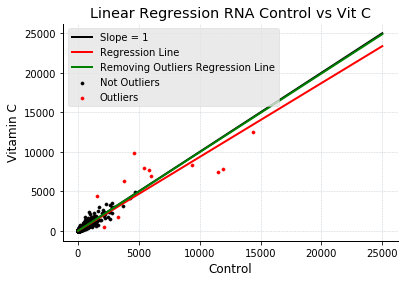

In [96]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = SC_VitC_RNA_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_VitC_RNA_outliers["VitC_Average"], x = SC_VitC_RNA_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 25000, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression RNA Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model_RNA.params
x = sc.linspace(0, 25000, 10)
y = parameters[0] + parameters[1]*x


outlier_parameters = outliers_removed_model_RNA.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_VitC_RNA_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


I was surprised to find that removing the outliers shifted the slope almost exactly to a slope of 1. The R2 values were extremely high (91.8% in the outliers removed model). It looks like it normalized well. 

In [97]:
print(len(SC_VitC_RNA_removing_outliers))
print(len(SC_VitC_RNA_first_RCPM_averages))
print(len(SC_VitC_RNA_outliers))

# Difference of 12, which is the number of outliers

32871
32883
12


In [98]:
remove_outliers_RNA = SC_VitC_Raw_RNA_data.drop(SC_VitC_RNA_outliers.index, axis = 0)


In [99]:
total_counts_removing_outliers_RNA = remove_outliers_RNA.sum(axis=0)

In [100]:
total_counts_removing_outliers_RNA

SC_Control_01           2.468742e+07
SC_Control_02           3.051495e+07
SC_Control_03           2.153423e+07
SC_VitC_01              2.432794e+07
SC_VitC_02              2.579432e+07
SC_VitC_03              2.631612e+07
Control_1_first_RCPM    9.200837e+05
Control_2_first_RCPM    9.198652e+05
Control_3_first_RCPM    9.209819e+05
VitC_1_first_RCPM       9.160873e+05
VitC_2_first_RCPM       9.182628e+05
VitC_3_first_RCPM       9.213036e+05
Control_Average         9.203103e+05
VitC_Average            9.185512e+05
dtype: float64

In [101]:
SC_VitC_Raw_RNA_data.head()

SC_Control_01  SC_Control_02  SC_Control_03  SC_VitC_01  \
Ensembl_ID                                                                    
ENSRNOG00000000001             25             21             23          25   
ENSRNOG00000000007              0              0              0           1   
ENSRNOG00000000008            104            127             92         203   
ENSRNOG00000000009              0              0              0           0   
ENSRNOG00000000010              2              2              1           3   

                    SC_VitC_02  SC_VitC_03  Control_1_first_RCPM  \
Ensembl_ID                                                         
ENSRNOG00000000001          33          24              0.931733   
ENSRNOG00000000007           0           1              0.000000   
ENSRNOG00000000008         210         231              3.876010   
ENSRNOG00000000009           0           1              0.000000   
ENSRNOG00000000010           2           5              0.074539   

                    Control_2_first_RCPM  Control_3_first_RCPM  \
Ensembl_ID                                                       
ENSRNOG00000000001              0.633040              0.983670   
ENSRNOG00000000007              0.000000              0.000000   
ENSRNOG00000000008              3.828382              3.934682   
ENSRNOG00000000009              0.000000              0.000000   
ENSRNOG00000000010              0.060289              0.042768   

                    VitC_1_first_RCPM  VitC_2_first_RCPM  VitC_3_first_RCPM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.941394           1.174781           0.840218   
ENSRNOG00000000007           0.037656           0.000000           0.035009   
ENSRNOG00000000008           7.644121           7.475877           8.087101   
ENSRNOG00000000009           0.000000           0.000000           0.035009   
ENSRNOG00000000010           0.112967           0.071199           0.175045   

                    Control_Average  VitC_Average  
Ensembl_ID                                         
ENSRNOG00000000001         0.849481      0.985464  
ENSRNOG00000000007         0.000000      0.024222  
ENSRNOG00000000008         3.879691      7.735700  
ENSRNOG00000000009         0.000000      0.011670  
ENSRNOG00000000010         0.059199      0.119737

In [102]:
SC_VitC_Raw_RNA_data["SC_Control_1_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_removing_outliers_RNA[0]
SC_VitC_Raw_RNA_data["SC_Control_2_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_removing_outliers_RNA[1]
SC_VitC_Raw_RNA_data["SC_Control_3_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_removing_outliers_RNA[2]
SC_VitC_Raw_RNA_data["SC_VitC_1_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_01"]*1000000/total_counts_removing_outliers_RNA[3]
SC_VitC_Raw_RNA_data["SC_VitC_2_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_02"]*1000000/total_counts_removing_outliers_RNA[4]
SC_VitC_Raw_RNA_data["SC_VitC_3_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_03"]*1000000/total_counts_removing_outliers_RNA[5]
SC_VitC_RNA_Corrected_RCPM = SC_VitC_Raw_RNA_data[["SC_Control_1_RCPM", "SC_Control_2_RCPM", "SC_Control_3_RCPM", "SC_VitC_1_RCPM", "SC_VitC_2_RCPM", "SC_VitC_3_RCPM"]]

In [103]:
SC_VitC_RNA_Corrected_RCPM.head()

SC_Control_1_RCPM  SC_Control_2_RCPM  SC_Control_3_RCPM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           1.012661           0.688187           1.068067   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           4.212671           4.161895           4.272268   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.081013           0.065542           0.046438   

                    SC_VitC_1_RCPM  SC_VitC_2_RCPM  SC_VitC_3_RCPM  
Ensembl_ID                                                          
ENSRNOG00000000001        1.027625        1.279351        0.911988  
ENSRNOG00000000007        0.041105        0.000000        0.038000  
ENSRNOG00000000008        8.344315        8.141327        8.777889  
ENSRNOG00000000009        0.000000        0.000000        0.038000  
ENSRNOG00000000010        0.123315        0.077536        0.189998

In [104]:
SC_VitC_RNA_Corrected_RCPM.to_csv(Output_Path+"SC_VitC_RNA_RCPM_table.csv")

In [105]:
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )


In [106]:
Rat_Genomic_Info_File.dtypes # It looks like I don't need to specify the types because the lengths and positions went in as int

Gene_Name             object
Location              object
Sense                 object
Gene_Biotype          object
transcript_id         object
Chr                   object
Start                  int64
Stop                   int64
Length                 int64
Exon Length            int64
Intron Length          int64
Gene_ID               object
gene_version           int64
transcript_version     int64
gene_name             object
gene_source           object
gene_biotype          object
transcript_name       object
transcript_source     object
transcript_biotype    object
dtype: object

In [107]:
Rat_Genomic_Info_File.head()

Gene_Name                  Location Sense  \
Ensembl_ID                                                           
ENSRNOG00000000001  AABR07013255.1  chr2:230660664-230662084     +   
ENSRNOG00000000007            Gad1    chr3:56861396-56902157     +   
ENSRNOG00000000008            Alx4    chr3:82548959-82585531     +   
ENSRNOG00000000009          Tmco5b  chr3:104749051-104765436     +   
ENSRNOG00000000010           Cbln1   chr19:20607507-20611316     +   

                      Gene_Biotype       transcript_id Chr      Start  \
Ensembl_ID                                                              
ENSRNOG00000000001      pseudogene  ENSRNOT00000055633   2  230660664   
ENSRNOG00000000007  protein_coding  ENSRNOT00000087712   3   56862691   
ENSRNOG00000000008  protein_coding  ENSRNOT00000000009   3   82548959   
ENSRNOG00000000009  protein_coding  ENSRNOT00000000010   3  104749051   
ENSRNOG00000000010  protein_coding  ENSRNOT00000000011  19   20607507   

                         Stop  Length  Exon Length  Intron Length  \
Ensembl_ID                                                          
ENSRNOG00000000001  230662084    1421         1416              5   
ENSRNOG00000000007   56902137   39447         3381          36066   
ENSRNOG00000000008   82585531   36573         1747          34826   
ENSRNOG00000000009  104765436   16386         1361          15025   
ENSRNOG00000000010   20611316    3810         2444           1366   

                               Gene_ID  gene_version  transcript_version  \
Ensembl_ID                                                                 
ENSRNOG00000000001  ENSRNOG00000000001             5                   2   
ENSRNOG00000000007  ENSRNOG00000000007             7                   1   
ENSRNOG00000000008  ENSRNOG00000000008             7                   5   
ENSRNOG00000000009  ENSRNOG00000000009             5                   5   
ENSRNOG00000000010  ENSRNOG00000000010             5                   5   

                         gene_name gene_source    gene_biotype  \
Ensembl_ID                                                       
ENSRNOG00000000001  AABR07013255.1     ensembl      pseudogene   
ENSRNOG00000000007            Gad1     ensembl  protein_coding   
ENSRNOG00000000008            Alx4     ensembl  protein_coding   
ENSRNOG00000000009          Tmco5b     ensembl  protein_coding   
ENSRNOG00000000010           Cbln1     ensembl  protein_coding   

                       transcript_name transcript_source transcript_biotype  
Ensembl_ID                                                                   
ENSRNOG00000000001  AABR07013255.1-201           ensembl         pseudogene  
ENSRNOG00000000007            Gad1-204           ensembl     protein_coding  
ENSRNOG00000000008            Alx4-201           ensembl     protein_coding  
ENSRNOG00000000009          Tmco5b-201           ensembl     protein_coding  
ENSRNOG00000000010           Cbln1-201           ensembl     protein_coding

In [108]:
SC_VitC_RNA_Corrected_RCPM = SC_VitC_RNA_Corrected_RCPM.join(Rat_Genomic_Info_File)

In [109]:
SC_VitC_RNA_Corrected_RCPM.head()

SC_Control_1_RCPM  SC_Control_2_RCPM  SC_Control_3_RCPM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           1.012661           0.688187           1.068067   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           4.212671           4.161895           4.272268   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.081013           0.065542           0.046438   

                    SC_VitC_1_RCPM  SC_VitC_2_RCPM  SC_VitC_3_RCPM  \
Ensembl_ID                                                           
ENSRNOG00000000001        1.027625        1.279351        0.911988   
ENSRNOG00000000007        0.041105        0.000000        0.038000   
ENSRNOG00000000008        8.344315        8.141327        8.777889   
ENSRNOG00000000009        0.000000        0.000000        0.038000   
ENSRNOG00000000010        0.123315        0.077536        0.189998   

                         Gene_Name                  Location Sense  \
Ensembl_ID                                                           
ENSRNOG00000000001  AABR07013255.1  chr2:230660664-230662084     +   
ENSRNOG00000000007            Gad1    chr3:56861396-56902157     +   
ENSRNOG00000000008            Alx4    chr3:82548959-82585531     +   
ENSRNOG00000000009          Tmco5b  chr3:104749051-104765436     +   
ENSRNOG00000000010           Cbln1   chr19:20607507-20611316     +   

                      Gene_Biotype         ...         Intron Length  \
Ensembl_ID                                 ...                         
ENSRNOG00000000001      pseudogene         ...                     5   
ENSRNOG00000000007  protein_coding         ...                 36066   
ENSRNOG00000000008  protein_coding         ...                 34826   
ENSRNOG00000000009  protein_coding         ...                 15025   
ENSRNOG00000000010  protein_coding         ...                  1366   

                               Gene_ID  gene_version  transcript_version  \
Ensembl_ID                                                                 
ENSRNOG00000000001  ENSRNOG00000000001             5                   2   
ENSRNOG00000000007  ENSRNOG00000000007             7                   1   
ENSRNOG00000000008  ENSRNOG00000000008             7                   5   
ENSRNOG00000000009  ENSRNOG00000000009             5                   5   
ENSRNOG00000000010  ENSRNOG00000000010             5                   5   

                         gene_name  gene_source    gene_biotype  \
Ensembl_ID                                                        
ENSRNOG00000000001  AABR07013255.1      ensembl      pseudogene   
ENSRNOG00000000007            Gad1      ensembl  protein_coding   
ENSRNOG00000000008            Alx4      ensembl  protein_coding   
ENSRNOG00000000009          Tmco5b      ensembl  protein_coding   
ENSRNOG00000000010           Cbln1      ensembl  protein_coding   

                       transcript_name  transcript_source  transcript_biotype  
Ensembl_ID                                                                     
ENSRNOG00000000001  AABR07013255.1-201            ensembl          pseudogene  
ENSRNOG00000000007            Gad1-204            ensembl      protein_coding  
ENSRNOG00000000008            Alx4-201            ensembl      protein_coding  
ENSRNOG00000000009          Tmco5b-201            ensembl      protein_coding  
ENSRNOG00000000010           Cbln1-201            ensembl      protein_coding  

[5 rows x 26 columns]

In [110]:
SC_VitC_RNA_Corrected_RCPM["SC_Control_1_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_Control_1_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_Control_2_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_Control_2_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_Control_3_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_Control_3_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]

SC_VitC_RNA_Corrected_RCPM["SC_VitC_1_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_VitC_1_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_VitC_2_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_VitC_2_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_VitC_3_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_VitC_3_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]


In [111]:
SC_VitC_RNA_FPKM_table = SC_VitC_RNA_Corrected_RCPM[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", "SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]]


In [112]:
SC_VitC_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  
Ensembl_ID                                                          
ENSRNOG00000000001        0.725724        0.903497        0.644060  
ENSRNOG00000000007        0.012158        0.000000        0.011239  
ENSRNOG00000000008        4.776368        4.660176        5.024550  
ENSRNOG00000000009        0.000000        0.000000        0.027920  
ENSRNOG00000000010        0.050456        0.031725        0.077740

In [113]:
#SC_VitC_RNA_FPKM_table.to_csv(Output_Path+"SC_VitC_RNA_FPKM_table.csv")
#SC_VitC_RNA_FPKM_table.to_pickle(Output_Path+"SC_VitC_RNA_FPKM_table.pkl")


Now I have the FPKM table for the RNA. Next I need to read in the statistical files (edgeR and DESeq2) and calculate fold changes to determine which direction each gene goes. When I did this for the hMeDIP, none of them had values of 0 so I didn't need to worry about dividing by infinity. For this one, I needed to make up a lambda function for an if statement if the values were below 0.1 for both VitC and Control.

In [114]:
SC_VitC_RNA_FPKM_table["Control_Average_FPKM"] = SC_VitC_RNA_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_2_FPKM"]].mean(axis=1)
SC_VitC_RNA_FPKM_table["VitC_Average_FPKM"] = SC_VitC_RNA_FPKM_table[["SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]].mean(axis=1)
SC_VitC_RNA_FPKM_table["Fold_Change"] =  SC_VitC_RNA_FPKM_table.apply(lambda x: 1 if max(x["VitC_Average_FPKM"],x["Control_Average_FPKM"]) < 0.1 else (x["VitC_Average_FPKM"]/x["Control_Average_FPKM"]), axis = 1)


SC_VitC_RNA_FPKM_table["Log2FC"] = np.log2(SC_VitC_RNA_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3

In [115]:
SC_VitC_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  \
Ensembl_ID                                                           
ENSRNOG00000000001        0.725724        0.903497        0.644060   
ENSRNOG00000000007        0.012158        0.000000        0.011239   
ENSRNOG00000000008        4.776368        4.660176        5.024550   
ENSRNOG00000000009        0.000000        0.000000        0.027920   
ENSRNOG00000000010        0.050456        0.031725        0.077740   

                    Control_Average_FPKM  VitC_Average_FPKM  Fold_Change  \
Ensembl_ID                                                                 
ENSRNOG00000000001              0.562391           0.757760     1.347391   
ENSRNOG00000000007              0.000000           0.007799     1.000000   
ENSRNOG00000000008              2.391998           4.820365     2.015204   
ENSRNOG00000000009              0.000000           0.009307     1.000000   
ENSRNOG00000000010              0.028927           0.053307     1.000000   

                      Log2FC  
Ensembl_ID                    
ENSRNOG00000000001  0.430168  
ENSRNOG00000000007  0.000000  
ENSRNOG00000000008  1.010926  
ENSRNOG00000000009  0.000000  
ENSRNOG00000000010  0.000000

In [116]:
SC_VitC_RNA_edgeR = pd.read_csv(Input_RNA_edgeR, sep = ",", index_col=0) 
SC_VitC_RNA_edgeR = SC_VitC_RNA_edgeR.drop(['logFC', 'logCPM', 'LR', 'PValue'], axis = 1)
SC_VitC_RNA_edgeR.columns=["edgeR"]

SC_VitC_RNA_DESeq2 = pd.read_csv(Input_RNA_DESeq2, sep = ",", index_col=0)
SC_VitC_RNA_DESeq2 = SC_VitC_RNA_DESeq2.drop(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue'], axis = 1)
SC_VitC_RNA_DESeq2.columns = ["DESeq2"]
SC_VitC_RNA_DESeq2 = SC_VitC_RNA_DESeq2.fillna(1)

In [117]:
SC_VitC_RNA_edgeR.head()

edgeR
Gene_ID                          
ENSRNOG00000008000  6.970000e-199
ENSRNOG00000056714  1.350000e-155
ENSRNOG00000007159  8.870000e-153
ENSRNOG00000058003  2.130000e-139
ENSRNOG00000024082  4.760000e-116

In [118]:
SC_VitC_RNA_DESeq2.head()

DESeq2
ENSRNOG00000008000  9.380000e-261
ENSRNOG00000056714  1.560000e-232
ENSRNOG00000005580  1.500000e-189
ENSRNOG00000010286  2.070000e-182
ENSRNOG00000020060  3.160000e-166

In [119]:
SC_VitC_RNA_FPKM_table = SC_VitC_RNA_FPKM_table.join([SC_VitC_RNA_edgeR, SC_VitC_RNA_DESeq2])

In [120]:
SC_VitC_RNA_FPKM_table.head(15)

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   
ENSRNOG00000000012           0.000000           0.000000           0.000000   
ENSRNOG00000000017           0.664559           0.844873           0.906986   
ENSRNOG00000000021          12.793288          13.681820          14.473083   
ENSRNOG00000000024          15.943218          15.212822          15.348053   
ENSRNOG00000000033           5.590132           5.421742           5.336362   
ENSRNOG00000000034           0.140892           0.136783           0.161522   
ENSRNOG00000000035           0.000000           0.000000           0.000000   
ENSRNOG00000000036           0.000000           0.000000           0.000000   
ENSRNOG00000000040           5.334183           5.711691           4.912436   
ENSRNOG00000000041           0.021830           0.114799           0.025027   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  \
Ensembl_ID                                                           
ENSRNOG00000000001        0.725724        0.903497        0.644060   
ENSRNOG00000000007        0.012158        0.000000        0.011239   
ENSRNOG00000000008        4.776368        4.660176        5.024550   
ENSRNOG00000000009        0.000000        0.000000        0.027920   
ENSRNOG00000000010        0.050456        0.031725        0.077740   
ENSRNOG00000000012        0.000000        0.039042        0.000000   
ENSRNOG00000000017        0.706492        1.635534        1.157798   
ENSRNOG00000000021       11.817687       14.764231       14.123155   
ENSRNOG00000000024       13.004972       14.711482       14.026188   
ENSRNOG00000000033        7.537592        7.267067        7.587516   
ENSRNOG00000000034        0.400327        0.498930        0.317213   
ENSRNOG00000000035        0.000000        0.000000        0.000000   
ENSRNOG00000000036        0.025699        0.048475        0.000000   
ENSRNOG00000000040        8.816032        9.347168        8.600714   
ENSRNOG00000000041        0.011077        0.020894        0.051198   

                    Control_Average_FPKM  VitC_Average_FPKM  Fold_Change  \
Ensembl_ID                                                                 
ENSRNOG00000000001              0.562391           0.757760     1.347391   
ENSRNOG00000000007              0.000000           0.007799     1.000000   
ENSRNOG00000000008              2.391998           4.820365     2.015204   
ENSRNOG00000000009              0.000000           0.009307     1.000000   
ENSRNOG00000000010              0.028927           0.053307     1.000000   
ENSRNOG00000000012              0.000000           0.013014     1.000000   
ENSRNOG00000000017              0.784768           1.166608     1.486564   
ENSRNOG00000000021             13.385642          13.568358     1.013650   
ENSRNOG00000000024             15.456287          13.914214     0.900230   
ENSRNOG00000000033              5.477872           7.464058     1.362583   
ENSRNOG00000000034              0.138152           0.405490     2.935093   
ENSRNOG00000000035              0.000000           0.000000     1.000000   
ENSRNOG00000000036              0.000000           0.024725     1.000000   
ENSRNOG00000000040              5.585855           8.921305     1.597124   
ENSRNOG00000000041              0.083810           0.027723     1.000000   

                      Log2FC         edgeR        DESeq2  
Ensembl_ID                                                
ENSRNOG00000000001  0.430168  7.507860e-01  6.209275e-01  
ENSRNOG00000000

In [121]:
SC_VitC_RNA_FPKM_table.loc["ENSRNOG00000008000"] # This went in correctly

SC_Control_1_FPKM        4.072902e+01
SC_Control_2_FPKM        4.275939e+01
SC_Control_3_FPKM        4.509479e+01
SC_VitC_1_FPKM           4.100990e+00
SC_VitC_2_FPKM           3.722108e+00
SC_VitC_3_FPKM           4.241705e+00
Control_Average_FPKM     4.208260e+01
VitC_Average_FPKM        4.021601e+00
Fold_Change              9.556447e-02
Log2FC                  -3.387382e+00
edgeR                   6.970000e-199
DESeq2                  9.380000e-261
Name: ENSRNOG00000008000, dtype: float64

In [122]:
# This definition will mistakenly put "downregulated" for ones with good P-values by both but a fold change of 1
# These ones will be filtered out in the next step, finding limit of detection
def direction(row):
    if row["edgeR"] < 0.05 and row["DESeq2"] < 0.05:
        if row["Log2FC"] > 0:
            return "Upregulated"
        else:
            return "Downregulated"
    else:
        return "Nondifferential"

SC_VitC_RNA_FPKM_table["Change"] =  SC_VitC_RNA_FPKM_table.apply(direction, axis = 1)
# I figured out how to make it faster :)

In [123]:
SC_VitC_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  \
Ensembl_ID                                                           
ENSRNOG00000000001        0.725724        0.903497        0.644060   
ENSRNOG00000000007        0.012158        0.000000        0.011239   
ENSRNOG00000000008        4.776368        4.660176        5.024550   
ENSRNOG00000000009        0.000000        0.000000        0.027920   
ENSRNOG00000000010        0.050456        0.031725        0.077740   

                    Control_Average_FPKM  VitC_Average_FPKM  Fold_Change  \
Ensembl_ID                                                                 
ENSRNOG00000000001              0.562391           0.757760     1.347391   
ENSRNOG00000000007              0.000000           0.007799     1.000000   
ENSRNOG00000000008              2.391998           4.820365     2.015204   
ENSRNOG00000000009              0.000000           0.009307     1.000000   
ENSRNOG00000000010              0.028927           0.053307     1.000000   

                      Log2FC         edgeR        DESeq2           Change  
Ensembl_ID                                                                 
ENSRNOG00000000001  0.430168  7.507860e-01  6.209275e-01  Nondifferential  
ENSRNOG00000000007  0.000000  3.898456e-01  1.000000e+00  Nondifferential  
ENSRNOG00000000008  1.010926  3.470000e-12  1.440000e-09      Upregulated  
ENSRNOG00000000009  0.000000  6.624017e-01  1.000000e+00  Nondifferential  
ENSRNOG00000000010  0.000000  5.854191e-01  1.000000e+00  Nondifferential

In [124]:
SC_VitC_RNA_FPKM_table.to_csv(Output_Path+"SC_VitC_RNA_FPKM_table.csv")
SC_VitC_RNA_FPKM_table.to_pickle(Output_Path+"SC_VitC_RNA_FPKM_table.pkl")

Now I have the FPKM table calculated out and I have determined which ones go up and down, but I have not filtered out genes that are really lowly expressed. The next step is to take those out because they will not add information to our analysis, but just add noise.

Now I am going to calculate the FPKM values for the genomic input samples. I am going to see if I can use these to determine a cutoff LOD for the RNA. Luckily, I don't need to worry about outliers for this one because it is genomic input and I want to include those ones if there is something funky because it might transfer across the other sequencing files too.

In [125]:
SC_VitC_genomic_input_raw = pd.read_csv(Input_Genomic_Input_Counts_File, sep = "\t", index_col = 0)

In [126]:
SC_VitC_genomic_input_raw.head()

SC_Control_1_IN  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               29   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               17   
SC_Control_IP_Merged_peak_100020                                 24   
SC_Control_IP_Merged_peak_100028                                 21   
SC_Control_IP_Merged_peak_10003                                  28   

                                                    SC_Control_2_IN  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               32   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               23   
SC_Control_IP_Merged_peak_100020                                 26   
SC_Control_IP_Merged_peak_100028                                 12   
SC_Control_IP_Merged_peak_10003                                  17   

                                                    SC_Control_3_IN  \
Peak_Name                                                             
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...               29   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...               30   
SC_Control_IP_Merged_peak_100020                                 29   
SC_Control_IP_Merged_peak_100028                                 20   
SC_Control_IP_Merged_peak_10003                                  27   

                                                    SC_VitC_1_IN  \
Peak_Name                                                          
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            25   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...            18   
SC_Control_IP_Merged_peak_100020                              21   
SC_Control_IP_Merged_peak_100028                              15   
SC_Control_IP_Merged_peak_10003                               25   

                                                    SC_VitC_2_IN  SC_VitC_3_IN  
Peak_Name                                                                       
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...            35            35  
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...            21            28  
SC_Control_IP_Merged_peak_100020                              33            24  
SC_Control_IP_Merged_peak_100028                              17            15  
SC_Control_IP_Merged_peak_10003                               30            25

In [127]:
total_counts_SC_VitC_genomic_input = SC_VitC_genomic_input_raw.sum(axis=0)

In [128]:
total_counts_SC_VitC_genomic_input

SC_Control_1_IN    100915341
SC_Control_2_IN     83233328
SC_Control_3_IN    111336681
SC_VitC_1_IN        86173506
SC_VitC_2_IN       103924317
SC_VitC_3_IN       102885634
dtype: int64

In [129]:
SC_VitC_genomic_input_raw["SC_Control_1_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_Control_1_IN"]*1000000/total_counts_SC_VitC_genomic_input[0]
SC_VitC_genomic_input_raw["SC_Control_2_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_Control_2_IN"]*1000000/total_counts_SC_VitC_genomic_input[1]
SC_VitC_genomic_input_raw["SC_Control_3_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_Control_3_IN"]*1000000/total_counts_SC_VitC_genomic_input[2]


SC_VitC_genomic_input_raw["SC_VitC_1_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_VitC_1_IN"]*1000000/total_counts_SC_VitC_genomic_input[3]
SC_VitC_genomic_input_raw["SC_VitC_2_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_VitC_2_IN"]*1000000/total_counts_SC_VitC_genomic_input[4]
SC_VitC_genomic_input_raw["SC_VitC_3_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_VitC_3_IN"]*1000000/total_counts_SC_VitC_genomic_input[5]


In [130]:
SC_VitC_genomic_input_rcpm = SC_VitC_genomic_input_raw[["SC_Control_1_IN_RCPM", "SC_Control_2_IN_RCPM", "SC_Control_3_IN_RCPM", "SC_VitC_1_IN_RCPM", "SC_VitC_2_IN_RCPM", "SC_VitC_3_IN_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [131]:
SC_VitC_genomic_input_rcpm.tail()


SC_Control_1_IN_RCPM  \
Peak_Name                                                                  
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...              0.822472   
SC_LAA_IP_Merged_peak_99990                                     0.297279   
SC_LAA_IP_Merged_peak_99994                                     0.208095   
SC_LAA_IP_Merged_peak_99995                                     0.267551   
SC_LAA_IP_Merged_peak_99999                                     0.188277   

                                                    SC_Control_2_IN_RCPM  \
Peak_Name                                                                  
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...              0.901081   
SC_LAA_IP_Merged_peak_99990                                     0.276332   
SC_LAA_IP_Merged_peak_99994                                     0.192231   
SC_LAA_IP_Merged_peak_99995                                     0.384461   
SC_LAA_IP_Merged_peak_99999                                     0.228274   

                                                    SC_Control_3_IN_RCPM  \
Peak_Name                                                                  
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...              0.934104   
SC_LAA_IP_Merged_peak_99990                                     0.278435   
SC_LAA_IP_Merged_peak_99994                                     0.287417   
SC_LAA_IP_Merged_peak_99995                                     0.449088   
SC_LAA_IP_Merged_peak_99999                                     0.233526   

                                                    SC_VitC_1_IN_RCPM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           0.997987   
SC_LAA_IP_Merged_peak_99990                                  0.197276   
SC_LAA_IP_Merged_peak_99994                                  0.220485   
SC_LAA_IP_Merged_peak_99995                                  0.185672   
SC_LAA_IP_Merged_peak_99999                                  0.243694   

                                                    SC_VitC_2_IN_RCPM  \
Peak_Name                                                               
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           0.740924   
SC_LAA_IP_Merged_peak_99990                                  0.240560   
SC_LAA_IP_Merged_peak_99994                                  0.211693   
SC_LAA_IP_Merged_peak_99995                                  0.346406   
SC_LAA_IP_Merged_peak_99999                                  0.153958   

                                                    SC_VitC_3_IN_RCPM  
Peak_Name                                                              
SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merge...           0.923355  
SC_LAA_IP_Merged_peak_99990                                  0.184671  
SC_LAA_IP_Merged_peak_99994                                  0.242988  
SC_LAA_IP_Merged_peak_99995                                  0.281866  
SC_LAA_IP_Merged_peak_99999                                  0.291586

In [132]:
SC_VitC_genomic_input_rcpm.to_csv(Output_Path+"SC_VitC_Genomic_Input_RCPM_table.csv")

In [133]:
SC_VitC_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3) 
SC_VitC_hMeDIP_bed["Width"] = (SC_VitC_hMeDIP_bed["Stop"] - SC_VitC_hMeDIP_bed["Start"] + 1)

In [134]:
SC_VitC_hMeDIP_bed.head()

Chr    Start     Stop  Width
Peak_Name                                                
SC_Control_IP_Merged_peak_3    1    50022    50495    474
SC_Control_IP_Merged_peak_4    1   110730   111377    648
SC_Control_IP_Merged_peak_17   1   562156   562456    301
SC_Control_IP_Merged_peak_23   1   759781   760211    431
SC_Control_IP_Merged_peak_33   1  1227704  1228255    552

In [135]:
SC_VitC_genomic_input_rcpm = SC_VitC_genomic_input_rcpm.join(SC_VitC_hMeDIP_bed)

In [136]:
SC_VitC_genomic_input_rcpm["SC_Control_1_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_Control_1_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_Control_2_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_Control_2_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_Control_3_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_Control_3_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]

SC_VitC_genomic_input_rcpm["SC_VitC_1_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_VitC_1_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_VitC_2_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_VitC_2_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_VitC_3_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_VitC_3_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]


In [137]:
SC_VitC_genomic_input_rcpm.head()

SC_Control_1_IN_RCPM  \
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              0.287370   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              0.168458   
SC_Control_IP_Merged_peak_100020                                0.237823   
SC_Control_IP_Merged_peak_100028                                0.208095   
SC_Control_IP_Merged_peak_10003                                 0.277460   

                                                    SC_Control_2_IN_RCPM  \
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              0.384461   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              0.276332   
SC_Control_IP_Merged_peak_100020                                0.312375   
SC_Control_IP_Merged_peak_100028                                0.144173   
SC_Control_IP_Merged_peak_10003                                 0.204245   

                                                    SC_Control_3_IN_RCPM  \
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              0.260471   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              0.269453   
SC_Control_IP_Merged_peak_100020                                0.260471   
SC_Control_IP_Merged_peak_100028                                0.179635   
SC_Control_IP_Merged_peak_10003                                 0.242508   

                                                    SC_VitC_1_IN_RCPM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           0.290112   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           0.208881   
SC_Control_IP_Merged_peak_100020                             0.243694   
SC_Control_IP_Merged_peak_100028                             0.174067   
SC_Control_IP_Merged_peak_10003                              0.290112   

                                                    SC_VitC_2_IN_RCPM  \
Peak_Name                                                               
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           0.336784   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           0.202070   
SC_Control_IP_Merged_peak_100020                             0.317539   
SC_Control_IP_Merged_peak_100028                             0.163581   
SC_Control_IP_Merged_peak_10003                              0.288672   

                                                    SC_VitC_3_IN_RCPM Chr  \
Peak_Name                                                                   
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...           0.340184  11   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...           0.272147  11   
SC_Control_IP_Merged_peak_100020                             0.233269  11   
SC_Control_IP_Merged_peak_100028                             0.145793  11   
SC_Control_IP_Merged_peak_10003                              0.242988   1   

                                                       Start      Stop  Width  \
Peak_Name                                                                       
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...  58427350  58428140    791   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...  58467708  58468197    490   
SC_Control_IP_Merged_peak_100020                    58509719  58510097    379   
SC_Control_IP_Merged_peak_100028                    58518547  58518878    332   
SC_Control_IP_Merged_peak_10003                     48456350  48456761    412   

                                                    SC_Control_1_IN_FPKM  \
Peak_Name                                                                  
SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merg...              0.363299   
SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merg...              0.343792   
SC_Control_IP_Mer

In [138]:
SC_VitC_genomic_input_rcpm.describe()

SC_Control_1_IN_RCPM  SC_Control_2_IN_RCPM  SC_Control_3_IN_RCPM  \
count         215951.000000         215951.000000         215951.000000   
mean               0.393217              0.400663              0.395996   
std                0.264691              0.271959              0.264080   
min                0.009909              0.012014              0.017964   
25%                0.227914              0.228274              0.233526   
50%                0.317097              0.324389              0.323344   
75%                0.475646              0.480577              0.476034   
max                7.986893              7.821386              7.859045   

       SC_VitC_1_IN_RCPM  SC_VitC_2_IN_RCPM  SC_VitC_3_IN_RCPM         Start  \
count      215951.000000      215951.000000      215951.000000  2.159510e+05   
mean            0.397272           0.397458           0.390218  8.314439e+07   
std             0.266468           0.264857           0.258963  6.182687e+07   
min             0.011604           0.028867           0.009720  5.500000e+01   
25%             0.232090           0.230937           0.233269  3.536651e+07   
50%             0.324926           0.327161           0.320744  7.017918e+07   
75%             0.475784           0.471497           0.466537  1.178669e+08   
max             7.798220           7.823001           8.222722  2.825860e+08   

               Stop          Width  SC_Control_1_IN_FPKM  \
count  2.159510e+05  215951.000000         215951.000000   
mean   8.314520e+07     819.269418              0.495449   
std    6.182687e+07     578.368034              0.120438   
min    5.080000e+02     257.000000              0.034648   
25%    3.536715e+07     455.000000              0.417234   
50%    7.017961e+07     640.000000              0.479482   
75%    1.178676e+08     977.000000              0.556702   
max    2.825864e+08   18486.000000              4.886308   

       SC_Control_2_IN_FPKM  SC_Control_3_IN_FPKM  SC_VitC_1_IN_FPKM  \
count         215951.000000         215951.000000      215951.000000   
mean               0.504540              0.500739           0.503088   
std                0.130183              0.123059           0.135358   
min                0.038632              0.057027           0.031279   
25%                0.420257              0.420473           0.415039   
50%                0.487071              0.482167           0.482607   
75%                0.570685              0.561360           0.569090   
max                5.945065              4.769627           5.722216   

       SC_VitC_2_IN_FPKM  SC_VitC_3_IN_FPKM  
count      215951.000000      215951.000000  
mean            0.503577           0.494569  
std             0.128446           0.125916  
min             0.077600           0.028503  
25%             0.419769           0.412598  
50%             0.483316           0.475515  
75%             0.566023           0.555771  
max             4.993687           5.127890

In [139]:
SC_VitC_Genomic_Input_FPKM_table = SC_VitC_genomic_input_rcpm[["SC_Control_1_IN_FPKM", "SC_Control_2_IN_FPKM", "SC_Control_3_IN_FPKM", 
                                                               "SC_VitC_1_IN_FPKM", "SC_VitC_2_IN_FPKM", "SC_VitC_3_IN_FPKM"]]
SC_VitC_Genomic_Input_FPKM_table.to_csv(Output_Path+"SC_VitC_Genomic_Input_FPKM_table.csv")
#I am not going to make a pickle file for this one because I don't think we are likely to use it in future analysis

Well, calculating the FPKM for the genomic input without removing outliers was much less painful. Now I can move on to a density plot with genomic input (should have no bias to any region) and RNA. 

The genomic input is just sheared DNA with no form of pull-down. This is meant to show us what kind of coverage you get in each genomic region just by chance of the DNA-sequence. These were generated for calling peaks in the hMeDIP, but can be used her to show what we get if we are just sequencing noise. 

I am going to look at a density plot of the genomic input samples. These are just noise, so if we use a cutoff for limit of detection below the top expressed of these, those ones would essentially be "false positives" as to limit of detection.

When I look at the denisty plot for the RNA, those are annotated genes. In other words, those should be annotated as "above limit of detection", so if I use a cutoff above the most lowly expressed gene, this gives "false negatives" as to the limit of detection. 

I am going to chart both the genomic input samples and the RNA samples on the same graph. Where the two overlap, there will be a minimum between the "false positives" and the "false negatives". This value gives us our limit of detection. (See Trapnell et al. 2012 Nature Protocols)



First I need to take the log10 of each value. It makes it easier to visualize. 

In [140]:

SC_VitC_Genomic_Input_FPKM_table = pd.read_csv(Output_Path+"SC_VitC_Genomic_Input_FPKM_table.csv", sep = ",", index_col = 0)
SC_VitC_RNA_FPKM_table = pd.read_pickle(Output_Path+"SC_VitC_RNA_FPKM_table.pkl")


In [141]:
SC_VitC_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  \
Ensembl_ID                                                           
ENSRNOG00000000001        0.725724        0.903497        0.644060   
ENSRNOG00000000007        0.012158        0.000000        0.011239   
ENSRNOG00000000008        4.776368        4.660176        5.024550   
ENSRNOG00000000009        0.000000        0.000000        0.027920   
ENSRNOG00000000010        0.050456        0.031725        0.077740   

                    Control_Average_FPKM  VitC_Average_FPKM  Fold_Change  \
Ensembl_ID                                                                 
ENSRNOG00000000001              0.562391           0.757760     1.347391   
ENSRNOG00000000007              0.000000           0.007799     1.000000   
ENSRNOG00000000008              2.391998           4.820365     2.015204   
ENSRNOG00000000009              0.000000           0.009307     1.000000   
ENSRNOG00000000010              0.028927           0.053307     1.000000   

                      Log2FC         edgeR        DESeq2           Change  
Ensembl_ID                                                                 
ENSRNOG00000000001  0.430168  7.507860e-01  6.209275e-01  Nondifferential  
ENSRNOG00000000007  0.000000  3.898456e-01  1.000000e+00  Nondifferential  
ENSRNOG00000000008  1.010926  3.470000e-12  1.440000e-09      Upregulated  
ENSRNOG00000000009  0.000000  6.624017e-01  1.000000e+00  Nondifferential  
ENSRNOG00000000010  0.000000  5.854191e-01  1.000000e+00  Nondifferential

In [142]:
control_1_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_Control_1_FPKM"].values:
    if i > 0.001:
        control_1_RNA.append(np.log10(i))

control_2_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_Control_2_FPKM"].values:
    if i > 0.001:
        control_2_RNA.append(np.log10(i))

control_3_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_Control_3_FPKM"].values:
    if i > 0.001:
        control_3_RNA.append(np.log10(i))

vitc_1_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_VitC_1_FPKM"].values:
    if i > 0.001:
        vitc_1_RNA.append(np.log10(i))

vitc_2_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_VitC_2_FPKM"].values:
    if i > 0.001:
        vitc_2_RNA.append(np.log10(i))

vitc_3_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_VitC_3_FPKM"].values:
    if i > 0.001:
        vitc_3_RNA.append(np.log10(i))
        


control_1_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_Control_1_IN_FPKM"].values:
    if i > 0.001:
        control_1_INPUT.append(np.log10(i))
        
control_2_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_Control_2_IN_FPKM"].values:
    if i > 0.001:
        control_2_INPUT.append(np.log10(i))
        
control_3_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_Control_3_IN_FPKM"].values:
    if i > 0.001:
        control_3_INPUT.append(np.log10(i))
        
        
vitc_1_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_VitC_1_IN_FPKM"].values:
    if i > 0.001:
        vitc_1_INPUT.append(np.log10(i))
        
vitc_2_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_VitC_2_IN_FPKM"].values:
    if i > 0.001:
        vitc_2_INPUT.append(np.log10(i))

vitc_3_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_VitC_3_IN_FPKM"].values:
    if i > 0.001:
        vitc_3_INPUT.append(np.log10(i))
        

In [143]:
print(len(control_1_RNA))
print(len(control_2_RNA))
print(len(control_3_RNA))
print(len(vitc_1_RNA))
print(len(vitc_2_RNA))
print(len(vitc_3_RNA))
print(len(control_1_INPUT))
print(len(control_2_INPUT))
print(len(control_3_INPUT))
print(len(vitc_1_INPUT))
print(len(vitc_2_INPUT))
print(len(vitc_3_INPUT))
# The lengths are not identical for any of them indicating I didn't accidentally copy over any of them

16724
16993
16259
17229
17040
17347
215951
215951
215951
215951
215951
215951


In [144]:
import itertools

In [145]:
log_tables_list = [control_1_RNA, control_2_RNA, control_3_RNA, vitc_1_RNA, vitc_2_RNA, vitc_3_RNA,
                   control_1_INPUT, control_2_INPUT, control_3_INPUT, vitc_1_INPUT, vitc_2_INPUT, vitc_3_INPUT]
table_of_logs = pd.DataFrame((_ for _ in itertools.zip_longest(*log_tables_list)), columns=["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                                                                                                "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", 
                                                                                                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT",
                                                                                            "vitc_1_INPUT", "vitc_2_INPUT", "vitc_3_INPUT"])

In [146]:
table_of_logs.head()

control_1_RNA  control_2_RNA  control_3_RNA  vitc_1_RNA  vitc_2_RNA  \
0      -0.145599      -0.313357      -0.122465   -0.139229   -0.044073   
1       0.382265       0.376998       0.388366   -1.915151    0.668402   
2      -1.479547      -1.571584      -1.721231    0.679098   -1.498595   
3      -0.177466      -0.073209      -0.042399   -1.297085   -1.408473   
4       1.106982       1.136144       1.160561   -0.150893    0.213660   

   vitc_3_RNA  control_1_INPUT  control_2_INPUT  control_3_INPUT  \
0   -0.191074        -0.439736        -0.313324        -0.482417   
1   -1.949267        -0.463704        -0.248766        -0.259713   
2    0.701097        -0.202385        -0.083963        -0.162879   
3   -1.554080        -0.202876        -0.362254        -0.266746   
4   -1.109353        -0.171696        -0.304746        -0.230172   

   vitc_1_INPUT  vitc_2_INPUT  vitc_3_INPUT  
0     -0.435610     -0.370826     -0.366463  
1     -0.370297     -0.384694     -0.255393  
2     -0.191794     -0.076842     -0.210783  
3     -0.280421     -0.307406     -0.357402  
4     -0.152331     -0.154493     -0.229312

In [147]:
import seaborn as sns

/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


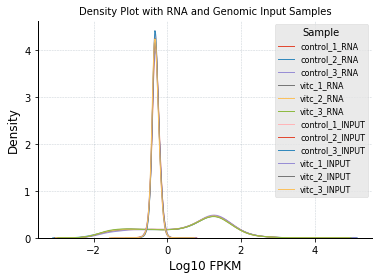

In [148]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", "vitc_1_INPUT", "vitc_2_INPUT", "vitc_3_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_VitC_RNA_LOD_Chart.png", dpi=300) # size above specified at 10x6


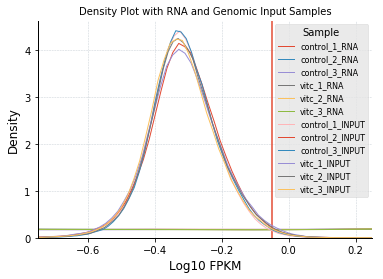

In [149]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", "vitc_1_INPUT", "vitc_2_INPUT", "vitc_3_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=-0.05)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_VitC_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

From the graphs above, we can see that they cross at -0.05. This is log base 10, so this converts to 0.89125094 FPKM. I am going to use 0.89 as my limit of detection for simplicity. Moving forward, I am going to keep genes that have one or both sample types averages above 0.89 FPKM. These are the ones that will be used for further analysis.

In [150]:
SC_VitC_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  \
Ensembl_ID                                                           
ENSRNOG00000000001        0.725724        0.903497        0.644060   
ENSRNOG00000000007        0.012158        0.000000        0.011239   
ENSRNOG00000000008        4.776368        4.660176        5.024550   
ENSRNOG00000000009        0.000000        0.000000        0.027920   
ENSRNOG00000000010        0.050456        0.031725        0.077740   

                    Control_Average_FPKM  VitC_Average_FPKM  Fold_Change  \
Ensembl_ID                                                                 
ENSRNOG00000000001              0.562391           0.757760     1.347391   
ENSRNOG00000000007              0.000000           0.007799     1.000000   
ENSRNOG00000000008              2.391998           4.820365     2.015204   
ENSRNOG00000000009              0.000000           0.009307     1.000000   
ENSRNOG00000000010              0.028927           0.053307     1.000000   

                      Log2FC         edgeR        DESeq2           Change  
Ensembl_ID                                                                 
ENSRNOG00000000001  0.430168  7.507860e-01  6.209275e-01  Nondifferential  
ENSRNOG00000000007  0.000000  3.898456e-01  1.000000e+00  Nondifferential  
ENSRNOG00000000008  1.010926  3.470000e-12  1.440000e-09      Upregulated  
ENSRNOG00000000009  0.000000  6.624017e-01  1.000000e+00  Nondifferential  
ENSRNOG00000000010  0.000000  5.854191e-01  1.000000e+00  Nondifferential

In [151]:
SC_VitC_RNA_FPKM_table["Expressed"] = SC_VitC_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["VitC_Average_FPKM"] > 0.89 or x["Control_Average_FPKM"] > 0.89) else "Below_LOD", axis = 1)

In [152]:
SC_VitC_RNA_FPKM_table.head()

SC_Control_1_FPKM  SC_Control_2_FPKM  SC_Control_3_FPKM  \
Ensembl_ID                                                                    
ENSRNOG00000000001           0.715156           0.486008           0.754285   
ENSRNOG00000000007           0.000000           0.000000           0.000000   
ENSRNOG00000000008           2.411374           2.382310           2.445488   
ENSRNOG00000000009           0.000000           0.000000           0.000000   
ENSRNOG00000000010           0.033148           0.026817           0.019001   

                    SC_VitC_1_FPKM  SC_VitC_2_FPKM  SC_VitC_3_FPKM  \
Ensembl_ID                                                           
ENSRNOG00000000001        0.725724        0.903497        0.644060   
ENSRNOG00000000007        0.012158        0.000000        0.011239   
ENSRNOG00000000008        4.776368        4.660176        5.024550   
ENSRNOG00000000009        0.000000        0.000000        0.027920   
ENSRNOG00000000010        0.050456        0.031725        0.077740   

                    Control_Average_FPKM  VitC_Average_FPKM  Fold_Change  \
Ensembl_ID                                                                 
ENSRNOG00000000001              0.562391           0.757760     1.347391   
ENSRNOG00000000007              0.000000           0.007799     1.000000   
ENSRNOG00000000008              2.391998           4.820365     2.015204   
ENSRNOG00000000009              0.000000           0.009307     1.000000   
ENSRNOG00000000010              0.028927           0.053307     1.000000   

                      Log2FC         edgeR        DESeq2           Change  \
Ensembl_ID                                                                  
ENSRNOG00000000001  0.430168  7.507860e-01  6.209275e-01  Nondifferential   
ENSRNOG00000000007  0.000000  3.898456e-01  1.000000e+00  Nondifferential   
ENSRNOG00000000008  1.010926  3.470000e-12  1.440000e-09      Upregulated   
ENSRNOG00000000009  0.000000  6.624017e-01  1.000000e+00  Nondifferential   
ENSRNOG00000000010  0.000000  5.854191e-01  1.000000e+00  Nondifferential   

                    Expressed  
Ensembl_ID                     
ENSRNOG00000000001  Below_LOD  
ENSRNOG00000000007  Below_LOD  
ENSRNOG00000000008  Expressed  
ENSRNOG00000000009  Below_LOD  
ENSRNOG00000000010  Below_LOD

In [153]:
SC_VitC_Expressed_Genes = SC_VitC_RNA_FPKM_table[SC_VitC_RNA_FPKM_table["Expressed"] == "Expressed"]

In [154]:
len(SC_VitC_Expressed_Genes)
# We have 11,848 genes left that are expressed

11848

I am a little bummed to see that we only have 11,848 genes left. I think we have more that are really detectable, so I am going to go with the old fashioned way of taking the minimum point between the two humps of only the RNA.


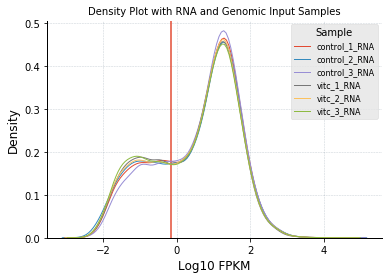

In [155]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
#ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=-0.15)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_VitC_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

If I change the line to -0.15, it changes the LOD to only 0.71, which I think is more reasonable. I am going to try that. 

In [156]:
SC_VitC_RNA_FPKM_table["Expressed"] = SC_VitC_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["VitC_Average_FPKM"] > 0.71 or x["Control_Average_FPKM"] > 0.71) else "Below_LOD", axis = 1)
SC_VitC_Expressed_Genes = SC_VitC_RNA_FPKM_table[SC_VitC_RNA_FPKM_table["Expressed"] == "Expressed"]
len(SC_VitC_Expressed_Genes)
# We have 12,152 genes left that are expressed
# I guess that is a few more to look at. 

12152

In [157]:
print("Downregulated Genes:", len(SC_VitC_Expressed_Genes[SC_VitC_Expressed_Genes["Change"] == "Downregulated"]))
print("Upregulated Genes:",len(SC_VitC_Expressed_Genes[SC_VitC_Expressed_Genes["Change"] == "Upregulated"]))
print("Nondifferential Genes:",len(SC_VitC_Expressed_Genes[SC_VitC_Expressed_Genes["Change"] == "Nondifferential"]))

Downregulated Genes: 1798
Upregulated Genes: 1984
Nondifferential Genes: 8370


In [158]:
SC_VitC_Expressed_Genes.to_csv(Output_Path+"SC_VitC_Expressed_RNA.csv")
SC_VitC_Expressed_Genes.to_pickle(Output_Path+"SC_VitC_Expressed_RNA.pkl")

We can see that we have 1,984 genes that go up and 1,798 genes that go down after treatement with vitamin C. This is much lower than the 8,370 genes that do not change after treatment. This matches the assumption that most genes will not change, and indicates that our treatment was not too extreme.

Now I have a table of the expressed genes, as well as the information about how they react to vitamin C treatment.
The next step is going to be to integrate this with the information that we have generated about the hMeDIP peaks.

In [159]:
SC_VitC_Expressed_Genes = pd.read_pickle(Output_Path+"SC_VitC_Expressed_RNA.pkl")
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )
summed_counts = pd.read_pickle(Output_Path+"SC_VitC_Counts_of_peaks_per_region.pkl")

In [160]:
Rat_Genomic_Info_File.head()

Gene_Name                  Location Sense  \
Ensembl_ID                                                           
ENSRNOG00000000001  AABR07013255.1  chr2:230660664-230662084     +   
ENSRNOG00000000007            Gad1    chr3:56861396-56902157     +   
ENSRNOG00000000008            Alx4    chr3:82548959-82585531     +   
ENSRNOG00000000009          Tmco5b  chr3:104749051-104765436     +   
ENSRNOG00000000010           Cbln1   chr19:20607507-20611316     +   

                      Gene_Biotype       transcript_id Chr      Start  \
Ensembl_ID                                                              
ENSRNOG00000000001      pseudogene  ENSRNOT00000055633   2  230660664   
ENSRNOG00000000007  protein_coding  ENSRNOT00000087712   3   56862691   
ENSRNOG00000000008  protein_coding  ENSRNOT00000000009   3   82548959   
ENSRNOG00000000009  protein_coding  ENSRNOT00000000010   3  104749051   
ENSRNOG00000000010  protein_coding  ENSRNOT00000000011  19   20607507   

                         Stop  Length  Exon Length  Intron Length  \
Ensembl_ID                                                          
ENSRNOG00000000001  230662084    1421         1416              5   
ENSRNOG00000000007   56902137   39447         3381          36066   
ENSRNOG00000000008   82585531   36573         1747          34826   
ENSRNOG00000000009  104765436   16386         1361          15025   
ENSRNOG00000000010   20611316    3810         2444           1366   

                               Gene_ID  gene_version  transcript_version  \
Ensembl_ID                                                                 
ENSRNOG00000000001  ENSRNOG00000000001             5                   2   
ENSRNOG00000000007  ENSRNOG00000000007             7                   1   
ENSRNOG00000000008  ENSRNOG00000000008             7                   5   
ENSRNOG00000000009  ENSRNOG00000000009             5                   5   
ENSRNOG00000000010  ENSRNOG00000000010             5                   5   

                         gene_name gene_source    gene_biotype  \
Ensembl_ID                                                       
ENSRNOG00000000001  AABR07013255.1     ensembl      pseudogene   
ENSRNOG00000000007            Gad1     ensembl  protein_coding   
ENSRNOG00000000008            Alx4     ensembl  protein_coding   
ENSRNOG00000000009          Tmco5b     ensembl  protein_coding   
ENSRNOG00000000010           Cbln1     ensembl  protein_coding   

                       transcript_name transcript_source transcript_biotype  
Ensembl_ID                                                                   
ENSRNOG00000000001  AABR07013255.1-201           ensembl         pseudogene  
ENSRNOG00000000007            Gad1-204           ensembl     protein_coding  
ENSRNOG00000000008            Alx4-201           ensembl     protein_coding  
ENSRNOG00000000009          Tmco5b-201           ensembl     protein_coding  
ENSRNOG00000000010           Cbln1-201           ensembl     protein_coding

In [161]:
labels = SC_VitC_Expressed_Genes[["Change"]]
relevant_genomic_info = Rat_Genomic_Info_File[["Gene_Name", "Gene_Biotype", "Chr", "Length", "Exon Length"]]

In [162]:
labels.head()

Change
Ensembl_ID                         
ENSRNOG00000000001  Nondifferential
ENSRNOG00000000008      Upregulated
ENSRNOG00000000017  Nondifferential
ENSRNOG00000000021  Nondifferential
ENSRNOG00000000024  Nondifferential

In [163]:
relevant_genomic_info.head()

Gene_Name    Gene_Biotype Chr  Length  Exon Length
Ensembl_ID                                                                 
ENSRNOG00000000001  AABR07013255.1      pseudogene   2    1421         1416
ENSRNOG00000000007            Gad1  protein_coding   3   39447         3381
ENSRNOG00000000008            Alx4  protein_coding   3   36573         1747
ENSRNOG00000000009          Tmco5b  protein_coding   3   16386         1361
ENSRNOG00000000010           Cbln1  protein_coding  19    3810         2444

In [164]:
expressed_genes_info = labels.join(relevant_genomic_info)

In [165]:
expressed_genes_info.groupby(["Gene_Biotype"], as_index = False).size()

Gene_Biotype
0                                      44
Mt_rRNA                                 2
Mt_tRNA                                10
TEC                                     3
antisense_RNA                          11
lincRNA                               208
miRNA                                 106
misc_RNA                               33
processed_pseudogene                  138
processed_transcript                   33
protein_coding                      11218
pseudogene                            169
rRNA                                    2
ribozyme                                4
scaRNA                                  7
snRNA                                  77
snoRNA                                 77
transcribed_processed_pseudogene        2
unprocessed_pseudogene                  8
dtype: int64

It is not surprising that the majority of the expressed genes (11,218 of the 12,152) are protein coding genes. It looks like the next most common is lincRNA (208) and pseudogenes (169). I may join all of the noncoding types together for further anaylsis.

In [166]:
expressed_genes_info = expressed_genes_info.join(summed_counts)
expressed_genes_info = expressed_genes_info.fillna(0)

In [167]:
expressed_genes_info.head()

Change       Gene_Name    Gene_Biotype Chr  \
Ensembl_ID                                                                
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000008      Upregulated            Alx4  protein_coding   3   
ENSRNOG00000000017  Nondifferential          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024  Nondifferential           Hebp1  protein_coding   4   

                    Length  Exon Length  Downstream_Promoter_Downregulated  \
Ensembl_ID                                                                   
ENSRNOG00000000001    1421         1416                                0.0   
ENSRNOG00000000008   36573         1747                                0.0   
ENSRNOG00000000017   10589         1280                                0.0   
ENSRNOG00000000021    1202         1200                                0.0   
ENSRNOG00000000024   29515         1062                                0.0   

                    Upstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                     
ENSRNOG00000000001                              1.0                      0.0   
ENSRNOG00000000008                              0.0                      0.0   
ENSRNOG00000000017                              1.0                      0.0   
ENSRNOG00000000021                              0.0                      0.0   
ENSRNOG00000000024                              0.0                      1.0   

                    TSS_Downregulated  Downstream_Promoter_Nondifferential  \
Ensembl_ID                                                                   
ENSRNOG00000000001                0.0                                  1.0   
ENSRNOG00000000008                0.0                                  0.0   
ENSRNOG00000000017                0.0                                  0.0   
ENSRNOG00000000021                0.0                                  0.0   
ENSRNOG00000000024                0.0                                  0.0   

                    Upstream_Promoter_Nondifferential  \
Ensembl_ID                                              
ENSRNOG00000000001                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000021                                0.0   
ENSRNOG00000000024                                0.0   

                    Gene_Body_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                           
ENSRNOG00000000001                        0.0                  0.0   
ENSRNOG00000000008                        4.0                  0.0   
ENSRNOG00000000017                        0.0                  0.0   
ENSRNOG00000000021                        0.0                  0.0   
ENSRNOG00000000024                        5.0                  0.0   

                    Downstream_Promoter_Upregulated  \
Ensembl_ID                                            
ENSRNOG00000000001                              0.0   
ENSRNOG00000000008                              1.0   
ENSRNOG00000000017                              0.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Upstream_Promoter_Upregulated  Gene_Body_Upregulated  \
Ensembl_ID                                                                 
ENSRNOG00000000001                            0.0                    0.0   
ENSRNOG00000000008                            1.0                    4.0   
ENSRNOG00000000017                            0.0                    0.0   
ENSRNOG00000000021                            0.0                    0.0   
ENSRNOG00000000024                            0.0                    2.0   

                    TSS_Upregulated  


In [168]:
expressed_genes_info.describe()

Length   Exon Length  Downstream_Promoter_Downregulated  \
count  1.215200e+04  12152.000000                       12152.000000   
mean   4.200248e+04   2590.660303                           0.023700   
std    7.477106e+04   1940.736936                           0.154267   
min    4.900000e+01     49.000000                           0.000000   
25%    6.241000e+03   1336.000000                           0.000000   
50%    1.847350e+04   2148.000000                           0.000000   
75%    4.660600e+04   3387.000000                           0.000000   
max    2.232523e+06  25658.000000                           2.000000   

       Upstream_Promoter_Downregulated  Gene_Body_Downregulated  \
count                     12152.000000             12152.000000   
mean                          0.028061                 0.388660   
std                           0.168118                 1.120189   
min                           0.000000                 0.000000   
25%                           0.000000                 0.000000   
50%                           0.000000                 0.000000   
75%                           0.000000                 0.000000   
max                           2.000000                30.000000   

       TSS_Downregulated  Downstream_Promoter_Nondifferential  \
count       12152.000000                         12152.000000   
mean            0.002222                             0.135369   
std             0.047086                             0.374075   
min             0.000000                             0.000000   
25%             0.000000                             0.000000   
50%             0.000000                             0.000000   
75%             0.000000                             0.000000   
max             1.000000                             5.000000   

       Upstream_Promoter_Nondifferential  Gene_Body_Nondifferential  \
count                       12152.000000               12152.000000   
mean                            0.137837                   2.314269   
std                             0.377340                   5.006940   
min                             0.000000                   0.000000   
25%                             0.000000                   0.000000   
50%                             0.000000                   0.000000   
75%                             0.000000                   2.000000   
max                             4.000000                 107.000000   

       TSS_Nondifferential  Downstream_Promoter_Upregulated  \
count         12152.000000                     12152.000000   
mean              0.015800                         0.262755   
std               0.126019                         0.522557   
min               0.000000                         0.000000   
25%               0.000000                         0.000000   
50%               0.000000                         0.000000   
75%               0.000000                         0.000000   
max               2.000000                         4.000000   

       Upstream_Promoter_Upregulated  Gene_Body_Upregulated  TSS_Upregulated  
count                   12152.000000           12152.000000     12152.000000  
mean                        0.184414               3.384052         0.027403  
std                         0.453929               7.755123         0.166752  
min                         0.000000               0.000000         0.000000  
25%                         0.000000               0.000000         0.000000  
50%                         0.000000               1.000000         0.000000  
75%                         0.000000               3.000000         0.000000  
max                         5.000000             148.000000         2.000000

In [169]:
expressed_genes_info.to_csv("Output_Tables_and_Results/SC_VitC_Combined_Cleaned_Data.csv")
expressed_genes_info.to_pickle("Output_Tables_and_Results/SC_VitC_Combined_Cleaned_Data.pkl")


This is the finally cleaned data. I realize that I did not need to have all of the steps for finding outliers to get the table this way, but it was needed to accurately determine the fold change, which might end up being used in this project and will very likely be used in other projects. Additionally, the corrected FPKM values are needed for heatmaps and were needed to determine the expression threshold. 

Exploration of the data has shown that there are slightly more upregulated genes than downregulated genes in the SC Vitamin C dataset, but this is still only about 1/3 of the expressed genes (12,152). About 90% of the expressed genes are protein coding genes (11,218), even though they make up a relatively small portion of the annotated genome. This is consistent with other RNA-seq studies in Rat, and there are probably more noncoding genes, but they aren't as well annotated in rats. It looks like the highest average peak counts are genebody upregulated (3.38) followed by genebody nondifferential (2.3). We now have many dimensions and this should be helpful for determining if we can classify genes based on the genomic info and hMeDIP peak information (data about DNA methylation). 

# RNA and hMeDIP Clustering and Data Exploration

## Information obtained from data cleaning

In the three previous notebooks I have cleaned up all of the data and created dataframes that contain info about all of the expressed genes. There is one dataframe for each data set (Human ARPE-19 cells treated with vitamin C, Rat Schwann cells treated with vitamin C, and Rat Schwann cells treated with cAMP). The columns (not necessarily in this order) are as follows: 

1. Ensembl ID: this is just the ID for each gene, will be used as the index
2. Change: meaning the change in transcription in response to either vitamin C or cAMP, this will be the label
3. Name: This is the gene name. I kept these so that we can look at the clusters later, but this will not be included in the analysis.
4. Biotype: Most of these are protein coding, so this will be changed to a binary classification of either protein coding or not protein coding
5. Chromosome: Should not be a confounding variable, but I thought I should include it for just in case.
6. Length: Entire transcript length, from transcription start site (TSS) to transcription termination site (TTS)
7. Exonic Length: Length of the coding transcript, exons only
8. TSS_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's TSS
9. Downstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
10. Gene_Body_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
11. Upstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
12. TSS_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's TSS
13. Downstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
14. Gene_Body_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
15. Upstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
16. TSS_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's TSS
17. Downstream_Promoter_Upregulated: Number of peaks that increae in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
18. Gene_Body_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
19. Upstream_Promoter_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale

from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering

import csv
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

In [2]:
cleaned_data_path = "Output_Tables_and_Results/"
output_path = "Clustering_Output/"

In [4]:
import os
os.listdir("Output_Tables_and_Results/")

['ARPE_Intermediate_Files',
 'SC_VitC_Combined_Cleaned_Data.csv',
 'SC_cAMP_Combined_Cleaned_Data.pkl',
 '.DS_Store',
 'ARPE_Combined_Cleaned_Data.csv',
 'ARPE_Combined_Cleaned_Data.pkl',
 'SC-VitC_Intermediate_Files',
 'SC-cAMP_Intermediate_Files',
 'SC_cAMP_Combined_Cleaned_Data.csv',
 'SC_VitC_Combined_Cleaned_Data.pkl']

In [5]:
ARPE_cleaned_dataset = pd.read_pickle(cleaned_data_path+"ARPE_Combined_Cleaned_Data.pkl")
SC_VitC_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_VitC_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")



In [6]:
ARPE_cleaned_dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated  TSS_Nondifferential  \
Ensembl_ID                                                              
ENSG00000000003                              0.0                  1.0   
ENSG00000000419                              0.0                  0.0   
ENSG00000000457                              0.0                  0.0   
ENSG00000000460                              0.0                  0.0   
ENSG00000000971                              0.0                  0.0   

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  
Ensembl_ID                                                             
ENSG00000000003                    0.0                            0.0  
ENSG00000000419                    1.0                            0.0  
ENSG00000000457                    1.0                            0.0  
ENSG00000000460                    2.0                            0.0  
ENSG00000000971                    0.0                            0.0

In [7]:
SC_VitC_cleaned_dataset.head()

Change       Gene_Name    Gene_Biotype Chr  \
Ensembl_ID                                                                
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000008      Upregulated            Alx4  protein_coding   3   
ENSRNOG00000000017  Nondifferential          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024  Nondifferential           Hebp1  protein_coding   4   

                    Length  Exon Length  Downstream_Promoter_Downregulated  \
Ensembl_ID                                                                   
ENSRNOG00000000001    1421         1416                                0.0   
ENSRNOG00000000008   36573         1747                                0.0   
ENSRNOG00000000017   10589         1280                                0.0   
ENSRNOG00000000021    1202         1200                                0.0   
ENSRNOG00000000024   29515         1062                                0.0   

                    Upstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                     
ENSRNOG00000000001                              1.0                      0.0   
ENSRNOG00000000008                              0.0                      0.0   
ENSRNOG00000000017                              1.0                      0.0   
ENSRNOG00000000021                              0.0                      0.0   
ENSRNOG00000000024                              0.0                      1.0   

                    TSS_Downregulated  Downstream_Promoter_Nondifferential  \
Ensembl_ID                                                                   
ENSRNOG00000000001                0.0                                  1.0   
ENSRNOG00000000008                0.0                                  0.0   
ENSRNOG00000000017                0.0                                  0.0   
ENSRNOG00000000021                0.0                                  0.0   
ENSRNOG00000000024                0.0                                  0.0   

                    Upstream_Promoter_Nondifferential  \
Ensembl_ID                                              
ENSRNOG00000000001                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000021                                0.0   
ENSRNOG00000000024                                0.0   

                    Gene_Body_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                           
ENSRNOG00000000001                        0.0                  0.0   
ENSRNOG00000000008                        4.0                  0.0   
ENSRNOG00000000017                        0.0                  0.0   
ENSRNOG00000000021                        0.0                  0.0   
ENSRNOG00000000024                        5.0                  0.0   

                    Downstream_Promoter_Upregulated  \
Ensembl_ID                                            
ENSRNOG00000000001                              0.0   
ENSRNOG00000000008                              1.0   
ENSRNOG00000000017                              0.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Upstream_Promoter_Upregulated  Gene_Body_Upregulated  \
Ensembl_ID                                                                 
ENSRNOG00000000001                            0.0                    0.0   
ENSRNOG00000000008                            1.0                    4.0   
ENSRNOG00000000017                            0.0                    0.0   
ENSRNOG00000000021                            0.0                    0.0   
ENSRNOG00000000024                            0.0                    2.0   

                    TSS_Upregulated  


In [8]:
SC_cAMP_cleaned_dataset.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon Length  Gene_Body_Downregulated  \
Gene_ID                                                            
ENSRNOG00000000001    1421         1416                      0.0   
ENSRNOG00000000010    3810         2444                      0.0   
ENSRNOG00000000017   10589         1280                      0.0   
ENSRNOG00000000021    1202         1200                      0.0   
ENSRNOG00000000024   29515         1062                      2.0   

                    Upstream_Promoter_Downregulated  \
Gene_ID                                               
ENSRNOG00000000001                              0.0   
ENSRNOG00000000010                              0.0   
ENSRNOG00000000017                              1.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                                0.0                0.0   
ENSRNOG00000000010                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000021                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   

                    Gene_Body_Nondifferential  \
Gene_ID                                         
ENSRNOG00000000001                        0.0   
ENSRNOG00000000010                        0.0   
ENSRNOG00000000017                        0.0   
ENSRNOG00000000021                        0.0   
ENSRNOG00000000024                        4.0   

                    Upstream_Promoter_Nondifferential  \
Gene_ID                                                 
ENSRNOG00000000001                                0.0   
ENSRNOG00000000010                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000021                                0.0   
ENSRNOG00000000024                                0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                                        
ENSRNOG00000000001                                  0.0                  0.0   
ENSRNOG00000000010                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000021                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                    0.0                            0.0   
ENSRNOG00000000010                    0.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000021                    0.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  
Gene_ID                                                               
ENSRNOG00000000001                              0.0              0.0  
ENSRNOG00000000010                              0.0     

In [9]:
# sns.set()
# sns.pairplot(ARPE_cleaned_dataset, hue = "Change")
# plt.savefig(output_path+"ARPE_pairplot.png", dpi=300, figsize=(24, 24)) 

In [10]:
# sns.set()
# sns.pairplot(SC_VitC_cleaned_dataset, hue = "Change")
# plt.savefig(output_path+"SC_VitC_pairplot.png", dpi=300, figsize=(24, 24)) 

In [11]:
# sns.set()
# sns.pairplot(SC_cAMP_cleaned_dataset, hue = "Change")
# plt.savefig(output_path+"SC_cAMP_pairplot.png", dpi=300, figsize=(24, 24)) 

It is really hard to see these inline because there are too many variables so each individual portion looks very small, but I have saved the images to very large files (24x24 inches, 300 dpi) so that you can zoom in and look at them all clearly. I have put a # in front of each line so that if I restart and run all cells it won't try to redo these ones, as they take a few minutes each to generate. 

Findings from this pairplot: The density plots show that some types of peaks are less commonly found in the upregulated genes than in the downregulated or nondifferential genes (downstream promoter upregulated, downstream promoter downregulated, upstream promoter nondifferential). It looks like this might just mean that there are fewer peaks in general in the promoter regions of upregulated genes. There appear to be more peaks in the promoter regions for downregulated genes in general as well. Genebody upregulated and genebody nondifferential appear to be positively correlated. This appears consistent for all 3 datasets. 

Most of the variables do not appear to be correlated in any way. Ones that do appear to have some sort of correlation are Length and Exonic Length (looks somewhat positively correlated). Additionally, gene body nondifferential peaks appear to be somewhat correlated with Length (somewhat positively correlated). This apparent lack of correlation between variables doesn't say much. 




In [12]:
SC_cAMP_cleaned_dataset.columns.values

array(['Change', 'Gene_Name', 'Gene_Biotype', 'Chr', 'Length',
       'Exon Length', 'Gene_Body_Downregulated',
       'Upstream_Promoter_Downregulated',
       'Downstream_Promoter_Downregulated', 'TSS_Downregulated',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'Downstream_Promoter_Nondifferential', 'TSS_Nondifferential',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Downstream_Promoter_Upregulated', 'TSS_Upregulated'], dtype=object)

In [13]:
SC_cAMP_cleaned_dataset["Change_down"] = SC_cAMP_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Downregulated" else 0)
SC_cAMP_cleaned_dataset["Change_up"] = SC_cAMP_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Upregulated" else 0)
SC_cAMP_cleaned_dataset["Change_nondiff"] = SC_cAMP_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Nondifferential" else 0)


In [14]:
SC_cAMP_cleaned_dataset.rename(columns = {"Exon Length": "Exon_Length"}, inplace = True)

In [15]:
SC_cAMP_cleaned_dataset.tail(10)

Change       Gene_Name          Gene_Biotype Chr  \
Gene_ID                                                                         
ENSRNOG00000062253  Nondifferential   Rn60_2_0037.2  processed_pseudogene   2   
ENSRNOG00000062261      Upregulated  Rn60_15_0518.2               lincRNA  15   
ENSRNOG00000062272  Nondifferential  Rn60_17_0157.2  processed_pseudogene  17   
ENSRNOG00000062279    Downregulated            Cln5        protein_coding  15   
ENSRNOG00000062289  Nondifferential   Rn60_7_0127.5         antisense_RNA   7   
ENSRNOG00000062294  Nondifferential  Rn60_17_0156.3         antisense_RNA  17   
ENSRNOG00000062296  Nondifferential   Rn60_X_0201.2  processed_pseudogene   X   
ENSRNOG00000062298      Upregulated          Rpl13a        protein_coding   1   
ENSRNOG00000062306  Nondifferential         Cyp4f17        protein_coding   7   
ENSRNOG00000062308  Nondifferential   Rn60_5_1207.2  processed_transcript   5   

                    Length  Exon_Length  Gene_Body_Downregulated  \
Gene_ID                                                            
ENSRNOG00000062253     481          481                      0.0   
ENSRNOG00000062261     478          478                      0.0   
ENSRNOG00000062272     400          400                      0.0   
ENSRNOG00000062279    4431          509                      0.0   
ENSRNOG00000062289    1579          443                      0.0   
ENSRNOG00000062294    3489          495                      0.0   
ENSRNOG00000062296     842          842                      0.0   
ENSRNOG00000062298    3078         1039                      0.0   
ENSRNOG00000062306   16269         2132                      0.0   
ENSRNOG00000062308  178809         3654                      0.0   

                    Upstream_Promoter_Downregulated  \
Gene_ID                                               
ENSRNOG00000062253                              0.0   
ENSRNOG00000062261                              0.0   
ENSRNOG00000062272                              0.0   
ENSRNOG00000062279                              0.0   
ENSRNOG00000062289                              0.0   
ENSRNOG00000062294                              0.0   
ENSRNOG00000062296                              0.0   
ENSRNOG00000062298                              0.0   
ENSRNOG00000062306                              0.0   
ENSRNOG00000062308                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000062253                                0.0                0.0   
ENSRNOG00000062261                                0.0                0.0   
ENSRNOG00000062272                                0.0                0.0   
ENSRNOG00000062279                                0.0                0.0   
ENSRNOG00000062289                                0.0                0.0   
ENSRNOG00000062294                                0.0                0.0   
ENSRNOG00000062296                                0.0                0.0   
ENSRNOG00000062298                                0.0                0.0   
ENSRNOG00000062306                                0.0                1.0   
ENSRNOG00000062308                                0.0                0.0   

                         ...        Upstream_Promoter_Nondifferential  \
Gene_ID                  ...                                            
ENSRNOG00000062253       ...                                      0.0   
ENSRNOG00000062261       ...                                      0.0   
ENSRNOG00000062272       ...                                      0.0   
ENSRNOG00000062279       ...                                      0.0   
ENSRNOG00000062289       ...                                      0.0   
ENSRNOG00000062294       ...                                      0.0   
ENSRNOG00000062296       ...                                      0.0   
ENSRNOG0

In [16]:
multiple = sm.ols(formula="""Change_down ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_cAMP_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Change_down   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     17.64
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          4.82e-174
Time:                        19:32:08   Log-Likelihood:                -7453.5
No. Observations:               12165   AIC:                         1.503e+04
Df Residuals:                   12104   BIC:                         1.548e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.2644      0.068      3.904      0.000       0.132       0.397
Gene_Biotype[T.Mt_rRNA]                             -0.1057      0.347     -0.305      0.760      -0.785       0.574
Gene_Biotype[T.Mt_tRNA]                             -0.0725      0.220     -0.329      0.742      -0.504       0.359
Gene_Biotype[T.TEC]                                 -0.3582      0.267     -1.340      0.180      -0.882       0.166
Gene_Biotype[T.antisense_RNA]                       -0.1298      0.121     -1.077      0.281      -0.366       0.106
Gene_Biotype[T.lincRNA]                              0.0177      0.073      0.242      0.808      -0.125       0.161
Gene_Biotype[T.miRNA]                               -0.0738      0.083     -0.891      0.373      -0.236       0.089
Gene_Biotype[T.misc_RNA]                            -0.2777      0.101     -2.748      0.006      -0.476      -0.080
Gene_Biotype[T.processed_pseudogene]                -0.2497      0.079     -3.164      0.002      -0.404      -0.095
Gene_Biotype[T.processed_transcript]                -0.2139      0.099     -2.155      0.031      -0.409      -0.019
Gene_Biotype[T.protein_coding]                      -0.0950      0.067     -1.418      0.156      -0.226       0.036
Gene_Biotype[T.pseudogene]                          -0.1350      0.076     -1.777      0.076      -0.284       0.014
Gene_Biotype[T.rRNA]                                -0.2758      0.267     -1.033      0.302      -0.799       0.248
Gene_Biotype[T.ribozyme]                            -0.3343      0.324     -1.032      0.302      -0.969       0.300
Gene_Biotype[T.scaRNA]                              -0.3454      0.234     -1.476      0.140      -0.804       0.113
Gene_Biotype[T.snRNA]                               -0.2632      0.079     -3.337      0.001      -0.418      -0.109
Gene_Biotype[T.snoRNA]                              -0.1301      0.081     -1.604      0.109      -0.289       0.029
Gene_Biotype[T.transcribed_processed_pseudogene]    -0.3689      0.234     -1.575      0.115      -0.828       0.090
Gene_Biotype[T.unprocessed_pseudogene]              -0.4002      0.182     -2.197      0.028      -0.757      -0.043
Chr[T.10]                                           -0.0308      0.018     -1.681      0.093      -0.067       0.005
Chr[T.11]                                            0.0412      0.028      1.485      0.138      -0.013       0.096
Chr[T.12]                                           -0.0309      0.025     -1.218      0.223      -0.081       0.019
Chr[T.13]                                            0.0949      0.027      3.552      0.000       0.043       0.147
Chr[T.14]                                

In [17]:
multiple = sm.ols(formula="""Change_up ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_cAMP_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Change_up   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     8.774
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           7.71e-74
Time:                        19:32:08   Log-Likelihood:                -8052.5
No. Observations:               12165   AIC:                         1.623e+04
Df Residuals:                   12104   BIC:                         1.668e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.2459      0.071      3.456      0.001       0.106       0.385
Gene_Biotype[T.Mt_rRNA]                              0.3706      0.364      1.018      0.309      -0.343       1.084
Gene_Biotype[T.Mt_tRNA]                             -0.3694      0.231     -1.596      0.110      -0.823       0.084
Gene_Biotype[T.TEC]                                 -0.1650      0.281     -0.588      0.557      -0.715       0.385
Gene_Biotype[T.antisense_RNA]                        0.0951      0.127      0.751      0.453      -0.153       0.343
Gene_Biotype[T.lincRNA]                              0.0758      0.077      0.989      0.323      -0.074       0.226
Gene_Biotype[T.miRNA]                               -0.1274      0.087     -1.464      0.143      -0.298       0.043
Gene_Biotype[T.misc_RNA]                            -0.1423      0.106     -1.341      0.180      -0.350       0.066
Gene_Biotype[T.processed_pseudogene]                 0.1354      0.083      1.633      0.102      -0.027       0.298
Gene_Biotype[T.processed_transcript]                 0.2113      0.104      2.026      0.043       0.007       0.416
Gene_Biotype[T.protein_coding]                       0.2084      0.070      2.963      0.003       0.071       0.346
Gene_Biotype[T.pseudogene]                           0.1339      0.080      1.678      0.093      -0.023       0.290
Gene_Biotype[T.rRNA]                                 0.0879      0.281      0.313      0.754      -0.462       0.638
Gene_Biotype[T.ribozyme]                             0.8005      0.340      2.353      0.019       0.134       1.467
Gene_Biotype[T.scaRNA]                               0.0333      0.246      0.136      0.892      -0.448       0.515
Gene_Biotype[T.snRNA]                               -0.0276      0.083     -0.333      0.739      -0.190       0.135
Gene_Biotype[T.snoRNA]                              -0.0434      0.085     -0.509      0.611      -0.210       0.124
Gene_Biotype[T.transcribed_processed_pseudogene]     0.3187      0.246      1.296      0.195      -0.163       0.801
Gene_Biotype[T.unprocessed_pseudogene]              -0.0295      0.191     -0.154      0.878      -0.405       0.346
Chr[T.10]                                            0.0381      0.019      1.978      0.048       0.000       0.076
Chr[T.11]                                           -0.0049      0.029     -0.167      0.868      -0.062       0.052
Chr[T.12]                                            0.0157      0.027      0.591      0.555      -0.036       0.068
Chr[T.13]                                           -0.0489      0.028     -1.742      0.082      -0.104       0.006
Chr[T.14]                                

In [18]:
multiple = sm.ols(formula="""Change_nondiff ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_cAMP_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Change_nondiff   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     8.994
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           2.74e-76
Time:                        19:32:08   Log-Likelihood:                -7768.6
No. Observations:               12165   AIC:                         1.566e+04
Df Residuals:                   12104   BIC:                         1.611e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.4897      0.069      7.047      0.000       0.354       0.626
Gene_Biotype[T.Mt_rRNA]                             -0.2649      0.356     -0.745      0.456      -0.962       0.432
Gene_Biotype[T.Mt_tRNA]                              0.4419      0.226      1.955      0.051      -0.001       0.885
Gene_Biotype[T.TEC]                                  0.5231      0.274      1.907      0.056      -0.014       1.061
Gene_Biotype[T.antisense_RNA]                        0.0347      0.124      0.281      0.779      -0.208       0.277
Gene_Biotype[T.lincRNA]                             -0.0935      0.075     -1.248      0.212      -0.240       0.053
Gene_Biotype[T.miRNA]                                0.2012      0.085      2.367      0.018       0.035       0.368
Gene_Biotype[T.misc_RNA]                             0.4200      0.104      4.051      0.000       0.217       0.623
Gene_Biotype[T.processed_pseudogene]                 0.1143      0.081      1.411      0.158      -0.044       0.273
Gene_Biotype[T.processed_transcript]                 0.0026      0.102      0.025      0.980      -0.197       0.202
Gene_Biotype[T.protein_coding]                      -0.1134      0.069     -1.651      0.099      -0.248       0.021
Gene_Biotype[T.pseudogene]                           0.0011      0.078      0.014      0.989      -0.152       0.154
Gene_Biotype[T.rRNA]                                 0.1879      0.274      0.686      0.493      -0.349       0.725
Gene_Biotype[T.ribozyme]                            -0.4662      0.332     -1.403      0.161      -1.118       0.185
Gene_Biotype[T.scaRNA]                               0.3121      0.240      1.300      0.194      -0.159       0.783
Gene_Biotype[T.snRNA]                                0.2908      0.081      3.593      0.000       0.132       0.449
Gene_Biotype[T.snoRNA]                               0.1735      0.083      2.084      0.037       0.010       0.337
Gene_Biotype[T.transcribed_processed_pseudogene]     0.0502      0.240      0.209      0.834      -0.421       0.521
Gene_Biotype[T.unprocessed_pseudogene]               0.4297      0.187      2.299      0.022       0.063       0.796
Chr[T.10]                                           -0.0073      0.019     -0.387      0.699      -0.044       0.030
Chr[T.11]                                           -0.0363      0.028     -1.276      0.202      -0.092       0.019
Chr[T.12]                                            0.0152      0.026      0.582      0.561      -0.036       0.066
Chr[T.13]                                           -0.0460      0.027     -1.678      0.093      -0.100       0.008
Chr[T.14]                                

In [19]:

SC_VitC_cleaned_dataset["Change_down"] = SC_VitC_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Downregulated" else 0)
SC_VitC_cleaned_dataset["Change_up"] = SC_VitC_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Upregulated" else 0)
SC_VitC_cleaned_dataset["Change_nondiff"] = SC_VitC_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Nondifferential" else 0)
SC_VitC_cleaned_dataset.rename(columns = {"Exon Length": "Exon_Length"}, inplace = True)


In [20]:
SC_VitC_cleaned_dataset.head()

Change       Gene_Name    Gene_Biotype Chr  \
Ensembl_ID                                                                
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000008      Upregulated            Alx4  protein_coding   3   
ENSRNOG00000000017  Nondifferential          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024  Nondifferential           Hebp1  protein_coding   4   

                    Length  Exon_Length  Downstream_Promoter_Downregulated  \
Ensembl_ID                                                                   
ENSRNOG00000000001    1421         1416                                0.0   
ENSRNOG00000000008   36573         1747                                0.0   
ENSRNOG00000000017   10589         1280                                0.0   
ENSRNOG00000000021    1202         1200                                0.0   
ENSRNOG00000000024   29515         1062                                0.0   

                    Upstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                     
ENSRNOG00000000001                              1.0                      0.0   
ENSRNOG00000000008                              0.0                      0.0   
ENSRNOG00000000017                              1.0                      0.0   
ENSRNOG00000000021                              0.0                      0.0   
ENSRNOG00000000024                              0.0                      1.0   

                    TSS_Downregulated       ...        \
Ensembl_ID                                  ...         
ENSRNOG00000000001                0.0       ...         
ENSRNOG00000000008                0.0       ...         
ENSRNOG00000000017                0.0       ...         
ENSRNOG00000000021                0.0       ...         
ENSRNOG00000000024                0.0       ...         

                    Upstream_Promoter_Nondifferential  \
Ensembl_ID                                              
ENSRNOG00000000001                                0.0   
ENSRNOG00000000008                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000021                                0.0   
ENSRNOG00000000024                                0.0   

                    Gene_Body_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                           
ENSRNOG00000000001                        0.0                  0.0   
ENSRNOG00000000008                        4.0                  0.0   
ENSRNOG00000000017                        0.0                  0.0   
ENSRNOG00000000021                        0.0                  0.0   
ENSRNOG00000000024                        5.0                  0.0   

                    Downstream_Promoter_Upregulated  \
Ensembl_ID                                            
ENSRNOG00000000001                              0.0   
ENSRNOG00000000008                              1.0   
ENSRNOG00000000017                              0.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Upstream_Promoter_Upregulated  Gene_Body_Upregulated  \
Ensembl_ID                                                                 
ENSRNOG00000000001                            0.0                    0.0   
ENSRNOG00000000008                            1.0                    4.0   
ENSRNOG00000000017                            0.0                    0.0   
ENSRNOG00000000021                            0.0                    0.0   
ENSRNOG00000000024                            0.0                    2.0   

                    TSS_Upregulated  Change_down  Change_up  Change_nondiff  
Ensembl_ID                                                                   
ENSRNOG00000000001           

In [21]:
multiple = sm.ols(formula="""Change_down ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_VitC_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Change_down   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.630
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           2.60e-50
Time:                        19:32:09   Log-Likelihood:                -4463.2
No. Observations:               12152   AIC:                             9048.
Df Residuals:                   12091   BIC:                             9500.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.1298      0.054      2.424      0.015       0.025       0.235
Gene_Biotype[T.Mt_rRNA]                              0.0930      0.271      0.343      0.732      -0.439       0.625
Gene_Biotype[T.Mt_tRNA]                              0.0777      0.157      0.497      0.620      -0.229       0.385
Gene_Biotype[T.TEC]                                 -0.1208      0.209     -0.577      0.564      -0.531       0.289
Gene_Biotype[T.antisense_RNA]                       -0.0984      0.118     -0.832      0.405      -0.330       0.133
Gene_Biotype[T.lincRNA]                             -0.0809      0.058     -1.390      0.165      -0.195       0.033
Gene_Biotype[T.miRNA]                               -0.1180      0.063     -1.875      0.061      -0.241       0.005
Gene_Biotype[T.misc_RNA]                            -0.1048      0.081     -1.286      0.199      -0.264       0.055
Gene_Biotype[T.processed_pseudogene]                -0.0775      0.061     -1.274      0.203      -0.197       0.042
Gene_Biotype[T.processed_transcript]                 0.0385      0.081      0.474      0.635      -0.121       0.198
Gene_Biotype[T.protein_coding]                       0.0880      0.053      1.662      0.097      -0.016       0.192
Gene_Biotype[T.pseudogene]                           0.0093      0.059      0.157      0.875      -0.107       0.126
Gene_Biotype[T.rRNA]                                -0.1125      0.253     -0.444      0.657      -0.609       0.384
Gene_Biotype[T.ribozyme]                             0.4107      0.183      2.243      0.025       0.052       0.770
Gene_Biotype[T.scaRNA]                              -0.0984      0.143     -0.689      0.491      -0.378       0.181
Gene_Biotype[T.snRNA]                               -0.0449      0.066     -0.675      0.500      -0.175       0.085
Gene_Biotype[T.snoRNA]                              -0.1160      0.066     -1.748      0.080      -0.246       0.014
Gene_Biotype[T.transcribed_processed_pseudogene]    -0.0934      0.253     -0.368      0.713      -0.590       0.404
Gene_Biotype[T.unprocessed_pseudogene]              -0.1016      0.135     -0.754      0.451      -0.366       0.163
Chr[T.10]                                           -0.0052      0.014     -0.367      0.714      -0.033       0.023
Chr[T.11]                                           -0.0015      0.022     -0.069      0.945      -0.045       0.042
Chr[T.12]                                           -0.0310      0.020     -1.586      0.113      -0.069       0.007
Chr[T.13]                                           -0.0129      0.021     -0.620      0.535      -0.054       0.028
Chr[T.14]                                

In [22]:
multiple = sm.ols(formula="""Change_up ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_VitC_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Change_up   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     19.47
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          1.11e-194
Time:                        19:32:09   Log-Likelihood:                -4587.6
No. Observations:               12152   AIC:                             9297.
Df Residuals:                   12091   BIC:                             9749.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.0574      0.054      1.060      0.289      -0.049       0.163
Gene_Biotype[T.Mt_rRNA]                             -0.0057      0.274     -0.021      0.983      -0.543       0.531
Gene_Biotype[T.Mt_tRNA]                              0.0125      0.158      0.079      0.937      -0.298       0.322
Gene_Biotype[T.TEC]                                 -0.0805      0.211     -0.381      0.703      -0.495       0.334
Gene_Biotype[T.antisense_RNA]                        0.1022      0.119      0.855      0.393      -0.132       0.336
Gene_Biotype[T.lincRNA]                              0.0859      0.059      1.460      0.144      -0.029       0.201
Gene_Biotype[T.miRNA]                               -0.0368      0.064     -0.579      0.563      -0.161       0.088
Gene_Biotype[T.misc_RNA]                            -0.0448      0.082     -0.545      0.586      -0.206       0.117
Gene_Biotype[T.processed_pseudogene]                -0.0599      0.061     -0.974      0.330      -0.180       0.061
Gene_Biotype[T.processed_transcript]                -0.0005      0.082     -0.006      0.995      -0.161       0.160
Gene_Biotype[T.protein_coding]                       0.0002      0.054      0.003      0.998      -0.105       0.105
Gene_Biotype[T.pseudogene]                          -0.0487      0.060     -0.812      0.417      -0.166       0.069
Gene_Biotype[T.rRNA]                                -0.0397      0.256     -0.155      0.877      -0.542       0.462
Gene_Biotype[T.ribozyme]                            -0.0652      0.185     -0.352      0.725      -0.428       0.297
Gene_Biotype[T.scaRNA]                              -0.0677      0.144     -0.470      0.639      -0.350       0.215
Gene_Biotype[T.snRNA]                               -0.0728      0.067     -1.085      0.278      -0.204       0.059
Gene_Biotype[T.snoRNA]                              -0.0522      0.067     -0.778      0.436      -0.184       0.079
Gene_Biotype[T.transcribed_processed_pseudogene]    -0.1165      0.256     -0.455      0.649      -0.618       0.385
Gene_Biotype[T.unprocessed_pseudogene]               0.0122      0.136      0.090      0.929      -0.255       0.279
Chr[T.10]                                           -0.0439      0.014     -3.069      0.002      -0.072      -0.016
Chr[T.11]                                           -0.0126      0.022     -0.564      0.573      -0.057       0.031
Chr[T.12]                                           -0.0295      0.020     -1.494      0.135      -0.068       0.009
Chr[T.13]                                           -0.0031      0.021     -0.149      0.882      -0.044       0.038
Chr[T.14]                                

In [23]:
multiple = sm.ols(formula="""Change_nondiff ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_VitC_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Change_nondiff   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     10.36
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           1.34e-91
Time:                        19:32:09   Log-Likelihood:                -7580.7
No. Observations:               12152   AIC:                         1.528e+04
Df Residuals:                   12091   BIC:                         1.574e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.8128      0.069     11.740      0.000       0.677       0.948
Gene_Biotype[T.Mt_rRNA]                             -0.0872      0.351     -0.249      0.803      -0.774       0.600
Gene_Biotype[T.Mt_tRNA]                             -0.0902      0.202     -0.446      0.656      -0.487       0.306
Gene_Biotype[T.TEC]                                  0.2013      0.270      0.744      0.457      -0.329       0.731
Gene_Biotype[T.antisense_RNA]                       -0.0038      0.153     -0.025      0.980      -0.303       0.296
Gene_Biotype[T.lincRNA]                             -0.0050      0.075     -0.066      0.947      -0.152       0.142
Gene_Biotype[T.miRNA]                                0.1548      0.081      1.904      0.057      -0.005       0.314
Gene_Biotype[T.misc_RNA]                             0.1496      0.105      1.420      0.156      -0.057       0.356
Gene_Biotype[T.processed_pseudogene]                 0.1374      0.079      1.747      0.081      -0.017       0.291
Gene_Biotype[T.processed_transcript]                -0.0380      0.105     -0.362      0.717      -0.244       0.168
Gene_Biotype[T.protein_coding]                      -0.0882      0.068     -1.288      0.198      -0.222       0.046
Gene_Biotype[T.pseudogene]                           0.0394      0.077      0.513      0.608      -0.111       0.190
Gene_Biotype[T.rRNA]                                 0.1521      0.328      0.465      0.642      -0.490       0.794
Gene_Biotype[T.ribozyme]                            -0.3455      0.237     -1.460      0.144      -0.810       0.118
Gene_Biotype[T.scaRNA]                               0.1661      0.184      0.900      0.368      -0.195       0.528
Gene_Biotype[T.snRNA]                                0.1177      0.086      1.370      0.171      -0.051       0.286
Gene_Biotype[T.snoRNA]                               0.1681      0.086      1.961      0.050    7.74e-05       0.336
Gene_Biotype[T.transcribed_processed_pseudogene]     0.2099      0.328      0.641      0.522      -0.432       0.852
Gene_Biotype[T.unprocessed_pseudogene]               0.0894      0.174      0.513      0.608      -0.252       0.431
Chr[T.10]                                            0.0491      0.018      2.683      0.007       0.013       0.085
Chr[T.11]                                            0.0142      0.029      0.494      0.621      -0.042       0.070
Chr[T.12]                                            0.0605      0.025      2.395      0.017       0.011       0.110
Chr[T.13]                                            0.0160      0.027      0.596      0.551      -0.037       0.069
Chr[T.14]                                

In [24]:
ARPE_cleaned_dataset
ARPE_cleaned_dataset["Change_down"] = ARPE_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Downregulated" else 0)
ARPE_cleaned_dataset["Change_up"] = ARPE_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Upregulated" else 0)
ARPE_cleaned_dataset["Change_nondiff"] = ARPE_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Nondifferential" else 0)
ARPE_cleaned_dataset.rename(columns = {"Exonic Length": "Exon_Length"}, inplace = True)


In [25]:
ARPE_cleaned_dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exon_Length  TSS_Downregulated  \
Ensembl_ID                                        
ENSG00000000003       3796.0                0.0   
ENSG00000000419       1161.0                0.0   
ENSG00000000457       6364.0                0.0   
ENSG00000000460       4355.0                0.0   
ENSG00000000971       4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated       ...        \
Ensembl_ID                                             ...         
ENSG00000000003                              0.0       ...         
ENSG00000000419                              0.0       ...         
ENSG00000000457                              0.0       ...         
ENSG00000000460                              0.0       ...         
ENSG00000000971                              0.0       ...         

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003                    0.0                            0.0   
ENSG00000000419                    1.0                            0.0   
ENSG00000000457                    1.0                            0.0   
ENSG00000000460                    2.0                            0.0   
ENSG00000000971                    0.0                            0.0   

                 Change_down  Change_up  Change_nondiff  
Ensembl_ID                                               
ENSG00000000003            1          

In [26]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exon_Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Change_down', 'Change_up', 'Change_nondiff'], dtype=object)

In [27]:
multiple = sm.ols(formula="""Change_nondiff ~ Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=ARPE_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Change_nondiff   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     16.27
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          1.12e-179
Time:                        19:32:09   Log-Likelihood:                -9053.0
No. Observations:               14599   AIC:                         1.824e+04
Df Residuals:                   14530   BIC:                         1.877e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.9981      0.202      4.941      0.000       0.602       1.394
Biotype[T.IG_V_gene]                              0.0249      0.378      0.066      0.948      -0.717       0.766
Biotype[T.Mt_rRNA]                                0.0004      0.398      0.001      0.999      -0.779       0.780
Biotype[T.Mt_tRNA]                               -0.0047      0.274     -0.017      0.986      -0.541       0.532
Biotype[T.TEC]                                   -0.1135      0.219     -0.518      0.604      -0.543       0.316
Biotype[T.TR_C_gene]                             -0.9253      0.495     -1.871      0.061      -1.895       0.044
Biotype[T.TR_J_gene]                             -0.0113      0.234     -0.048      0.961      -0.470       0.447
Biotype[T.TR_J_pseudogene]                        0.0179      0.494      0.036      0.971      -0.951       0.987
Biotype[T.antisense_RNA]                         -0.1642      0.202     -0.812      0.417      -0.561       0.232
Biotype[T.bidirectional_promoter_lncRNA]          0.0222      0.285      0.078      0.938      -0.537       0.582
Biotype[T.lincRNA]                               -0.2553      0.202     -1.262      0.207      -0.652       0.141
Biotype[T.miRNA]                                  0.0090      0.224      0.040      0.968      -0.429       0.447
Biotype[T.misc_RNA]                              -0.1064      0.216     -0.492      0.622      -0.530       0.317
Biotype[T.processed_pseudogene]                  -0.2628      0.203     -1.296      0.195      -0.660       0.135
Biotype[T.processed_transcript]                  -0.1673      0.205     -0.817      0.414      -0.569       0.234
Biotype[T.protein_coding]                        -0.2320      0.202     -1.149      0.251      -0.628       0.164
Biotype[T.scRNA]                                  0.0002      0.494      0.000      1.000      -0.968       0.969
Biotype[T.sense_intronic]                        -0.4221      0.377     -1.118      0.263      -1.162       0.318
Biotype[T.sense_overlapping]                     -0.1307      0.212     -0.617      0.537      -0.546       0.284
Biotype[T.snRNA]                                 -0.0766      0.212     -0.361      0.718      -0.492       0.339
Biotype[T.snoRNA]                                -0.0039      0.252     -0.016      0.987      -0.497       0.490
Biotype[T.transcribed_processed_pseudogene]      -0.2186      0.211     -1.034      0.301      -0.633       0.196
Biotype[T.transcribed_unitary_pseudogene]        -0.2102      0.226     -0.931      0.352      -0.653       0.232
Biotype[T.transcribed_unprocessed_pseudogene]    -0.2269      0.205     -1.107      0.268      -0.629       0.175
Bioty

In [28]:
multiple = sm.ols(formula="""Change_up ~ Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=ARPE_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Change_up   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     26.60
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          5.98e-312
Time:                        19:32:10   Log-Likelihood:                -7073.6
No. Observations:               14599   AIC:                         1.429e+04
Df Residuals:                   14530   BIC:                         1.481e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.0243      0.176      0.137      0.891      -0.322       0.370
Biotype[T.IG_V_gene]                             -0.0583      0.330     -0.177      0.860      -0.706       0.589
Biotype[T.Mt_rRNA]                               -0.1071      0.347     -0.309      0.758      -0.788       0.573
Biotype[T.Mt_tRNA]                               -0.1024      0.239     -0.429      0.668      -0.571       0.366
Biotype[T.TEC]                                    0.0349      0.191      0.183      0.855      -0.340       0.410
Biotype[T.TR_C_gene]                              0.9141      0.432      2.117      0.034       0.068       1.761
Biotype[T.TR_J_gene]                              0.0101      0.204      0.049      0.961      -0.390       0.410
Biotype[T.TR_J_pseudogene]                       -0.0234      0.432     -0.054      0.957      -0.870       0.823
Biotype[T.antisense_RNA]                          0.0719      0.177      0.407      0.684      -0.274       0.418
Biotype[T.bidirectional_promoter_lncRNA]         -0.0242      0.249     -0.097      0.923      -0.513       0.464
Biotype[T.lincRNA]                                0.1346      0.177      0.762      0.446      -0.212       0.481
Biotype[T.miRNA]                                 -0.0046      0.195     -0.023      0.981      -0.387       0.378
Biotype[T.misc_RNA]                               0.0183      0.189      0.097      0.923      -0.352       0.388
Biotype[T.processed_pseudogene]                   0.0050      0.177      0.028      0.977      -0.342       0.352
Biotype[T.processed_transcript]                   0.0918      0.179      0.514      0.608      -0.259       0.442
Biotype[T.protein_coding]                         0.1252      0.176      0.710      0.478      -0.220       0.471
Biotype[T.scRNA]                                  0.0022      0.431      0.005      0.996      -0.843       0.848
Biotype[T.sense_intronic]                         0.4016      0.330      1.218      0.223      -0.244       1.048
Biotype[T.sense_overlapping]                      0.0475      0.185      0.257      0.797      -0.315       0.410
Biotype[T.snRNA]                                 -0.0136      0.185     -0.074      0.941      -0.377       0.350
Biotype[T.snoRNA]                                -0.0052      0.220     -0.024      0.981      -0.436       0.426
Biotype[T.transcribed_processed_pseudogene]       0.0176      0.185      0.095      0.924      -0.344       0.380
Biotype[T.transcribed_unitary_pseudogene]         0.0025      0.197      0.013      0.990      -0.384       0.389
Biotype[T.transcribed_unprocessed_pseudogene]     0.1251      0.179      0.699      0.485      -0.226       0.476
Bioty

In [29]:
multiple = sm.ols(formula="""Change_down ~ Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=ARPE_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Change_down   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.400
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           6.03e-42
Time:                        19:32:10   Log-Likelihood:                -2762.2
No. Observations:               14599   AIC:                             5662.
Df Residuals:                   14530   BIC:                             6186.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -0.0224      0.131     -0.171      0.865      -0.280       0.235
Biotype[T.IG_V_gene]                              0.0334      0.246      0.136      0.892      -0.448       0.515
Biotype[T.Mt_rRNA]                                0.1067      0.258      0.413      0.680      -0.400       0.613
Biotype[T.Mt_tRNA]                                0.1071      0.178      0.602      0.547      -0.242       0.456
Biotype[T.TEC]                                    0.0786      0.142      0.552      0.581      -0.201       0.358
Biotype[T.TR_C_gene]                              0.0112      0.321      0.035      0.972      -0.619       0.641
Biotype[T.TR_J_gene]                              0.0012      0.152      0.008      0.994      -0.297       0.299
Biotype[T.TR_J_pseudogene]                        0.0055      0.321      0.017      0.986      -0.624       0.635
Biotype[T.antisense_RNA]                          0.0923      0.131      0.702      0.482      -0.165       0.350
Biotype[T.bidirectional_promoter_lncRNA]          0.0021      0.186      0.011      0.991      -0.362       0.366
Biotype[T.lincRNA]                                0.1208      0.132      0.918      0.358      -0.137       0.379
Biotype[T.miRNA]                                 -0.0044      0.145     -0.031      0.976      -0.289       0.280
Biotype[T.misc_RNA]                               0.0881      0.140      0.627      0.530      -0.187       0.363
Biotype[T.processed_pseudogene]                   0.2577      0.132      1.956      0.050      -0.000       0.516
Biotype[T.processed_transcript]                   0.0755      0.133      0.567      0.571      -0.185       0.336
Biotype[T.protein_coding]                         0.1068      0.131      0.814      0.416      -0.150       0.364
Biotype[T.scRNA]                                 -0.0024      0.321     -0.007      0.994      -0.632       0.627
Biotype[T.sense_intronic]                         0.0206      0.245      0.084      0.933      -0.460       0.501
Biotype[T.sense_overlapping]                      0.0832      0.138      0.604      0.546      -0.187       0.353
Biotype[T.snRNA]                                  0.0902      0.138      0.654      0.513      -0.180       0.361
Biotype[T.snoRNA]                                 0.0092      0.164      0.056      0.955      -0.312       0.330
Biotype[T.transcribed_processed_pseudogene]       0.2010      0.137      1.463      0.144      -0.068       0.470
Biotype[T.transcribed_unitary_pseudogene]         0.2078      0.147      1.416      0.157      -0.080       0.495
Biotype[T.transcribed_unprocessed_pseudogene]     0.1019      0.133      0.765      0.445      -0.159       0.363
Bioty

Well, it looks like including every possible thing into a linear regression to see if it determines if a gene is upregulated, downregulated, or nondifferential shows almost no correlation. I am getting R2 values between 3 and 7% with one exception (11% for the ARPE-19 dataset upregulated). This is not too surprising, as changes in 5hmC have never been shown to be linearly correlated with changes in expression.

In [30]:
SC_cAMP_cleaned_dataset.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon_Length  Gene_Body_Downregulated  \
Gene_ID                                                            
ENSRNOG00000000001    1421         1416                      0.0   
ENSRNOG00000000010    3810         2444                      0.0   
ENSRNOG00000000017   10589         1280                      0.0   
ENSRNOG00000000021    1202         1200                      0.0   
ENSRNOG00000000024   29515         1062                      2.0   

                    Upstream_Promoter_Downregulated  \
Gene_ID                                               
ENSRNOG00000000001                              0.0   
ENSRNOG00000000010                              0.0   
ENSRNOG00000000017                              1.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                                0.0                0.0   
ENSRNOG00000000010                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000021                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   

                         ...        Upstream_Promoter_Nondifferential  \
Gene_ID                  ...                                            
ENSRNOG00000000001       ...                                      0.0   
ENSRNOG00000000010       ...                                      0.0   
ENSRNOG00000000017       ...                                      0.0   
ENSRNOG00000000021       ...                                      0.0   
ENSRNOG00000000024       ...                                      0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                                        
ENSRNOG00000000001                                  0.0                  0.0   
ENSRNOG00000000010                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000021                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                    0.0                            0.0   
ENSRNOG00000000010                    0.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000021                    0.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  \
Gene_ID                                                                
ENSRNOG00000000001                              0.0              0.0   
ENSRNOG00000000010                              0.0              0.0   
ENSRNOG00000000017                              0.0              0.0   
ENSRNOG00000000021                              0.0              0.0   
ENSRNOG00000000024                              0.0              0.0 

In [31]:
region_colors = {"Downregulated": 'b', "Nondifferential": 'g', "Upregulated":'r'}
row_colors=SC_cAMP_cleaned_dataset[["Change"]].T.squeeze().map(region_colors)

In [32]:
row_colors.head()

Gene_ID
ENSRNOG00000000001    g
ENSRNOG00000000010    b
ENSRNOG00000000017    b
ENSRNOG00000000021    g
ENSRNOG00000000024    b
Name: Change, dtype: object

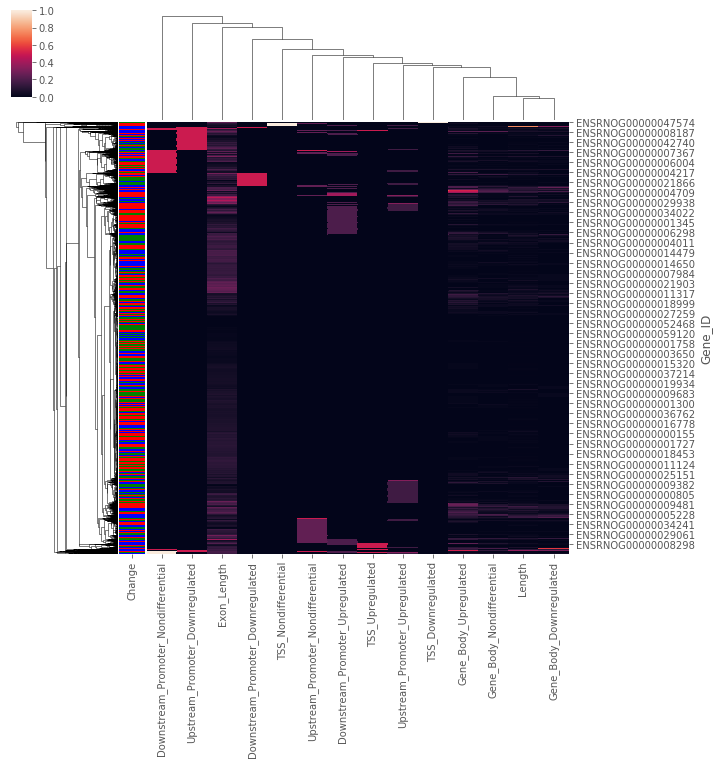

In [33]:
heatmap = sns.clustermap(SC_cAMP_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]],
                         standard_scale=1, row_colors =row_colors) #, yticklabels=True, 
#plt.colorbar(heatmap)

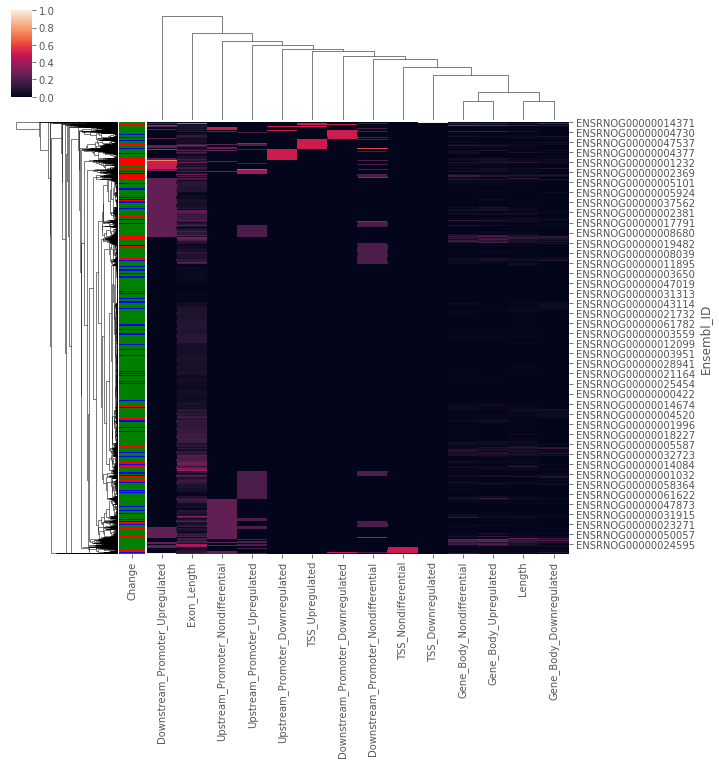

In [34]:

region_colors = {"Downregulated": 'b', "Nondifferential": 'g', "Upregulated":'r'}
row_colors=SC_VitC_cleaned_dataset[["Change"]].T.squeeze().map(region_colors)
heatmap = sns.clustermap(SC_VitC_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]],
                         standard_scale=1, row_colors =row_colors) #, yticklabels=True, 

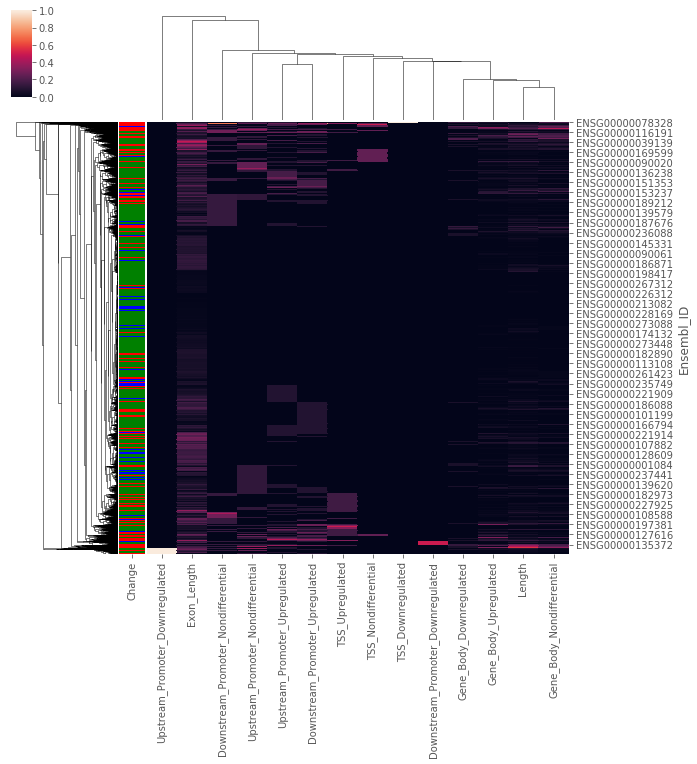

In [35]:
region_colors = {"Downregulated": 'b', "Nondifferential": 'g', "Upregulated":'r'}
row_colors=ARPE_cleaned_dataset[["Change"]].T.squeeze().map(region_colors)
heatmap = sns.clustermap(ARPE_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]],
                         standard_scale=1, row_colors =row_colors) #, yticklabels=True, 

Wow. These heatmaps are surprisingly useless. Something tells me that heirarchal clustering isn't going to give very useful results, because the clustering here I believe uses Euclidean distances and ward clustering.  

In [36]:
#ARPE_cleaned_dataset.head()
ARPE_Normalized = pd.DataFrame(scale(ARPE_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
ARPE_Normalized.columns = ["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]
Ensembl_ID = ARPE_cleaned_dataset.index.values
ARPE_Normalized["Ensembl_ID"] = Ensembl_ID
ARPE_Normalized = ARPE_Normalized.set_index("Ensembl_ID")
Change = ARPE_cleaned_dataset["Change"].values
ARPE_Normalized["Change"] = Change




In [37]:
ARPE_pca_model = PCA()
ARPE_PCA = ARPE_pca_model.fit_transform(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

ARPE_PCA_dataframe = pd.DataFrame(ARPE_PCA)
Ensembl_ID = ARPE_Normalized.index.values
ARPE_PCA_dataframe["Ensembl_ID"] = Ensembl_ID
ARPE_PCA_dataframe = ARPE_PCA_dataframe.set_index("Ensembl_ID")
change = ARPE_Normalized["Change"].values
ARPE_PCA_dataframe["Change"] = change
ARPE_PCA_dataframe.columns = ["PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6", "PC_7", "PC_8", 
                              "PC_9", "PC_10", "PC_11", "PC_12", "PC_13", "PC_14", "Region"]

In [38]:
ARPE_PCA_dataframe.head()

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
Ensembl_ID                                                                    
ENSG00000000003 -0.640045 -0.188427  1.841298  0.937859 -1.991830 -1.449293   
ENSG00000000419 -1.216522  0.405485 -0.292359 -0.034832 -0.047796  0.003209   
ENSG00000000457 -0.498389  0.428928 -0.093635 -0.019118  0.010013  0.036167   
ENSG00000000460 -0.197492  0.752827 -0.276014 -0.050884 -0.025533 -0.001420   
ENSG00000000971 -0.243824  0.222818  0.736689  0.071910 -0.185251 -0.181850   

                     PC_7      PC_8      PC_9     PC_10     PC_11     PC_12  \
Ensembl_ID                                                                    
ENSG00000000003  2.178476 -1.399587  0.249624  0.664050  0.088379 -0.116272   
ENSG00000000419  0.234372  0.149249 -0.001175 -0.210136  0.333212 -0.014403   
ENSG00000000457 -0.543828 -0.761906 -0.005122  0.856184 -0.115758  0.006017   
ENSG00000000460 -0.204509 -0.388151 -0.006659  0.397217  0.355010 -0.003425   
ENSG00000000971 -0.998903  0.188153 -1.340648 -0.032990  0.119017 -0.142756   

                    PC_13     PC_14           Region  
Ensembl_ID                                            
ENSG00000000003  0.082418  0.024484    Downregulated  
ENSG00000000419  0.038124  0.134485  Nondifferential  
ENSG00000000457  0.163658 -0.062453  Nondifferential  
ENSG00000000460  0.058289 -0.559625  Nondifferential  
ENSG00000000971 -0.332307  0.112196      Upregulated

In [39]:
ARPE_PCA_dataframe.describe()

PC_1          PC_2          PC_3          PC_4          PC_5  \
count  1.459900e+04  1.459900e+04  1.459900e+04  1.459900e+04  1.459900e+04   
mean   3.841407e-16 -6.039951e-16  2.663653e-16  3.291685e-17  6.373098e-17   
std    1.806492e+00  1.306421e+00  1.044245e+00  1.003600e+00  9.953809e-01   
min   -1.501928e+00 -1.558115e+01 -7.174035e+00 -5.327275e+00 -8.463066e+00   
25%   -1.092052e+00 -4.468594e-01 -4.186781e-01 -9.794473e-02 -6.872465e-02   
50%   -5.358894e-01  3.064409e-01 -2.286133e-01 -2.259998e-02 -3.830576e-02   
75%    3.959158e-01  4.107964e-01  1.836483e-01  1.496653e-02  2.850447e-02   
max    1.978749e+01  2.050038e+01  1.366976e+01  1.741669e+01  1.057897e+01   

               PC_6          PC_7          PC_8          PC_9         PC_10  \
count  1.459900e+04  1.459900e+04  1.459900e+04  1.459900e+04  1.459900e+04   
mean  -7.343433e-17 -1.149863e-16  3.495693e-16  1.160479e-17  3.576532e-17   
std    9.909289e-01  9.373290e-01  9.197283e-01  9.008471e-01  8.736783e-01   
min   -6.960947e+00 -6.141350e+00 -6.685728e+00 -5.591312e+00 -8.250529e+00   
25%   -6.081370e-03 -4.601217e-01 -4.346429e-01 -1.572787e-01 -4.057638e-01   
50%    1.349446e-02  7.615917e-02  2.418671e-02 -2.253344e-03 -1.457567e-01   
75%    9.483666e-02  3.299089e-01  3.201594e-01  1.597064e-02  3.300189e-01   
max    1.544701e+01  7.323928e+00  8.150264e+00  6.782169e+00  8.887776e+00   

              PC_11         PC_12         PC_13         PC_14  
count  1.459900e+04  1.459900e+04  1.459900e+04  1.459900e+04  
mean  -5.153694e-17  3.546778e-17 -1.558221e-17 -2.759017e-17  
std    7.635799e-01  7.307848e-01  5.879974e-01  4.452621e-01  
min   -1.294496e+01 -5.994752e+00 -9.232763e+00 -6.922468e+00  
25%   -2.492072e-01 -8.967822e-02 -1.318437e-01 -9.276605e-02  
50%    9.768557e-02 -8.219752e-03  4.067841e-02 -4.283682e-03  
75%    2.669725e-01  8.000764e-02  1.340817e-01  1.034892e-01  
max    1.341782e+01  6.338919e+00  9.875085e+00  7.161483e+00

In [40]:
cmap_bold = ListedColormap(['lime', 'blue', 'red' ]) #, 'magenta', 'aqua', 'green', 'yellow', 'orange'

In [41]:
ARPE_dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(ARPE_Normalized["Change"].values)))])
ARPE_map_colors = [ARPE_dictionary[x] for x in ARPE_Normalized["Change"].values]


In [42]:
ARPE_dictionary

{'Downregulated': 1, 'Nondifferential': 2, 'Upregulated': 3}

In [43]:
ARPE_PCA_dataframe.to_csv("ARPE.pca.csv")

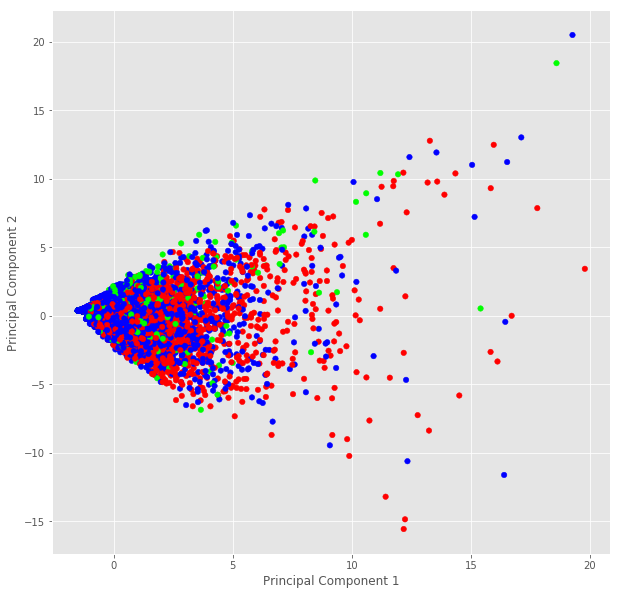

In [44]:
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=30, c=ARPE_map_colors, cmap = cmap_bold)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(output_path+"ARPE_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

[0.23308502 0.12190134 0.07788377 0.07193889 0.07076538 0.07013377
 0.06275182 0.06041731 0.05796214 0.05451868 0.04164388 0.03814356
 0.02469409 0.01416034]


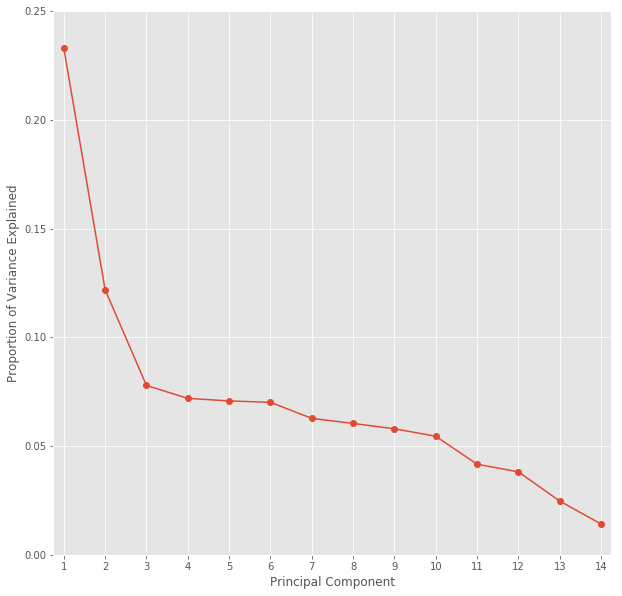

In [45]:
var_ratio = ARPE_pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,14.25)
plt.ylim(0,0.25)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.show()

Apparently, at least for the APRE dataset, the first two principal components only account for about 35% of the total variance, indicating that this is not such a good choice of mapping clusters. Oh well. This is what I can do for now. 

In [46]:
# SC_cAMP_cleaned_dataset.head()
SC_cAMP_Normalized = pd.DataFrame(scale(SC_cAMP_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
SC_cAMP_Normalized.columns = ["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]
Ensembl_ID = SC_cAMP_cleaned_dataset.index.values
SC_cAMP_Normalized["Ensembl_ID"] = Ensembl_ID
SC_cAMP_Normalized = SC_cAMP_Normalized.set_index("Ensembl_ID")
Change = SC_cAMP_cleaned_dataset["Change"].values
SC_cAMP_Normalized["Change"] = Change



/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


In [47]:
#SC_cAMP_cleaned_dataset
SC_cAMP_pca_model = PCA()
SC_cAMP_PCA = SC_cAMP_pca_model.fit_transform(SC_cAMP_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

SC_cAMP_PCA_dataframe = pd.DataFrame(SC_cAMP_PCA)
Ensembl_ID = SC_cAMP_Normalized.index.values
SC_cAMP_PCA_dataframe["Ensembl_ID"] = Ensembl_ID
SC_cAMP_PCA_dataframe = SC_cAMP_PCA_dataframe.set_index("Ensembl_ID")
change = SC_cAMP_Normalized["Change"].values
SC_cAMP_PCA_dataframe["Change"] = change
SC_cAMP_PCA_dataframe.columns = ["PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6", "PC_7", "PC_8", 
                              "PC_9", "PC_10", "PC_11", "PC_12", "PC_13", "PC_14", "Region"]

In [48]:
SC_cAMP_dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(SC_cAMP_Normalized["Change"].values)))])
SC_cAMP_map_colors = [SC_cAMP_dictionary[x] for x in SC_cAMP_Normalized["Change"].values]
SC_cAMP_dictionary

{'Downregulated': 1, 'Nondifferential': 2, 'Upregulated': 3}

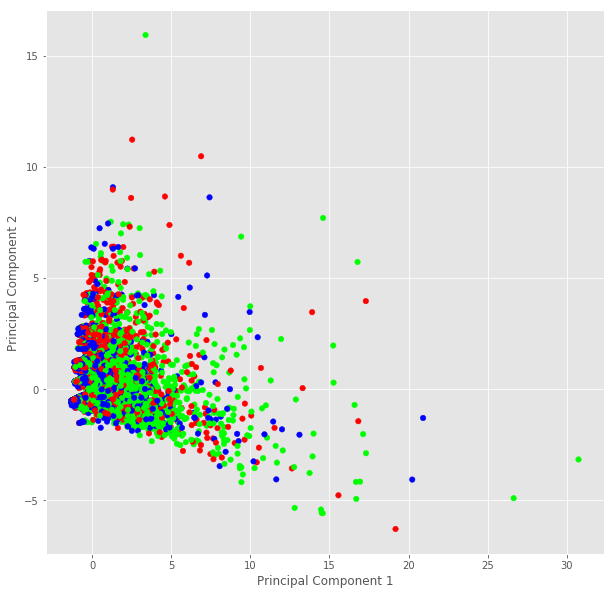

In [49]:
plt.scatter(SC_cAMP_PCA_dataframe["PC_1"], SC_cAMP_PCA_dataframe["PC_2"],s=30, c=SC_cAMP_map_colors, cmap = cmap_bold)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(output_path+"SC_cAMP_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

[0.22916531 0.08893903 0.07569215 0.07285113 0.0725561  0.07068519
 0.06997248 0.06726886 0.06628743 0.05999614 0.05813335 0.03738319
 0.01929941 0.01177024]


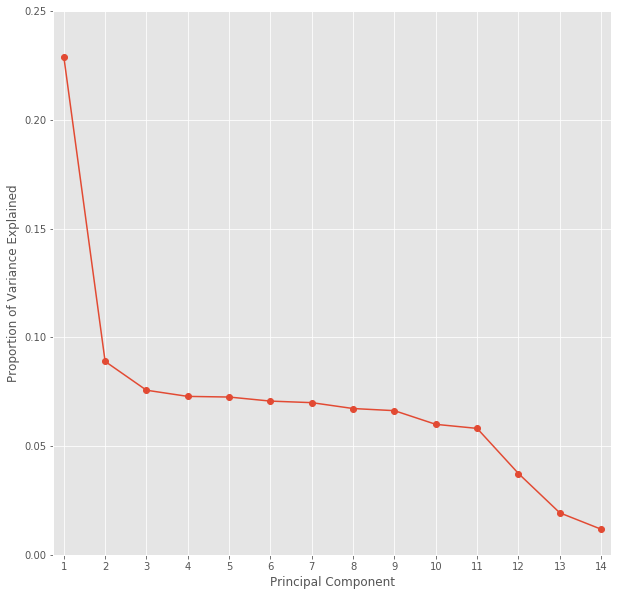

In [50]:
var_ratio = SC_cAMP_pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,14.25)
plt.ylim(0,0.25)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.show()

In [51]:
# SC_VitC_cleaned_dataset.head()
SC_VitC_Normalized = pd.DataFrame(scale(SC_VitC_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
SC_VitC_Normalized.columns = ["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]
Ensembl_ID = SC_VitC_cleaned_dataset.index.values
SC_VitC_Normalized["Ensembl_ID"] = Ensembl_ID
SC_VitC_Normalized = SC_VitC_Normalized.set_index("Ensembl_ID")
Change = SC_VitC_cleaned_dataset["Change"].values
SC_VitC_Normalized["Change"] = Change



/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


In [52]:
#SC_VitC_cleaned_dataset
SC_VitC_pca_model = PCA()
SC_VitC_PCA = SC_VitC_pca_model.fit_transform(SC_VitC_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

SC_VitC_PCA_dataframe = pd.DataFrame(SC_VitC_PCA)
Ensembl_ID = SC_VitC_Normalized.index.values
SC_VitC_PCA_dataframe["Ensembl_ID"] = Ensembl_ID
SC_VitC_PCA_dataframe = SC_VitC_PCA_dataframe.set_index("Ensembl_ID")
change = SC_VitC_Normalized["Change"].values
SC_VitC_PCA_dataframe["Change"] = change
SC_VitC_PCA_dataframe.columns = ["PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6", "PC_7", "PC_8", 
                              "PC_9", "PC_10", "PC_11", "PC_12", "PC_13", "PC_14", "Region"]

In [53]:
SC_VitC_dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(SC_VitC_Normalized["Change"].values)))])
SC_VitC_map_colors = [SC_VitC_dictionary[x] for x in SC_VitC_Normalized["Change"].values]
SC_VitC_dictionary

{'Downregulated': 1, 'Nondifferential': 2, 'Upregulated': 3}

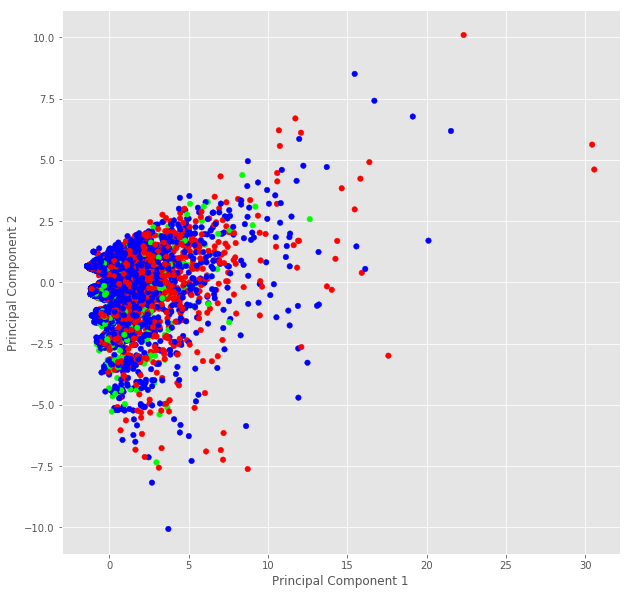

In [54]:
plt.scatter(SC_VitC_PCA_dataframe["PC_1"], SC_VitC_PCA_dataframe["PC_2"],s=30, c=SC_VitC_map_colors, cmap = cmap_bold)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(output_path+"SC_VitC_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

[0.23729438 0.0921251  0.07523809 0.07340828 0.07149577 0.07080737
 0.06909645 0.06829333 0.06495064 0.05891984 0.05296086 0.03958761
 0.01668656 0.00913572]


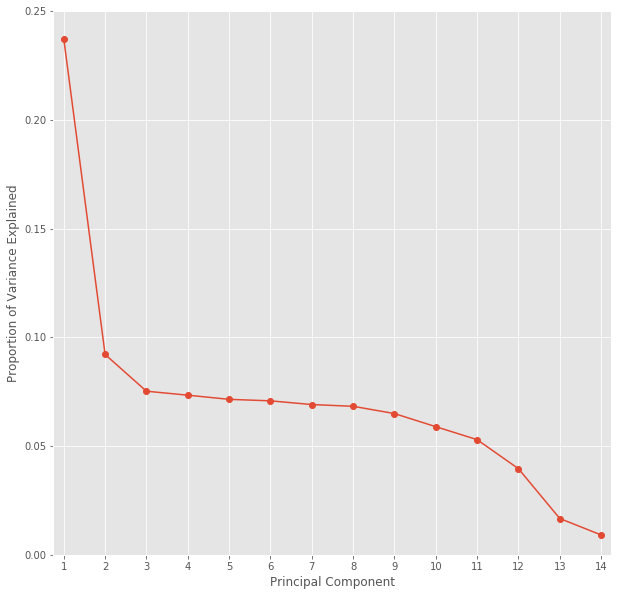

In [55]:
var_ratio = SC_VitC_pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,14.25)
plt.ylim(0,0.25)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.show()

According to these, the first two principle components account for about 35% of the variability. This is not great. It looks like it would be best to include about 10-12 principle components. I can't graph that, but I think I am going to graph clustering on the first two PCAs just because that way I can see it on a graph. 

In [56]:
ARPE_Normalized.head()

Length  Exon_Length  Gene_Body_Downregulated  \
Ensembl_ID                                                        
ENSG00000000003 -0.459008     0.111174                -0.243516   
ENSG00000000419 -0.339981    -0.807101                -0.243516   
ENSG00000000457 -0.160628     1.006100                -0.243516   
ENSG00000000460 -0.035890     0.305980                -0.243516   
ENSG00000000971  0.285342     0.226524                -0.243516   

                 Upstream_Promoter_Downregulated  \
Ensembl_ID                                         
ENSG00000000003                         -0.11298   
ENSG00000000419                         -0.11298   
ENSG00000000457                         -0.11298   
ENSG00000000460                         -0.11298   
ENSG00000000971                         -0.11298   

                 Downstream_Promoter_Downregulated  TSS_Downregulated  \
Ensembl_ID                                                              
ENSG00000000003                          -0.103286          -0.051755   
ENSG00000000419                          -0.103286          -0.051755   
ENSG00000000457                          -0.103286          -0.051755   
ENSG00000000460                          -0.103286          -0.051755   
ENSG00000000971                          -0.103286          -0.051755   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                  -0.434994                          -0.423382   
ENSG00000000419                  -0.434994                          -0.423382   
ENSG00000000457                  -0.170512                          -0.423382   
ENSG00000000460                   0.622934                          -0.423382   
ENSG00000000971                  -0.170512                          -0.423382   

                 Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                                  
ENSG00000000003                            -0.414895             4.062426   
ENSG00000000419                            -0.414895            -0.211054   
ENSG00000000457                            -0.414895            -0.211054   
ENSG00000000460                            -0.414895            -0.211054   
ENSG00000000971                             1.604796            -0.211054   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003              -0.392168                      -0.452456   
ENSG00000000419              -0.185793                      -0.452456   
ENSG00000000457              -0.185793                      -0.452456   
ENSG00000000460               0.020582                      -0.452456   
ENSG00000000971              -0.392168                      -0.452456   

                 Downstream_Promoter_Upregulated  TSS_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003                        -0.469535         -0.29699   
ENSG00000000419                        -0.469535         -0.29699   
ENSG00000000457                        -0.469535         -0.29699   
ENSG00000000460                        -0.469535         -0.29699   
ENSG00000000971                        -0.469535         -0.29699   

                          Change  
Ensembl_ID                        
ENSG00000000003    Downregulated  
ENSG00000000419  Nondifferential  
ENSG00000000457  Nondifferential  
ENSG00000000460  Nondifferential  
ENSG00000000971      Upregulated

In [57]:
# ARPE_Normalized
# ks = range(1,100)
# ARPE_Kmeans_scores = []

# for k in ks:
#     model = KMeans(n_clusters=k)
#     model.fit_predict(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
#                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
#                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
#                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
#                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
#                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])
#     ARPE_Kmeans_scores.append(-model.score(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
#                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
#                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
#                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
#                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
#                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))

# plt.plot(ks, ARPE_Kmeans_scores)
# plt.ylabel('total intra-cluster distance')
# plt.xlabel('k')
# plt.show()

This took a long time to generate, so I am going to save it as a csv file and then I can read it in again as a list when I rerun the entire notebook. Anyways, this appears to have an elbow point around 9 to 18.

In [58]:
# with open(output_path+'ARPE_Kmeans_scores.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(ARPE_Kmeans_scores)

In [59]:
with open(output_path+'ARPE_Kmeans_scores.csv', 'r') as myfile:
    reader = csv.reader(myfile)
    ARPE_Kmeans_scores = list(reader)
ARPE_Kmeans_scores = [float(i) for i in ARPE_Kmeans_scores[0]]

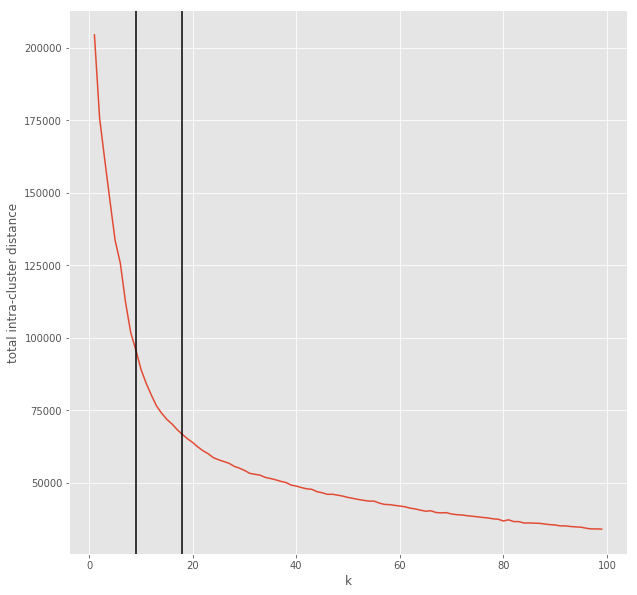

In [60]:
ks = range(1,100)
plt.plot(ks, ARPE_Kmeans_scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.axvline(x=9, color='k')
plt.axvline(x=18, color='k')
plt.show()

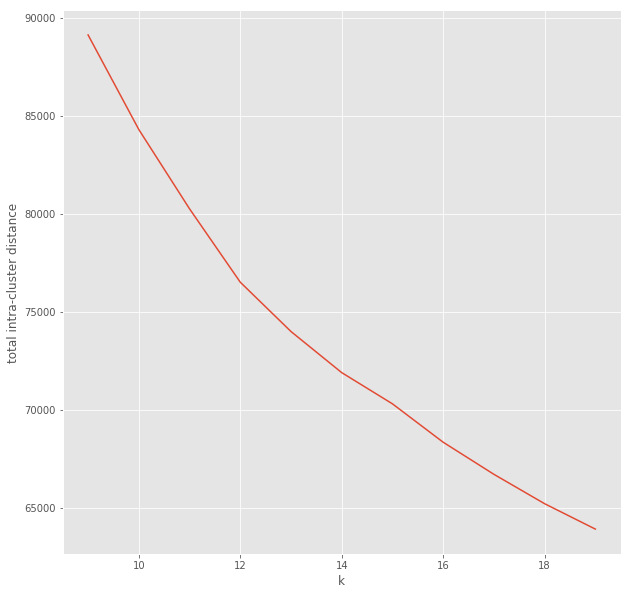

In [61]:
#tmp = [float(i) for i in ARPE_Kmeans_scores[0][9:20]]
tmp = ARPE_Kmeans_scores[9:20]
plt.plot(range(9,20), tmp)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

For n_clusters = 9 The silhouette_score is : 0.3367833444761818


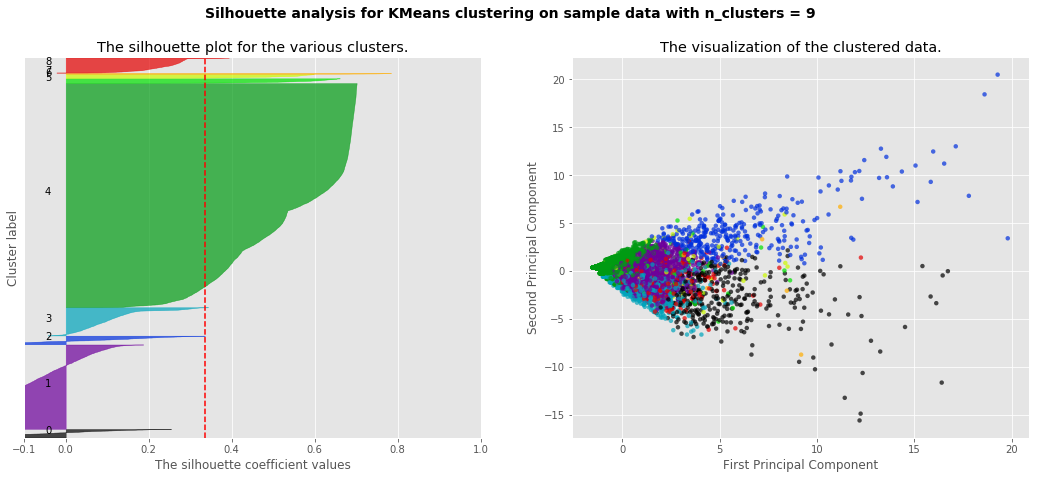

For n_clusters = 10 The silhouette_score is : 0.3373327708320088


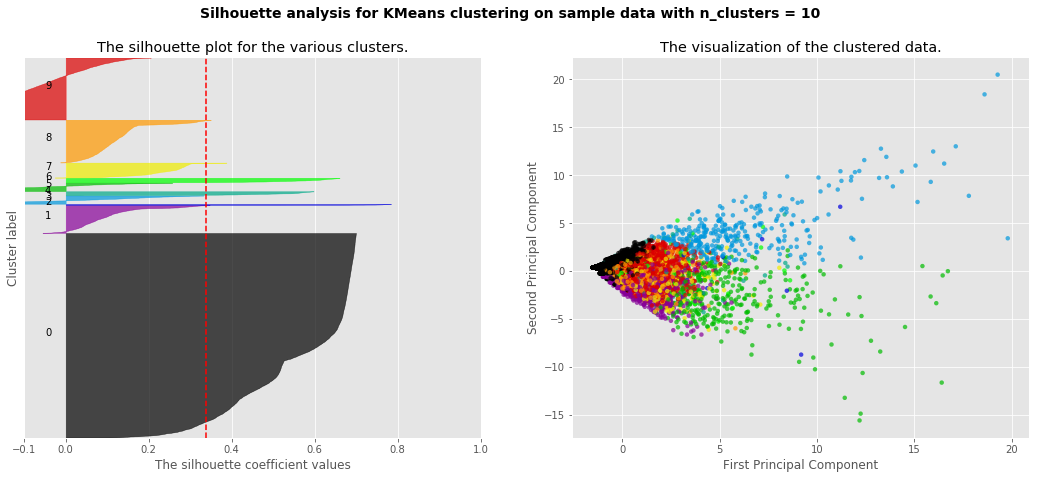

For n_clusters = 11 The silhouette_score is : 0.34848550970144787


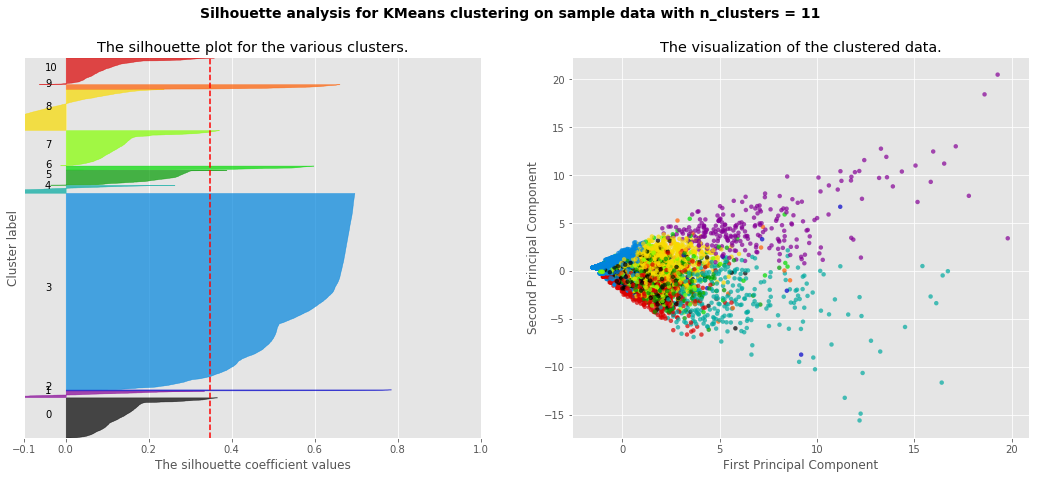

For n_clusters = 12 The silhouette_score is : 0.3265111851847965


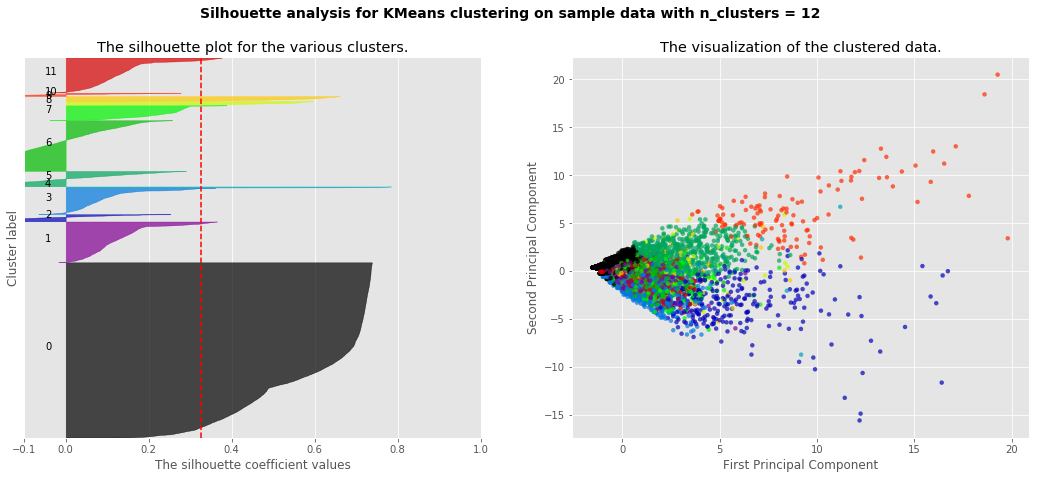

For n_clusters = 13 The silhouette_score is : 0.3347890587872974


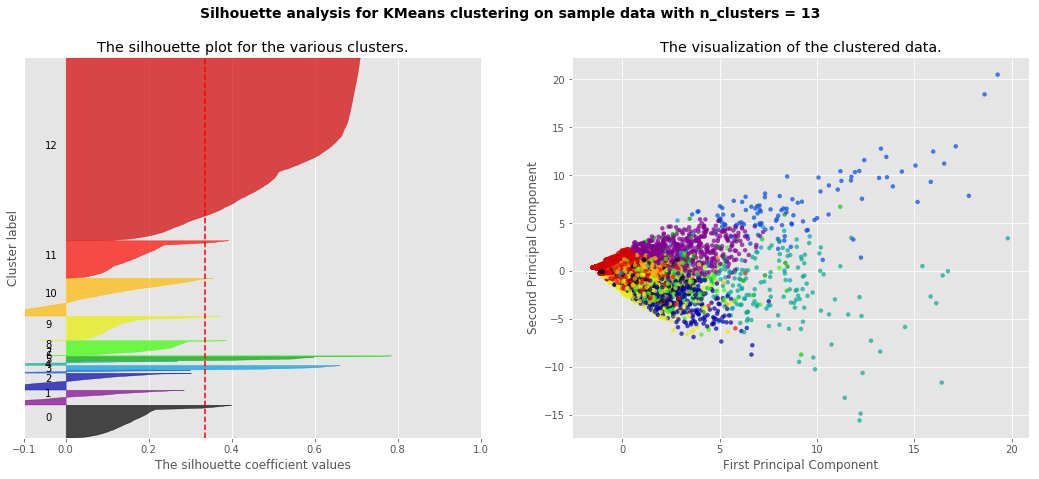

For n_clusters = 14 The silhouette_score is : 0.3407414912887633


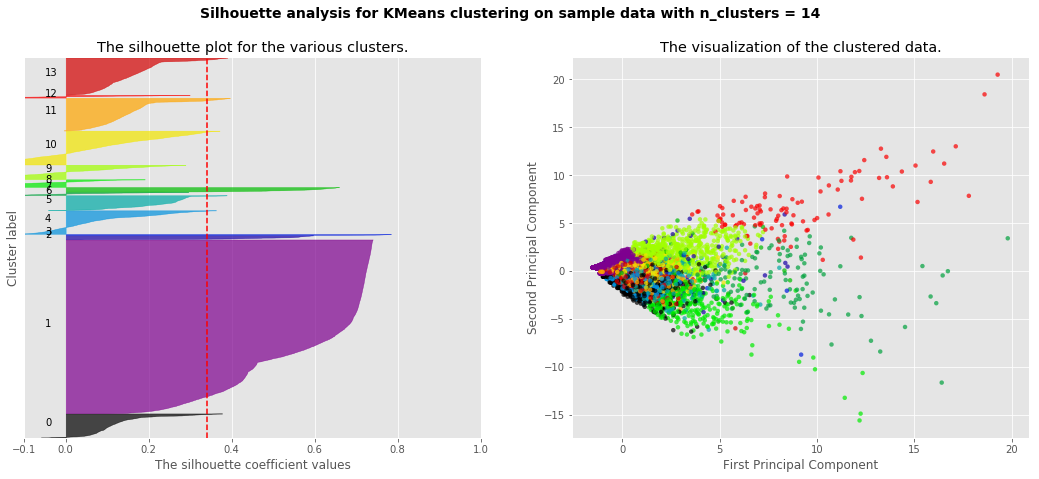

For n_clusters = 15 The silhouette_score is : 0.3178406883577228


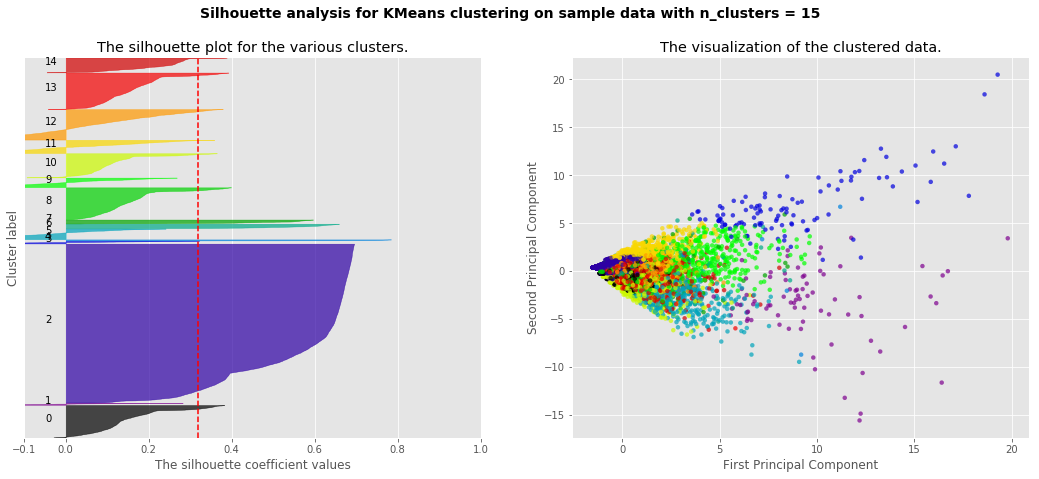

For n_clusters = 16 The silhouette_score is : 0.32087911123301704


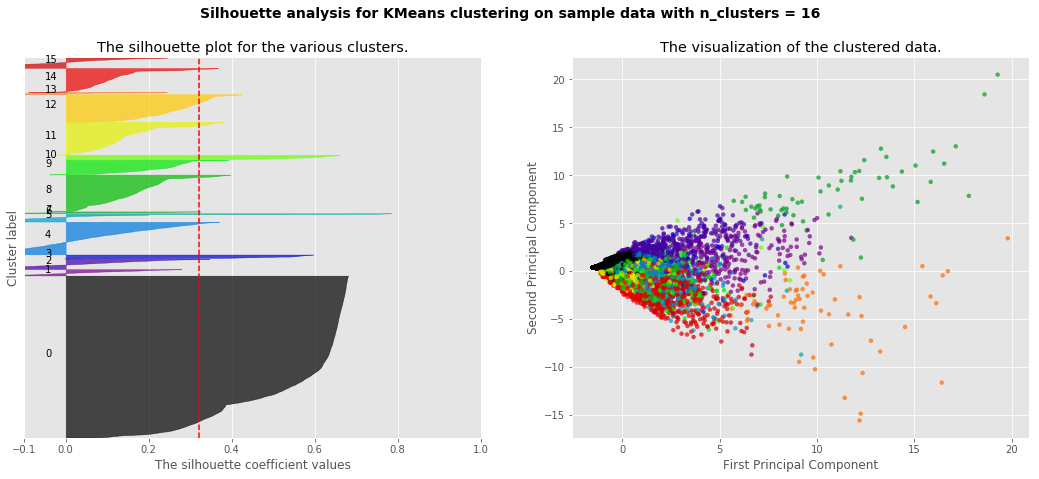

For n_clusters = 17 The silhouette_score is : 0.3238626162272631


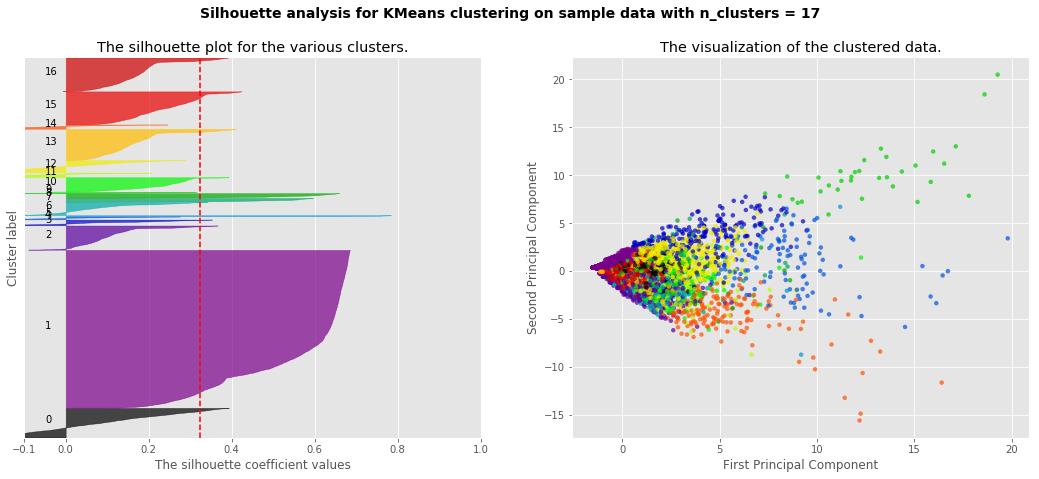

For n_clusters = 18 The silhouette_score is : 0.2753763759084766


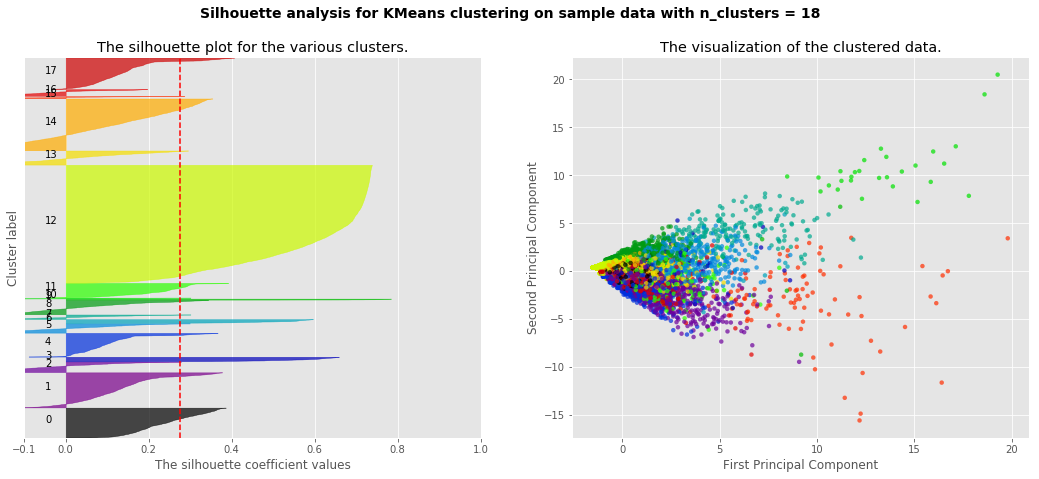

For n_clusters = 19 The silhouette_score is : 0.2782951283239767


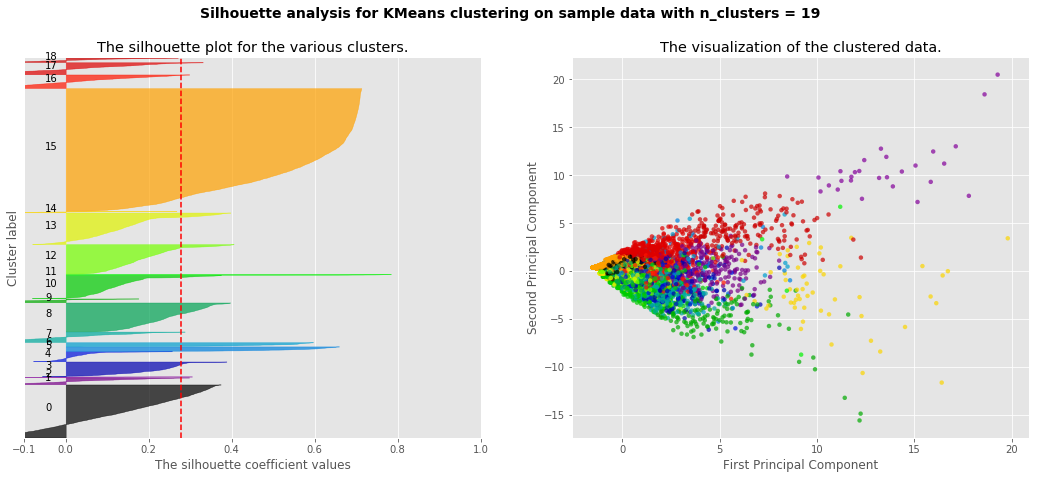

For n_clusters = 20 The silhouette_score is : 0.3349731265414626


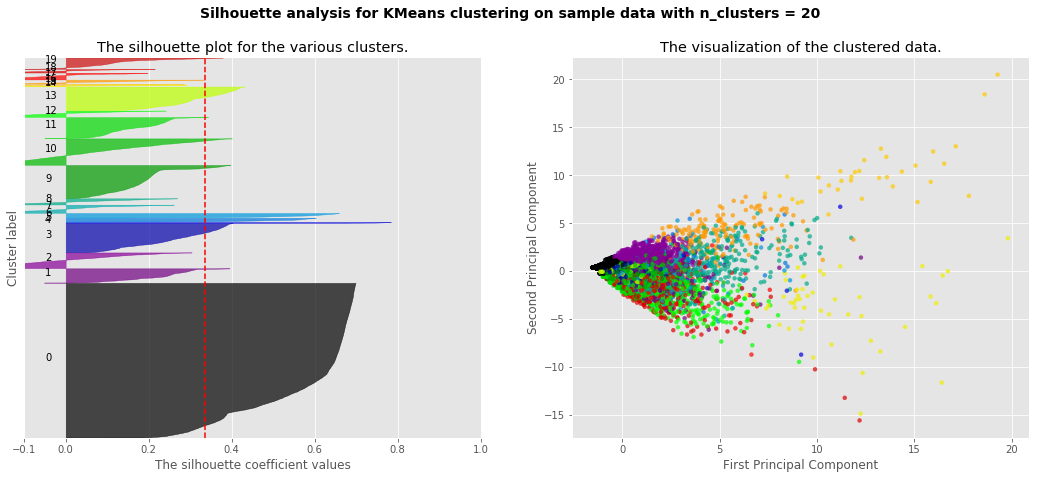

In [62]:
# 2. Vary k and find the best value. Describe wow do you determine best?
range_n_clusters = [9,10,11,12,13,14,15,16,17,18,19,20]

average_silhouette_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(ARPE_Normalized) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]], cluster_labels)
    average_silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated"]], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette coefficient of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    
    #plt.scatter(violence_PCA_dataframe["PC_1"], violence_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)

    ax2.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=400, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')
    # This doesn't work because I am plotting the PCA's, not the dimensions that were used to calculate silhouette scores
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("First Principal Component")
    ax2.set_ylabel("Second Principal Component")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    plt.savefig(output_path+"ARPE_Kmeans_Silhouette_charts/ARPE_Silhouette_Scores_K_Means_"+str(n_clusters)+"_clusters.png", dpi=300) # size above specified at 10x6
    plt.show()

In [63]:
ARPE_silhouette_scores = pd.DataFrame({'K': range_n_clusters, 'Silhouette_Score': average_silhouette_scores})
ARPE_silhouette_scores.to_csv(output_path+"ARPE_Kmeans_Silhouette_charts/ARPE_Silhouette_Scores.csv")

It looks to me like it is best at 11, 14, 17, and 20. I find it odd that this line didn't go straight in a row. I am going to only do this for the ARPE dataset because it was time consuming, but I will proceed with 14 clusters because it looks like an appropriate point for and elbow and it has a regional silhouette maximum.

In [64]:
ARPE_y_pred = list(KMeans(n_clusters=14, max_iter=10).fit_predict(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                       "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                       "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                       "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                       "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                       "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
ARPE_Normalized["Group_K_Means"] = ARPE_y_pred

In [65]:
#expressed_genes_info.groupby(["Biotype"], as_index = False).size()
ARPE_Normalized.groupby(["Group_K_Means"]).size()

Group_K_Means
0     1247
1      200
2     6376
3      416
4      152
5     1418
6     1253
7       39
8      177
9      953
10     572
11      37
12    1231
13     528
dtype: int64

In [66]:
ARPE_Normalized.head()

Length  Exon_Length  Gene_Body_Downregulated  \
Ensembl_ID                                                        
ENSG00000000003 -0.459008     0.111174                -0.243516   
ENSG00000000419 -0.339981    -0.807101                -0.243516   
ENSG00000000457 -0.160628     1.006100                -0.243516   
ENSG00000000460 -0.035890     0.305980                -0.243516   
ENSG00000000971  0.285342     0.226524                -0.243516   

                 Upstream_Promoter_Downregulated  \
Ensembl_ID                                         
ENSG00000000003                         -0.11298   
ENSG00000000419                         -0.11298   
ENSG00000000457                         -0.11298   
ENSG00000000460                         -0.11298   
ENSG00000000971                         -0.11298   

                 Downstream_Promoter_Downregulated  TSS_Downregulated  \
Ensembl_ID                                                              
ENSG00000000003                          -0.103286          -0.051755   
ENSG00000000419                          -0.103286          -0.051755   
ENSG00000000457                          -0.103286          -0.051755   
ENSG00000000460                          -0.103286          -0.051755   
ENSG00000000971                          -0.103286          -0.051755   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                  -0.434994                          -0.423382   
ENSG00000000419                  -0.434994                          -0.423382   
ENSG00000000457                  -0.170512                          -0.423382   
ENSG00000000460                   0.622934                          -0.423382   
ENSG00000000971                  -0.170512                          -0.423382   

                 Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                                  
ENSG00000000003                            -0.414895             4.062426   
ENSG00000000419                            -0.414895            -0.211054   
ENSG00000000457                            -0.414895            -0.211054   
ENSG00000000460                            -0.414895            -0.211054   
ENSG00000000971                             1.604796            -0.211054   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003              -0.392168                      -0.452456   
ENSG00000000419              -0.185793                      -0.452456   
ENSG00000000457              -0.185793                      -0.452456   
ENSG00000000460               0.020582                      -0.452456   
ENSG00000000971              -0.392168                      -0.452456   

                 Downstream_Promoter_Upregulated  TSS_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003                        -0.469535         -0.29699   
ENSG00000000419                        -0.469535         -0.29699   
ENSG00000000457                        -0.469535         -0.29699   
ENSG00000000460                        -0.469535         -0.29699   
ENSG00000000971                        -0.469535         -0.29699   

                          Change  Group_K_Means  
Ensembl_ID                                       
ENSG00000000003    Downregulated             10  
ENSG00000000419  Nondifferential              2  
ENSG00000000457  Nondifferential             12  
ENSG00000000460  Nondifferential              2  
ENSG00000000971      Upregulated              5

In [67]:
cmap_bold = ListedColormap(['lime', 'blue', 'black', 'red', 'magenta', 'aqua', 'green', 
                            'orange', 'purple', 'white', 'deeppink', 'yellow',  'lightblue', 'darkgoldenrod']) 

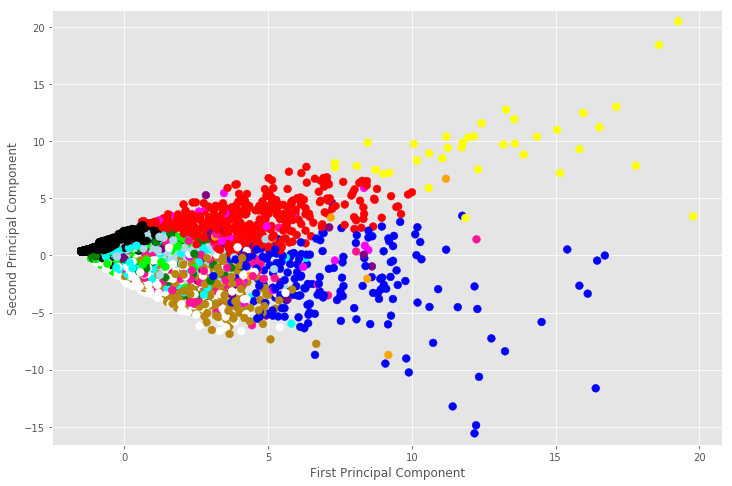

In [68]:
plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(ARPE_PCA_dataframe.index.values):
#    ax1.annotate(name, (ARPE_PCA_dataframe.iloc[i,0], ARPE_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=ARPE_y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.savefig(output_path+"ARPE_Kmeans_clusters_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

Well, it certainly comes up with clusters. I would never have guessed them based on the PCA, but I think this is interesting that they actually have clusters. I wonder if the huge cluster is ones that have almost not 5hmC peaks.

In [69]:
ARPE_DBSCAN_input = ARPE_Normalized[['Length', 'Exon_Length', 'Gene_Body_Downregulated',
                                     'Upstream_Promoter_Downregulated',
                                     'Downstream_Promoter_Downregulated', 'TSS_Downregulated',
                                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                                     'Downstream_Promoter_Nondifferential', 'TSS_Nondifferential',
                                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
                                     'Downstream_Promoter_Upregulated', 'TSS_Upregulated']]

In [70]:
ARPE_DBSCAN_input.head()

Length  Exon_Length  Gene_Body_Downregulated  \
Ensembl_ID                                                        
ENSG00000000003 -0.459008     0.111174                -0.243516   
ENSG00000000419 -0.339981    -0.807101                -0.243516   
ENSG00000000457 -0.160628     1.006100                -0.243516   
ENSG00000000460 -0.035890     0.305980                -0.243516   
ENSG00000000971  0.285342     0.226524                -0.243516   

                 Upstream_Promoter_Downregulated  \
Ensembl_ID                                         
ENSG00000000003                         -0.11298   
ENSG00000000419                         -0.11298   
ENSG00000000457                         -0.11298   
ENSG00000000460                         -0.11298   
ENSG00000000971                         -0.11298   

                 Downstream_Promoter_Downregulated  TSS_Downregulated  \
Ensembl_ID                                                              
ENSG00000000003                          -0.103286          -0.051755   
ENSG00000000419                          -0.103286          -0.051755   
ENSG00000000457                          -0.103286          -0.051755   
ENSG00000000460                          -0.103286          -0.051755   
ENSG00000000971                          -0.103286          -0.051755   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                  -0.434994                          -0.423382   
ENSG00000000419                  -0.434994                          -0.423382   
ENSG00000000457                  -0.170512                          -0.423382   
ENSG00000000460                   0.622934                          -0.423382   
ENSG00000000971                  -0.170512                          -0.423382   

                 Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                                  
ENSG00000000003                            -0.414895             4.062426   
ENSG00000000419                            -0.414895            -0.211054   
ENSG00000000457                            -0.414895            -0.211054   
ENSG00000000460                            -0.414895            -0.211054   
ENSG00000000971                             1.604796            -0.211054   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003              -0.392168                      -0.452456   
ENSG00000000419              -0.185793                      -0.452456   
ENSG00000000457              -0.185793                      -0.452456   
ENSG00000000460               0.020582                      -0.452456   
ENSG00000000971              -0.392168                      -0.452456   

                 Downstream_Promoter_Upregulated  TSS_Upregulated  
Ensembl_ID                                                         
ENSG00000000003                        -0.469535         -0.29699  
ENSG00000000419                        -0.469535         -0.29699  
ENSG00000000457                        -0.469535         -0.29699  
ENSG00000000460                        -0.469535         -0.29699  
ENSG00000000971                        -0.469535         -0.29699

Estimated number of clusters: 110
Estimated number of noise points: 2861
Homogeneity: 0.251
Completeness: 1.000
V-measure: 0.401
Adjusted Rand Index: 0.000
Silhouette Coefficient: 0.220


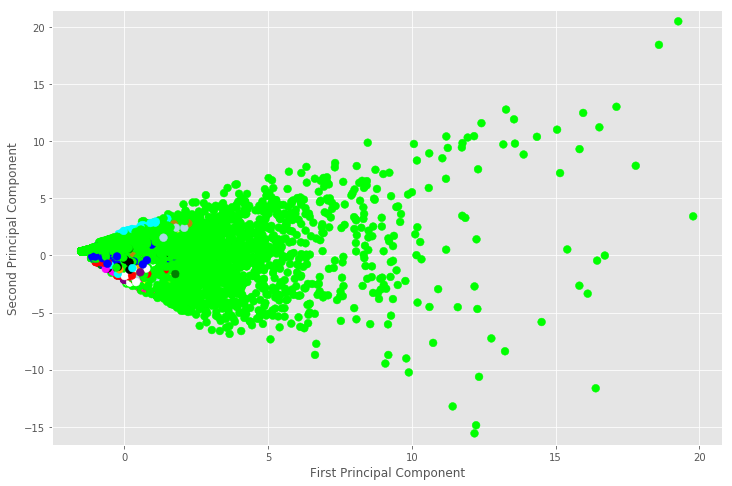

In [71]:
db_model = DBSCAN(eps=0.75, min_samples=4)
db_model.fit(ARPE_DBSCAN_input)
y_pred = db_model.fit_predict(ARPE_DBSCAN_input)



plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')



labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
print("Completeness: %0.3f" % metrics.completeness_score(ARPE_DBSCAN_input.index, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(ARPE_DBSCAN_input.index, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(ARPE_DBSCAN_input, labels))

Estimated number of clusters: 60
Estimated number of noise points: 1325
Homogeneity: 0.190
Completeness: 1.000
V-measure: 0.320
Adjusted Rand Index: 0.000
Silhouette Coefficient: 0.265


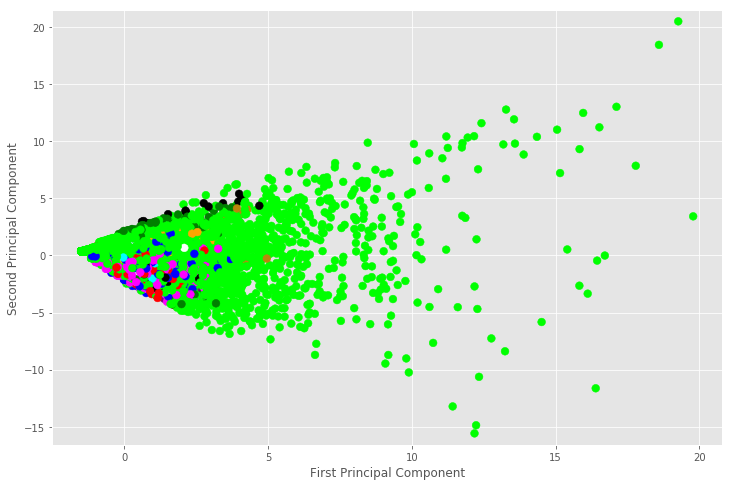

In [72]:
db_model = DBSCAN(eps=1.75, min_samples=4)
db_model.fit(ARPE_DBSCAN_input)
y_pred = db_model.fit_predict(ARPE_DBSCAN_input)



plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')



labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
print("Completeness: %0.3f" % metrics.completeness_score(ARPE_DBSCAN_input.index, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(ARPE_DBSCAN_input.index, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(ARPE_DBSCAN_input, labels))

In [73]:
# Clusters = [] 
# Noise_points = [] 
# Homogenity = []
# V_Measure = []
# Silhouette = []


# eps_values = np.arange(0.5,10,0.1)
# for i in eps_values:
#     db_model = DBSCAN(eps=i, min_samples=2)
#     db_model.fit(ARPE_DBSCAN_input)
#     labels = db_model.labels_
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)
#     Clusters.append(n_clusters_)
#     Noise_points.append(n_noise_)
#     Homogenity.append(metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
#     V_Measure.append(metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
#     Silhouette.append(metrics.silhouette_score(ARPE_DBSCAN_input, labels))



In [76]:
#eps_values = np.arange(0.5,10,0.1)
# ARPE_DBSCAN_measures = pd.DataFrame({"eps_values": eps_values, "Clusters": Clusters, "Noise_points": Noise_points, "Homogenity": Homogenity,
#               "V_Measure":V_Measure, "Silhouette": Silhouette}) 
# ARPE_DBSCAN_measures.to_csv(output_path+"ARPE_DBSCAN_quality_measure_values.csv")

In [77]:
ARPE_DBSCAN_measures = pd.read_csv(output_path+"ARPE_DBSCAN_quality_measure_values.csv")
eps_values = ARPE_DBSCAN_measures[["eps_values"]].values
Silhouette = ARPE_DBSCAN_measures[["Silhouette"]].values
V_Measure = ARPE_DBSCAN_measures[["V_Measure"]].values
Homogenity = ARPE_DBSCAN_measures[["Homogenity"]].values
Noise_points = ARPE_DBSCAN_measures[["Noise_points"]].values
Clusters = ARPE_DBSCAN_measures[["Clusters"]].values


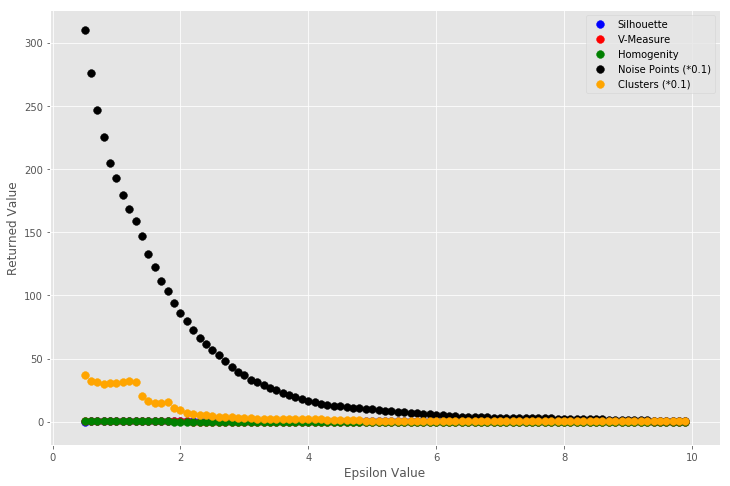

In [78]:
map_noise = [i*0.10 for i in Noise_points]
map_clusters = [i*0.10 for i in Clusters]

plt.scatter(eps_values, Silhouette,s=60, c = 'blue', label = "Silhouette")
plt.scatter(eps_values, V_Measure,s=60, c = 'red', label = "V-Measure")
plt.scatter(eps_values, Homogenity,s=60, c = 'green', label = "Homogenity")
plt.scatter(eps_values, map_noise,s=60, c = 'black', label = "Noise Points (*0.1)")
plt.scatter(eps_values, map_clusters,s=60, c = 'orange', label = "Clusters (*0.1)")

plt.xlabel('Epsilon Value')
plt.ylabel('Returned Value')
plt.legend()


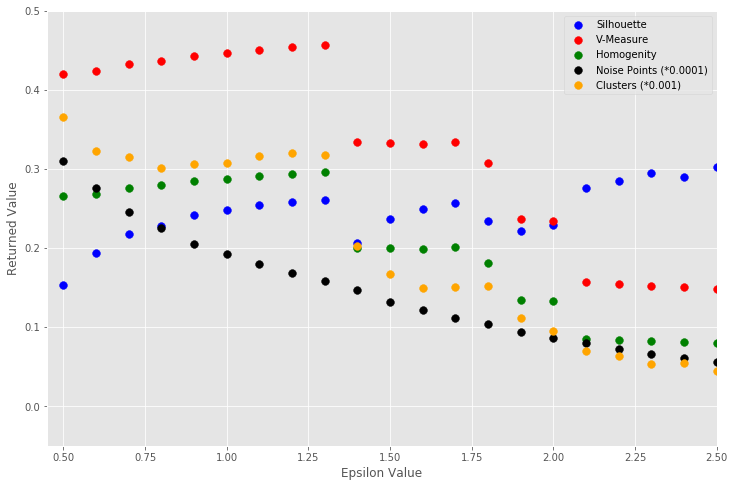

In [79]:
map_noise = [i*0.0001 for i in Noise_points]
map_clusters = [i*0.001 for i in Clusters]

plt.scatter(eps_values, Silhouette,s=60, c = 'blue', label = "Silhouette")
plt.scatter(eps_values, V_Measure,s=60, c = 'red', label = "V-Measure")
plt.scatter(eps_values, Homogenity,s=60, c = 'green', label = "Homogenity")
plt.scatter(eps_values, map_noise,s=60, c = 'black', label = "Noise Points (*0.0001)")
plt.scatter(eps_values, map_clusters,s=60, c = 'orange', label = "Clusters (*0.001)")

plt.xlabel('Epsilon Value')
plt.ylabel('Returned Value')
plt.ylim(-0.05, 0.5)
plt.xlim(0.45, 2.5)
plt.legend()

In [81]:
# Clusters = [] 
# Noise_points = [] 
# Homogenity = []
# V_Measure = []
# Silhouette = []


# eps_values = np.arange(1.0,1.5,0.01)
# for i in eps_values:
#     db_model = DBSCAN(eps=i, min_samples=2)
#     db_model.fit(ARPE_DBSCAN_input)
#     labels = db_model.labels_
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)
#     Clusters.append(n_clusters_)
#     Noise_points.append(n_noise_)
#     Homogenity.append(metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
#     V_Measure.append(metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
#     Silhouette.append(metrics.silhouette_score(ARPE_DBSCAN_input, labels))


In [80]:
#ARPE_DBSCAN_measures_concentrated = pd.DataFrame({"eps_values": eps_values, "Clusters": Clusters, "Noise_points": Noise_points, "Homogenity": Homogenity,
#              "V_Measure":V_Measure, "Silhouette": Silhouette}) 
#ARPE_DBSCAN_measures_concentrated.to_csv(output_path+"ARPE_DBSCAN_quality_measure_values_concentrated.csv")

In [82]:
ARPE_DBSCAN_measures_concentrated = pd.read_csv(output_path+"ARPE_DBSCAN_quality_measure_values_concentrated.csv")
eps_values = ARPE_DBSCAN_measures_concentrated[["eps_values"]].values
Silhouette = ARPE_DBSCAN_measures_concentrated[["Silhouette"]].values
V_Measure = ARPE_DBSCAN_measures_concentrated[["V_Measure"]].values
Homogenity = ARPE_DBSCAN_measures_concentrated[["Homogenity"]].values
Noise_points = ARPE_DBSCAN_measures_concentrated[["Noise_points"]].values
Clusters = ARPE_DBSCAN_measures_concentrated[["Clusters"]].values


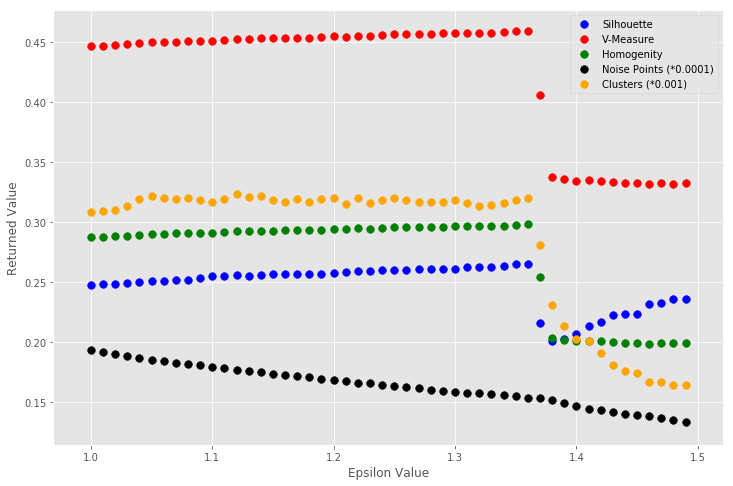

In [83]:
map_noise = [i*0.0001 for i in Noise_points]
map_clusters = [i*0.001 for i in Clusters]

plt.scatter(eps_values, Silhouette,s=60, c = 'blue', label = "Silhouette")
plt.scatter(eps_values, V_Measure,s=60, c = 'red', label = "V-Measure")
plt.scatter(eps_values, Homogenity,s=60, c = 'green', label = "Homogenity")
plt.scatter(eps_values, map_noise,s=60, c = 'black', label = "Noise Points (*0.0001)")
plt.scatter(eps_values, map_clusters,s=60, c = 'orange', label = "Clusters (*0.001)")

plt.xlabel('Epsilon Value')
plt.ylabel('Returned Value')
#plt.ylim(-0.05, 0.5)
#plt.xlim(0.45, 2.5)
plt.savefig(output_path+"ARPE_DBSCAN_finding_epsilon.png", dpi=300) # size above specified at 10x6
plt.legend()

Estimated number of clusters: 320
Estimated number of noise points: 1537
Homogeneity: 0.298
Completeness: 1.000
V-measure: 0.459
Adjusted Rand Index: 0.000
Silhouette Coefficient: 0.265


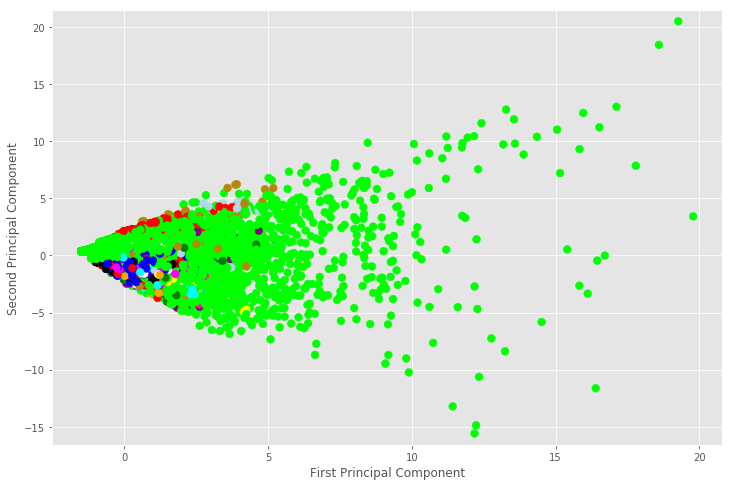

In [84]:
db_model = DBSCAN(eps=1.36, min_samples=2)
db_model.fit(ARPE_DBSCAN_input)
y_pred = db_model.fit_predict(ARPE_DBSCAN_input)



plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.savefig(output_path+"ARPE_DBSCAN_PCA_plot.png", dpi=300) 


labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
print("Completeness: %0.3f" % metrics.completeness_score(ARPE_DBSCAN_input.index, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(ARPE_DBSCAN_input.index, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(ARPE_DBSCAN_input, labels))

In [85]:

ARPE_Normalized["DBSCAN_Cluster"] = y_pred
ARPE_Normalized.to_csv(output_path+"ARPE_Cluster_Info_Kmeans_DBSCAN.csv")
ARPE_Normalized.head()

Length  Exon_Length  Gene_Body_Downregulated  \
Ensembl_ID                                                        
ENSG00000000003 -0.459008     0.111174                -0.243516   
ENSG00000000419 -0.339981    -0.807101                -0.243516   
ENSG00000000457 -0.160628     1.006100                -0.243516   
ENSG00000000460 -0.035890     0.305980                -0.243516   
ENSG00000000971  0.285342     0.226524                -0.243516   

                 Upstream_Promoter_Downregulated  \
Ensembl_ID                                         
ENSG00000000003                         -0.11298   
ENSG00000000419                         -0.11298   
ENSG00000000457                         -0.11298   
ENSG00000000460                         -0.11298   
ENSG00000000971                         -0.11298   

                 Downstream_Promoter_Downregulated  TSS_Downregulated  \
Ensembl_ID                                                              
ENSG00000000003                          -0.103286          -0.051755   
ENSG00000000419                          -0.103286          -0.051755   
ENSG00000000457                          -0.103286          -0.051755   
ENSG00000000460                          -0.103286          -0.051755   
ENSG00000000971                          -0.103286          -0.051755   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                  -0.434994                          -0.423382   
ENSG00000000419                  -0.434994                          -0.423382   
ENSG00000000457                  -0.170512                          -0.423382   
ENSG00000000460                   0.622934                          -0.423382   
ENSG00000000971                  -0.170512                          -0.423382   

                 Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                                  
ENSG00000000003                            -0.414895             4.062426   
ENSG00000000419                            -0.414895            -0.211054   
ENSG00000000457                            -0.414895            -0.211054   
ENSG00000000460                            -0.414895            -0.211054   
ENSG00000000971                             1.604796            -0.211054   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003              -0.392168                      -0.452456   
ENSG00000000419              -0.185793                      -0.452456   
ENSG00000000457              -0.185793                      -0.452456   
ENSG00000000460               0.020582                      -0.452456   
ENSG00000000971              -0.392168                      -0.452456   

                 Downstream_Promoter_Upregulated  TSS_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003                        -0.469535         -0.29699   
ENSG00000000419                        -0.469535         -0.29699   
ENSG00000000457                        -0.469535         -0.29699   
ENSG00000000460                        -0.469535         -0.29699   
ENSG00000000971                        -0.469535         -0.29699   

                          Change  Group_K_Means  DBSCAN_Cluster  
Ensembl_ID                                                       
ENSG00000000003    Downregulated             10               0  
ENSG00000000419  Nondifferential              2               1  
ENSG00000000457  Nondifferential             12               1  
ENSG00000000460  Nondifferential              2               1  
ENSG00000000971      Upregulated              5               2

In [86]:
DBSCAN_outliers = ARPE_Normalized[ARPE_Normalized["DBSCAN_Cluster"] ==-1]

In [87]:
len(DBSCAN_outliers)

1537

In [88]:
DBSCAN_PCA = ARPE_PCA_dataframe.drop(DBSCAN_outliers.index, axis = 0)
DBSCAN_PCA = DBSCAN_PCA.join(ARPE_Normalized)
DBSCAN_PCA.head()

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
Ensembl_ID                                                                    
ENSG00000000003 -0.640045 -0.188427  1.841298  0.937859 -1.991830 -1.449293   
ENSG00000000419 -1.216522  0.405485 -0.292359 -0.034832 -0.047796  0.003209   
ENSG00000000457 -0.498389  0.428928 -0.093635 -0.019118  0.010013  0.036167   
ENSG00000000460 -0.197492  0.752827 -0.276014 -0.050884 -0.025533 -0.001420   
ENSG00000000971 -0.243824  0.222818  0.736689  0.071910 -0.185251 -0.181850   

                     PC_7      PC_8      PC_9     PC_10       ...        \
Ensembl_ID                                                    ...         
ENSG00000000003  2.178476 -1.399587  0.249624  0.664050       ...         
ENSG00000000419  0.234372  0.149249 -0.001175 -0.210136       ...         
ENSG00000000457 -0.543828 -0.761906 -0.005122  0.856184       ...         
ENSG00000000460 -0.204509 -0.388151 -0.006659  0.397217       ...         
ENSG00000000971 -0.998903  0.188153 -1.340648 -0.032990       ...         

                 Upstream_Promoter_Nondifferential  \
Ensembl_ID                                           
ENSG00000000003                          -0.423382   
ENSG00000000419                          -0.423382   
ENSG00000000457                          -0.423382   
ENSG00000000460                          -0.423382   
ENSG00000000971                          -0.423382   

                 Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Ensembl_ID                                                                  
ENSG00000000003                            -0.414895             4.062426   
ENSG00000000419                            -0.414895            -0.211054   
ENSG00000000457                            -0.414895            -0.211054   
ENSG00000000460                            -0.414895            -0.211054   
ENSG00000000971                             1.604796            -0.211054   

                 Gene_Body_Upregulated Upstream_Promoter_Upregulated  \
Ensembl_ID                                                             
ENSG00000000003              -0.392168                     -0.452456   
ENSG00000000419              -0.185793                     -0.452456   
ENSG00000000457              -0.185793                     -0.452456   
ENSG00000000460               0.020582                     -0.452456   
ENSG00000000971              -0.392168                     -0.452456   

                 Downstream_Promoter_Upregulated  TSS_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003                        -0.469535         -0.29699   
ENSG00000000419                        -0.469535         -0.29699   
ENSG00000000457                        -0.469535         -0.29699   
ENSG00000000460                        -0.469535         -0.29699   
ENSG00000000971                        -0.469535         -0.29699   

                          Change  Group_K_Means  DBSCAN_Cluster  
Ensembl_ID                                                       
ENSG00000000003    Downregulated             10               0  
ENSG00000000419  Nondifferential              2               1  
ENSG00000000457  Nondifferential             12               1  
ENSG00000000460  Nondifferential              2               1  
ENSG00000000971      Upregulated              5               2  

[5 rows x 32 columns]

In [89]:
print(len(ARPE_PCA_dataframe))
print(len(DBSCAN_PCA))


14599
13062


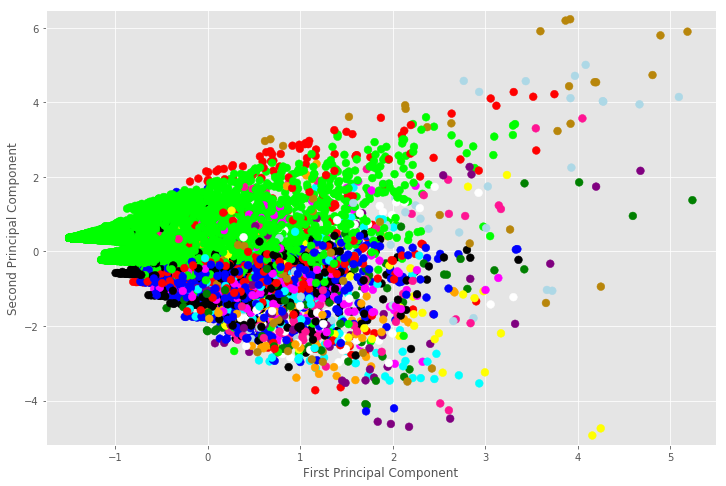

In [90]:
plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(DBSCAN_PCA["PC_1"].min()-0.25,DBSCAN_PCA["PC_1"].max()+0.25)
ax1.set_ylim(DBSCAN_PCA["PC_2"].min()-0.25,DBSCAN_PCA["PC_2"].max()+0.25)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(DBSCAN_PCA["PC_1"], DBSCAN_PCA["PC_2"],s=60, c=DBSCAN_PCA["DBSCAN_Cluster"], cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.savefig(output_path+"ARPE_DBSCAN_PCA_without_outliers_plot.png", dpi=300) 


Well, DBSCAN gave me 320 clusters with 1,537 noise points (about 10% of the data). Homogeneity was 29.8% and the silhouette coefficient was 26.5% while the V-measure was 45.9%. Although these numbers aren't great, it does look like things cluster rather well on the PCA plot. It looks like a third dimension would benefit the graph. The largest cluster is cluster 1 (the green one) with 6,032 genes. The next largest cluster only has 782 genes. I am interested to see if these genes cluster in a given pathway or something like that. I will have to look into that next.  


In [148]:
import numpy as np
import pandas as pd
import os

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn import tree

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

from sklearn import svm

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [149]:
filepath = os.path.abspath("Documents/Data Science/now-u-c-me-datascience-final-project/Output_Tables_and_Results/ARPE_Combined_Cleaned_Data.csv")
print(filepath)

/Users/rachelmuller/Documents/Data Science/now-u-c-me-datascience-final-project/Output_Tables_and_Results/ARPE_Combined_Cleaned_Data.csv


In [186]:
dataset = pd.read_pickle("Documents/Data Science/now-u-c-me-datascience-final-project/Output_Tables_and_Results/ARPE_Combined_Cleaned_Data.pkl")

In [184]:
dataset = pd.read_csv(filepath)# , engine='python'
titles = ["Ensembl_ID","Change","Name","Biotype","Chr","Length","Exonic Length","TSS_Downregulated","Downstream_Promoter_Downregulated","Gene_Body_Downregulated","Upstream_Promoter_Downregulated","TSS_Nondifferential","Downstream_Promoter_Nondifferential","Gene_Body_Nondifferential","Upstream_Promoter_Nondifferential","TSS_Upregulated","Downstream_Promoter_Upregulated","Gene_Body_Upregulated","Upstream_Promoter_Upregulated"]
dataset.columns = titles
dataset.head()
dataset = dataset.drop(columns = ['Name'])


In [187]:
dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated  TSS_Nondifferential  \
Ensembl_ID                                                              
ENSG00000000003                              0.0                  1.0   
ENSG00000000419                              0.0                  0.0   
ENSG00000000457                              0.0                  0.0   
ENSG00000000460                              0.0                  0.0   
ENSG00000000971                              0.0                  0.0   

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  
Ensembl_ID                                                             
ENSG00000000003                    0.0                            0.0  
ENSG00000000419                    1.0                            0.0  
ENSG00000000457                    1.0                            0.0  
ENSG00000000460                    2.0                            0.0  
ENSG00000000971                    0.0                            0.0

In [188]:
changes = dataset['Change']
up = dataset['Change'] == "Upregulated"
down = dataset['Change'] == "Downregulated"
non = dataset['Change'] == "Nondifferential"

dataset_up = dataset[up]
dataset_down = dataset[down]
dataset_non = dataset[non]
print(str(dataset_up.shape[0]) +  " genes are upregulated")
print(str(dataset_down.shape[0]) +  " genes are downregulated")
print(str(dataset_non.shape[0]) +  " genes are nondifferential")
print(len(dataset))
a = 3245+1434+9920
print(a)

3262 genes are upregulated
1417 genes are downregulated
9920 genes are nondifferential
14599
14599


In [190]:
dataset.Change.replace(('Upregulated', 'Nondifferential', 'Downregulated'), (2,1,0), inplace=True)
dataset.Chr.replace(('X', 'Y'), (0, 100), inplace = True)

dataset = dataset[dataset.Chr != 'MT']
dataset = dataset[dataset.Chr != 'KI270711.1']
dataset = dataset[dataset.Chr != 'KI270713.1']
dataset = dataset[dataset.Chr != 'GL000195.1']
dataset = dataset[dataset.Chr != 'GL000219.1']


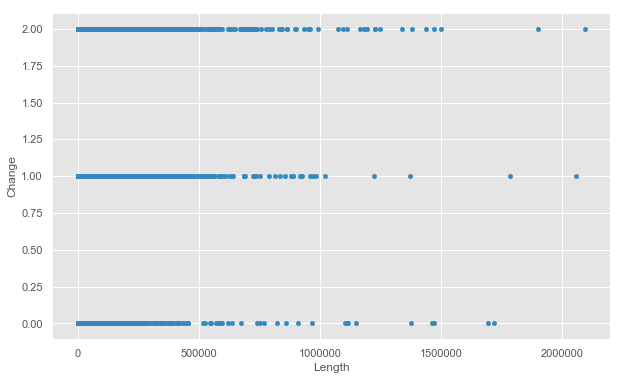

In [191]:
dataset.plot(y = "Change", x = "Length", kind = 'scatter')

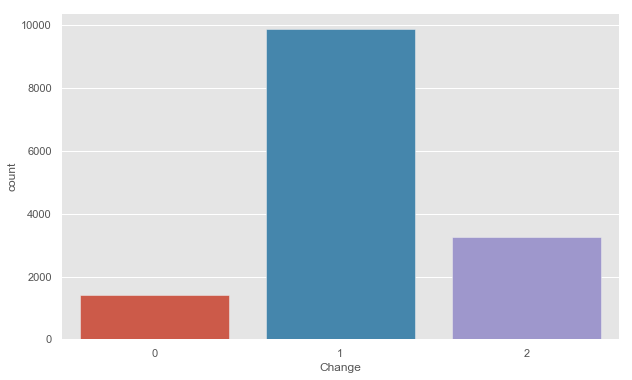

In [192]:
type_ = "Change"
ax = sns.countplot(x = type_, data = dataset)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


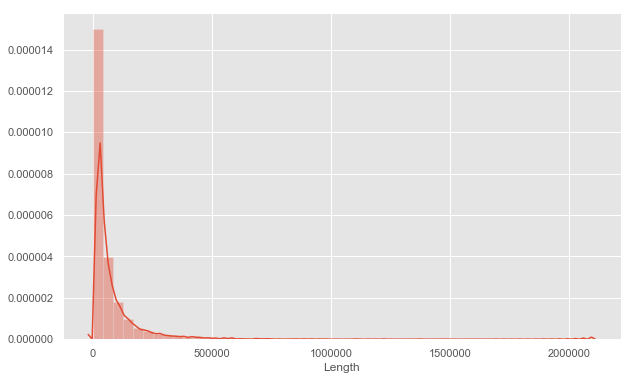

In [193]:
sns.distplot(dataset["Length"])

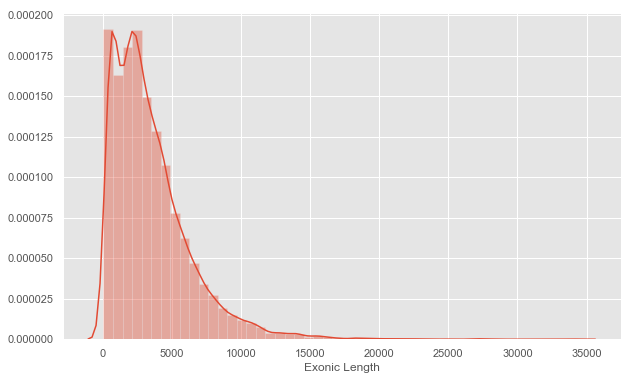

In [194]:
sns.distplot(dataset["Exonic Length"])

In [195]:
#a = sns.catplot("Exonic Length", col = type_, col_wrap = 4, 
                #data = dataset[dataset["Exonic Length"].notnull()],
                #kind = "count", height = 4.5, aspect = 0.8)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

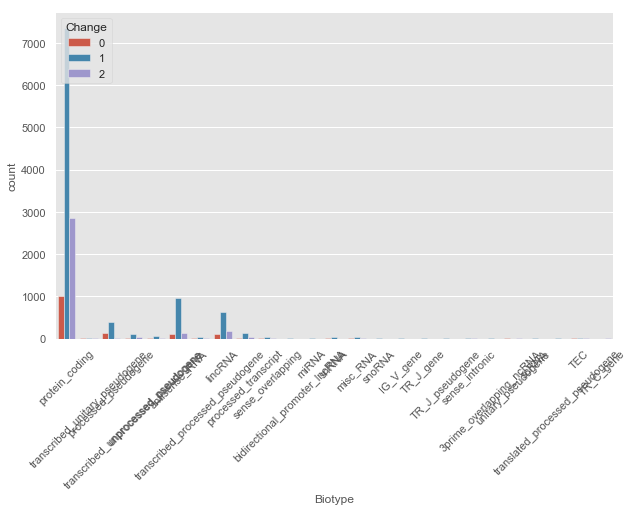

In [196]:
sns.countplot(x = "Biotype", hue = type_, data=dataset, );
plt.xticks(rotation = 45)


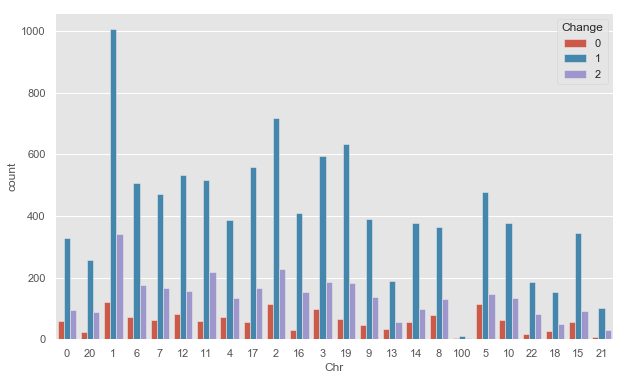

In [197]:
sns.countplot(x = "Chr", hue = type_, data=dataset);

In [200]:
knn_dataset = dataset[["Change","Length","Exonic Length","TSS_Downregulated","Downstream_Promoter_Downregulated","Gene_Body_Downregulated","Upstream_Promoter_Downregulated","TSS_Nondifferential","Downstream_Promoter_Nondifferential","Gene_Body_Nondifferential","Upstream_Promoter_Nondifferential","TSS_Upregulated","Downstream_Promoter_Upregulated","Gene_Body_Upregulated","Upstream_Promoter_Upregulated"]]

In [225]:
knn_dataset.columns[1:]

Index(['Length', 'Exonic Length', 'TSS_Downregulated',
       'Downstream_Promoter_Downregulated', 'Gene_Body_Downregulated',
       'Upstream_Promoter_Downregulated', 'TSS_Nondifferential',
       'Downstream_Promoter_Nondifferential', 'Gene_Body_Nondifferential',
       'Upstream_Promoter_Nondifferential', 'TSS_Upregulated',
       'Downstream_Promoter_Upregulated', 'Gene_Body_Upregulated',
       'Upstream_Promoter_Upregulated'],
      dtype='object')

In [227]:
#features = knn_dataset.columns()
features = knn_dataset.columns[1:]
X = knn_dataset[features].values
y = knn_dataset['Change'].values

selector = SelectPercentile(chi2)
X_new = selector.fit_transform(X, y)
print(X)
print("P Values:", selector.pvalues_)

[[9.99600e+03 3.79600e+03 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [2.36890e+04 1.16100e+03 0.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [4.43220e+04 6.36400e+03 0.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 ...
 [2.75580e+05 1.67500e+03 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [4.23420e+04 1.19800e+03 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.21298e+05 3.74300e+03 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
P Values: [0.00000000e+000 0.00000000e+000 4.43033110e-001 1.74082557e-001
 7.43742873e-069 2.51351527e-001 1.71899508e-013 3.65645666e-029
 0.00000000e+000 3.11208644e-048 3.85746305e-117 1.05042279e-226
 0.00000000e+000 4.71657822e-210]


In [228]:
selector = SelectKBest(chi2, k=3)
X_new = selector.fit_transform(X, y)
print(features)
selector.get_support()

Index(['Length', 'Exonic Length', 'TSS_Downregulated',
       'Downstream_Promoter_Downregulated', 'Gene_Body_Downregulated',
       'Upstream_Promoter_Downregulated', 'TSS_Nondifferential',
       'Downstream_Promoter_Nondifferential', 'Gene_Body_Nondifferential',
       'Upstream_Promoter_Nondifferential', 'TSS_Upregulated',
       'Downstream_Promoter_Upregulated', 'Gene_Body_Upregulated',
       'Upstream_Promoter_Upregulated'],
      dtype='object')


array([ True,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False])

In [229]:
best_features = ['Length', 'Exonic Length']

In [230]:
def splitData(features):
    change_labels = dataset["Change"].values
    change_predictors = dataset[features].values
    
    #split into training and test sets
    xtrain, xtest, ytrain, ytest = train_test_split(change_predictors, change_labels,
                                                   random_state = 1, test_size = 0.2)
    return xtrain, xtest, ytrain, ytest

In [232]:

xtrain, xtest, ytrain, ytest = splitData(best_features)
knearest_model = KNeighborsClassifier(n_neighbors = 20)
knearest_model.fit(xtrain, ytrain)

y_pred = knearest_model.predict(xtest)

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = ytest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = ytest, y_pred = y_pred))


Confusion Matrix:
[[   0  297   20]
 [   0 1863   87]
 [   0  580   67]]
Accuracy =  0.6623198352779684


It's clunky but it works... Let me know what I could do better or what you're seeing from this. I'm not quite sure how to interpret this.

# RNA and hMeDIP Clustering and Data Exploration

## Information obtained from data cleaning

In the three previous notebooks I have cleaned up all of the data and created dataframes that contain info about all of the expressed genes. There is one dataframe for each data set (Human ARPE-19 cells treated with vitamin C, Rat Schwann cells treated with vitamin C, and Rat Schwann cells treated with cAMP). The columns (not necessarily in this order) are as follows: 

1. Ensembl ID: this is just the ID for each gene, will be used as the index
2. Change: meaning the change in transcription in response to either vitamin C or cAMP, this will be the label
3. Name: This is the gene name. I kept these so that we can look at the clusters later, but this will not be included in the analysis.
4. Biotype: Most of these are protein coding, so this will be changed to a binary classification of either protein coding or not protein coding
5. Chromosome: Should not be a confounding variable, but I thought I should include it for just in case.
6. Length: Entire transcript length, from transcription start site (TSS) to transcription termination site (TTS)
7. Exonic Length: Length of the coding transcript, exons only
8. TSS_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's TSS
9. Downstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
10. Gene_Body_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
11. Upstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
12. TSS_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's TSS
13. Downstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
14. Gene_Body_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
15. Upstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
16. TSS_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's TSS
17. Downstream_Promoter_Upregulated: Number of peaks that increae in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
18. Gene_Body_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
19. Upstream_Promoter_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)




## This notebook will contain classification steps for these datasets

For this notebook, I will include information about the machine learning classification. I plan to split one dataset (ARPE) into test and train sets to see how well I can classify the test genes. Whichever one works best will be trained on all of the genes from the ARPE dataset and then used to classify the genes in the schwann cell dataset. I predict that this will not be particularly successful on predicting changes in the Schwann cells, simply because it is another cell type and another species (human vs. rat). The cAMP dataset is also likely to not have great prediction because it is treated with cAMP, which affects three transcription factors (CREM, CREM, ATF1). 

In [1]:
import os
import pandas as pd
import numpy as np


from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

In [2]:
cleaned_data_path = "Output_Tables_and_Results/"
output_path = "Classification_Output/"

In [3]:
os.listdir("Output_Tables_and_Results/")


['ARPE_Intermediate_Files',
 'SC_VitC_Combined_Cleaned_Data.csv',
 'SC_cAMP_Combined_Cleaned_Data.pkl',
 '.DS_Store',
 'ARPE_Combined_Cleaned_Data.csv',
 'ARPE_Combined_Cleaned_Data.pkl',
 'SC-VitC_Intermediate_Files',
 'SC-cAMP_Intermediate_Files',
 'SC_cAMP_Combined_Cleaned_Data.csv',
 'SC_VitC_Combined_Cleaned_Data.pkl']

In [4]:
ARPE_cleaned_dataset = pd.read_pickle(cleaned_data_path+"ARPE_Combined_Cleaned_Data.pkl")
SC_VitC_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_VitC_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")



In [5]:
ARPE_cleaned_dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated  TSS_Nondifferential  \
Ensembl_ID                                                              
ENSG00000000003                              0.0                  1.0   
ENSG00000000419                              0.0                  0.0   
ENSG00000000457                              0.0                  0.0   
ENSG00000000460                              0.0                  0.0   
ENSG00000000971                              0.0                  0.0   

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  
Ensembl_ID                                                             
ENSG00000000003                    0.0                            0.0  
ENSG00000000419                    1.0                            0.0  
ENSG00000000457                    1.0                            0.0  
ENSG00000000460                    2.0                            0.0  
ENSG00000000971                    0.0                            0.0

The first step is going to be to split the data into numpy arrays. Unfortunately, I am also going to have to create dummy variables for the categorical variables that I want to include. I also need to change the "Change" to numbers. I think I will use 0 for downregulated, 1 for nondifferential and 2 for upregulated. Biotype will be split into "protein_coding" vs everything else. For chromosomes, I am just going to split it into nuclear chromosomes vs mitochondrial chromosome and patches.  


In [6]:
ARPE_cleaned_dataset["Chr"].unique()

array(['X', '20', '1', '6', '7', '12', '11', '4', '17', '2', '16', '3',
       '19', '9', '13', '14', '8', 'Y', '5', '10', '22', '18', '15', '21',
       'MT', 'KI270711.1', 'GL000219.1', 'KI270713.1', 'GL000195.1'],
      dtype=object)

In [7]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

ARPE_cleaned_dataset["Numeric_Change"] = ARPE_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

ARPE_cleaned_dataset["Numeric_Biotype"] = ARPE_cleaned_dataset["Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

ARPE_cleaned_dataset["Numeric_Chr"] = ARPE_cleaned_dataset["Chr"].apply(get_chromosome)

In [8]:
ARPE_cleaned_dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated     ...       \
Ensembl_ID                                           ...        
ENSG00000000003                              0.0     ...        
ENSG00000000419                              0.0     ...        
ENSG00000000457                              0.0     ...        
ENSG00000000460                              0.0     ...        
ENSG00000000971                              0.0     ...        

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003                    0.0                            0.0   
ENSG00000000419                    1.0                            0.0   
ENSG00000000457                    1.0                            0.0   
ENSG00000000460                    2.0                            0.0   
ENSG00000000971                    0.0                            0.0   

                 Numeric_Change  Numeric_Biotype  Numeric_Chr  
Ensembl_ID                                                     
ENSG00000000003               0  

In [9]:
ARPE_cleaned_dataset.describe()

Length  Exonic Length  TSS_Downregulated  \
count  1.459900e+04   14599.000000       14599.000000   
mean   6.280085e+04    3476.985684           0.002671   
std    1.150453e+05    2869.609131           0.051618   
min    4.800000e+01      48.000000           0.000000   
25%    9.014000e+03    1460.000000           0.000000   
50%    2.629700e+04    2794.000000           0.000000   
75%    6.702300e+04    4676.000000           0.000000   
max    2.092292e+06   34526.000000           1.000000   

       Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
count                       14599.000000             14599.000000   
mean                            0.010823                 0.136105   
std                             0.104787                 0.558936   
min                             0.000000                 0.000000   
25%                             0.000000                 0.000000   
50%                             0.000000                 0.000000   
75%                             0.000000                 0.000000   
max                             2.000000                15.000000   

       Upstream_Promoter_Downregulated  TSS_Nondifferential  \
count                     14599.000000         14599.000000   
mean                          0.012604             0.049387   
std                           0.111560             0.234009   
min                           0.000000             0.000000   
25%                           0.000000             0.000000   
50%                           0.000000             0.000000   
75%                           0.000000             0.000000   
max                           1.000000             4.000000   

       Downstream_Promoter_Nondifferential  Gene_Body_Nondifferential  \
count                         14599.000000               14599.000000   
mean                              0.205425                   1.644702   
std                               0.495142                   3.781105   
min                               0.000000                   0.000000   
25%                               0.000000                   0.000000   
50%                               0.000000                   0.000000   
75%                               0.000000                   2.000000   
max                               7.000000                  66.000000   

       Upstream_Promoter_Nondifferential  TSS_Upregulated  \
count                       14599.000000     14599.000000   
mean                            0.224741         0.110419   
std                             0.530842         0.371804   
min                             0.000000         0.000000   
25%                             0.000000         0.000000   
50%                             0.000000         0.000000   
75%                             0.000000         0.000000   
max                             8.000000         6.000000   

       Downstream_Promoter_Upregulated  Gene_Body_Upregulated  \
count                     14599.000000           14599.000000   
mean                          0.342147               1.900267   
std                           0.728718               4.845714   
min                           0.000000               0.000000   
25%                           0.000000               0.000000   
50%                           0.000000               0.000000   
75%                           0.000000               2.000000   
max                          11.000000             106.000000   

       Upstream_Promoter_Upregulated  Numeric_Change  Numeric_Biotype  \
count                   14599.000000    14599.000000     14599.000000   
mean                        0.330708        1.126379         0.769094   
std                         0.730941        0.551861         0.421427   
min                         0.000000        0.000000         0.000000   
25%                         0.000000        1.000000         1.000000   
50%                         0.000000        1.000000         1.000000   
75% 

In [10]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr'], dtype=object)

In [11]:
ARPE_X = np.array(ARPE_cleaned_dataset[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])\

ARPE_y = np.array(ARPE_cleaned_dataset[["Numeric_Change"]])

In [12]:
scaled_ARPE_X = scale(ARPE_X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(scaled_ARPE_X, ARPE_y, random_state=1, test_size=0.8) 

In [14]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2919
2919
11680
11680


Now I am going to try to figure out a good value for C in using an SVM. I recall from the previous ones we run, a bad value of C doesn't decrease your accuracy that much. I am going to only use the training data because it takes too long to run with all ~15,000 genes. I will run a test-train split and a cross-val once I find a good value of C. 

In [15]:
## It turns out that this gives annoying warnings if your y value is a 2-D array. The .ravel() function makes it a 1-D array.
## I have put pound signs through a few parts and saved the results in csv format so that if you run the whole notebook
## with the restart and run all option, it will not take more than half an hour to complete. 

# Cs = np.arange(1,502,5)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"ARPE_SVM_C_values.csv")

In [16]:
ARPE_SVM_Cs = pd.read_csv(output_path+"ARPE_SVM_C_values.csv", index_col = 0)
ARPE_SVM_Cs.head()

C_value  Accuracy
0        1  0.689622
1        6  0.684481
2       11  0.680374
3       16  0.677635
4       21  0.674901

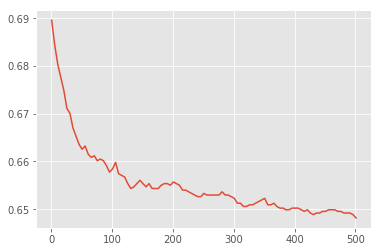

In [17]:

plt.plot(ARPE_SVM_Cs[["C_value"]], ARPE_SVM_Cs[["Accuracy"]])
plt.show()

It looks like the low numbers give the highest accuracy. I am going to repeat this step with values of C between 0 and 5.

In [18]:
## It looks like the low numbers are the best ones. I am going to try this again with numbers between 0 and 5.

# Cs = np.arange(0.1,5,0.1)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"ARPE_SVM_C_values_Concentrated.csv")

Maximum Accuracy is: 0.6920195443108341 for C = 0.7


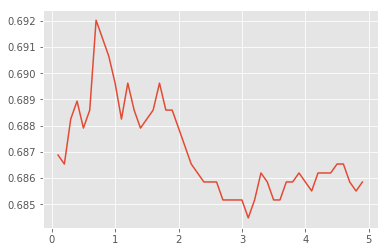

In [19]:
ARPE_SVM_Cs_concentrated = pd.read_csv(output_path+"ARPE_SVM_C_values_Concentrated.csv", index_col = 0)
#ARPE_SVM_Cs_concentrated.head()
max_accuracies = max(ARPE_SVM_Cs_concentrated["Accuracy"])
for i,num in enumerate( ARPE_SVM_Cs_concentrated["Accuracy"]):
    if num == max_accuracies:
        max_c = i*0.1+0.1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(ARPE_SVM_Cs_concentrated[["C_value"]], ARPE_SVM_Cs_concentrated[["Accuracy"]])
plt.show()        

Even though I did a cross validation using only 1/5 of the genes, I think this value of C should be ok. This is the first time I have seen a value of C below 1 be the highest. The maximum that I got was 0.7.

In [20]:
# Now to see how training on the 1/5 and testing on the 80% performs

model_svm = svm.SVC(kernel='rbf',C=0.7,gamma='auto')
model_svm.fit(X_train, y_train.ravel())

Y_pred = model_svm.predict(X_test)

ARPE_test_train_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_test_train_accuracy)


ARPE_SVM_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 80%, train on 20% Accuracy =  0.6842465753424658

Confusion Matrix:
[[   0 1121   30]
 [   0 7726  189]
 [   0 2348  266]]


In [21]:

model_numbers = svm.SVC(kernel='rbf', C = 0.7, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_ARPE_X, y = ARPE_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())



5-fold cross validation Accuracy =  0.6885420679937685


In [22]:
ARPE_SVM_accuracy_scores = ( scores.mean(), ARPE_test_train_accuracy)
ARPE_SVM_accuracy_scores

(0.6885420679937685, 0.6842465753424658)

From the confusion matrix, this is total crap. It didn't predict that a single thing was downregulated. Looking at the test data, we had 67.77% nondifferential, 9.85% downregulated and 22.38% upregulated. Bayesian statistics would put guessing any random one correctly at 51.9%. Going up to ~69% accuracy is an improvement, but we have a 0% accuracy of predicting downregulated genes. I think we can only do predictions on ones that have at least one 5hmC peak. If they are all 0, they are probably predicted as nondifferential.

I looked at the data, and it looks like a large proportion of the genes have 0 peaks in the promoter and either 0 or 1 peak in the gene body. I think I am going to filter this for genes that have either 1 peaks in the promoter or 2+ peaks in the gene body (or both). 

In [23]:
ARPE_cleaned_dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated     ...       \
Ensembl_ID                                           ...        
ENSG00000000003                              0.0     ...        
ENSG00000000419                              0.0     ...        
ENSG00000000457                              0.0     ...        
ENSG00000000460                              0.0     ...        
ENSG00000000971                              0.0     ...        

                 Downstream_Promoter_Nondifferential  \
Ensembl_ID                                             
ENSG00000000003                                  0.0   
ENSG00000000419                                  0.0   
ENSG00000000457                                  0.0   
ENSG00000000460                                  0.0   
ENSG00000000971                                  1.0   

                 Gene_Body_Nondifferential  Upstream_Promoter_Nondifferential  \
Ensembl_ID                                                                      
ENSG00000000003                        0.0                                0.0   
ENSG00000000419                        0.0                                0.0   
ENSG00000000457                        1.0                                0.0   
ENSG00000000460                        4.0                                0.0   
ENSG00000000971                        1.0                                0.0   

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003                    0.0                            0.0   
ENSG00000000419                    1.0                            0.0   
ENSG00000000457                    1.0                            0.0   
ENSG00000000460                    2.0                            0.0   
ENSG00000000971                    0.0                            0.0   

                 Numeric_Change  Numeric_Biotype  Numeric_Chr  
Ensembl_ID                                                     
ENSG00000000003               0  

In [24]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr'], dtype=object)

In [25]:
ARPE_cleaned_dataset["Gene_Body_Counts"] = (ARPE_cleaned_dataset["Gene_Body_Downregulated"]+ 
                                            ARPE_cleaned_dataset["Gene_Body_Nondifferential"] + ARPE_cleaned_dataset["Gene_Body_Upregulated"])

ARPE_cleaned_dataset["Promoter_Counts"] = (ARPE_cleaned_dataset["TSS_Downregulated"]+ ARPE_cleaned_dataset["Downstream_Promoter_Downregulated"]+ 
                                           ARPE_cleaned_dataset["Upstream_Promoter_Downregulated"]+ ARPE_cleaned_dataset["TSS_Nondifferential"]+ 
                                           ARPE_cleaned_dataset["Downstream_Promoter_Nondifferential"]+ ARPE_cleaned_dataset["Upstream_Promoter_Nondifferential"]+ 
                                           ARPE_cleaned_dataset["TSS_Upregulated"]+ ARPE_cleaned_dataset["Downstream_Promoter_Upregulated"]+ 
                                           ARPE_cleaned_dataset["Upstream_Promoter_Upregulated"])



In [26]:
ARPE_cleaned_dataset.head()

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated       ...         \
Ensembl_ID                                             ...          
ENSG00000000003                              0.0       ...          
ENSG00000000419                              0.0       ...          
ENSG00000000457                              0.0       ...          
ENSG00000000460                              0.0       ...          
ENSG00000000971                              0.0       ...          

                 Upstream_Promoter_Nondifferential  TSS_Upregulated  \
Ensembl_ID                                                            
ENSG00000000003                                0.0              0.0   
ENSG00000000419                                0.0              0.0   
ENSG00000000457                                0.0              0.0   
ENSG00000000460                                0.0              0.0   
ENSG00000000971                                0.0              0.0   

                 Downstream_Promoter_Upregulated  Gene_Body_Upregulated  \
Ensembl_ID                                                                
ENSG00000000003                              0.0                    0.0   
ENSG00000000419                              0.0                    1.0   
ENSG00000000457                              0.0                    1.0   
ENSG00000000460                              0.0                    2.0   
ENSG00000000971                              0.0                    0.0   

                 Upstream_Promoter_Upregulated  Numeric_Change  \
Ensembl_ID                                                       
ENSG00000000003                            0.0               0   
ENSG00000000419                            0.0               1   
ENSG00000000457                            0.0               1   
ENSG00000000460                            0.0               1   
ENSG00000000971                            0.0               2   

                 Numeric_Biotype  Numeric_Chr  Gene_Body_Counts  \
Ensembl_ID                                                        
ENSG00000000003                1            0               0.0   
ENSG00000000419                1            0               1.0   
ENSG00000000457                1            0               2.0   
ENSG00000000460                1            0               6.0   
ENSG00000000971                1            0               1.0   

                 Promoter_Counts  
Ensembl_ID                        
ENSG00000000003              1.0  
ENSG00000000419             

In [27]:
def get_keep_or_discard(gene, promoter):
    if gene > 1:
        return 1 #"Keep"
    else:
        if promoter > 0:
            return 1 #"Keep"
        else:
            return 0 #"Discard"

ARPE_cleaned_dataset["Discard_column"] = ARPE_cleaned_dataset["Gene_Body_Counts"].combine(
    ARPE_cleaned_dataset["Promoter_Counts"], func=get_keep_or_discard)
    


In [28]:
ARPE_cleaned_dataset.head()
# Yay! It worked. Now to subset it.

Change      Name         Biotype Chr   Length  \
Ensembl_ID                                                                
ENSG00000000003    Downregulated    TSPAN6  protein_coding   X   9996.0   
ENSG00000000419  Nondifferential      DPM1  protein_coding  20  23689.0   
ENSG00000000457  Nondifferential     SCYL3  protein_coding   1  44322.0   
ENSG00000000460  Nondifferential  C1orf112  protein_coding   1  58672.0   
ENSG00000000971      Upregulated       CFH  protein_coding   1  95627.0   

                 Exonic Length  TSS_Downregulated  \
Ensembl_ID                                          
ENSG00000000003         3796.0                0.0   
ENSG00000000419         1161.0                0.0   
ENSG00000000457         6364.0                0.0   
ENSG00000000460         4355.0                0.0   
ENSG00000000971         4127.0                0.0   

                 Downstream_Promoter_Downregulated  Gene_Body_Downregulated  \
Ensembl_ID                                                                    
ENSG00000000003                                0.0                      0.0   
ENSG00000000419                                0.0                      0.0   
ENSG00000000457                                0.0                      0.0   
ENSG00000000460                                0.0                      0.0   
ENSG00000000971                                0.0                      0.0   

                 Upstream_Promoter_Downregulated       ...        \
Ensembl_ID                                             ...         
ENSG00000000003                              0.0       ...         
ENSG00000000419                              0.0       ...         
ENSG00000000457                              0.0       ...         
ENSG00000000460                              0.0       ...         
ENSG00000000971                              0.0       ...         

                 TSS_Upregulated  Downstream_Promoter_Upregulated  \
Ensembl_ID                                                          
ENSG00000000003              0.0                              0.0   
ENSG00000000419              0.0                              0.0   
ENSG00000000457              0.0                              0.0   
ENSG00000000460              0.0                              0.0   
ENSG00000000971              0.0                              0.0   

                 Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Ensembl_ID                                                              
ENSG00000000003                    0.0                            0.0   
ENSG00000000419                    1.0                            0.0   
ENSG00000000457                    1.0                            0.0   
ENSG00000000460                    2.0                            0.0   
ENSG00000000971                    0.0                            0.0   

                 Numeric_Change  Numeric_Biotype  Numeric_Chr  \
Ensembl_ID                                                      
ENSG00000000003               0                1            0   
ENSG00000000419               1                1            0   
ENSG00000000457               1                1            0   
ENSG00000000460               1                1            0   
ENSG00000000971               2                1            0   

                 Gene_Body_Counts  Promoter_Counts  Discard_column  
Ensembl_ID                                                          
ENSG00000000003               0.0              1.0             1.0  
ENSG00000000419               1.0              0.0             0.0  
ENSG00000000457               2.0              0.0             1.0  
ENSG00000000460               6.0              0.0             1.0  
ENSG00000000971               1.0              1.0             1.0  

[5 rows x 24 columns]

In [29]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr',
       'Gene_Body_Counts', 'Promoter_Counts', 'Discard_column'],
      dtype=object)

In [30]:
ARPE_genes_with_peaks = ARPE_cleaned_dataset[ARPE_cleaned_dataset["Discard_column"]== 1][['Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr',]]

In [31]:
ARPE_X = np.array(ARPE_genes_with_peaks[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

ARPE_y = np.array(ARPE_genes_with_peaks[["Numeric_Change"]])

In [32]:
scaled_ARPE_X = scale(ARPE_X)
X_train, X_test, y_train, y_test = train_test_split(scaled_ARPE_X, ARPE_y, random_state=1, test_size=0.8) 
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1940
1940
7763
7763


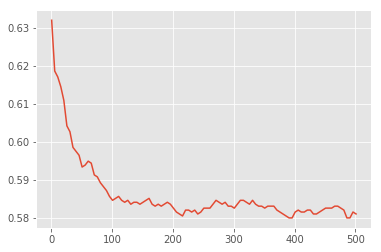

In [33]:
# It turns out that this gives annoying warnings if your y value is a 2-D array. The .ravel() function makes it a 1-D array.


Cs = np.arange(1,502,5)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
    scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()
ARPE_with_peaks_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
ARPE_with_peaks_SVM_Cs.to_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values.csv")



In [34]:
ARPE_with_peaks_SVM_Cs = pd.read_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values.csv", index_col = 0)
ARPE_with_peaks_SVM_Cs.head()

C_value  Accuracy
0        1  0.631952
1        6  0.618579
2       11  0.617026
3       16  0.614447
4       21  0.610839

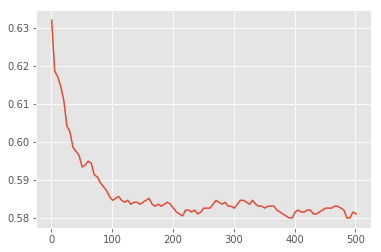

In [35]:
plt.plot(ARPE_with_peaks_SVM_Cs[["C_value"]], ARPE_with_peaks_SVM_Cs[["Accuracy"]])
plt.show()

In [36]:
# # It looks like the low numbers are the best ones again. I am going to try this again with numbers between 0 and 5.

# Cs = np.arange(0.1,5,0.1)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values_Concentrated.csv")

Maximum Accuracy is: 0.631433396671061 for C = 0.7


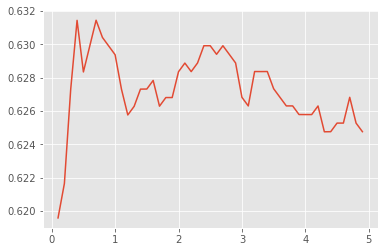

In [37]:
ARPE_with_peaks_SVM_Cs_concentrated = pd.read_csv(output_path+"ARPE_genes_with_peaks_SVM_C_values_Concentrated.csv", index_col = 0)
#ARPE_SVM_Cs_concentrated.head()
max_accuracies = max(ARPE_with_peaks_SVM_Cs_concentrated["Accuracy"])
for i,num in enumerate( ARPE_with_peaks_SVM_Cs_concentrated["Accuracy"]):
    if num == max_accuracies:
        max_c = i*0.1+0.1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(ARPE_with_peaks_SVM_Cs_concentrated[["C_value"]], ARPE_with_peaks_SVM_Cs_concentrated[["Accuracy"]])
plt.show()        

Now I am going to see how it performs after removing the ones that have very few 5hmC peaks.

In [38]:
# Now to see how training on the 1/5 and testing on the 80% performs

model_svm = svm.SVC(kernel='rbf',C=0.7,gamma='auto')
model_svm.fit(X_train, y_train.ravel())

Y_pred = model_svm.predict(X_test)

ARPE_test_train_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_test_train_accuracy)


ARPE_SVM_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 80%, train on 20% Accuracy =  0.6368671905191292

Confusion Matrix:
[[   0  616   57]
 [   0 4540  311]
 [   0 1835  404]]


In [39]:
model_numbers = svm.SVC(kernel='rbf', C = 0.7, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_ARPE_X, y = ARPE_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())



5-fold cross validation Accuracy =  0.6426902686747097


Well, this has even lower accuracy and still doesn't get a single one of the downregulated genes correct. I am going to try making it even more stringent (require 5 peaks in gene body) and see what happens. 

In [40]:
def get_keep_or_discard(gene, promoter):
    if gene > 5:
        return 1 #"Keep"
    else:
        if promoter > 1:
            return 1 #"Keep"
        else:
            return 0 #"Discard"

ARPE_cleaned_dataset["Try3_column"] = ARPE_cleaned_dataset["Gene_Body_Counts"].combine(
    ARPE_cleaned_dataset["Promoter_Counts"], func=get_keep_or_discard)
    


In [41]:
ARPE_try3 = ARPE_cleaned_dataset[ARPE_cleaned_dataset["Try3_column"]== 1][['Length', 'Exonic Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Numeric_Change', 'Numeric_Biotype', 'Numeric_Chr',]]

In [42]:
ARPE_X3 = np.array(ARPE_try3[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

ARPE_y3 = np.array(ARPE_try3[["Numeric_Change"]])

In [43]:
scaled_ARPE_X3 = scale(ARPE_X3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(scaled_ARPE_X3, ARPE_y3, random_state=1, test_size=0.5) 
print(len(X_train3))
print(len(y_train3))
print(len(X_test3))
print(len(y_test3))

2816
2816
2816
2816


In [44]:
model_svm = svm.SVC(kernel='rbf',C=0.7,gamma='auto')
model_svm.fit(X_train3, y_train3.ravel())

Y_pred = model_svm.predict(X_test3)

ARPE_test_train_accuracy = metrics.accuracy_score(y_true = y_test3.ravel(), y_pred = Y_pred)
print('Test on 50%, train on 50% Accuracy = ', ARPE_test_train_accuracy)


ARPE_SVM_confusion = metrics.confusion_matrix(y_true = y_test3.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 50%, train on 50% Accuracy =  0.5862926136363636

Confusion Matrix:
[[   0  189   31]
 [   0 1400  165]
 [   0  780  251]]


In [45]:
model_numbers = svm.SVC(kernel='rbf', C = 0.7, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_ARPE_X3, y = ARPE_y3.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())

5-fold cross validation Accuracy =  0.5861197494005854


Well, this was not very successful. I am not surprised that the accuracy wasn't that high, but the fact that I can't get it to predict ANYTHING as downregulated is a little intriguing. I am going to try to do this again with the Schwann Cell cAMP dataset because it has roughly 1/3 of the genes up, 1/3 down and 1/3 nondifferential. 

In [46]:
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon Length  Gene_Body_Downregulated  \
Gene_ID                                                            
ENSRNOG00000000001    1421         1416                      0.0   
ENSRNOG00000000010    3810         2444                      0.0   
ENSRNOG00000000017   10589         1280                      0.0   
ENSRNOG00000000021    1202         1200                      0.0   
ENSRNOG00000000024   29515         1062                      2.0   

                    Upstream_Promoter_Downregulated  \
Gene_ID                                               
ENSRNOG00000000001                              0.0   
ENSRNOG00000000010                              0.0   
ENSRNOG00000000017                              1.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                                0.0                0.0   
ENSRNOG00000000010                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000021                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   

                    Gene_Body_Nondifferential  \
Gene_ID                                         
ENSRNOG00000000001                        0.0   
ENSRNOG00000000010                        0.0   
ENSRNOG00000000017                        0.0   
ENSRNOG00000000021                        0.0   
ENSRNOG00000000024                        4.0   

                    Upstream_Promoter_Nondifferential  \
Gene_ID                                                 
ENSRNOG00000000001                                0.0   
ENSRNOG00000000010                                0.0   
ENSRNOG00000000017                                0.0   
ENSRNOG00000000021                                0.0   
ENSRNOG00000000024                                0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                                        
ENSRNOG00000000001                                  0.0                  0.0   
ENSRNOG00000000010                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000021                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                    0.0                            0.0   
ENSRNOG00000000010                    0.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000021                    0.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  
Gene_ID                                                               
ENSRNOG00000000001                              0.0              0.0  
ENSRNOG00000000010                              0.0     

In [47]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

SC_cAMP_cleaned_dataset["Numeric_Change"] = SC_cAMP_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

SC_cAMP_cleaned_dataset["Numeric_Biotype"] = SC_cAMP_cleaned_dataset["Gene_Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

SC_cAMP_cleaned_dataset["Numeric_Chr"] = SC_cAMP_cleaned_dataset["Chr"].apply(get_chromosome)

In [48]:
SC_cAMP_cleaned_dataset.head()

Change       Gene_Name    Gene_Biotype Chr  \
Gene_ID                                                                   
ENSRNOG00000000001  Nondifferential  AABR07013255.1      pseudogene   2   
ENSRNOG00000000010    Downregulated           Cbln1  protein_coding  19   
ENSRNOG00000000017    Downregulated          Steap1  protein_coding   4   
ENSRNOG00000000021  Nondifferential  AABR07061902.1      pseudogene   4   
ENSRNOG00000000024    Downregulated           Hebp1  protein_coding   4   

                    Length  Exon Length  Gene_Body_Downregulated  \
Gene_ID                                                            
ENSRNOG00000000001    1421         1416                      0.0   
ENSRNOG00000000010    3810         2444                      0.0   
ENSRNOG00000000017   10589         1280                      0.0   
ENSRNOG00000000021    1202         1200                      0.0   
ENSRNOG00000000024   29515         1062                      2.0   

                    Upstream_Promoter_Downregulated  \
Gene_ID                                               
ENSRNOG00000000001                              0.0   
ENSRNOG00000000010                              0.0   
ENSRNOG00000000017                              1.0   
ENSRNOG00000000021                              0.0   
ENSRNOG00000000024                              0.0   

                    Downstream_Promoter_Downregulated  TSS_Downregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                                0.0                0.0   
ENSRNOG00000000010                                0.0                0.0   
ENSRNOG00000000017                                0.0                0.0   
ENSRNOG00000000021                                0.0                0.0   
ENSRNOG00000000024                                0.0                0.0   

                       ...       Upstream_Promoter_Nondifferential  \
Gene_ID                ...                                           
ENSRNOG00000000001     ...                                     0.0   
ENSRNOG00000000010     ...                                     0.0   
ENSRNOG00000000017     ...                                     0.0   
ENSRNOG00000000021     ...                                     0.0   
ENSRNOG00000000024     ...                                     0.0   

                    Downstream_Promoter_Nondifferential  TSS_Nondifferential  \
Gene_ID                                                                        
ENSRNOG00000000001                                  0.0                  0.0   
ENSRNOG00000000010                                  0.0                  0.0   
ENSRNOG00000000017                                  0.0                  0.0   
ENSRNOG00000000021                                  0.0                  0.0   
ENSRNOG00000000024                                  0.0                  0.0   

                    Gene_Body_Upregulated  Upstream_Promoter_Upregulated  \
Gene_ID                                                                    
ENSRNOG00000000001                    0.0                            0.0   
ENSRNOG00000000010                    0.0                            0.0   
ENSRNOG00000000017                    1.0                            0.0   
ENSRNOG00000000021                    0.0                            0.0   
ENSRNOG00000000024                    1.0                            0.0   

                    Downstream_Promoter_Upregulated  TSS_Upregulated  \
Gene_ID                                                                
ENSRNOG00000000001                              0.0              0.0   
ENSRNOG00000000010                              0.0              0.0   
ENSRNOG00000000017                              0.0              0.0   
ENSRNOG00000000021                              0.0              0.0   
ENSRNOG00000000024                              0.0              0.0   

                 

In [49]:
SC_cAMP_X = np.array(SC_cAMP_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

SC_cAMP_y = np.array(SC_cAMP_cleaned_dataset[["Numeric_Change"]])

In [50]:
scaled_cAMP_X = scale(SC_cAMP_X)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(scaled_cAMP_X, SC_cAMP_y, random_state=1, test_size=0.8) 

In [52]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2433
2433
9732
9732


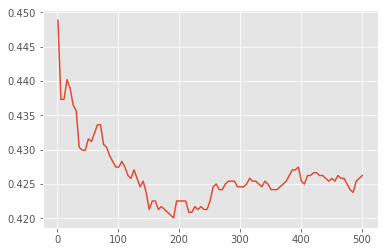

In [53]:
##It turns out that this gives annoying warnings if your y value is a 2-D array. The .ravel() function makes it a 1-D array.


Cs = np.arange(1,502,5)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
    scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()
SC_cAMP_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
SC_cAMP_SVM_Cs.to_csv(output_path+"SC_cAMP_SVM_C_values.csv")

In [54]:
SC_cAMP_SVM_Cs = pd.read_csv(output_path+"SC_cAMP_SVM_C_values.csv", index_col = 0)
SC_cAMP_SVM_Cs.head()

C_value  Accuracy
0        1  0.448836
1        6  0.437321
2       11  0.437326
3       16  0.440200
4       21  0.438970

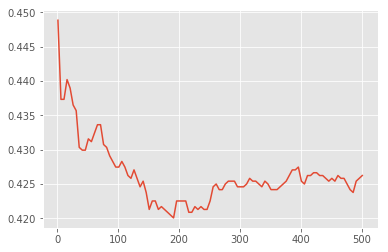

In [55]:
plt.plot(SC_cAMP_SVM_Cs[["C_value"]], SC_cAMP_SVM_Cs[["Accuracy"]])
plt.show()

It looks like a low value of C is still the best for the cAMP dataset too. 

In [56]:
# # It looks like the low numbers are the best ones. I am going to try this again with numbers between 0 and 5.

# Cs = np.arange(0.1,5,0.1)
# Accuracies = np.zeros(Cs.shape[0])
# for i,C in enumerate(Cs): 
#     model_numbers = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     scores = cross_val_score(estimator = model_numbers, X = X_train, y = y_train.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[i]  = scores.mean()
        
# plt.plot(Cs,Accuracies)
# plt.show()
# ARPE_SVM_Cs = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# ARPE_SVM_Cs.to_csv(output_path+"SC_cAMP_SVM_C_values_Concentrated.csv")

Maximum Accuracy is: 0.4508983913964855 for C = 0.4


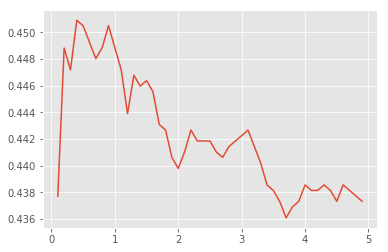

In [57]:
SC_cAMP_SVM_Cs_concentrated = pd.read_csv(output_path+"SC_cAMP_SVM_C_values_Concentrated.csv", index_col = 0)
#ARPE_SVM_Cs_concentrated.head()
max_accuracies = max(SC_cAMP_SVM_Cs_concentrated["Accuracy"])
for i,num in enumerate( SC_cAMP_SVM_Cs_concentrated["Accuracy"]):
    if num == max_accuracies:
        max_c = i*0.1+0.1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_SVM_Cs_concentrated[["C_value"]], SC_cAMP_SVM_Cs_concentrated[["Accuracy"]])
plt.show()  

In [58]:
# Now to see how training on the 1/5 and testing on the 80% performs

model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(X_train, y_train.ravel())

Y_pred = model_svm.predict(X_test)

SC_cAMP_test_train_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_test_train_accuracy)


SC_cAMP_SVM_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_SVM_confusion)
#y_pred = model_numbers.predict(X_test)

#print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Test on 80%, train on 20% Accuracy =  0.44040279490341144

Confusion Matrix:
[[1378  333 1387]
 [ 762  505 1879]
 [ 783  302 2403]]


In [59]:
model_numbers = svm.SVC(kernel='rbf', C = 0.4, gamma='scale')
scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())


5-fold cross validation Accuracy =  0.4446420559390667


In [60]:
SC_cAMP_SVM_accuracy_scores = ( scores.mean(), SC_cAMP_test_train_accuracy)
SC_cAMP_SVM_accuracy_scores

(0.4446420559390667, 0.44040279490341144)

This time the accuracy is lower, but the naive baysean model would predict lower too. The theoretical 33.43% that would be achieved by chance is increased to 44% by the SVM. I am pleased that at least it gets many correct from each category, but the accuracy is still really quite low.

I am moving on to the K-Nearest-Neighbors for this dataset. The first step will be to determine a good value for K to use. I have copied code and left the variable as Cs, but it is really Ks. 

In [61]:
# #First, finding a good value of N to use

# Cs = range(1,201,2)
# Accuracies = np.zeros(100)
# for i in Cs: 
#     model_numbers = KNeighborsClassifier(n_neighbors=i)
#     scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
#     Accuracies[int((i-1)/2)]  = scores.mean()
        
# SC_cAMP_KNN_Ns = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
# SC_cAMP_KNN_Ns.to_csv(output_path+"SC_cAMP_KNN_Ns.csv")

# plt.plot(Cs,Accuracies)
# plt.show()

Maximum Accuracy is: 0.4400389889587145 for C = 81


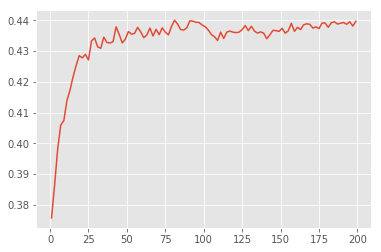

In [62]:
SC_cAMP_KNN_Ns = pd.read_csv(output_path+"SC_cAMP_KNN_Ns.csv", index_col = 0)

max_accuracies = max(SC_cAMP_KNN_Ns["Accuracy"])
for i,num in enumerate( SC_cAMP_KNN_Ns["Accuracy"]):
    if num == max_accuracies:
        max_c = i*2+1
        print ("Maximum Accuracy is:", max_accuracies, "for C =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_KNN_Ns[["C_value"]], SC_cAMP_KNN_Ns[["Accuracy"]])
plt.show() 

In [63]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
scores.mean()
print('5-fold cross validation Accuracy = ', scores.mean())

5-fold cross validation Accuracy =  0.4446420559390667


In [64]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(X_train, y_train.ravel())

Y_pred = model_KNN.predict(X_test)

SC_cAMP_KNN_accuracy = metrics.accuracy_score(y_true = y_test.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_KNN_accuracy)


SC_cAMP_KNN_confusion = metrics.confusion_matrix(y_true = y_test.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_KNN_confusion)

Test on 80%, train on 20% Accuracy =  0.43680641183723795

Confusion Matrix:
[[1347  589 1162]
 [ 763  866 1517]
 [ 804  646 2038]]


In [65]:
SC_cAMP_KNN_accuracy_scores = ( scores.mean(), SC_cAMP_KNN_accuracy)
SC_cAMP_KNN_accuracy_scores

(0.4446420559390667, 0.43680641183723795)

I got almost the exact same accuracy for the KNN as I got for SVM. Although it isn't extremely accurate, it is better than drawing decisions out of a bag. 

Now I am going to try this with the decision tree and see how this works out. The first step is going to be to determine the max depth and the min_samples_split values that give the most accurate results. 

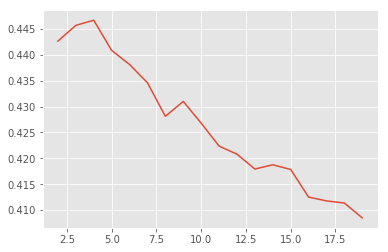

In [66]:
Cs = range(2,20,1)
Accuracies = np.zeros(len(Cs))
for i,C in enumerate(Cs): 
    model_numbers = tree.DecisionTreeClassifier(min_samples_split=15, max_depth=C)
    scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()

SC_cAMP_DT_depth = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
SC_cAMP_DT_depth.to_csv(output_path+"SC_cAMP_D_Tree_depths.csv")
        
plt.plot(Cs,Accuracies)
plt.show()

Maximum Accuracy is: 0.4466997338726301 for Depth = 4


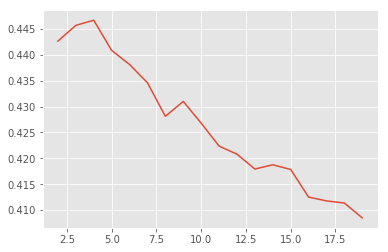

In [67]:
SC_cAMP_DT_depth = pd.read_csv(output_path+"SC_cAMP_D_Tree_depths.csv", index_col = 0)

max_accuracies = max(SC_cAMP_DT_depth["Accuracy"])
for i,num in enumerate( SC_cAMP_DT_depth["Accuracy"]):
    if num == max_accuracies:
        max_c = i+2
        print ("Maximum Accuracy is:", max_accuracies, "for Depth =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_DT_depth[["C_value"]], SC_cAMP_DT_depth[["Accuracy"]])
plt.show() 

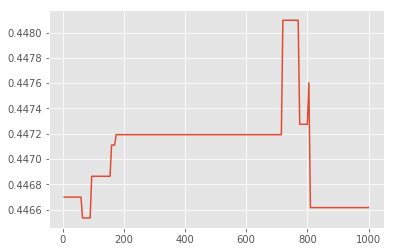

In [68]:
Cs = range(5,1001,5)
Accuracies = np.zeros(len(Cs))
for i,C in enumerate(Cs): 
    model_numbers = tree.DecisionTreeClassifier(min_samples_split=C, max_depth=4)
    scores = cross_val_score(estimator = model_numbers, X = scaled_cAMP_X, y = SC_cAMP_y.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()

SC_cAMP_DT_min_split = pd.DataFrame({"C_value": Cs, "Accuracy": Accuracies}) 
SC_cAMP_DT_min_split.to_csv(output_path+"SC_cAMP_D_Tree_min_split.csv")

plt.plot(Cs,Accuracies)
plt.show()

Maximum Accuracy is: 0.4480968817340668 for Depth = 720


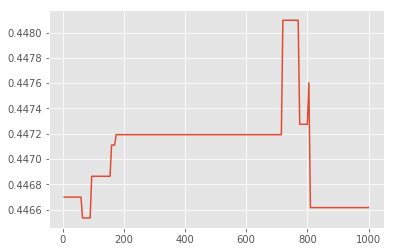

In [69]:
SC_cAMP_DT_min_split = pd.read_csv(output_path+"SC_cAMP_D_Tree_min_split.csv", index_col = 0)

max_accuracies = max(SC_cAMP_DT_min_split["Accuracy"])
for i,num in enumerate( SC_cAMP_DT_min_split["Accuracy"]):
    if num == max_accuracies:
        max_c = i*5+5
        print ("Maximum Accuracy is:", max_accuracies, "for Depth =", round(max_c, 1))
        #This is only going to get the first one, but all after 6 give the same result
        break

plt.plot(SC_cAMP_DT_min_split[["C_value"]], SC_cAMP_DT_min_split[["Accuracy"]])
plt.show() 

Now I have a max depth of 4 and a min samples split value of 720. That seems shallow and like an awful lot of samples for a minimum split, but that is what the runs above have shown. 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(scaled_cAMP_X, SC_cAMP_y.ravel(), random_state=1, test_size=0.8) 
decisionTree = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 720)
decisionTree = decisionTree.fit(X_train, y_train )
y_pred_train = decisionTree.predict(X_train)
# predict with the training data
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  0.4603370324702014
Accuracy on test data =  0.4394780106863954


In [71]:
## This is trying the same thing, just with data that isn't scaled. 

X_train, X_test, y_train, y_test = train_test_split(SC_cAMP_X, SC_cAMP_y.ravel(), random_state=1, test_size=0.8) 
decisionTree = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 720)
decisionTree = decisionTree.fit(X_train, y_train )
y_pred_train = decisionTree.predict(X_train)
# predict with the training data
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  0.4603370324702014
Accuracy on test data =  0.4394780106863954


In [72]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Downregulated", "Nondifferential", "Upregulated"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = output_path+"SC_cAMP_Decision_Tree.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

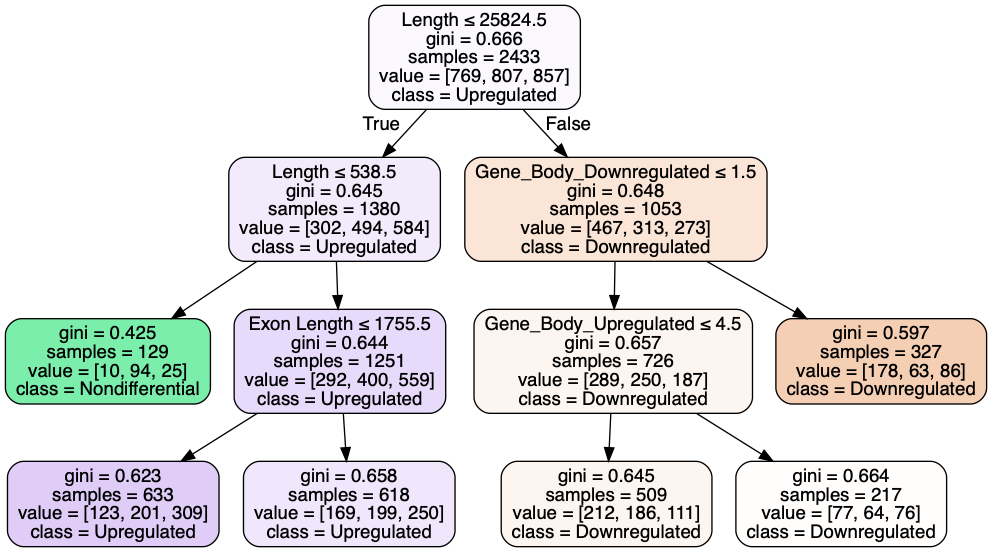

In [73]:
#used_features = list(all_of_the_columns.iloc[:,2:-1])
used_features = list(SC_cAMP_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']].columns.values)


renderTree(decisionTree, used_features)

In [74]:
print(SC_cAMP_SVM_accuracy_scores)
print(SC_cAMP_KNN_accuracy_scores)

(0.4446420559390667, 0.44040279490341144)
(0.4446420559390667, 0.43680641183723795)


Well, the results are in for the SC cAMP dataset. If I had used a naive Bayes model, I would have achieved 33.43%. Using SVM, I got 44.46% using the 5-fold cross validation and 44.04% accuracy on the one time test-train split using 80% for testing. Using KNN, I got 43.97% using the 5-fold cross validation and 43.68% accuracy on the one time test-train split using 80% for testing. Using the decision tree I got 46.03% accuracy on the training data and 43.95% accuracy on the test data. I am quite impressed that all three models gave me almost the exact same accuracy. Now that I have determined good parameters to use, I would like to see how a model trained on the SC cAMP dataset performs when tested on the other two datasets. I will try to run it back the other direction as well. 


In [75]:
ARPE_cleaned_dataset = pd.read_pickle(cleaned_data_path+"ARPE_Combined_Cleaned_Data.pkl")
SC_VitC_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_VitC_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")


In [76]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

ARPE_cleaned_dataset["Numeric_Change"] = ARPE_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

ARPE_cleaned_dataset["Numeric_Biotype"] = ARPE_cleaned_dataset["Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

ARPE_cleaned_dataset["Numeric_Chr"] = ARPE_cleaned_dataset["Chr"].apply(get_chromosome)

In [77]:
ARPE_X = np.array(ARPE_cleaned_dataset[['Length', 'Exonic Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

ARPE_y = np.array(ARPE_cleaned_dataset[["Numeric_Change"]])

In [78]:
scaled_ARPE_X = scale(ARPE_X)
#ARPE_X_train, ARPE_X_test, ARPE_y_train, ARPE_y_test = train_test_split(scaled_ARPE_X, ARPE_y, random_state=1, test_size=0.8) 
print(len(ARPE_X))
print(len(scaled_ARPE_X))
print(len(ARPE_y))
# print(len(ARPE_X_train))
# print(len(ARPE_y_train))
# print(len(ARPE_X_test))
# print(len(ARPE_y_test))


14599
14599
14599


In [79]:
def get_change(change):
    if change == "Downregulated":
        return 0
    elif change == "Nondifferential":
        return 1
    elif change == "Upregulated":
        return 2
    else:
        return "Remove this one from the dataset"

SC_VitC_cleaned_dataset["Numeric_Change"] = SC_VitC_cleaned_dataset["Change"].apply(get_change)

def get_biotype(biotype):
    if biotype == "protein_coding":
        return 1
    else:
        return 0

SC_VitC_cleaned_dataset["Numeric_Biotype"] = SC_VitC_cleaned_dataset["Gene_Biotype"].apply(get_biotype)

def get_chromosome(Chr):
    if Chr == "X": 
        return 0
    elif Chr == "Y": 
        return 0
    elif Chr == "1": 
        return 0
    elif Chr == "2": 
        return 0
    elif Chr == "3": 
        return 0
    elif Chr == "4": 
        return 0
    elif Chr == "5": 
        return 0
    elif Chr == "6": 
        return 0
    elif Chr == "7": 
        return 0
    elif Chr == "8": 
        return 0
    elif Chr == "9": 
        return 0
    elif Chr == "10": 
        return 0
    elif Chr == "11": 
        return 0
    elif Chr == "12": 
        return 0
    elif Chr == "13": 
        return 0
    elif Chr == "14": 
        return 0
    elif Chr == "15": 
        return 0
    elif Chr == "16": 
        return 0
    elif Chr == "17": 
        return 0
    elif Chr == "18": 
        return 0
    elif Chr == "19": 
        return 0
    elif Chr == "20": 
        return 0
    elif Chr == "21": 
        return 0
    elif Chr == "22": 
        return 0
    else:
        return 1

SC_VitC_cleaned_dataset["Numeric_Chr"] = SC_VitC_cleaned_dataset["Chr"].apply(get_chromosome)

In [80]:
SC_VitC_X = np.array(SC_VitC_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

SC_VitC_y = np.array(SC_VitC_cleaned_dataset[["Numeric_Change"]])

In [81]:
scaled_SC_VitC_X = scale(SC_VitC_X)
print(len(SC_VitC_X))
print(len(scaled_SC_VitC_X))
print(len(SC_VitC_y))

12152
12152
12152


In [82]:
SC_cAMP_cleaned_dataset["Numeric_Change"] = SC_cAMP_cleaned_dataset["Change"].apply(get_change)

SC_cAMP_cleaned_dataset["Numeric_Biotype"] = SC_cAMP_cleaned_dataset["Gene_Biotype"].apply(get_biotype)

SC_cAMP_cleaned_dataset["Numeric_Chr"] = SC_cAMP_cleaned_dataset["Chr"].apply(get_chromosome)

In [83]:
SC_cAMP_X = np.array(SC_cAMP_cleaned_dataset[['Length', 'Exon Length',
                     'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
                     'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
                     'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                     'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated','Numeric_Biotype', 'Numeric_Chr']])

SC_cAMP_y = np.array(SC_cAMP_cleaned_dataset[["Numeric_Change"]])
scaled_SC_cAMP_X = scale(SC_cAMP_X)
print(len(SC_cAMP_X))
print(len(scaled_SC_cAMP_X))
print(len(SC_cAMP_y))

12165
12165
12165


In [84]:
print(len(ARPE_X))
print(len(scaled_ARPE_X))
print(len(ARPE_y))
print("\n")
print(len(SC_VitC_X))
print(len(scaled_SC_VitC_X))
print(len(SC_VitC_y))
print("\n")
print(len(SC_cAMP_X))
print(len(scaled_SC_cAMP_X))
print(len(SC_cAMP_y))

14599
14599
14599


12152
12152
12152


12165
12165
12165


First is SVM, which requires the scaled X data.
I accidentally left the print statements as Test on 80% train on 20%, but they are really trained on one dataset and tested on all 3 datasets. 


In [85]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_svm.predict(scaled_SC_cAMP_X)

SC_cAMP_vs_SC_cAMP_SVM_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_cAMP_SVM_Accuracy)


SC_cAMP_vs_SC_cAMP_SVM_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_cAMP_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.45869297163995065

Confusion Matrix:
[[1774  286 1807]
 [ 936  572 2445]
 [ 840  271 3234]]


In [86]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_svm.predict(scaled_ARPE_X)

SC_cAMP_vs_ARPE_SVM_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_ARPE_SVM_Accuracy)


SC_cAMP_vs_ARPE_SVM_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_ARPE_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.2900198643742722

Confusion Matrix:
[[ 401  319  697]
 [2595 2274 5051]
 [1420  283 1559]]


In [87]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_svm.predict(scaled_SC_VitC_X)

SC_cAMP_vs_SC_VitC_SVM_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_VitC_SVM_Accuracy)


SC_cAMP_vs_SC_VitC_SVM_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_VitC_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.18120473996050032

Confusion Matrix:
[[ 410   52 1336]
 [2329  932 5109]
 [1039   85  860]]


In [88]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_svm.predict(scaled_SC_VitC_X)

SC_VitC_vs_SC_VitC_SVM_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_VitC_SVM_Accuracy)


SC_VitC_vs_SC_VitC_SVM_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_VitC_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.6933015141540487

Confusion Matrix:
[[   0 1792    6]
 [   0 8347   23]
 [   0 1906   78]]


In [89]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_svm.predict(scaled_SC_cAMP_X)

SC_VitC_vs_SC_cAMP_SVM_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_cAMP_SVM_Accuracy)


SC_VitC_vs_SC_cAMP_SVM_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_cAMP_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.3260172626387176

Confusion Matrix:
[[   0 3834   33]
 [   0 3930   23]
 [   0 4309   36]]


In [90]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_svm.predict(scaled_ARPE_X)

SC_VitC_vs_ARPE_SVM_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_ARPE_SVM_Accuracy)


SC_VitC_vs_ARPE_SVM_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_ARPE_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.6793616001095966

Confusion Matrix:
[[   0 1412    5]
 [   0 9872   48]
 [   0 3216   46]]


In [91]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_svm.predict(scaled_ARPE_X)

ARPE_vs_ARPE_SVM_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_ARPE_SVM_Accuracy)


ARPE_vs_ARPE_SVM_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_ARPE_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.7056647715596959

Confusion Matrix:
[[   0 1364   53]
 [   0 9718  202]
 [   0 2678  584]]


In [92]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_svm.predict(scaled_SC_VitC_X)

ARPE_vs_SC_VitC_SVM_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_VitC_SVM_Accuracy)


ARPE_vs_SC_VitC_SVM_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_VitC_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.6840849242922976

Confusion Matrix:
[[   0 1740   58]
 [   0 8010  360]
 [   0 1681  303]]


In [93]:
model_svm = svm.SVC(kernel='rbf',C=0.4,gamma='auto')
model_svm.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_svm.predict(scaled_SC_cAMP_X)

ARPE_vs_SC_cAMP_SVM_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_cAMP_SVM_Accuracy)


ARPE_vs_SC_cAMP_SVM_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_cAMP_SVM_Confusion)

Test on 80%, train on 20% Accuracy =  0.33177147554459513

Confusion Matrix:
[[   0 3498  369]
 [   0 3836  117]
 [   0 4145  200]]


Now to try this with the K-Nearest Neighbors

In [94]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_cAMP_X)

SC_cAMP_vs_SC_cAMP_KNN_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_cAMP_KNN_Accuracy)


SC_cAMP_vs_SC_cAMP_KNN_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_cAMP_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.46609124537607893

Confusion Matrix:
[[1762  726 1379]
 [ 904 1291 1758]
 [ 859  869 2617]]


In [95]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_KNN.predict(scaled_ARPE_X)

SC_cAMP_vs_ARPE_KNN_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_ARPE_KNN_Accuracy)


SC_cAMP_vs_ARPE_KNN_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_ARPE_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.36632646071648745

Confusion Matrix:
[[ 363  499  555]
 [2238 3557 4125]
 [1259  575 1428]]


In [96]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_VitC_X)

SC_cAMP_vs_SC_VitC_KNN_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_VitC_KNN_Accuracy)


SC_cAMP_vs_SC_VitC_KNN_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_VitC_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.26357801184990126

Confusion Matrix:
[[ 384  291 1123]
 [2207 2017 4146]
 [ 971  211  802]]


In [97]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_VitC_X)

SC_VitC_vs_SC_VitC_KNN_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_VitC_KNN_Accuracy)


SC_VitC_vs_SC_VitC_KNN_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_VitC_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.69050362080316

Confusion Matrix:
[[   0 1784   14]
 [   0 8315   55]
 [   0 1908   76]]


In [98]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_cAMP_X)

SC_VitC_vs_SC_cAMP_KNN_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_cAMP_KNN_Accuracy)


SC_VitC_vs_SC_cAMP_KNN_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_cAMP_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.3263460748047678

Confusion Matrix:
[[   0 3810   57]
 [   0 3929   24]
 [   0 4304   41]]


In [99]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_SC_VitC_X, SC_VitC_y.ravel())

Y_pred = model_KNN.predict(scaled_ARPE_X)

SC_VitC_vs_ARPE_KNN_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_ARPE_KNN_Accuracy)


SC_VitC_vs_ARPE_KNN_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_ARPE_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.6806630591136379

Confusion Matrix:
[[   0 1412    5]
 [   0 9830   90]
 [   0 3155  107]]


In [100]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_KNN.predict(scaled_ARPE_X)

ARPE_vs_ARPE_KNN_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_ARPE_KNN_Accuracy)


ARPE_vs_ARPE_KNN_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_ARPE_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.6930611685731899

Confusion Matrix:
[[   0 1367   50]
 [   0 9654  266]
 [   0 2798  464]]


In [101]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_VitC_X)

ARPE_vs_SC_VitC_KNN_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_VitC_KNN_Accuracy)


ARPE_vs_SC_VitC_KNN_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_VitC_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.6842495062541145

Confusion Matrix:
[[   0 1748   50]
 [   0 8070  300]
 [   0 1739  245]]


In [102]:
model_KNN = KNeighborsClassifier(n_neighbors=81)
model_KNN.fit(scaled_ARPE_X, ARPE_y.ravel())

Y_pred = model_KNN.predict(scaled_SC_cAMP_X)

ARPE_vs_SC_cAMP_KNN_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_cAMP_KNN_Accuracy)


ARPE_vs_SC_cAMP_KNN_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_cAMP_KNN_Confusion)

Test on 80%, train on 20% Accuracy =  0.3297163995067818

Confusion Matrix:
[[   0 3534  333]
 [   0 3852  101]
 [   0 4186  159]]


Now for the decision trees. These ones don't require scaled data. I honestly don't know how comparable the datasets are, so I am not sure how this will workout. 

In [103]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(ARPE_X, ARPE_y.ravel())

Y_pred = decisionTree.predict(ARPE_X)

ARPE_vs_ARPE_DTree_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_ARPE_DTree_Accuracy)


ARPE_vs_ARPE_DTree_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_ARPE_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6955270908966368

Confusion Matrix:
[[  18 1296  103]
 [  14 9256  650]
 [   0 2382  880]]


In [104]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(ARPE_X, ARPE_y.ravel())

Y_pred = decisionTree.predict(SC_cAMP_X)

ARPE_vs_SC_cAMP_DTree_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_cAMP_DTree_Accuracy)


ARPE_vs_SC_cAMP_DTree_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_cAMP_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.3301274147143444

Confusion Matrix:
[[   1 3402  464]
 [   2 3797  154]
 [   0 4127  218]]


In [105]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(ARPE_X, ARPE_y.ravel())

Y_pred = decisionTree.predict(SC_VitC_X)

ARPE_vs_SC_VitC_DTree_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', ARPE_vs_SC_VitC_DTree_Accuracy)


ARPE_vs_SC_VitC_DTree_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(ARPE_vs_SC_VitC_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6784891375905201

Confusion Matrix:
[[   0 1734   64]
 [   2 7905  463]
 [   0 1644  340]]


In [106]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_VitC_X, SC_VitC_y.ravel())

Y_pred = decisionTree.predict(SC_VitC_X)

SC_VitC_vs_SC_VitC_DTree_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_VitC_DTree_Accuracy)


SC_VitC_vs_SC_VitC_DTree_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_VitC_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6931369321922317

Confusion Matrix:
[[   0 1739   59]
 [   0 8115  255]
 [   0 1676  308]]


In [107]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_VitC_X, SC_VitC_y.ravel())

Y_pred = decisionTree.predict(ARPE_X)

SC_VitC_vs_ARPE_DTree_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_ARPE_DTree_Accuracy)


SC_VitC_vs_ARPE_DTree_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_ARPE_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.6779231454209192

Confusion Matrix:
[[   0 1376   41]
 [   0 9617  303]
 [   0 2982  280]]


In [108]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_VitC_X, SC_VitC_y.ravel())

Y_pred = decisionTree.predict(SC_cAMP_X)

SC_VitC_vs_SC_cAMP_DTree_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_VitC_vs_SC_cAMP_DTree_Accuracy)


SC_VitC_vs_SC_cAMP_DTree_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_VitC_vs_SC_cAMP_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.3301274147143444

Confusion Matrix:
[[   0 3491  376]
 [   0 3830  123]
 [   0 4159  186]]


In [109]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = decisionTree.predict(SC_cAMP_X)

SC_cAMP_vs_SC_cAMP_DTree_Accuracy = metrics.accuracy_score(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_cAMP_DTree_Accuracy)


SC_cAMP_vs_SC_cAMP_DTree_Confusion = metrics.confusion_matrix(y_true = SC_cAMP_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_cAMP_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.46083025071927664

Confusion Matrix:
[[2011  146 1710]
 [1117  591 2245]
 [1053  288 3004]]


In [110]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = decisionTree.predict(SC_VitC_X)

SC_cAMP_vs_SC_VitC_DTree_Accuracy = metrics.accuracy_score(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_SC_VitC_DTree_Accuracy)


SC_cAMP_vs_SC_VitC_DTree_Confusion = metrics.confusion_matrix(y_true = SC_VitC_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_SC_VitC_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.18054641211323239

Confusion Matrix:
[[ 476  113 1209]
 [2693  900 4777]
 [1124   42  818]]


In [111]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 380)
decisionTree = decisionTree.fit(SC_cAMP_X, SC_cAMP_y.ravel())

Y_pred = decisionTree.predict(ARPE_X)

SC_cAMP_vs_ARPE_DTree_Accuracy = metrics.accuracy_score(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('Test on 80%, train on 20% Accuracy = ', SC_cAMP_vs_ARPE_DTree_Accuracy)


SC_cAMP_vs_ARPE_DTree_Confusion = metrics.confusion_matrix(y_true = ARPE_y.ravel(), y_pred = Y_pred)
print('\nConfusion Matrix:')
print(SC_cAMP_vs_ARPE_DTree_Confusion)

Test on 80%, train on 20% Accuracy =  0.2004246866223714

Confusion Matrix:
[[ 496  176  745]
 [3459  989 5472]
 [1753   68 1441]]


In [112]:
print(len(ARPE_X))
print(len(scaled_ARPE_X))
print(len(ARPE_y))
print("\n")
print(len(SC_VitC_X))
print(len(scaled_SC_VitC_X))
print(len(SC_VitC_y))
print("\n")
print(len(SC_cAMP_X))
print(len(scaled_SC_cAMP_X))
print(len(SC_cAMP_y))

14599
14599
14599


12152
12152
12152


12165
12165
12165


In [113]:
SVM_tested_on_cAMP = (SC_cAMP_vs_SC_cAMP_SVM_Accuracy, SC_VitC_vs_SC_cAMP_SVM_Accuracy, ARPE_vs_SC_cAMP_SVM_Accuracy)
SVM_tested_on_SC_VitC = (SC_cAMP_vs_SC_VitC_SVM_Accuracy, SC_VitC_vs_SC_VitC_SVM_Accuracy, ARPE_vs_SC_VitC_SVM_Accuracy)
SVM_tested_on_ARPE = (SC_cAMP_vs_ARPE_SVM_Accuracy, SC_VitC_vs_ARPE_SVM_Accuracy, ARPE_vs_ARPE_SVM_Accuracy)
list_of_trained_on = ("SC_cAMP", "SC_VitC", "ARPE")
SVM_accuracy = pd.DataFrame({"Trained On":list_of_trained_on, "tested_SC_cAMP": SVM_tested_on_cAMP, 
             "tested_SC_VitC": SVM_tested_on_SC_VitC, "tested_ARPE": SVM_tested_on_ARPE }).set_index("Trained On")
SVM_accuracy.to_csv(output_path+"SVM_accuracy_table.csv")
SVM_accuracy

tested_SC_cAMP  tested_SC_VitC  tested_ARPE
Trained On                                             
SC_cAMP           0.458693        0.181205     0.290020
SC_VitC           0.326017        0.693302     0.679362
ARPE              0.331771        0.684085     0.705665

In [114]:
KNN_tested_on_cAMP = (SC_cAMP_vs_SC_cAMP_KNN_Accuracy, SC_VitC_vs_SC_cAMP_KNN_Accuracy, ARPE_vs_SC_cAMP_KNN_Accuracy)
KNN_tested_on_SC_VitC = (SC_cAMP_vs_SC_VitC_KNN_Accuracy, SC_VitC_vs_SC_VitC_KNN_Accuracy, ARPE_vs_SC_VitC_KNN_Accuracy)
KNN_tested_on_ARPE = (SC_cAMP_vs_ARPE_KNN_Accuracy, SC_VitC_vs_ARPE_KNN_Accuracy, ARPE_vs_ARPE_KNN_Accuracy)
list_of_trained_on = ("SC_cAMP", "SC_VitC", "ARPE")
KNN_accuracy = pd.DataFrame({"Trained On":list_of_trained_on, "tested_SC_cAMP": KNN_tested_on_cAMP, 
             "tested_SC_VitC": KNN_tested_on_SC_VitC, "tested_ARPE": KNN_tested_on_ARPE }).set_index("Trained On")
KNN_accuracy.to_csv(output_path+"KNN_accuracy_table.csv")
KNN_accuracy

tested_SC_cAMP  tested_SC_VitC  tested_ARPE
Trained On                                             
SC_cAMP           0.466091        0.263578     0.366326
SC_VitC           0.326346        0.690504     0.680663
ARPE              0.329716        0.684250     0.693061

In [115]:
DTree_tested_on_cAMP = (SC_cAMP_vs_SC_cAMP_DTree_Accuracy, SC_VitC_vs_SC_cAMP_DTree_Accuracy, ARPE_vs_SC_cAMP_DTree_Accuracy)
DTree_tested_on_SC_VitC = (SC_cAMP_vs_SC_VitC_DTree_Accuracy, SC_VitC_vs_SC_VitC_DTree_Accuracy, ARPE_vs_SC_VitC_DTree_Accuracy)
DTree_tested_on_ARPE = (SC_cAMP_vs_ARPE_DTree_Accuracy, SC_VitC_vs_ARPE_DTree_Accuracy, ARPE_vs_ARPE_DTree_Accuracy)
list_of_trained_on = ("SC_cAMP", "SC_VitC", "ARPE")
DTree_accuracy = pd.DataFrame({"Trained On":list_of_trained_on, "tested_SC_cAMP": DTree_tested_on_cAMP, 
             "tested_SC_VitC": DTree_tested_on_SC_VitC, "tested_ARPE": DTree_tested_on_ARPE }).set_index("Trained On")
DTree_accuracy.to_csv(output_path+"DTree_accuracy_table.csv")
DTree_accuracy

tested_SC_cAMP  tested_SC_VitC  tested_ARPE
Trained On                                             
SC_cAMP           0.460830        0.180546     0.200425
SC_VitC           0.330127        0.693137     0.677923
ARPE              0.330127        0.678489     0.695527

In [117]:
# Now I have to determine the naive bayes accuracy
# This is simple for something like this. It is the proportion of each output possibility squared, all summed
# for example, if you have 3 variables and exactly 1/3 of each, then you have (1/3)**2+(1/3)**2+(1/3)**2=0.33
# This is the lowest possible naive bayes acuracy and it only increases if you have a higher percentage of one of the possible outcomes
print(len(ARPE_y))
print(len(SC_VitC_y))
print(len(SC_cAMP_y))

14599
12152
12165


In [118]:
NBayes_ARPE = ((list(ARPE_y.ravel()).count(0)/len(ARPE_y))**2)+((list(ARPE_y.ravel()).count(1)/len(ARPE_y))**2)+((list(ARPE_y.ravel()).count(2)/len(ARPE_y))**2)
NBayes_SC_VitC = ((list(SC_VitC_y.ravel()).count(0)/len(SC_VitC_y))**2)+((list(SC_VitC_y.ravel()).count(1)/len(SC_VitC_y))**2)+((list(SC_VitC_y.ravel()).count(2)/len(SC_VitC_y))**2)
NBayes_SC_cAMP = ((list(SC_cAMP_y.ravel()).count(0)/len(SC_cAMP_y))**2)+((list(SC_cAMP_y.ravel()).count(1)/len(SC_cAMP_y))**2)+((list(SC_cAMP_y.ravel()).count(2)/len(SC_cAMP_y))**2)
list_of_datasets = ( "SC_cAMP", "SC_VitC", "ARPE")
NBayes_values = ( NBayes_SC_cAMP, NBayes_SC_VitC, NBayes_ARPE)
NBayes_df = pd.DataFrame({"Dataset": list_of_datasets, "Naive Bayes Accuracy":NBayes_values}).set_index("Dataset")
NBayes_df.to_csv(output_path+"Naive_Bayes_Accuracies.csv")
# print(NBayes_ARPE)
# print(NBayes_SC_VitC)
# print(NBayes_SC_cAMP)

In [ ]:
# !pip install nbmerge
# !nbmerge ARPE_normalizing.RNA.and.hMeDIP.ipynb SC_cAMP_normalizing.RNA.and.hMeDIP.ipynb SC_VitC_normalizing.RNA.and.hMeDIP.ipynb Clustering_and_Data_Exploration.ipynb RM_Analyzing_Cleaned_Data_KNN_Apr16.ipynb Classification_of_genes.ipynb > Now-you-C-me_full_Analysis_Notebooks.ipynb